In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

Running on the GPU


Using backend: pytorch


In [2]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size,
        with_batch_norm=True,
        activation=None
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
            self.layers.append(nn.BatchNorm1d(batch_size))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
                self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [3]:
class GraphNeuralNetwork(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        withInputNetwork = True
    ):
        
        super(GraphNeuralNetwork, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        edgeData = edges.data['feature'].repeat(edges.src['state'].shape[1], 1).T.unsqueeze(-1)
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = torch.transpose(output, dim0=0, dim1=1)
        output = torch.squeeze(output, dim=-1)

        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 5
        numLocalStateInformation = 2
        numStateVar = state.shape[1] // 2
        globalInformation = torch.cat((state[:, 0:5], state[:, numStateVar:numStateVar+5]), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + 2 * numGlobalStateInformation + 2 * numLocalStateInformation)).to(device)
        for nodeIdx in range(numNodes):

            # Assign global features from graph
            nodeData[nodeIdx, :, :6] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, 16] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, 17] = state[:, 5 + numNodes + nodeIdx]
            nodeData[nodeIdx, :, 18] = state[:, numStateVar + 5 + nodeIdx]
            nodeData[nodeIdx, :, 19] = state[:, numStateVar + 5 + numNodes + nodeIdx]

        # Assdign global state information
        nodeData[:, :, 6:16] = globalInformation
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData

In [4]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in range(7):

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************


NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None
NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


In [5]:
X_test = {}
X_train = {}
Y_test = {}
Y_train = {}

for morphIdx in range(7):
    X = np.concatenate((states[morphIdx], next_states[morphIdx]), -1)
    Y = actions[morphIdx]
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    X_test[morphIdx] = torch.from_numpy(X[:100000]).float()
    X_train[morphIdx] = torch.from_numpy(X[100000:]).float()
    Y = Y[permutation]
    Y_test[morphIdx] = torch.from_numpy(Y[:100000]).float()
    Y_train[morphIdx] = torch.from_numpy(Y[100000:]).float()

In [13]:
hidden_sizes = [64, 64]

inputSize = 20
stateSize = 64
messageSize = 64
outputSize = 1
numMessagePassingIterations = 4
batch_size = 1024
with_batch_norm=False
numBatchesPerTrainingStep = 4

inputNetwork = Network(inputSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
messageNetwork = Network(stateSize + 1, messageSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)
updateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
outputNetwork = Network(stateSize, outputSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)

lr = 1e-4

numTrainingBatches = int(np.ceil(X_train[0].shape[0] / batch_size))
numTestingBatches = int(np.ceil(X_test[0].shape[0] / batch_size))

gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations).to(device)

optimizer = optim.Adam(itertools.chain(inputNetwork.parameters(), messageNetwork.parameters(), updateNetwork.parameters(), outputNetwork.parameters())
                       , lr, weight_decay=1e-5)


lmbda = lambda epoch: 0.8
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lmbda)
criterion  = nn.SmoothL1Loss(reduction='none')


************** Batch 0 in 0.46823787689208984 **************

Training Idx 1 
Train Loss tensor([0.4218, 0.4377, 0.3843, 0.4393]) 
Test Loss tensor([0.4184, 0.4376, 0.3812, 0.4391])


************** Batch 4 in 0.4436650276184082 **************

Training Idx 1 
Train Loss tensor([0.4193, 0.4357, 0.3827, 0.4413]) 
Test Loss tensor([0.4187, 0.4368, 0.3792, 0.4384])


************** Batch 8 in 0.45856547355651855 **************

Training Idx 1 
Train Loss tensor([0.4204, 0.4352, 0.3779, 0.4392]) 
Test Loss tensor([0.4181, 0.4377, 0.3789, 0.4389])


************** Batch 12 in 0.5267989635467529 **************

Training Idx 1 
Train Loss tensor([0.4190, 0.4331, 0.3803, 0.4377]) 
Test Loss tensor([0.4175, 0.4375, 0.3781, 0.4386])


************** Batch 16 in 0.4843113422393799 **************

Training Idx 1 
Train Loss tensor([0.4215, 0.4337, 0.3804, 0.4386]) 
Test Loss tensor([0.4184, 0.4382, 0.3776, 0.4395])


************** Batch 20 in 0.4543790817260742 **************

Training Idx 1 
Tr


************** Batch 180 in 0.47750210762023926 **************

Training Idx 1 
Train Loss tensor([0.4115, 0.4497, 0.3566, 0.4535]) 
Test Loss tensor([0.4100, 0.4507, 0.3564, 0.4539])


************** Batch 184 in 0.5616567134857178 **************

Training Idx 1 
Train Loss tensor([0.4106, 0.4470, 0.3575, 0.4543]) 
Test Loss tensor([0.4115, 0.4488, 0.3549, 0.4531])


************** Batch 188 in 0.6731865406036377 **************

Training Idx 1 
Train Loss tensor([0.4088, 0.4497, 0.3563, 0.4587]) 
Test Loss tensor([0.4109, 0.4488, 0.3547, 0.4527])


************** Batch 192 in 0.6644656658172607 **************

Training Idx 1 
Train Loss tensor([0.4092, 0.4485, 0.3552, 0.4563]) 
Test Loss tensor([0.4100, 0.4489, 0.3558, 0.4535])


************** Batch 196 in 0.7000594139099121 **************

Training Idx 1 
Train Loss tensor([0.4137, 0.4471, 0.3540, 0.4518]) 
Test Loss tensor([0.4101, 0.4489, 0.3554, 0.4533])


************** Batch 200 in 0.6354672908782959 **************

Training I


************** Batch 360 in 0.4376974105834961 **************

Training Idx 1 
Train Loss tensor([0.4038, 0.4516, 0.3478, 0.4613]) 
Test Loss tensor([0.4077, 0.4539, 0.3440, 0.4582])


************** Batch 364 in 0.505944013595581 **************

Training Idx 1 
Train Loss tensor([0.4068, 0.4559, 0.3437, 0.4610]) 
Test Loss tensor([0.4079, 0.4523, 0.3447, 0.4562])


************** Batch 368 in 0.4330728054046631 **************

Training Idx 1 
Train Loss tensor([0.4064, 0.4570, 0.3434, 0.4595]) 
Test Loss tensor([0.4080, 0.4530, 0.3440, 0.4570])


************** Batch 372 in 0.47205209732055664 **************

Training Idx 1 
Train Loss tensor([0.4066, 0.4565, 0.3431, 0.4581]) 
Test Loss tensor([0.4076, 0.4525, 0.3443, 0.4584])


************** Batch 376 in 0.4558274745941162 **************

Training Idx 1 
Train Loss tensor([0.4076, 0.4534, 0.3424, 0.4560]) 
Test Loss tensor([0.4061, 0.4525, 0.3436, 0.4577])


************** Batch 380 in 0.45651841163635254 **************

Training I


************** Batch 540 in 0.5254976749420166 **************

Training Idx 1 
Train Loss tensor([0.4011, 0.4325, 0.3179, 0.4318]) 
Test Loss tensor([0.4007, 0.4298, 0.3214, 0.4293])


************** Batch 544 in 0.5743727684020996 **************

Training Idx 1 
Train Loss tensor([0.4006, 0.4256, 0.3227, 0.4294]) 
Test Loss tensor([0.4008, 0.4282, 0.3183, 0.4281])


************** Batch 548 in 0.6000645160675049 **************

Training Idx 1 
Train Loss tensor([0.4016, 0.4269, 0.3197, 0.4303]) 
Test Loss tensor([0.4010, 0.4258, 0.3175, 0.4248])


************** Batch 552 in 0.553377628326416 **************

Training Idx 1 
Train Loss tensor([0.4005, 0.4276, 0.3166, 0.4277]) 
Test Loss tensor([0.3993, 0.4247, 0.3157, 0.4236])


************** Batch 556 in 0.5273697376251221 **************

Training Idx 1 
Train Loss tensor([0.3993, 0.4241, 0.3129, 0.4272]) 
Test Loss tensor([0.3999, 0.4229, 0.3146, 0.4222])


************** Batch 560 in 0.5755667686462402 **************

Training Idx


************** Batch 720 in 0.5325465202331543 **************

Training Idx 1 
Train Loss tensor([0.3873, 0.3735, 0.1845, 0.3583]) 
Test Loss tensor([0.3841, 0.3626, 0.1849, 0.3522])


************** Batch 724 in 0.5234763622283936 **************

Training Idx 1 
Train Loss tensor([0.3746, 0.3637, 0.1825, 0.3393]) 
Test Loss tensor([0.3772, 0.3597, 0.1819, 0.3483])


************** Batch 728 in 0.5228714942932129 **************

Training Idx 1 
Train Loss tensor([0.3701, 0.3526, 0.1881, 0.3409]) 
Test Loss tensor([0.3694, 0.3491, 0.1821, 0.3426])


************** Batch 732 in 0.5243332386016846 **************

Training Idx 1 
Train Loss tensor([0.3794, 0.3520, 0.1838, 0.3472]) 
Test Loss tensor([0.3589, 0.3325, 0.1785, 0.3452])


************** Batch 736 in 0.5016317367553711 **************

Training Idx 1 
Train Loss tensor([0.3515, 0.3334, 0.1809, 0.3459]) 
Test Loss tensor([0.3367, 0.3070, 0.1772, 0.3445])


************** Batch 740 in 0.5144412517547607 **************

Training Id


************** Batch 20 in 0.4401543140411377 **************

Training Idx 1 
Train Loss tensor([0.1819, 0.1103, 0.1502, 0.1239]) 
Test Loss tensor([0.1777, 0.1038, 0.1440, 0.1189])


************** Batch 24 in 0.4804830551147461 **************

Training Idx 1 
Train Loss tensor([0.1739, 0.1023, 0.1420, 0.1190]) 
Test Loss tensor([0.1803, 0.1008, 0.1459, 0.1198])


************** Batch 28 in 0.4698202610015869 **************

Training Idx 1 
Train Loss tensor([0.1775, 0.1061, 0.1460, 0.1185]) 
Test Loss tensor([0.1737, 0.1012, 0.1435, 0.1137])


************** Batch 32 in 0.4572482109069824 **************

Training Idx 1 
Train Loss tensor([0.1816, 0.1033, 0.1383, 0.1131]) 
Test Loss tensor([0.1714, 0.1006, 0.1420, 0.1099])


************** Batch 36 in 0.465191125869751 **************

Training Idx 1 
Train Loss tensor([0.1749, 0.0993, 0.1490, 0.1112]) 
Test Loss tensor([0.1683, 0.0952, 0.1413, 0.1043])


************** Batch 40 in 0.44414305686950684 **************

Training Idx 1 
T


************** Batch 200 in 0.47280144691467285 **************

Training Idx 1 
Train Loss tensor([0.0400, 0.0273, 0.0921, 0.0633]) 
Test Loss tensor([0.0415, 0.0268, 0.0914, 0.0632])


************** Batch 204 in 0.49572324752807617 **************

Training Idx 1 
Train Loss tensor([0.0396, 0.0271, 0.0935, 0.0614]) 
Test Loss tensor([0.0403, 0.0254, 0.0882, 0.0617])


************** Batch 208 in 0.5776612758636475 **************

Training Idx 1 
Train Loss tensor([0.0401, 0.0264, 0.0955, 0.0727]) 
Test Loss tensor([0.0428, 0.0271, 0.0862, 0.0619])


************** Batch 212 in 0.5547013282775879 **************

Training Idx 1 
Train Loss tensor([0.0448, 0.0280, 0.0864, 0.0573]) 
Test Loss tensor([0.0415, 0.0264, 0.0856, 0.0609])


************** Batch 216 in 0.46498870849609375 **************

Training Idx 1 
Train Loss tensor([0.0395, 0.0238, 0.0831, 0.0513]) 
Test Loss tensor([0.0416, 0.0257, 0.0852, 0.0577])


************** Batch 220 in 0.45682334899902344 **************

Trainin


************** Batch 380 in 0.47976088523864746 **************

Training Idx 1 
Train Loss tensor([0.0387, 0.0218, 0.0376, 0.0338]) 
Test Loss tensor([0.0379, 0.0190, 0.0401, 0.0387])


************** Batch 384 in 0.4608490467071533 **************

Training Idx 1 
Train Loss tensor([0.0395, 0.0178, 0.0379, 0.0360]) 
Test Loss tensor([0.0387, 0.0193, 0.0385, 0.0390])


************** Batch 388 in 0.5243937969207764 **************

Training Idx 1 
Train Loss tensor([0.0368, 0.0193, 0.0355, 0.0353]) 
Test Loss tensor([0.0381, 0.0188, 0.0416, 0.0379])


************** Batch 392 in 0.44870424270629883 **************

Training Idx 1 
Train Loss tensor([0.0386, 0.0185, 0.0375, 0.0361]) 
Test Loss tensor([0.0376, 0.0195, 0.0373, 0.0388])


************** Batch 396 in 0.5684492588043213 **************

Training Idx 1 
Train Loss tensor([0.0352, 0.0187, 0.0365, 0.0421]) 
Test Loss tensor([0.0359, 0.0192, 0.0386, 0.0378])


************** Batch 400 in 0.6379294395446777 **************

Training 


************** Batch 560 in 0.42973971366882324 **************

Training Idx 1 
Train Loss tensor([0.0303, 0.0175, 0.0328, 0.0224]) 
Test Loss tensor([0.0325, 0.0173, 0.0326, 0.0250])


************** Batch 564 in 0.4227428436279297 **************

Training Idx 1 
Train Loss tensor([0.0340, 0.0169, 0.0324, 0.0243]) 
Test Loss tensor([0.0319, 0.0176, 0.0336, 0.0237])


************** Batch 568 in 0.42694950103759766 **************

Training Idx 1 
Train Loss tensor([0.0351, 0.0160, 0.0303, 0.0204]) 
Test Loss tensor([0.0317, 0.0172, 0.0355, 0.0235])


************** Batch 572 in 0.42528223991394043 **************

Training Idx 1 
Train Loss tensor([0.0346, 0.0160, 0.0331, 0.0245]) 
Test Loss tensor([0.0322, 0.0174, 0.0344, 0.0236])


************** Batch 576 in 0.435945987701416 **************

Training Idx 1 
Train Loss tensor([0.0308, 0.0170, 0.0322, 0.0229]) 
Test Loss tensor([0.0328, 0.0178, 0.0329, 0.0244])


************** Batch 580 in 0.42611193656921387 **************

Training


************** Batch 740 in 0.4842803478240967 **************

Training Idx 1 
Train Loss tensor([0.0283, 0.0174, 0.0278, 0.0173]) 
Test Loss tensor([0.0292, 0.0158, 0.0287, 0.0206])


************** Batch 744 in 0.545621395111084 **************

Training Idx 1 
Train Loss tensor([0.0279, 0.0163, 0.0272, 0.0195]) 
Test Loss tensor([0.0281, 0.0160, 0.0294, 0.0195])


************** Batch 748 in 0.484485387802124 **************

Training Idx 1 
Train Loss tensor([0.0306, 0.0176, 0.0305, 0.0198]) 
Test Loss tensor([0.0290, 0.0153, 0.0297, 0.0196])


************** Batch 752 in 0.48317408561706543 **************

Training Idx 1 
Train Loss tensor([0.0293, 0.0151, 0.0265, 0.0197]) 
Test Loss tensor([0.0289, 0.0155, 0.0289, 0.0211])


************** Batch 756 in 0.5145330429077148 **************

Training Idx 1 
Train Loss tensor([0.0312, 0.0159, 0.0278, 0.0196]) 
Test Loss tensor([0.0287, 0.0154, 0.0289, 0.0199])


************** Batch 760 in 0.486922025680542 **************

Training Idx 


************** Batch 40 in 0.4217073917388916 **************

Training Idx 1 
Train Loss tensor([0.0268, 0.0142, 0.0265, 0.0181]) 
Test Loss tensor([0.0271, 0.0152, 0.0271, 0.0181])


************** Batch 44 in 0.5125246047973633 **************

Training Idx 1 
Train Loss tensor([0.0250, 0.0134, 0.0282, 0.0164]) 
Test Loss tensor([0.0263, 0.0149, 0.0262, 0.0174])


************** Batch 48 in 0.5152380466461182 **************

Training Idx 1 
Train Loss tensor([0.0263, 0.0146, 0.0249, 0.0169]) 
Test Loss tensor([0.0262, 0.0150, 0.0264, 0.0181])


************** Batch 52 in 0.49943065643310547 **************

Training Idx 1 
Train Loss tensor([0.0239, 0.0158, 0.0261, 0.0166]) 
Test Loss tensor([0.0266, 0.0153, 0.0266, 0.0177])


************** Batch 56 in 0.5000095367431641 **************

Training Idx 1 
Train Loss tensor([0.0282, 0.0147, 0.0242, 0.0167]) 
Test Loss tensor([0.0266, 0.0156, 0.0258, 0.0180])


************** Batch 60 in 0.49236178398132324 **************

Training Idx 1 


************** Batch 220 in 0.5517339706420898 **************

Training Idx 1 
Train Loss tensor([0.0267, 0.0139, 0.0220, 0.0156]) 
Test Loss tensor([0.0247, 0.0152, 0.0242, 0.0168])


************** Batch 224 in 0.5181190967559814 **************

Training Idx 1 
Train Loss tensor([0.0251, 0.0147, 0.0236, 0.0164]) 
Test Loss tensor([0.0251, 0.0149, 0.0237, 0.0166])


************** Batch 228 in 0.457988977432251 **************

Training Idx 1 
Train Loss tensor([0.0254, 0.0163, 0.0231, 0.0169]) 
Test Loss tensor([0.0253, 0.0151, 0.0237, 0.0165])


************** Batch 232 in 0.5070798397064209 **************

Training Idx 1 
Train Loss tensor([0.0262, 0.0139, 0.0237, 0.0158]) 
Test Loss tensor([0.0252, 0.0148, 0.0236, 0.0165])


************** Batch 236 in 0.49970555305480957 **************

Training Idx 1 
Train Loss tensor([0.0250, 0.0161, 0.0240, 0.0159]) 
Test Loss tensor([0.0245, 0.0151, 0.0233, 0.0165])


************** Batch 240 in 0.43244433403015137 **************

Training I


************** Batch 400 in 0.5625872611999512 **************

Training Idx 1 
Train Loss tensor([0.0252, 0.0155, 0.0234, 0.0166]) 
Test Loss tensor([0.0218, 0.0147, 0.0233, 0.0154])


************** Batch 404 in 0.6634864807128906 **************

Training Idx 1 
Train Loss tensor([0.0248, 0.0161, 0.0216, 0.0153]) 
Test Loss tensor([0.0226, 0.0143, 0.0224, 0.0153])


************** Batch 408 in 0.5716352462768555 **************

Training Idx 1 
Train Loss tensor([0.0209, 0.0144, 0.0215, 0.0146]) 
Test Loss tensor([0.0224, 0.0146, 0.0223, 0.0160])


************** Batch 412 in 0.4762880802154541 **************

Training Idx 1 
Train Loss tensor([0.0235, 0.0149, 0.0235, 0.0151]) 
Test Loss tensor([0.0229, 0.0144, 0.0221, 0.0157])


************** Batch 416 in 0.45775461196899414 **************

Training Idx 1 
Train Loss tensor([0.0226, 0.0139, 0.0222, 0.0140]) 
Test Loss tensor([0.0227, 0.0145, 0.0223, 0.0157])


************** Batch 420 in 0.62227463722229 **************

Training Idx


************** Batch 580 in 0.4622194766998291 **************

Training Idx 1 
Train Loss tensor([0.0236, 0.0152, 0.0205, 0.0151]) 
Test Loss tensor([0.0208, 0.0142, 0.0208, 0.0148])


************** Batch 584 in 0.4355635643005371 **************

Training Idx 1 
Train Loss tensor([0.0219, 0.0142, 0.0215, 0.0156]) 
Test Loss tensor([0.0208, 0.0142, 0.0207, 0.0150])


************** Batch 588 in 0.45485377311706543 **************

Training Idx 1 
Train Loss tensor([0.0208, 0.0141, 0.0201, 0.0136]) 
Test Loss tensor([0.0214, 0.0139, 0.0206, 0.0148])


************** Batch 592 in 0.47161293029785156 **************

Training Idx 1 
Train Loss tensor([0.0207, 0.0132, 0.0203, 0.0160]) 
Test Loss tensor([0.0217, 0.0142, 0.0200, 0.0149])


************** Batch 596 in 0.4375033378601074 **************

Training Idx 1 
Train Loss tensor([0.0205, 0.0128, 0.0190, 0.0145]) 
Test Loss tensor([0.0210, 0.0143, 0.0210, 0.0146])


************** Batch 600 in 0.4198634624481201 **************

Training 


************** Batch 760 in 0.5357744693756104 **************

Training Idx 1 
Train Loss tensor([0.0177, 0.0118, 0.0199, 0.0130]) 
Test Loss tensor([0.0189, 0.0136, 0.0189, 0.0142])


************** Batch 764 in 0.5601799488067627 **************

Training Idx 1 
Train Loss tensor([0.0199, 0.0141, 0.0191, 0.0135]) 
Test Loss tensor([0.0198, 0.0137, 0.0188, 0.0137])


************** Batch 768 in 0.5870411396026611 **************

Training Idx 1 
Train Loss tensor([0.0190, 0.0138, 0.0172, 0.0134]) 
Test Loss tensor([0.0194, 0.0133, 0.0191, 0.0139])


************** Batch 772 in 0.560720682144165 **************

Training Idx 1 
Train Loss tensor([0.0183, 0.0131, 0.0193, 0.0126]) 
Test Loss tensor([0.0192, 0.0134, 0.0194, 0.0136])


************** Batch 776 in 0.5354697704315186 **************

Training Idx 1 
Train Loss tensor([0.0195, 0.0140, 0.0179, 0.0132]) 
Test Loss tensor([0.0198, 0.0132, 0.0182, 0.0141])


************** Batch 780 in 0.536841630935669 **************

Training Idx 


************** Batch 60 in 0.47144079208374023 **************

Training Idx 1 
Train Loss tensor([0.0189, 0.0150, 0.0159, 0.0133]) 
Test Loss tensor([0.0179, 0.0134, 0.0169, 0.0136])


************** Batch 64 in 0.46727705001831055 **************

Training Idx 1 
Train Loss tensor([0.0167, 0.0133, 0.0185, 0.0120]) 
Test Loss tensor([0.0176, 0.0133, 0.0172, 0.0133])


************** Batch 68 in 0.4685657024383545 **************

Training Idx 1 
Train Loss tensor([0.0182, 0.0137, 0.0173, 0.0133]) 
Test Loss tensor([0.0185, 0.0130, 0.0171, 0.0130])


************** Batch 72 in 0.4670741558074951 **************

Training Idx 1 
Train Loss tensor([0.0180, 0.0141, 0.0170, 0.0135]) 
Test Loss tensor([0.0186, 0.0134, 0.0163, 0.0132])


************** Batch 76 in 0.4621751308441162 **************

Training Idx 1 
Train Loss tensor([0.0164, 0.0123, 0.0160, 0.0128]) 
Test Loss tensor([0.0167, 0.0132, 0.0176, 0.0129])


************** Batch 80 in 0.4518609046936035 **************

Training Idx 1 


************** Batch 240 in 0.5050029754638672 **************

Training Idx 1 
Train Loss tensor([0.0155, 0.0134, 0.0144, 0.0120]) 
Test Loss tensor([0.0163, 0.0132, 0.0163, 0.0129])


************** Batch 244 in 0.4725666046142578 **************

Training Idx 1 
Train Loss tensor([0.0161, 0.0132, 0.0160, 0.0117]) 
Test Loss tensor([0.0159, 0.0132, 0.0164, 0.0128])


************** Batch 248 in 0.47648143768310547 **************

Training Idx 1 
Train Loss tensor([0.0169, 0.0129, 0.0161, 0.0115]) 
Test Loss tensor([0.0169, 0.0133, 0.0165, 0.0128])


************** Batch 252 in 0.6533584594726562 **************

Training Idx 1 
Train Loss tensor([0.0166, 0.0123, 0.0159, 0.0133]) 
Test Loss tensor([0.0162, 0.0132, 0.0161, 0.0127])


************** Batch 256 in 0.49926066398620605 **************

Training Idx 1 
Train Loss tensor([0.0163, 0.0125, 0.0152, 0.0128]) 
Test Loss tensor([0.0166, 0.0129, 0.0158, 0.0128])


************** Batch 260 in 0.4719383716583252 **************

Training 


************** Batch 420 in 0.4752366542816162 **************

Training Idx 1 
Train Loss tensor([0.0158, 0.0124, 0.0138, 0.0132]) 
Test Loss tensor([0.0151, 0.0123, 0.0154, 0.0120])


************** Batch 424 in 0.42881226539611816 **************

Training Idx 1 
Train Loss tensor([0.0165, 0.0128, 0.0155, 0.0121]) 
Test Loss tensor([0.0154, 0.0126, 0.0147, 0.0121])


************** Batch 428 in 0.6702988147735596 **************

Training Idx 1 
Train Loss tensor([0.0161, 0.0136, 0.0163, 0.0122]) 
Test Loss tensor([0.0154, 0.0125, 0.0147, 0.0123])


************** Batch 432 in 0.5953974723815918 **************

Training Idx 1 
Train Loss tensor([0.0161, 0.0126, 0.0161, 0.0124]) 
Test Loss tensor([0.0148, 0.0126, 0.0149, 0.0121])


************** Batch 436 in 0.5650119781494141 **************

Training Idx 1 
Train Loss tensor([0.0149, 0.0108, 0.0146, 0.0131]) 
Test Loss tensor([0.0150, 0.0127, 0.0149, 0.0123])


************** Batch 440 in 0.5486276149749756 **************

Training I


************** Batch 600 in 0.45747828483581543 **************

Training Idx 1 
Train Loss tensor([0.0129, 0.0127, 0.0146, 0.0113]) 
Test Loss tensor([0.0139, 0.0122, 0.0136, 0.0122])


************** Batch 604 in 0.4920682907104492 **************

Training Idx 1 
Train Loss tensor([0.0137, 0.0124, 0.0128, 0.0109]) 
Test Loss tensor([0.0134, 0.0123, 0.0151, 0.0118])


************** Batch 608 in 0.5109047889709473 **************

Training Idx 1 
Train Loss tensor([0.0142, 0.0131, 0.0130, 0.0122]) 
Test Loss tensor([0.0135, 0.0121, 0.0142, 0.0114])


************** Batch 612 in 0.48867177963256836 **************

Training Idx 1 
Train Loss tensor([0.0135, 0.0107, 0.0144, 0.0121]) 
Test Loss tensor([0.0135, 0.0121, 0.0138, 0.0120])


************** Batch 616 in 0.4664347171783447 **************

Training Idx 1 
Train Loss tensor([0.0130, 0.0114, 0.0142, 0.0112]) 
Test Loss tensor([0.0135, 0.0126, 0.0139, 0.0118])


************** Batch 620 in 0.4751396179199219 **************

Training 


************** Batch 780 in 0.5574789047241211 **************

Training Idx 1 
Train Loss tensor([0.0136, 0.0121, 0.0119, 0.0119]) 
Test Loss tensor([0.0124, 0.0121, 0.0134, 0.0118])


************** Batch 784 in 0.539299488067627 **************

Training Idx 1 
Train Loss tensor([0.0128, 0.0122, 0.0150, 0.0113]) 
Test Loss tensor([0.0129, 0.0120, 0.0129, 0.0115])


************** Batch 788 in 0.5441677570343018 **************

Training Idx 1 
Train Loss tensor([0.0139, 0.0123, 0.0131, 0.0103]) 
Test Loss tensor([0.0123, 0.0118, 0.0129, 0.0116])


************** Batch 792 in 0.5592052936553955 **************

Training Idx 1 
Train Loss tensor([0.0120, 0.0128, 0.0136, 0.0105]) 
Test Loss tensor([0.0123, 0.0123, 0.0132, 0.0116])


************** Batch 796 in 0.55898118019104 **************

Training Idx 1 
Train Loss tensor([0.0130, 0.0124, 0.0126, 0.0123]) 
Test Loss tensor([0.0125, 0.0120, 0.0134, 0.0115])


************** Batch 800 in 0.5543270111083984 **************

Training Idx 1


************** Batch 80 in 0.5052998065948486 **************

Training Idx 1 
Train Loss tensor([0.0121, 0.0126, 0.0133, 0.0119]) 
Test Loss tensor([0.0114, 0.0118, 0.0136, 0.0115])


************** Batch 84 in 0.5116524696350098 **************

Training Idx 1 
Train Loss tensor([0.0100, 0.0114, 0.0143, 0.0112]) 
Test Loss tensor([0.0114, 0.0116, 0.0128, 0.0114])


************** Batch 88 in 0.4986579418182373 **************

Training Idx 1 
Train Loss tensor([0.0108, 0.0124, 0.0131, 0.0115]) 
Test Loss tensor([0.0116, 0.0117, 0.0130, 0.0118])


************** Batch 92 in 0.5110073089599609 **************

Training Idx 1 
Train Loss tensor([0.0103, 0.0125, 0.0128, 0.0116]) 
Test Loss tensor([0.0115, 0.0117, 0.0125, 0.0115])


************** Batch 96 in 0.5070459842681885 **************

Training Idx 1 
Train Loss tensor([0.0108, 0.0119, 0.0121, 0.0121]) 
Test Loss tensor([0.0117, 0.0122, 0.0124, 0.0116])


************** Batch 100 in 0.5252580642700195 **************

Training Idx 1 



************** Batch 260 in 0.46097803115844727 **************

Training Idx 1 
Train Loss tensor([0.0106, 0.0112, 0.0127, 0.0108]) 
Test Loss tensor([0.0106, 0.0117, 0.0126, 0.0113])


************** Batch 264 in 0.45272111892700195 **************

Training Idx 1 
Train Loss tensor([0.0108, 0.0115, 0.0117, 0.0119]) 
Test Loss tensor([0.0106, 0.0117, 0.0121, 0.0113])


************** Batch 268 in 0.4515702724456787 **************

Training Idx 1 
Train Loss tensor([0.0112, 0.0121, 0.0125, 0.0106]) 
Test Loss tensor([0.0108, 0.0115, 0.0129, 0.0112])


************** Batch 272 in 0.4644443988800049 **************

Training Idx 1 
Train Loss tensor([0.0112, 0.0120, 0.0133, 0.0115]) 
Test Loss tensor([0.0104, 0.0114, 0.0131, 0.0111])


************** Batch 276 in 0.4550437927246094 **************

Training Idx 1 
Train Loss tensor([0.0111, 0.0121, 0.0121, 0.0126]) 
Test Loss tensor([0.0105, 0.0115, 0.0126, 0.0107])


************** Batch 280 in 0.4768078327178955 **************

Training 


************** Batch 440 in 0.4847285747528076 **************

Training Idx 1 
Train Loss tensor([0.0089, 0.0112, 0.0112, 0.0107]) 
Test Loss tensor([0.0099, 0.0118, 0.0120, 0.0113])


************** Batch 444 in 0.5098645687103271 **************

Training Idx 1 
Train Loss tensor([0.0101, 0.0109, 0.0112, 0.0105]) 
Test Loss tensor([0.0105, 0.0114, 0.0120, 0.0110])


************** Batch 448 in 0.48624515533447266 **************

Training Idx 1 
Train Loss tensor([0.0100, 0.0119, 0.0116, 0.0106]) 
Test Loss tensor([0.0102, 0.0113, 0.0121, 0.0113])


************** Batch 452 in 0.5007309913635254 **************

Training Idx 1 
Train Loss tensor([0.0106, 0.0122, 0.0125, 0.0118]) 
Test Loss tensor([0.0102, 0.0115, 0.0123, 0.0109])


************** Batch 456 in 0.49608659744262695 **************

Training Idx 1 
Train Loss tensor([0.0091, 0.0116, 0.0116, 0.0100]) 
Test Loss tensor([0.0100, 0.0114, 0.0120, 0.0110])


************** Batch 460 in 0.4925990104675293 **************

Training 


************** Batch 620 in 0.45944690704345703 **************

Training Idx 1 
Train Loss tensor([0.0091, 0.0098, 0.0112, 0.0103]) 
Test Loss tensor([0.0101, 0.0110, 0.0114, 0.0106])


************** Batch 624 in 0.4801905155181885 **************

Training Idx 1 
Train Loss tensor([0.0098, 0.0108, 0.0101, 0.0116]) 
Test Loss tensor([0.0101, 0.0116, 0.0119, 0.0107])


************** Batch 628 in 0.46025633811950684 **************

Training Idx 1 
Train Loss tensor([0.0103, 0.0115, 0.0104, 0.0105]) 
Test Loss tensor([0.0098, 0.0111, 0.0118, 0.0106])


************** Batch 632 in 0.48314690589904785 **************

Training Idx 1 
Train Loss tensor([0.0095, 0.0120, 0.0113, 0.0108]) 
Test Loss tensor([0.0097, 0.0116, 0.0116, 0.0107])


************** Batch 636 in 0.46019625663757324 **************

Training Idx 1 
Train Loss tensor([0.0115, 0.0121, 0.0101, 0.0097]) 
Test Loss tensor([0.0095, 0.0113, 0.0114, 0.0111])


************** Batch 640 in 0.47212934494018555 **************

Traini


************** Batch 800 in 0.4746119976043701 **************

Training Idx 1 
Train Loss tensor([0.0092, 0.0111, 0.0125, 0.0105]) 
Test Loss tensor([0.0096, 0.0115, 0.0113, 0.0107])


************** Batch 804 in 0.46309614181518555 **************

Training Idx 1 
Train Loss tensor([0.0089, 0.0115, 0.0103, 0.0110]) 
Test Loss tensor([0.0093, 0.0110, 0.0115, 0.0107])


************** Batch 808 in 0.46961545944213867 **************

Training Idx 1 
Train Loss tensor([0.0100, 0.0106, 0.0128, 0.0094]) 
Test Loss tensor([0.0096, 0.0113, 0.0113, 0.0108])


************** Batch 812 in 0.4530904293060303 **************

Training Idx 1 
Train Loss tensor([0.0102, 0.0121, 0.0106, 0.0108]) 
Test Loss tensor([0.0093, 0.0112, 0.0118, 0.0110])


************** Batch 816 in 0.46402835845947266 **************

Training Idx 1 
Train Loss tensor([0.0094, 0.0111, 0.0103, 0.0098]) 
Test Loss tensor([0.0090, 0.0113, 0.0111, 0.0107])


************** Batch 820 in 0.46380186080932617 **************

Trainin


************** Batch 100 in 0.49456000328063965 **************

Training Idx 1 
Train Loss tensor([0.0099, 0.0111, 0.0105, 0.0088]) 
Test Loss tensor([0.0092, 0.0113, 0.0110, 0.0110])


************** Batch 104 in 0.4802849292755127 **************

Training Idx 1 
Train Loss tensor([0.0093, 0.0120, 0.0106, 0.0105]) 
Test Loss tensor([0.0088, 0.0109, 0.0111, 0.0105])


************** Batch 108 in 0.48924875259399414 **************

Training Idx 1 
Train Loss tensor([0.0090, 0.0116, 0.0104, 0.0109]) 
Test Loss tensor([0.0092, 0.0109, 0.0109, 0.0104])


************** Batch 112 in 0.4750058650970459 **************

Training Idx 1 
Train Loss tensor([0.0096, 0.0110, 0.0115, 0.0112]) 
Test Loss tensor([0.0094, 0.0109, 0.0107, 0.0104])


************** Batch 116 in 0.4455685615539551 **************

Training Idx 1 
Train Loss tensor([0.0097, 0.0106, 0.0108, 0.0097]) 
Test Loss tensor([0.0089, 0.0112, 0.0111, 0.0108])


************** Batch 120 in 0.4530785083770752 **************

Training 


************** Batch 280 in 0.4695718288421631 **************

Training Idx 1 
Train Loss tensor([0.0087, 0.0113, 0.0106, 0.0108]) 
Test Loss tensor([0.0089, 0.0110, 0.0106, 0.0104])


************** Batch 284 in 0.48418569564819336 **************

Training Idx 1 
Train Loss tensor([0.0090, 0.0110, 0.0101, 0.0105]) 
Test Loss tensor([0.0092, 0.0110, 0.0110, 0.0107])


************** Batch 288 in 0.46587157249450684 **************

Training Idx 1 
Train Loss tensor([0.0094, 0.0110, 0.0111, 0.0102]) 
Test Loss tensor([0.0089, 0.0108, 0.0101, 0.0106])


************** Batch 292 in 0.4787294864654541 **************

Training Idx 1 
Train Loss tensor([0.0083, 0.0100, 0.0110, 0.0093]) 
Test Loss tensor([0.0091, 0.0108, 0.0109, 0.0106])


************** Batch 296 in 0.47884273529052734 **************

Training Idx 1 
Train Loss tensor([0.0090, 0.0111, 0.0098, 0.0104]) 
Test Loss tensor([0.0090, 0.0108, 0.0109, 0.0108])


************** Batch 300 in 0.4764747619628906 **************

Training


************** Batch 460 in 0.6270492076873779 **************

Training Idx 1 
Train Loss tensor([0.0089, 0.0113, 0.0100, 0.0106]) 
Test Loss tensor([0.0087, 0.0106, 0.0104, 0.0103])


************** Batch 464 in 0.5450341701507568 **************

Training Idx 1 
Train Loss tensor([0.0090, 0.0106, 0.0106, 0.0104]) 
Test Loss tensor([0.0086, 0.0106, 0.0106, 0.0104])


************** Batch 468 in 0.5412049293518066 **************

Training Idx 1 
Train Loss tensor([0.0088, 0.0104, 0.0095, 0.0106]) 
Test Loss tensor([0.0087, 0.0110, 0.0102, 0.0108])


************** Batch 472 in 0.5244753360748291 **************

Training Idx 1 
Train Loss tensor([0.0084, 0.0107, 0.0109, 0.0097]) 
Test Loss tensor([0.0089, 0.0104, 0.0107, 0.0107])


************** Batch 476 in 0.5434696674346924 **************

Training Idx 1 
Train Loss tensor([0.0077, 0.0108, 0.0105, 0.0104]) 
Test Loss tensor([0.0086, 0.0107, 0.0114, 0.0102])


************** Batch 480 in 0.5272016525268555 **************

Training Id


************** Batch 640 in 0.5622439384460449 **************

Training Idx 1 
Train Loss tensor([0.0085, 0.0114, 0.0107, 0.0111]) 
Test Loss tensor([0.0084, 0.0105, 0.0101, 0.0101])


************** Batch 644 in 0.5854854583740234 **************

Training Idx 1 
Train Loss tensor([0.0089, 0.0103, 0.0096, 0.0111]) 
Test Loss tensor([0.0084, 0.0103, 0.0110, 0.0103])


************** Batch 648 in 0.535794734954834 **************

Training Idx 1 
Train Loss tensor([0.0089, 0.0114, 0.0099, 0.0090]) 
Test Loss tensor([0.0086, 0.0106, 0.0103, 0.0102])


************** Batch 652 in 0.5587294101715088 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0099, 0.0107, 0.0096]) 
Test Loss tensor([0.0086, 0.0108, 0.0104, 0.0101])


************** Batch 656 in 0.5591716766357422 **************

Training Idx 1 
Train Loss tensor([0.0093, 0.0111, 0.0099, 0.0108]) 
Test Loss tensor([0.0085, 0.0109, 0.0110, 0.0101])


************** Batch 660 in 0.5462982654571533 **************

Training Idx


************** Batch 820 in 0.5642163753509521 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0094, 0.0099, 0.0096]) 
Test Loss tensor([0.0083, 0.0106, 0.0102, 0.0099])


************** Batch 824 in 0.5650594234466553 **************

Training Idx 1 
Train Loss tensor([0.0077, 0.0105, 0.0102, 0.0094]) 
Test Loss tensor([0.0082, 0.0107, 0.0103, 0.0101])


************** Batch 828 in 0.5577883720397949 **************

Training Idx 1 
Train Loss tensor([0.0090, 0.0105, 0.0093, 0.0108]) 
Test Loss tensor([0.0081, 0.0101, 0.0104, 0.0100])


************** Batch 832 in 0.5572540760040283 **************

Training Idx 1 
Train Loss tensor([0.0089, 0.0111, 0.0102, 0.0118]) 
Test Loss tensor([0.0084, 0.0104, 0.0104, 0.0099])


************** Batch 836 in 0.5428042411804199 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0099, 0.0100, 0.0096]) 
Test Loss tensor([0.0082, 0.0104, 0.0103, 0.0100])


************** Batch 840 in 0.556572437286377 **************

Training Idx


************** Batch 120 in 0.5317296981811523 **************

Training Idx 1 
Train Loss tensor([0.0087, 0.0111, 0.0101, 0.0092]) 
Test Loss tensor([0.0082, 0.0105, 0.0101, 0.0102])


************** Batch 124 in 0.519524097442627 **************

Training Idx 1 
Train Loss tensor([0.0082, 0.0116, 0.0098, 0.0095]) 
Test Loss tensor([0.0081, 0.0100, 0.0100, 0.0100])


************** Batch 128 in 0.5309615135192871 **************

Training Idx 1 
Train Loss tensor([0.0082, 0.0101, 0.0105, 0.0104]) 
Test Loss tensor([0.0080, 0.0103, 0.0099, 0.0101])


************** Batch 132 in 0.517078161239624 **************

Training Idx 1 
Train Loss tensor([0.0080, 0.0103, 0.0109, 0.0106]) 
Test Loss tensor([0.0083, 0.0104, 0.0105, 0.0099])


************** Batch 136 in 0.5411984920501709 **************

Training Idx 1 
Train Loss tensor([0.0077, 0.0105, 0.0103, 0.0104]) 
Test Loss tensor([0.0084, 0.0101, 0.0102, 0.0101])


************** Batch 140 in 0.5204317569732666 **************

Training Idx 


************** Batch 300 in 0.5264744758605957 **************

Training Idx 1 
Train Loss tensor([0.0076, 0.0101, 0.0104, 0.0100]) 
Test Loss tensor([0.0080, 0.0103, 0.0097, 0.0099])


************** Batch 304 in 0.522493839263916 **************

Training Idx 1 
Train Loss tensor([0.0082, 0.0103, 0.0096, 0.0089]) 
Test Loss tensor([0.0079, 0.0101, 0.0097, 0.0099])


************** Batch 308 in 0.5287346839904785 **************

Training Idx 1 
Train Loss tensor([0.0080, 0.0100, 0.0096, 0.0110]) 
Test Loss tensor([0.0082, 0.0105, 0.0097, 0.0099])


************** Batch 312 in 0.5250203609466553 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0094, 0.0102, 0.0094]) 
Test Loss tensor([0.0080, 0.0098, 0.0097, 0.0099])


************** Batch 316 in 0.54671311378479 **************

Training Idx 1 
Train Loss tensor([0.0080, 0.0098, 0.0097, 0.0096]) 
Test Loss tensor([0.0075, 0.0102, 0.0098, 0.0099])


************** Batch 320 in 0.5257513523101807 **************

Training Idx 1


************** Batch 480 in 0.5257177352905273 **************

Training Idx 1 
Train Loss tensor([0.0074, 0.0110, 0.0092, 0.0094]) 
Test Loss tensor([0.0080, 0.0100, 0.0096, 0.0096])


************** Batch 484 in 0.5245769023895264 **************

Training Idx 1 
Train Loss tensor([0.0084, 0.0107, 0.0103, 0.0100]) 
Test Loss tensor([0.0079, 0.0102, 0.0100, 0.0097])


************** Batch 488 in 0.5243661403656006 **************

Training Idx 1 
Train Loss tensor([0.0075, 0.0112, 0.0100, 0.0091]) 
Test Loss tensor([0.0077, 0.0102, 0.0095, 0.0099])


************** Batch 492 in 0.5274057388305664 **************

Training Idx 1 
Train Loss tensor([0.0075, 0.0108, 0.0085, 0.0092]) 
Test Loss tensor([0.0076, 0.0100, 0.0098, 0.0097])


************** Batch 496 in 0.523242712020874 **************

Training Idx 1 
Train Loss tensor([0.0080, 0.0096, 0.0107, 0.0090]) 
Test Loss tensor([0.0080, 0.0103, 0.0095, 0.0099])


************** Batch 500 in 0.5261878967285156 **************

Training Idx


************** Batch 660 in 0.5175142288208008 **************

Training Idx 1 
Train Loss tensor([0.0077, 0.0100, 0.0083, 0.0104]) 
Test Loss tensor([0.0077, 0.0100, 0.0092, 0.0098])


************** Batch 664 in 0.5105020999908447 **************

Training Idx 1 
Train Loss tensor([0.0076, 0.0100, 0.0099, 0.0096]) 
Test Loss tensor([0.0077, 0.0097, 0.0097, 0.0098])


************** Batch 668 in 0.5379595756530762 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0097, 0.0094, 0.0095]) 
Test Loss tensor([0.0075, 0.0097, 0.0095, 0.0097])


************** Batch 672 in 0.5335948467254639 **************

Training Idx 1 
Train Loss tensor([0.0079, 0.0104, 0.0083, 0.0103]) 
Test Loss tensor([0.0075, 0.0102, 0.0095, 0.0099])


************** Batch 676 in 0.5324475765228271 **************

Training Idx 1 
Train Loss tensor([0.0069, 0.0108, 0.0094, 0.0106]) 
Test Loss tensor([0.0074, 0.0099, 0.0093, 0.0096])


************** Batch 680 in 0.5177373886108398 **************

Training Id


************** Batch 840 in 0.5183556079864502 **************

Training Idx 1 
Train Loss tensor([0.0075, 0.0095, 0.0097, 0.0098]) 
Test Loss tensor([0.0075, 0.0100, 0.0091, 0.0096])


************** Batch 844 in 0.5188722610473633 **************

Training Idx 1 
Train Loss tensor([0.0073, 0.0093, 0.0098, 0.0098]) 
Test Loss tensor([0.0075, 0.0099, 0.0094, 0.0096])


************** Batch 848 in 0.545457124710083 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0101, 0.0090, 0.0095]) 
Test Loss tensor([0.0075, 0.0102, 0.0094, 0.0097])


************** Batch 852 in 0.5211606025695801 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0098, 0.0087, 0.0096]) 
Test Loss tensor([0.0075, 0.0103, 0.0092, 0.0097])


************** Batch 856 in 0.5273876190185547 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0103, 0.0089, 0.0086]) 
Test Loss tensor([0.0077, 0.0098, 0.0094, 0.0098])


************** Batch 860 in 0.5207443237304688 **************

Training Idx


************** Batch 140 in 0.5381274223327637 **************

Training Idx 1 
Train Loss tensor([0.0090, 0.0092, 0.0089, 0.0099]) 
Test Loss tensor([0.0074, 0.0098, 0.0088, 0.0097])


************** Batch 144 in 0.532616376876831 **************

Training Idx 1 
Train Loss tensor([0.0074, 0.0098, 0.0100, 0.0089]) 
Test Loss tensor([0.0075, 0.0098, 0.0091, 0.0097])


************** Batch 148 in 0.5185689926147461 **************

Training Idx 1 
Train Loss tensor([0.0072, 0.0093, 0.0087, 0.0095]) 
Test Loss tensor([0.0073, 0.0096, 0.0092, 0.0097])


************** Batch 152 in 0.5098052024841309 **************

Training Idx 1 
Train Loss tensor([0.0085, 0.0106, 0.0111, 0.0093]) 
Test Loss tensor([0.0076, 0.0098, 0.0092, 0.0097])


************** Batch 156 in 0.5131828784942627 **************

Training Idx 1 
Train Loss tensor([0.0084, 0.0097, 0.0090, 0.0098]) 
Test Loss tensor([0.0073, 0.0099, 0.0092, 0.0096])


************** Batch 160 in 0.5101096630096436 **************

Training Idx


************** Batch 320 in 0.5834035873413086 **************

Training Idx 1 
Train Loss tensor([0.0070, 0.0090, 0.0092, 0.0092]) 
Test Loss tensor([0.0073, 0.0095, 0.0096, 0.0095])


************** Batch 324 in 0.5826609134674072 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0094, 0.0098, 0.0090]) 
Test Loss tensor([0.0076, 0.0099, 0.0099, 0.0096])


************** Batch 328 in 0.5728836059570312 **************

Training Idx 1 
Train Loss tensor([0.0077, 0.0110, 0.0103, 0.0087]) 
Test Loss tensor([0.0072, 0.0093, 0.0090, 0.0094])


************** Batch 332 in 0.5630202293395996 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0103, 0.0079, 0.0091]) 
Test Loss tensor([0.0073, 0.0098, 0.0091, 0.0095])


************** Batch 336 in 0.5847432613372803 **************

Training Idx 1 
Train Loss tensor([0.0076, 0.0096, 0.0102, 0.0092]) 
Test Loss tensor([0.0077, 0.0100, 0.0092, 0.0098])


************** Batch 340 in 0.5960922241210938 **************

Training Id


************** Batch 500 in 0.5667641162872314 **************

Training Idx 1 
Train Loss tensor([0.0086, 0.0106, 0.0093, 0.0101]) 
Test Loss tensor([0.0072, 0.0098, 0.0089, 0.0098])


************** Batch 504 in 0.5654165744781494 **************

Training Idx 1 
Train Loss tensor([0.0066, 0.0097, 0.0087, 0.0095]) 
Test Loss tensor([0.0070, 0.0097, 0.0089, 0.0095])


************** Batch 508 in 0.5457537174224854 **************

Training Idx 1 
Train Loss tensor([0.0068, 0.0100, 0.0078, 0.0085]) 
Test Loss tensor([0.0075, 0.0095, 0.0090, 0.0096])


************** Batch 512 in 0.5619237422943115 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0107, 0.0082, 0.0097]) 
Test Loss tensor([0.0073, 0.0099, 0.0090, 0.0095])


************** Batch 516 in 0.5608832836151123 **************

Training Idx 1 
Train Loss tensor([0.0067, 0.0104, 0.0079, 0.0088]) 
Test Loss tensor([0.0070, 0.0099, 0.0089, 0.0092])


************** Batch 520 in 0.5690605640411377 **************

Training Id


************** Batch 680 in 0.6118648052215576 **************

Training Idx 1 
Train Loss tensor([0.0075, 0.0092, 0.0093, 0.0100]) 
Test Loss tensor([0.0072, 0.0093, 0.0089, 0.0097])


************** Batch 684 in 0.6557483673095703 **************

Training Idx 1 
Train Loss tensor([0.0077, 0.0091, 0.0085, 0.0094]) 
Test Loss tensor([0.0075, 0.0096, 0.0085, 0.0095])


************** Batch 688 in 0.5525364875793457 **************

Training Idx 1 
Train Loss tensor([0.0069, 0.0103, 0.0074, 0.0091]) 
Test Loss tensor([0.0071, 0.0097, 0.0089, 0.0094])


************** Batch 692 in 0.6162130832672119 **************

Training Idx 1 
Train Loss tensor([0.0070, 0.0095, 0.0092, 0.0100]) 
Test Loss tensor([0.0072, 0.0096, 0.0089, 0.0095])


************** Batch 696 in 0.6120266914367676 **************

Training Idx 1 
Train Loss tensor([0.0078, 0.0101, 0.0086, 0.0096]) 
Test Loss tensor([0.0069, 0.0094, 0.0089, 0.0094])


************** Batch 700 in 0.5668351650238037 **************

Training Id


************** Batch 860 in 0.47891664505004883 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0109, 0.0078, 0.0097]) 
Test Loss tensor([0.0071, 0.0093, 0.0096, 0.0094])


************** Batch 864 in 0.49906063079833984 **************

Training Idx 1 
Train Loss tensor([0.0073, 0.0106, 0.0093, 0.0103]) 
Test Loss tensor([0.0071, 0.0097, 0.0087, 0.0094])


************** Batch 868 in 0.4674258232116699 **************

Training Idx 1 
Train Loss tensor([0.0070, 0.0094, 0.0079, 0.0099]) 
Test Loss tensor([0.0071, 0.0096, 0.0087, 0.0094])


************** Batch 872 in 0.44193196296691895 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0104, 0.0087, 0.0080]) 
Test Loss tensor([0.0069, 0.0095, 0.0088, 0.0096])


************** Batch 876 in 0.4069340229034424 **************

Training Idx 1 
Train Loss tensor([0.0062, 0.0069, 0.0058, 0.0077]) 
Test Loss tensor([0.0069, 0.0094, 0.0088, 0.0093])


************** Batch 0 in 0.4981863498687744 **************

Training I


************** Batch 160 in 0.5378475189208984 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0094, 0.0077, 0.0106]) 
Test Loss tensor([0.0071, 0.0092, 0.0084, 0.0093])


************** Batch 164 in 0.4776935577392578 **************

Training Idx 1 
Train Loss tensor([0.0067, 0.0092, 0.0081, 0.0093]) 
Test Loss tensor([0.0070, 0.0095, 0.0083, 0.0093])


************** Batch 168 in 0.4532136917114258 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0088, 0.0090, 0.0092]) 
Test Loss tensor([0.0072, 0.0091, 0.0090, 0.0093])


************** Batch 172 in 0.5428066253662109 **************

Training Idx 1 
Train Loss tensor([0.0061, 0.0089, 0.0085, 0.0100]) 
Test Loss tensor([0.0069, 0.0095, 0.0086, 0.0094])


************** Batch 176 in 0.67384934425354 **************

Training Idx 1 
Train Loss tensor([0.0063, 0.0092, 0.0090, 0.0092]) 
Test Loss tensor([0.0069, 0.0096, 0.0085, 0.0094])


************** Batch 180 in 0.7470600605010986 **************

Training Idx 


************** Batch 340 in 0.5498766899108887 **************

Training Idx 1 
Train Loss tensor([0.0069, 0.0093, 0.0080, 0.0089]) 
Test Loss tensor([0.0070, 0.0094, 0.0091, 0.0095])


************** Batch 344 in 0.5419700145721436 **************

Training Idx 1 
Train Loss tensor([0.0068, 0.0101, 0.0090, 0.0097]) 
Test Loss tensor([0.0069, 0.0098, 0.0087, 0.0095])


************** Batch 348 in 0.5537204742431641 **************

Training Idx 1 
Train Loss tensor([0.0066, 0.0092, 0.0090, 0.0093]) 
Test Loss tensor([0.0069, 0.0094, 0.0090, 0.0093])


************** Batch 352 in 0.5607297420501709 **************

Training Idx 1 
Train Loss tensor([0.0058, 0.0094, 0.0089, 0.0104]) 
Test Loss tensor([0.0069, 0.0095, 0.0086, 0.0095])


************** Batch 356 in 0.5477714538574219 **************

Training Idx 1 
Train Loss tensor([0.0061, 0.0097, 0.0091, 0.0093]) 
Test Loss tensor([0.0070, 0.0093, 0.0084, 0.0092])


************** Batch 360 in 0.537024736404419 **************

Training Idx


************** Batch 520 in 0.5076942443847656 **************

Training Idx 1 
Train Loss tensor([0.0069, 0.0099, 0.0089, 0.0092]) 
Test Loss tensor([0.0072, 0.0095, 0.0098, 0.0096])


************** Batch 524 in 0.5162856578826904 **************

Training Idx 1 
Train Loss tensor([0.0076, 0.0093, 0.0101, 0.0092]) 
Test Loss tensor([0.0068, 0.0094, 0.0088, 0.0093])


************** Batch 528 in 0.507249116897583 **************

Training Idx 1 
Train Loss tensor([0.0081, 0.0084, 0.0076, 0.0101]) 
Test Loss tensor([0.0074, 0.0096, 0.0097, 0.0095])


************** Batch 532 in 0.5332796573638916 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0092, 0.0093, 0.0095]) 
Test Loss tensor([0.0068, 0.0094, 0.0081, 0.0094])


************** Batch 536 in 0.5207068920135498 **************

Training Idx 1 
Train Loss tensor([0.0068, 0.0101, 0.0078, 0.0100]) 
Test Loss tensor([0.0072, 0.0096, 0.0092, 0.0095])


************** Batch 540 in 0.5324676036834717 **************

Training Idx


************** Batch 700 in 0.5847489833831787 **************

Training Idx 1 
Train Loss tensor([0.0067, 0.0093, 0.0081, 0.0082]) 
Test Loss tensor([0.0070, 0.0093, 0.0088, 0.0094])


************** Batch 704 in 0.5605626106262207 **************

Training Idx 1 
Train Loss tensor([0.0069, 0.0091, 0.0089, 0.0105]) 
Test Loss tensor([0.0069, 0.0093, 0.0084, 0.0092])


************** Batch 708 in 0.5870208740234375 **************

Training Idx 1 
Train Loss tensor([0.0067, 0.0084, 0.0091, 0.0081]) 
Test Loss tensor([0.0069, 0.0094, 0.0084, 0.0093])


************** Batch 712 in 0.5632579326629639 **************

Training Idx 1 
Train Loss tensor([0.0063, 0.0104, 0.0083, 0.0088]) 
Test Loss tensor([0.0068, 0.0093, 0.0084, 0.0091])


************** Batch 716 in 0.5741798877716064 **************

Training Idx 1 
Train Loss tensor([0.0068, 0.0096, 0.0084, 0.0095]) 
Test Loss tensor([0.0067, 0.0094, 0.0089, 0.0091])


************** Batch 720 in 0.5401098728179932 **************

Training Id


************** Batch 0 in 0.5598058700561523 **************

Training Idx 1 
Train Loss tensor([0.0066, 0.0099, 0.0085, 0.0088]) 
Test Loss tensor([0.0067, 0.0094, 0.0083, 0.0089])


************** Batch 4 in 0.5505003929138184 **************

Training Idx 1 
Train Loss tensor([0.0064, 0.0098, 0.0091, 0.0090]) 
Test Loss tensor([0.0067, 0.0092, 0.0079, 0.0090])


************** Batch 8 in 0.5903892517089844 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0085, 0.0073, 0.0100]) 
Test Loss tensor([0.0067, 0.0092, 0.0084, 0.0090])


************** Batch 12 in 0.5766041278839111 **************

Training Idx 1 
Train Loss tensor([0.0066, 0.0094, 0.0079, 0.0084]) 
Test Loss tensor([0.0070, 0.0091, 0.0087, 0.0091])


************** Batch 16 in 0.5493485927581787 **************

Training Idx 1 
Train Loss tensor([0.0071, 0.0095, 0.0103, 0.0103]) 
Test Loss tensor([0.0067, 0.0096, 0.0089, 0.0092])


************** Batch 20 in 0.5644457340240479 **************

Training Idx 1 
Trai


************** Batch 180 in 0.568988561630249 **************

Training Idx 1 
Train Loss tensor([0.0067, 0.0095, 0.0075, 0.0088]) 
Test Loss tensor([0.0066, 0.0095, 0.0080, 0.0091])


************** Batch 184 in 0.5710480213165283 **************

Training Idx 1 
Train Loss tensor([0.0056, 0.0104, 0.0076, 0.0093]) 
Test Loss tensor([0.0065, 0.0091, 0.0083, 0.0090])


************** Batch 188 in 0.5731415748596191 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0094, 0.0080, 0.0101]) 
Test Loss tensor([0.0063, 0.0091, 0.0083, 0.0090])


************** Batch 192 in 0.5799703598022461 **************

Training Idx 1 
Train Loss tensor([0.0066, 0.0083, 0.0079, 0.0091]) 
Test Loss tensor([0.0068, 0.0093, 0.0082, 0.0090])


************** Batch 196 in 0.5509049892425537 **************

Training Idx 1 
Train Loss tensor([0.0069, 0.0090, 0.0079, 0.0095]) 
Test Loss tensor([0.0066, 0.0091, 0.0078, 0.0091])


************** Batch 200 in 0.5550177097320557 **************

Training Idx


************** Batch 360 in 0.48886585235595703 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0093, 0.0078, 0.0085]) 
Test Loss tensor([0.0067, 0.0092, 0.0085, 0.0092])


************** Batch 364 in 0.48149609565734863 **************

Training Idx 1 
Train Loss tensor([0.0058, 0.0084, 0.0090, 0.0087]) 
Test Loss tensor([0.0063, 0.0092, 0.0081, 0.0089])


************** Batch 368 in 0.4909543991088867 **************

Training Idx 1 
Train Loss tensor([0.0068, 0.0093, 0.0084, 0.0086]) 
Test Loss tensor([0.0065, 0.0091, 0.0082, 0.0093])


************** Batch 372 in 0.4604659080505371 **************

Training Idx 1 
Train Loss tensor([0.0073, 0.0092, 0.0087, 0.0089]) 
Test Loss tensor([0.0068, 0.0090, 0.0091, 0.0092])


************** Batch 376 in 0.46972036361694336 **************

Training Idx 1 
Train Loss tensor([0.0064, 0.0088, 0.0095, 0.0097]) 
Test Loss tensor([0.0066, 0.0093, 0.0080, 0.0094])


************** Batch 380 in 0.4824512004852295 **************

Training


************** Batch 540 in 0.4333174228668213 **************

Training Idx 1 
Train Loss tensor([0.0068, 0.0090, 0.0080, 0.0095]) 
Test Loss tensor([0.0062, 0.0090, 0.0082, 0.0088])


************** Batch 544 in 0.4214296340942383 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0091, 0.0084, 0.0093]) 
Test Loss tensor([0.0067, 0.0092, 0.0080, 0.0093])


************** Batch 548 in 0.4212062358856201 **************

Training Idx 1 
Train Loss tensor([0.0059, 0.0089, 0.0083, 0.0084]) 
Test Loss tensor([0.0066, 0.0090, 0.0081, 0.0088])


************** Batch 552 in 0.4368124008178711 **************

Training Idx 1 
Train Loss tensor([0.0064, 0.0100, 0.0083, 0.0086]) 
Test Loss tensor([0.0064, 0.0091, 0.0083, 0.0092])


************** Batch 556 in 0.41983914375305176 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0094, 0.0072, 0.0084]) 
Test Loss tensor([0.0064, 0.0090, 0.0078, 0.0091])


************** Batch 560 in 0.43883752822875977 **************

Training 


************** Batch 720 in 0.4231393337249756 **************

Training Idx 1 
Train Loss tensor([0.0063, 0.0093, 0.0081, 0.0088]) 
Test Loss tensor([0.0064, 0.0090, 0.0082, 0.0090])


************** Batch 724 in 0.4234733581542969 **************

Training Idx 1 
Train Loss tensor([0.0060, 0.0093, 0.0075, 0.0086]) 
Test Loss tensor([0.0064, 0.0089, 0.0085, 0.0092])


************** Batch 728 in 0.4269726276397705 **************

Training Idx 1 
Train Loss tensor([0.0070, 0.0090, 0.0079, 0.0092]) 
Test Loss tensor([0.0066, 0.0091, 0.0086, 0.0091])


************** Batch 732 in 0.4349935054779053 **************

Training Idx 1 
Train Loss tensor([0.0065, 0.0088, 0.0076, 0.0084]) 
Test Loss tensor([0.0064, 0.0089, 0.0079, 0.0092])


************** Batch 736 in 0.4321250915527344 **************

Training Idx 1 
Train Loss tensor([0.0070, 0.0090, 0.0086, 0.0090]) 
Test Loss tensor([0.0067, 0.0094, 0.0087, 0.0094])


************** Batch 740 in 0.43005871772766113 **************

Training I

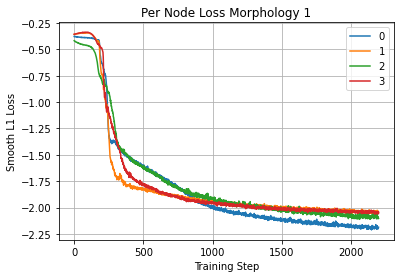


************** Batch 0 in 0.5038232803344727 **************

Training Idx 2 
Train Loss tensor([0.4324, 0.4503, 0.5266, 0.4290, 0.4426]) 
Test Loss tensor([0.4297, 0.4525, 0.5254, 0.4251, 0.4462])


************** Batch 4 in 0.47156214714050293 **************

Training Idx 2 
Train Loss tensor([0.4321, 0.4515, 0.5242, 0.4236, 0.4447]) 
Test Loss tensor([0.4288, 0.4521, 0.5236, 0.4258, 0.4464])


************** Batch 8 in 0.47851085662841797 **************

Training Idx 2 
Train Loss tensor([0.4286, 0.4539, 0.5236, 0.4266, 0.4481]) 
Test Loss tensor([0.4299, 0.4505, 0.5226, 0.4239, 0.4457])


************** Batch 12 in 0.47497010231018066 **************

Training Idx 2 
Train Loss tensor([0.4333, 0.4511, 0.5223, 0.4256, 0.4464]) 
Test Loss tensor([0.4293, 0.4516, 0.5209, 0.4261, 0.4459])


************** Batch 16 in 0.4635884761810303 **************

Training Idx 2 
Train Loss tensor([0.4282, 0.4531, 0.5220, 0.4253, 0.4478]) 
Test Loss tensor([0.4285, 0.4512, 0.5192, 0.4259, 0.4451])




************** Batch 164 in 0.46633124351501465 **************

Training Idx 2 
Train Loss tensor([0.4139, 0.4541, 0.4643, 0.4441, 0.4425]) 
Test Loss tensor([0.4140, 0.4535, 0.4621, 0.4461, 0.4432])


************** Batch 168 in 0.4681246280670166 **************

Training Idx 2 
Train Loss tensor([0.4124, 0.4525, 0.4614, 0.4457, 0.4400]) 
Test Loss tensor([0.4125, 0.4532, 0.4606, 0.4457, 0.4426])


************** Batch 172 in 0.4666018486022949 **************

Training Idx 2 
Train Loss tensor([0.4140, 0.4529, 0.4608, 0.4450, 0.4454]) 
Test Loss tensor([0.4125, 0.4535, 0.4588, 0.4468, 0.4421])


************** Batch 176 in 0.46266603469848633 **************

Training Idx 2 
Train Loss tensor([0.4150, 0.4509, 0.4597, 0.4474, 0.4420]) 
Test Loss tensor([0.4121, 0.4533, 0.4580, 0.4466, 0.4425])


************** Batch 180 in 0.4677417278289795 **************

Training Idx 2 
Train Loss tensor([0.4126, 0.4515, 0.4567, 0.4468, 0.4413]) 
Test Loss tensor([0.4123, 0.4533, 0.4553, 0.4481, 0.4


************** Batch 328 in 0.46441030502319336 **************

Training Idx 2 
Train Loss tensor([0.3987, 0.4579, 0.3944, 0.4740, 0.4426]) 
Test Loss tensor([0.3981, 0.4592, 0.3918, 0.4740, 0.4421])


************** Batch 332 in 0.465252161026001 **************

Training Idx 2 
Train Loss tensor([0.3985, 0.4595, 0.3922, 0.4721, 0.4411]) 
Test Loss tensor([0.3971, 0.4594, 0.3898, 0.4748, 0.4427])


************** Batch 336 in 0.46486353874206543 **************

Training Idx 2 
Train Loss tensor([0.3992, 0.4610, 0.3906, 0.4768, 0.4451]) 
Test Loss tensor([0.3970, 0.4592, 0.3881, 0.4761, 0.4418])


************** Batch 340 in 0.46789097785949707 **************

Training Idx 2 
Train Loss tensor([0.3998, 0.4589, 0.3889, 0.4743, 0.4407]) 
Test Loss tensor([0.3972, 0.4605, 0.3858, 0.4775, 0.4423])


************** Batch 344 in 0.46787405014038086 **************

Training Idx 2 
Train Loss tensor([0.3952, 0.4610, 0.3872, 0.4771, 0.4430]) 
Test Loss tensor([0.3966, 0.4605, 0.3840, 0.4772, 0.


************** Batch 492 in 0.5031027793884277 **************

Training Idx 2 
Train Loss tensor([0.3860, 0.4726, 0.2913, 0.5171, 0.4482]) 
Test Loss tensor([0.3839, 0.4753, 0.2881, 0.5244, 0.4498])


************** Batch 496 in 0.47766661643981934 **************

Training Idx 2 
Train Loss tensor([0.3917, 0.4744, 0.2878, 0.5230, 0.4479]) 
Test Loss tensor([0.3810, 0.4783, 0.2848, 0.5270, 0.4521])


************** Batch 500 in 0.470731258392334 **************

Training Idx 2 
Train Loss tensor([0.3850, 0.4772, 0.2833, 0.5233, 0.4483]) 
Test Loss tensor([0.3831, 0.4776, 0.2814, 0.5275, 0.4531])


************** Batch 504 in 0.4847903251647949 **************

Training Idx 2 
Train Loss tensor([0.3788, 0.4774, 0.2809, 0.5275, 0.4512]) 
Test Loss tensor([0.3827, 0.4765, 0.2787, 0.5295, 0.4518])


************** Batch 508 in 0.46917724609375 **************

Training Idx 2 
Train Loss tensor([0.3802, 0.4805, 0.2789, 0.5285, 0.4560]) 
Test Loss tensor([0.3808, 0.4781, 0.2751, 0.5314, 0.4532]


************** Batch 656 in 0.4810779094696045 **************

Training Idx 2 
Train Loss tensor([0.3789, 0.4850, 0.2153, 0.5421, 0.4656]) 
Test Loss tensor([0.3809, 0.4836, 0.2127, 0.5433, 0.4644])


************** Batch 660 in 0.5279805660247803 **************

Training Idx 2 
Train Loss tensor([0.3874, 0.4802, 0.2133, 0.5430, 0.4606]) 
Test Loss tensor([0.3785, 0.4827, 0.2111, 0.5438, 0.4643])


************** Batch 664 in 0.4850618839263916 **************

Training Idx 2 
Train Loss tensor([0.3856, 0.4826, 0.2107, 0.5369, 0.4636]) 
Test Loss tensor([0.3799, 0.4833, 0.2089, 0.5423, 0.4657])


************** Batch 668 in 0.4666156768798828 **************

Training Idx 2 
Train Loss tensor([0.3742, 0.4852, 0.2106, 0.5425, 0.4717]) 
Test Loss tensor([0.3806, 0.4834, 0.2072, 0.5434, 0.4661])


************** Batch 672 in 0.4695706367492676 **************

Training Idx 2 
Train Loss tensor([0.3836, 0.4884, 0.2077, 0.5446, 0.4719]) 
Test Loss tensor([0.3781, 0.4834, 0.2054, 0.5423, 0.467


************** Batch 820 in 0.4684174060821533 **************

Training Idx 2 
Train Loss tensor([0.3374, 0.4355, 0.0291, 0.4712, 0.5608]) 
Test Loss tensor([0.3394, 0.4301, 0.0268, 0.4713, 0.5598])


************** Batch 824 in 0.46796536445617676 **************

Training Idx 2 
Train Loss tensor([0.3378, 0.4307, 0.0263, 0.4684, 0.5566]) 
Test Loss tensor([0.3372, 0.4240, 0.0248, 0.4693, 0.5581])


************** Batch 828 in 0.46780896186828613 **************

Training Idx 2 
Train Loss tensor([0.3424, 0.4210, 0.0237, 0.4658, 0.5446]) 
Test Loss tensor([0.3342, 0.4174, 0.0232, 0.4669, 0.5572])


************** Batch 832 in 0.47350192070007324 **************

Training Idx 2 
Train Loss tensor([0.3275, 0.4146, 0.0244, 0.4663, 0.5581]) 
Test Loss tensor([0.3274, 0.4096, 0.0224, 0.4659, 0.5608])


************** Batch 836 in 0.4715566635131836 **************

Training Idx 2 
Train Loss tensor([0.3316, 0.4055, 0.0219, 0.4624, 0.5475]) 
Test Loss tensor([0.3243, 0.3982, 0.0212, 0.4618, 0.


************** Batch 104 in 0.4689669609069824 **************

Training Idx 2 
Train Loss tensor([0.2712, 0.2302, 0.0039, 0.3222, 0.2073]) 
Test Loss tensor([0.2711, 0.2303, 0.0041, 0.3200, 0.2045])


************** Batch 108 in 0.46750926971435547 **************

Training Idx 2 
Train Loss tensor([0.2832, 0.2313, 0.0040, 0.3209, 0.2051]) 
Test Loss tensor([0.2729, 0.2269, 0.0040, 0.3181, 0.2038])


************** Batch 112 in 0.46875452995300293 **************

Training Idx 2 
Train Loss tensor([0.2761, 0.2317, 0.0035, 0.3205, 0.2045]) 
Test Loss tensor([0.2692, 0.2237, 0.0043, 0.3151, 0.2024])


************** Batch 116 in 0.46921324729919434 **************

Training Idx 2 
Train Loss tensor([0.2848, 0.2210, 0.0043, 0.3141, 0.1987]) 
Test Loss tensor([0.2691, 0.2245, 0.0039, 0.3132, 0.1997])


************** Batch 120 in 0.483445405960083 **************

Training Idx 2 
Train Loss tensor([0.2679, 0.2146, 0.0040, 0.3147, 0.1939]) 
Test Loss tensor([0.2656, 0.2219, 0.0040, 0.3126, 0.2


************** Batch 268 in 0.46722960472106934 **************

Training Idx 2 
Train Loss tensor([0.2298, 0.1424, 0.0040, 0.2115, 0.1574]) 
Test Loss tensor([0.2366, 0.1354, 0.0035, 0.2097, 0.1560])


************** Batch 272 in 0.4648880958557129 **************

Training Idx 2 
Train Loss tensor([0.2435, 0.1372, 0.0033, 0.2103, 0.1521]) 
Test Loss tensor([0.2354, 0.1311, 0.0034, 0.2056, 0.1522])


************** Batch 276 in 0.4663047790527344 **************

Training Idx 2 
Train Loss tensor([0.2367, 0.1298, 0.0033, 0.2058, 0.1494]) 
Test Loss tensor([0.2322, 0.1286, 0.0034, 0.2030, 0.1526])


************** Batch 280 in 0.4670109748840332 **************

Training Idx 2 
Train Loss tensor([0.2410, 0.1283, 0.0033, 0.2026, 0.1524]) 
Test Loss tensor([0.2344, 0.1219, 0.0033, 0.1977, 0.1484])


************** Batch 284 in 0.469588041305542 **************

Training Idx 2 
Train Loss tensor([0.2258, 0.1226, 0.0033, 0.1926, 0.1448]) 
Test Loss tensor([0.2336, 0.1177, 0.0035, 0.1923, 0.148


************** Batch 432 in 0.4655296802520752 **************

Training Idx 2 
Train Loss tensor([0.2418, 0.0255, 0.0031, 0.0849, 0.0443]) 
Test Loss tensor([0.2468, 0.0263, 0.0038, 0.0821, 0.0434])


************** Batch 436 in 0.4679727554321289 **************

Training Idx 2 
Train Loss tensor([0.2546, 0.0243, 0.0038, 0.0773, 0.0391]) 
Test Loss tensor([0.2486, 0.0263, 0.0038, 0.0815, 0.0416])


************** Batch 440 in 0.47137451171875 **************

Training Idx 2 
Train Loss tensor([0.2463, 0.0239, 0.0039, 0.0878, 0.0388]) 
Test Loss tensor([0.2456, 0.0259, 0.0036, 0.0808, 0.0427])


************** Batch 444 in 0.4649627208709717 **************

Training Idx 2 
Train Loss tensor([0.2483, 0.0273, 0.0038, 0.0801, 0.0471]) 
Test Loss tensor([0.2420, 0.0275, 0.0035, 0.0807, 0.0422])


************** Batch 448 in 0.4760470390319824 **************

Training Idx 2 
Train Loss tensor([0.2533, 0.0279, 0.0036, 0.0864, 0.0436]) 
Test Loss tensor([0.2467, 0.0275, 0.0038, 0.0805, 0.0409]


************** Batch 596 in 0.4716305732727051 **************

Training Idx 2 
Train Loss tensor([0.2272, 0.0255, 0.0027, 0.0779, 0.0432]) 
Test Loss tensor([0.2176, 0.0235, 0.0027, 0.0732, 0.0418])


************** Batch 600 in 0.4690864086151123 **************

Training Idx 2 
Train Loss tensor([0.2166, 0.0207, 0.0025, 0.0709, 0.0422]) 
Test Loss tensor([0.2206, 0.0229, 0.0027, 0.0732, 0.0428])


************** Batch 604 in 0.4680056571960449 **************

Training Idx 2 
Train Loss tensor([0.2086, 0.0241, 0.0026, 0.0734, 0.0441]) 
Test Loss tensor([0.2187, 0.0233, 0.0027, 0.0739, 0.0423])


************** Batch 608 in 0.4703648090362549 **************

Training Idx 2 
Train Loss tensor([0.2189, 0.0196, 0.0025, 0.0747, 0.0434]) 
Test Loss tensor([0.2209, 0.0216, 0.0029, 0.0744, 0.0414])


************** Batch 612 in 0.46845412254333496 **************

Training Idx 2 
Train Loss tensor([0.2329, 0.0213, 0.0024, 0.0788, 0.0475]) 
Test Loss tensor([0.2203, 0.0223, 0.0029, 0.0746, 0.04


************** Batch 760 in 0.47231101989746094 **************

Training Idx 2 
Train Loss tensor([0.2156, 0.0199, 0.0026, 0.0646, 0.0378]) 
Test Loss tensor([0.2084, 0.0194, 0.0028, 0.0677, 0.0399])


************** Batch 764 in 0.4717719554901123 **************

Training Idx 2 
Train Loss tensor([0.2167, 0.0197, 0.0029, 0.0671, 0.0385]) 
Test Loss tensor([0.2076, 0.0194, 0.0027, 0.0651, 0.0394])


************** Batch 768 in 0.4739844799041748 **************

Training Idx 2 
Train Loss tensor([0.2149, 0.0196, 0.0027, 0.0689, 0.0431]) 
Test Loss tensor([0.2086, 0.0183, 0.0026, 0.0671, 0.0399])


************** Batch 772 in 0.4719383716583252 **************

Training Idx 2 
Train Loss tensor([0.2026, 0.0189, 0.0035, 0.0665, 0.0416]) 
Test Loss tensor([0.2096, 0.0204, 0.0026, 0.0663, 0.0403])


************** Batch 776 in 0.47127699851989746 **************

Training Idx 2 
Train Loss tensor([0.2021, 0.0147, 0.0026, 0.0653, 0.0421]) 
Test Loss tensor([0.2088, 0.0196, 0.0025, 0.0671, 0.0


************** Batch 44 in 0.4716215133666992 **************

Training Idx 2 
Train Loss tensor([0.1990, 0.0195, 0.0028, 0.0591, 0.0373]) 
Test Loss tensor([0.1984, 0.0182, 0.0028, 0.0627, 0.0380])


************** Batch 48 in 0.4713785648345947 **************

Training Idx 2 
Train Loss tensor([0.2063, 0.0196, 0.0035, 0.0605, 0.0391]) 
Test Loss tensor([0.1992, 0.0184, 0.0027, 0.0621, 0.0365])


************** Batch 52 in 0.47165703773498535 **************

Training Idx 2 
Train Loss tensor([0.1979, 0.0172, 0.0029, 0.0615, 0.0327]) 
Test Loss tensor([0.1995, 0.0184, 0.0027, 0.0621, 0.0377])


************** Batch 56 in 0.47164034843444824 **************

Training Idx 2 
Train Loss tensor([0.1851, 0.0180, 0.0029, 0.0609, 0.0381]) 
Test Loss tensor([0.1967, 0.0180, 0.0028, 0.0617, 0.0363])


************** Batch 60 in 0.4736487865447998 **************

Training Idx 2 
Train Loss tensor([0.2088, 0.0189, 0.0028, 0.0594, 0.0400]) 
Test Loss tensor([0.2003, 0.0182, 0.0027, 0.0623, 0.0366])


************** Batch 208 in 0.47530102729797363 **************

Training Idx 2 
Train Loss tensor([0.2022, 0.0156, 0.0026, 0.0519, 0.0378]) 
Test Loss tensor([0.1876, 0.0181, 0.0025, 0.0586, 0.0367])


************** Batch 212 in 0.4727184772491455 **************

Training Idx 2 
Train Loss tensor([0.1948, 0.0197, 0.0024, 0.0524, 0.0329]) 
Test Loss tensor([0.1879, 0.0179, 0.0027, 0.0570, 0.0350])


************** Batch 216 in 0.47714924812316895 **************

Training Idx 2 
Train Loss tensor([0.1917, 0.0225, 0.0028, 0.0537, 0.0340]) 
Test Loss tensor([0.1917, 0.0182, 0.0030, 0.0563, 0.0340])


************** Batch 220 in 0.478745698928833 **************

Training Idx 2 
Train Loss tensor([0.1943, 0.0159, 0.0030, 0.0494, 0.0349]) 
Test Loss tensor([0.1928, 0.0172, 0.0034, 0.0564, 0.0342])


************** Batch 224 in 0.48052167892456055 **************

Training Idx 2 
Train Loss tensor([0.1816, 0.0185, 0.0037, 0.0568, 0.0356]) 
Test Loss tensor([0.1885, 0.0176, 0.0032, 0.0573, 0.0


************** Batch 372 in 0.4929158687591553 **************

Training Idx 2 
Train Loss tensor([0.1747, 0.0199, 0.0035, 0.0483, 0.0323]) 
Test Loss tensor([0.1831, 0.0183, 0.0036, 0.0535, 0.0318])


************** Batch 376 in 0.48917365074157715 **************

Training Idx 2 
Train Loss tensor([0.1741, 0.0186, 0.0040, 0.0590, 0.0333]) 
Test Loss tensor([0.1822, 0.0175, 0.0029, 0.0514, 0.0323])


************** Batch 380 in 0.4909048080444336 **************

Training Idx 2 
Train Loss tensor([0.1875, 0.0173, 0.0028, 0.0486, 0.0316]) 
Test Loss tensor([0.1805, 0.0174, 0.0025, 0.0520, 0.0331])


************** Batch 384 in 0.48726916313171387 **************

Training Idx 2 
Train Loss tensor([0.1779, 0.0194, 0.0025, 0.0477, 0.0312]) 
Test Loss tensor([0.1823, 0.0164, 0.0026, 0.0535, 0.0333])


************** Batch 388 in 0.4908618927001953 **************

Training Idx 2 
Train Loss tensor([0.1840, 0.0164, 0.0028, 0.0499, 0.0323]) 
Test Loss tensor([0.1828, 0.0165, 0.0030, 0.0515, 0.0


************** Batch 536 in 0.47560954093933105 **************

Training Idx 2 
Train Loss tensor([0.1596, 0.0177, 0.0031, 0.0515, 0.0276]) 
Test Loss tensor([0.1626, 0.0176, 0.0031, 0.0504, 0.0310])


************** Batch 540 in 0.47178125381469727 **************

Training Idx 2 
Train Loss tensor([0.1615, 0.0151, 0.0032, 0.0511, 0.0327]) 
Test Loss tensor([0.1575, 0.0181, 0.0027, 0.0498, 0.0304])


************** Batch 544 in 0.4720933437347412 **************

Training Idx 2 
Train Loss tensor([0.1522, 0.0173, 0.0028, 0.0563, 0.0394]) 
Test Loss tensor([0.1553, 0.0184, 0.0025, 0.0500, 0.0312])


************** Batch 548 in 0.4691615104675293 **************

Training Idx 2 
Train Loss tensor([0.1559, 0.0187, 0.0023, 0.0514, 0.0306]) 
Test Loss tensor([0.1566, 0.0181, 0.0026, 0.0494, 0.0311])


************** Batch 552 in 0.47081828117370605 **************

Training Idx 2 
Train Loss tensor([0.1438, 0.0171, 0.0023, 0.0538, 0.0337]) 
Test Loss tensor([0.1509, 0.0182, 0.0029, 0.0521, 0.


************** Batch 700 in 0.47097206115722656 **************

Training Idx 2 
Train Loss tensor([0.0946, 0.0169, 0.0035, 0.0491, 0.0279]) 
Test Loss tensor([0.0996, 0.0180, 0.0037, 0.0496, 0.0298])


************** Batch 704 in 0.47150230407714844 **************

Training Idx 2 
Train Loss tensor([0.0961, 0.0186, 0.0045, 0.0484, 0.0322]) 
Test Loss tensor([0.0985, 0.0182, 0.0033, 0.0488, 0.0288])


************** Batch 708 in 0.47046422958374023 **************

Training Idx 2 
Train Loss tensor([0.1029, 0.0217, 0.0031, 0.0517, 0.0276]) 
Test Loss tensor([0.0974, 0.0183, 0.0030, 0.0487, 0.0289])


************** Batch 712 in 0.4753601551055908 **************

Training Idx 2 
Train Loss tensor([0.0901, 0.0178, 0.0028, 0.0473, 0.0289]) 
Test Loss tensor([0.0970, 0.0176, 0.0034, 0.0505, 0.0289])


************** Batch 716 in 0.46839070320129395 **************

Training Idx 2 
Train Loss tensor([0.0990, 0.0193, 0.0037, 0.0486, 0.0291]) 
Test Loss tensor([0.0974, 0.0176, 0.0034, 0.0490, 0


************** Batch 864 in 0.49373650550842285 **************

Training Idx 2 
Train Loss tensor([0.0814, 0.0149, 0.0035, 0.0475, 0.0247]) 
Test Loss tensor([0.0847, 0.0165, 0.0036, 0.0454, 0.0274])


************** Batch 868 in 0.4903733730316162 **************

Training Idx 2 
Train Loss tensor([0.0839, 0.0134, 0.0036, 0.0436, 0.0262]) 
Test Loss tensor([0.0838, 0.0165, 0.0030, 0.0443, 0.0273])


************** Batch 872 in 0.47217869758605957 **************

Training Idx 2 
Train Loss tensor([0.0782, 0.0202, 0.0034, 0.0408, 0.0265]) 
Test Loss tensor([0.0846, 0.0171, 0.0027, 0.0447, 0.0283])


************** Batch 876 in 0.4523274898529053 **************

Training Idx 2 
Train Loss tensor([0.0602, 0.0140, 0.0022, 0.0319, 0.0195]) 
Test Loss tensor([0.0844, 0.0176, 0.0029, 0.0431, 0.0278])


************** Batch 0 in 0.5469341278076172 **************

Training Idx 2 
Train Loss tensor([0.0876, 0.0150, 0.0030, 0.0406, 0.0280]) 
Test Loss tensor([0.0852, 0.0166, 0.0032, 0.0445, 0.027


************** Batch 148 in 0.4733731746673584 **************

Training Idx 2 
Train Loss tensor([0.0739, 0.0191, 0.0033, 0.0433, 0.0261]) 
Test Loss tensor([0.0764, 0.0162, 0.0029, 0.0409, 0.0260])


************** Batch 152 in 0.5223691463470459 **************

Training Idx 2 
Train Loss tensor([0.0766, 0.0196, 0.0028, 0.0364, 0.0266]) 
Test Loss tensor([0.0757, 0.0159, 0.0029, 0.0407, 0.0265])


************** Batch 156 in 0.48062801361083984 **************

Training Idx 2 
Train Loss tensor([0.0773, 0.0167, 0.0027, 0.0467, 0.0246]) 
Test Loss tensor([0.0763, 0.0162, 0.0034, 0.0419, 0.0260])


************** Batch 160 in 0.4723238945007324 **************

Training Idx 2 
Train Loss tensor([0.0805, 0.0139, 0.0037, 0.0454, 0.0248]) 
Test Loss tensor([0.0757, 0.0159, 0.0033, 0.0417, 0.0254])


************** Batch 164 in 0.47414278984069824 **************

Training Idx 2 
Train Loss tensor([0.0747, 0.0181, 0.0030, 0.0408, 0.0261]) 
Test Loss tensor([0.0765, 0.0160, 0.0031, 0.0400, 0.0


************** Batch 312 in 0.47612619400024414 **************

Training Idx 2 
Train Loss tensor([0.0670, 0.0179, 0.0028, 0.0357, 0.0237]) 
Test Loss tensor([0.0714, 0.0157, 0.0032, 0.0384, 0.0242])


************** Batch 316 in 0.48110318183898926 **************

Training Idx 2 
Train Loss tensor([0.0766, 0.0155, 0.0030, 0.0420, 0.0237]) 
Test Loss tensor([0.0702, 0.0166, 0.0030, 0.0376, 0.0244])


************** Batch 320 in 0.49169158935546875 **************

Training Idx 2 
Train Loss tensor([0.0703, 0.0158, 0.0026, 0.0404, 0.0245]) 
Test Loss tensor([0.0704, 0.0167, 0.0030, 0.0387, 0.0248])


************** Batch 324 in 0.4742472171783447 **************

Training Idx 2 
Train Loss tensor([0.0691, 0.0171, 0.0027, 0.0410, 0.0225]) 
Test Loss tensor([0.0682, 0.0155, 0.0031, 0.0386, 0.0245])


************** Batch 328 in 0.47875380516052246 **************

Training Idx 2 
Train Loss tensor([0.0698, 0.0161, 0.0031, 0.0340, 0.0257]) 
Test Loss tensor([0.0735, 0.0160, 0.0035, 0.0382, 0


************** Batch 476 in 0.47687768936157227 **************

Training Idx 2 
Train Loss tensor([0.0627, 0.0161, 0.0030, 0.0368, 0.0256]) 
Test Loss tensor([0.0649, 0.0165, 0.0032, 0.0367, 0.0228])


************** Batch 480 in 0.4761672019958496 **************

Training Idx 2 
Train Loss tensor([0.0605, 0.0181, 0.0029, 0.0349, 0.0230]) 
Test Loss tensor([0.0677, 0.0171, 0.0033, 0.0357, 0.0236])


************** Batch 484 in 0.47911930084228516 **************

Training Idx 2 
Train Loss tensor([0.0709, 0.0170, 0.0030, 0.0348, 0.0218]) 
Test Loss tensor([0.0664, 0.0161, 0.0033, 0.0354, 0.0224])


************** Batch 488 in 0.4857797622680664 **************

Training Idx 2 
Train Loss tensor([0.0635, 0.0141, 0.0038, 0.0359, 0.0220]) 
Test Loss tensor([0.0642, 0.0166, 0.0029, 0.0375, 0.0245])


************** Batch 492 in 0.5020661354064941 **************

Training Idx 2 
Train Loss tensor([0.0659, 0.0150, 0.0028, 0.0358, 0.0235]) 
Test Loss tensor([0.0652, 0.0162, 0.0031, 0.0353, 0.0


************** Batch 640 in 0.47586512565612793 **************

Training Idx 2 
Train Loss tensor([0.0651, 0.0159, 0.0031, 0.0351, 0.0204]) 
Test Loss tensor([0.0624, 0.0166, 0.0029, 0.0342, 0.0225])


************** Batch 644 in 0.47631001472473145 **************

Training Idx 2 
Train Loss tensor([0.0574, 0.0140, 0.0027, 0.0359, 0.0240]) 
Test Loss tensor([0.0614, 0.0167, 0.0028, 0.0355, 0.0226])


************** Batch 648 in 0.47316670417785645 **************

Training Idx 2 
Train Loss tensor([0.0619, 0.0178, 0.0027, 0.0334, 0.0241]) 
Test Loss tensor([0.0617, 0.0160, 0.0032, 0.0331, 0.0225])


************** Batch 652 in 0.4795663356781006 **************

Training Idx 2 
Train Loss tensor([0.0549, 0.0165, 0.0030, 0.0316, 0.0252]) 
Test Loss tensor([0.0624, 0.0156, 0.0033, 0.0355, 0.0222])


************** Batch 656 in 0.483264684677124 **************

Training Idx 2 
Train Loss tensor([0.0613, 0.0169, 0.0031, 0.0348, 0.0239]) 
Test Loss tensor([0.0608, 0.0154, 0.0030, 0.0333, 0.0


************** Batch 804 in 0.4780762195587158 **************

Training Idx 2 
Train Loss tensor([0.0607, 0.0163, 0.0032, 0.0319, 0.0190]) 
Test Loss tensor([0.0572, 0.0152, 0.0031, 0.0317, 0.0222])


************** Batch 808 in 0.47365283966064453 **************

Training Idx 2 
Train Loss tensor([0.0564, 0.0155, 0.0031, 0.0312, 0.0230]) 
Test Loss tensor([0.0602, 0.0160, 0.0029, 0.0328, 0.0222])


************** Batch 812 in 0.4763309955596924 **************

Training Idx 2 
Train Loss tensor([0.0587, 0.0156, 0.0032, 0.0320, 0.0253]) 
Test Loss tensor([0.0592, 0.0152, 0.0028, 0.0317, 0.0223])


************** Batch 816 in 0.47524070739746094 **************

Training Idx 2 
Train Loss tensor([0.0550, 0.0175, 0.0029, 0.0345, 0.0238]) 
Test Loss tensor([0.0589, 0.0152, 0.0028, 0.0324, 0.0221])


************** Batch 820 in 0.5036916732788086 **************

Training Idx 2 
Train Loss tensor([0.0530, 0.0135, 0.0024, 0.0299, 0.0220]) 
Test Loss tensor([0.0586, 0.0152, 0.0028, 0.0326, 0.0


************** Batch 88 in 0.47124171257019043 **************

Training Idx 2 
Train Loss tensor([0.0550, 0.0137, 0.0024, 0.0308, 0.0243]) 
Test Loss tensor([0.0562, 0.0151, 0.0029, 0.0305, 0.0222])


************** Batch 92 in 0.4717252254486084 **************

Training Idx 2 
Train Loss tensor([0.0527, 0.0133, 0.0025, 0.0290, 0.0244]) 
Test Loss tensor([0.0568, 0.0152, 0.0030, 0.0298, 0.0213])


************** Batch 96 in 0.47058820724487305 **************

Training Idx 2 
Train Loss tensor([0.0593, 0.0156, 0.0030, 0.0327, 0.0267]) 
Test Loss tensor([0.0570, 0.0157, 0.0030, 0.0302, 0.0212])


************** Batch 100 in 0.4705543518066406 **************

Training Idx 2 
Train Loss tensor([0.0552, 0.0177, 0.0028, 0.0267, 0.0216]) 
Test Loss tensor([0.0549, 0.0153, 0.0028, 0.0300, 0.0217])


************** Batch 104 in 0.4700620174407959 **************

Training Idx 2 
Train Loss tensor([0.0546, 0.0147, 0.0033, 0.0296, 0.0251]) 
Test Loss tensor([0.0559, 0.0156, 0.0030, 0.0297, 0.0209


************** Batch 252 in 0.4722599983215332 **************

Training Idx 2 
Train Loss tensor([0.0490, 0.0145, 0.0029, 0.0318, 0.0201]) 
Test Loss tensor([0.0539, 0.0148, 0.0027, 0.0297, 0.0205])


************** Batch 256 in 0.47111082077026367 **************

Training Idx 2 
Train Loss tensor([0.0522, 0.0143, 0.0026, 0.0291, 0.0198]) 
Test Loss tensor([0.0541, 0.0143, 0.0027, 0.0293, 0.0213])


************** Batch 260 in 0.47237420082092285 **************

Training Idx 2 
Train Loss tensor([0.0480, 0.0147, 0.0027, 0.0247, 0.0232]) 
Test Loss tensor([0.0540, 0.0151, 0.0029, 0.0290, 0.0216])


************** Batch 264 in 0.4696505069732666 **************

Training Idx 2 
Train Loss tensor([0.0547, 0.0150, 0.0027, 0.0299, 0.0211]) 
Test Loss tensor([0.0548, 0.0150, 0.0028, 0.0285, 0.0212])


************** Batch 268 in 0.4727809429168701 **************

Training Idx 2 
Train Loss tensor([0.0500, 0.0137, 0.0031, 0.0284, 0.0210]) 
Test Loss tensor([0.0527, 0.0143, 0.0028, 0.0291, 0.0


************** Batch 416 in 0.47083473205566406 **************

Training Idx 2 
Train Loss tensor([0.0522, 0.0136, 0.0029, 0.0308, 0.0221]) 
Test Loss tensor([0.0507, 0.0149, 0.0029, 0.0283, 0.0204])


************** Batch 420 in 0.4778599739074707 **************

Training Idx 2 
Train Loss tensor([0.0510, 0.0123, 0.0024, 0.0308, 0.0200]) 
Test Loss tensor([0.0519, 0.0148, 0.0029, 0.0276, 0.0199])


************** Batch 424 in 0.47785305976867676 **************

Training Idx 2 
Train Loss tensor([0.0461, 0.0150, 0.0031, 0.0317, 0.0213]) 
Test Loss tensor([0.0518, 0.0144, 0.0031, 0.0287, 0.0199])


************** Batch 428 in 0.4858970642089844 **************

Training Idx 2 
Train Loss tensor([0.0519, 0.0144, 0.0031, 0.0260, 0.0212]) 
Test Loss tensor([0.0522, 0.0149, 0.0029, 0.0281, 0.0198])


************** Batch 432 in 0.4733083248138428 **************

Training Idx 2 
Train Loss tensor([0.0495, 0.0148, 0.0026, 0.0276, 0.0219]) 
Test Loss tensor([0.0507, 0.0148, 0.0027, 0.0285, 0.0


************** Batch 580 in 0.47707033157348633 **************

Training Idx 2 
Train Loss tensor([0.0493, 0.0128, 0.0025, 0.0264, 0.0180]) 
Test Loss tensor([0.0516, 0.0144, 0.0030, 0.0283, 0.0194])


************** Batch 584 in 0.47472381591796875 **************

Training Idx 2 
Train Loss tensor([0.0483, 0.0133, 0.0030, 0.0271, 0.0208]) 
Test Loss tensor([0.0506, 0.0143, 0.0027, 0.0266, 0.0187])


************** Batch 588 in 0.47454214096069336 **************

Training Idx 2 
Train Loss tensor([0.0452, 0.0122, 0.0026, 0.0262, 0.0210]) 
Test Loss tensor([0.0494, 0.0144, 0.0027, 0.0297, 0.0201])


************** Batch 592 in 0.47453927993774414 **************

Training Idx 2 
Train Loss tensor([0.0522, 0.0132, 0.0027, 0.0288, 0.0212]) 
Test Loss tensor([0.0506, 0.0143, 0.0028, 0.0266, 0.0192])


************** Batch 596 in 0.47771739959716797 **************

Training Idx 2 
Train Loss tensor([0.0516, 0.0148, 0.0025, 0.0259, 0.0188]) 
Test Loss tensor([0.0492, 0.0143, 0.0027, 0.0276, 


************** Batch 744 in 0.470966100692749 **************

Training Idx 2 
Train Loss tensor([0.0459, 0.0105, 0.0026, 0.0283, 0.0184]) 
Test Loss tensor([0.0484, 0.0140, 0.0027, 0.0263, 0.0180])


************** Batch 748 in 0.47438693046569824 **************

Training Idx 2 
Train Loss tensor([0.0461, 0.0139, 0.0034, 0.0285, 0.0173]) 
Test Loss tensor([0.0492, 0.0136, 0.0029, 0.0274, 0.0188])


************** Batch 752 in 0.4727046489715576 **************

Training Idx 2 
Train Loss tensor([0.0497, 0.0164, 0.0027, 0.0262, 0.0183]) 
Test Loss tensor([0.0477, 0.0139, 0.0027, 0.0269, 0.0183])


************** Batch 756 in 0.47547030448913574 **************

Training Idx 2 
Train Loss tensor([0.0460, 0.0138, 0.0033, 0.0295, 0.0167]) 
Test Loss tensor([0.0495, 0.0142, 0.0028, 0.0263, 0.0188])


************** Batch 760 in 0.47183728218078613 **************

Training Idx 2 
Train Loss tensor([0.0479, 0.0112, 0.0025, 0.0236, 0.0187]) 
Test Loss tensor([0.0487, 0.0132, 0.0030, 0.0276, 0.0


************** Batch 28 in 0.4708118438720703 **************

Training Idx 2 
Train Loss tensor([0.0468, 0.0127, 0.0030, 0.0250, 0.0212]) 
Test Loss tensor([0.0477, 0.0138, 0.0031, 0.0270, 0.0183])


************** Batch 32 in 0.4722723960876465 **************

Training Idx 2 
Train Loss tensor([0.0481, 0.0126, 0.0029, 0.0265, 0.0220]) 
Test Loss tensor([0.0461, 0.0136, 0.0032, 0.0283, 0.0190])


************** Batch 36 in 0.47136497497558594 **************

Training Idx 2 
Train Loss tensor([0.0452, 0.0109, 0.0028, 0.0246, 0.0170]) 
Test Loss tensor([0.0480, 0.0135, 0.0028, 0.0256, 0.0177])


************** Batch 40 in 0.47232675552368164 **************

Training Idx 2 
Train Loss tensor([0.0458, 0.0116, 0.0032, 0.0284, 0.0175]) 
Test Loss tensor([0.0460, 0.0137, 0.0029, 0.0266, 0.0187])


************** Batch 44 in 0.4707145690917969 **************

Training Idx 2 
Train Loss tensor([0.0421, 0.0135, 0.0027, 0.0233, 0.0189]) 
Test Loss tensor([0.0476, 0.0129, 0.0030, 0.0265, 0.0189])


************** Batch 192 in 0.4706110954284668 **************

Training Idx 2 
Train Loss tensor([0.0415, 0.0142, 0.0022, 0.0238, 0.0152]) 
Test Loss tensor([0.0463, 0.0132, 0.0028, 0.0264, 0.0180])


************** Batch 196 in 0.4730243682861328 **************

Training Idx 2 
Train Loss tensor([0.0409, 0.0124, 0.0027, 0.0254, 0.0197]) 
Test Loss tensor([0.0453, 0.0127, 0.0028, 0.0256, 0.0178])


************** Batch 200 in 0.4693629741668701 **************

Training Idx 2 
Train Loss tensor([0.0513, 0.0112, 0.0028, 0.0277, 0.0193]) 
Test Loss tensor([0.0448, 0.0130, 0.0028, 0.0257, 0.0180])


************** Batch 204 in 0.47337961196899414 **************

Training Idx 2 
Train Loss tensor([0.0475, 0.0134, 0.0030, 0.0267, 0.0194]) 
Test Loss tensor([0.0453, 0.0133, 0.0029, 0.0261, 0.0184])


************** Batch 208 in 0.4805293083190918 **************

Training Idx 2 
Train Loss tensor([0.0431, 0.0141, 0.0028, 0.0286, 0.0153]) 
Test Loss tensor([0.0465, 0.0130, 0.0028, 0.0263, 0.01


************** Batch 356 in 0.4734022617340088 **************

Training Idx 2 
Train Loss tensor([0.0481, 0.0118, 0.0025, 0.0251, 0.0196]) 
Test Loss tensor([0.0443, 0.0130, 0.0029, 0.0256, 0.0178])


************** Batch 360 in 0.5003206729888916 **************

Training Idx 2 
Train Loss tensor([0.0393, 0.0134, 0.0029, 0.0249, 0.0183]) 
Test Loss tensor([0.0450, 0.0127, 0.0030, 0.0265, 0.0172])


************** Batch 364 in 0.478848934173584 **************

Training Idx 2 
Train Loss tensor([0.0463, 0.0111, 0.0030, 0.0259, 0.0185]) 
Test Loss tensor([0.0442, 0.0126, 0.0028, 0.0254, 0.0172])


************** Batch 368 in 0.47051525115966797 **************

Training Idx 2 
Train Loss tensor([0.0370, 0.0127, 0.0027, 0.0229, 0.0158]) 
Test Loss tensor([0.0456, 0.0133, 0.0028, 0.0261, 0.0179])


************** Batch 372 in 0.47449636459350586 **************

Training Idx 2 
Train Loss tensor([0.0484, 0.0132, 0.0026, 0.0272, 0.0163]) 
Test Loss tensor([0.0450, 0.0126, 0.0028, 0.0243, 0.01


************** Batch 520 in 0.4696171283721924 **************

Training Idx 2 
Train Loss tensor([0.0428, 0.0109, 0.0028, 0.0253, 0.0165]) 
Test Loss tensor([0.0458, 0.0134, 0.0025, 0.0252, 0.0179])


************** Batch 524 in 0.4748194217681885 **************

Training Idx 2 
Train Loss tensor([0.0485, 0.0110, 0.0024, 0.0268, 0.0188]) 
Test Loss tensor([0.0451, 0.0119, 0.0027, 0.0245, 0.0174])


************** Batch 528 in 0.4692232608795166 **************

Training Idx 2 
Train Loss tensor([0.0464, 0.0110, 0.0027, 0.0237, 0.0149]) 
Test Loss tensor([0.0471, 0.0126, 0.0031, 0.0257, 0.0174])


************** Batch 532 in 0.4714632034301758 **************

Training Idx 2 
Train Loss tensor([0.0467, 0.0131, 0.0028, 0.0255, 0.0179]) 
Test Loss tensor([0.0453, 0.0125, 0.0027, 0.0251, 0.0170])


************** Batch 536 in 0.47077012062072754 **************

Training Idx 2 
Train Loss tensor([0.0430, 0.0120, 0.0028, 0.0257, 0.0174]) 
Test Loss tensor([0.0453, 0.0127, 0.0025, 0.0256, 0.01


************** Batch 684 in 0.4751746654510498 **************

Training Idx 2 
Train Loss tensor([0.0444, 0.0131, 0.0025, 0.0228, 0.0176]) 
Test Loss tensor([0.0430, 0.0127, 0.0026, 0.0247, 0.0172])


************** Batch 688 in 0.4754664897918701 **************

Training Idx 2 
Train Loss tensor([0.0392, 0.0121, 0.0023, 0.0231, 0.0188]) 
Test Loss tensor([0.0418, 0.0122, 0.0025, 0.0237, 0.0173])


************** Batch 692 in 0.47417616844177246 **************

Training Idx 2 
Train Loss tensor([0.0457, 0.0110, 0.0029, 0.0211, 0.0194]) 
Test Loss tensor([0.0440, 0.0121, 0.0026, 0.0252, 0.0164])


************** Batch 696 in 0.4664433002471924 **************

Training Idx 2 
Train Loss tensor([0.0401, 0.0118, 0.0026, 0.0242, 0.0162]) 
Test Loss tensor([0.0441, 0.0122, 0.0026, 0.0243, 0.0165])


************** Batch 700 in 0.4703991413116455 **************

Training Idx 2 
Train Loss tensor([0.0407, 0.0120, 0.0027, 0.0248, 0.0168]) 
Test Loss tensor([0.0445, 0.0123, 0.0026, 0.0249, 0.01


************** Batch 848 in 0.4784388542175293 **************

Training Idx 2 
Train Loss tensor([0.0376, 0.0118, 0.0026, 0.0214, 0.0165]) 
Test Loss tensor([0.0421, 0.0123, 0.0026, 0.0251, 0.0164])


************** Batch 852 in 0.4698343276977539 **************

Training Idx 2 
Train Loss tensor([0.0453, 0.0122, 0.0030, 0.0244, 0.0175]) 
Test Loss tensor([0.0417, 0.0124, 0.0026, 0.0231, 0.0159])


************** Batch 856 in 0.4771420955657959 **************

Training Idx 2 
Train Loss tensor([0.0429, 0.0111, 0.0026, 0.0232, 0.0169]) 
Test Loss tensor([0.0429, 0.0121, 0.0026, 0.0235, 0.0162])


************** Batch 860 in 0.47751927375793457 **************

Training Idx 2 
Train Loss tensor([0.0413, 0.0129, 0.0027, 0.0257, 0.0157]) 
Test Loss tensor([0.0414, 0.0117, 0.0026, 0.0230, 0.0152])


************** Batch 864 in 0.47301673889160156 **************

Training Idx 2 
Train Loss tensor([0.0475, 0.0097, 0.0026, 0.0248, 0.0133]) 
Test Loss tensor([0.0413, 0.0114, 0.0026, 0.0244, 0.0


************** Batch 132 in 0.4740598201751709 **************

Training Idx 2 
Train Loss tensor([0.0395, 0.0127, 0.0026, 0.0220, 0.0142]) 
Test Loss tensor([0.0415, 0.0121, 0.0027, 0.0235, 0.0159])


************** Batch 136 in 0.4869663715362549 **************

Training Idx 2 
Train Loss tensor([0.0401, 0.0117, 0.0027, 0.0237, 0.0174]) 
Test Loss tensor([0.0423, 0.0122, 0.0026, 0.0254, 0.0160])


************** Batch 140 in 0.4741935729980469 **************

Training Idx 2 
Train Loss tensor([0.0408, 0.0115, 0.0025, 0.0265, 0.0157]) 
Test Loss tensor([0.0422, 0.0123, 0.0026, 0.0243, 0.0164])


************** Batch 144 in 0.474963903427124 **************

Training Idx 2 
Train Loss tensor([0.0368, 0.0112, 0.0028, 0.0237, 0.0164]) 
Test Loss tensor([0.0425, 0.0118, 0.0028, 0.0232, 0.0161])


************** Batch 148 in 0.4733126163482666 **************

Training Idx 2 
Train Loss tensor([0.0374, 0.0115, 0.0028, 0.0241, 0.0184]) 
Test Loss tensor([0.0421, 0.0117, 0.0028, 0.0238, 0.0157


************** Batch 296 in 0.4750239849090576 **************

Training Idx 2 
Train Loss tensor([0.0397, 0.0100, 0.0026, 0.0238, 0.0177]) 
Test Loss tensor([0.0417, 0.0114, 0.0027, 0.0231, 0.0154])


************** Batch 300 in 0.47422361373901367 **************

Training Idx 2 
Train Loss tensor([0.0393, 0.0129, 0.0025, 0.0240, 0.0176]) 
Test Loss tensor([0.0415, 0.0122, 0.0026, 0.0233, 0.0159])


************** Batch 304 in 0.4697127342224121 **************

Training Idx 2 
Train Loss tensor([0.0415, 0.0134, 0.0028, 0.0225, 0.0182]) 
Test Loss tensor([0.0415, 0.0110, 0.0026, 0.0233, 0.0155])


************** Batch 308 in 0.4764573574066162 **************

Training Idx 2 
Train Loss tensor([0.0377, 0.0134, 0.0025, 0.0236, 0.0171]) 
Test Loss tensor([0.0411, 0.0114, 0.0028, 0.0237, 0.0155])


************** Batch 312 in 0.4709289073944092 **************

Training Idx 2 
Train Loss tensor([0.0408, 0.0108, 0.0026, 0.0285, 0.0160]) 
Test Loss tensor([0.0415, 0.0112, 0.0028, 0.0238, 0.01


************** Batch 460 in 0.4732630252838135 **************

Training Idx 2 
Train Loss tensor([0.0394, 0.0138, 0.0026, 0.0219, 0.0165]) 
Test Loss tensor([0.0399, 0.0116, 0.0026, 0.0230, 0.0152])


************** Batch 464 in 0.46901679039001465 **************

Training Idx 2 
Train Loss tensor([0.0393, 0.0120, 0.0026, 0.0196, 0.0160]) 
Test Loss tensor([0.0425, 0.0115, 0.0028, 0.0227, 0.0148])


************** Batch 468 in 0.47475767135620117 **************

Training Idx 2 
Train Loss tensor([0.0407, 0.0119, 0.0026, 0.0236, 0.0174]) 
Test Loss tensor([0.0407, 0.0117, 0.0028, 0.0228, 0.0156])


************** Batch 472 in 0.47414493560791016 **************

Training Idx 2 
Train Loss tensor([0.0403, 0.0115, 0.0027, 0.0251, 0.0146]) 
Test Loss tensor([0.0416, 0.0117, 0.0026, 0.0237, 0.0154])


************** Batch 476 in 0.47151613235473633 **************

Training Idx 2 
Train Loss tensor([0.0443, 0.0126, 0.0026, 0.0225, 0.0160]) 
Test Loss tensor([0.0411, 0.0111, 0.0025, 0.0232, 0


************** Batch 624 in 0.4735109806060791 **************

Training Idx 2 
Train Loss tensor([0.0382, 0.0116, 0.0026, 0.0212, 0.0153]) 
Test Loss tensor([0.0399, 0.0114, 0.0025, 0.0227, 0.0151])


************** Batch 628 in 0.4730393886566162 **************

Training Idx 2 
Train Loss tensor([0.0382, 0.0108, 0.0029, 0.0201, 0.0155]) 
Test Loss tensor([0.0397, 0.0114, 0.0026, 0.0228, 0.0151])


************** Batch 632 in 0.4704906940460205 **************

Training Idx 2 
Train Loss tensor([0.0402, 0.0105, 0.0024, 0.0223, 0.0156]) 
Test Loss tensor([0.0396, 0.0113, 0.0027, 0.0231, 0.0153])


************** Batch 636 in 0.4748847484588623 **************

Training Idx 2 
Train Loss tensor([0.0414, 0.0110, 0.0025, 0.0213, 0.0144]) 
Test Loss tensor([0.0406, 0.0116, 0.0027, 0.0228, 0.0151])


************** Batch 640 in 0.47138118743896484 **************

Training Idx 2 
Train Loss tensor([0.0392, 0.0108, 0.0024, 0.0264, 0.0164]) 
Test Loss tensor([0.0403, 0.0114, 0.0025, 0.0233, 0.01


************** Batch 788 in 0.471297025680542 **************

Training Idx 2 
Train Loss tensor([0.0402, 0.0085, 0.0029, 0.0229, 0.0151]) 
Test Loss tensor([0.0395, 0.0107, 0.0025, 0.0222, 0.0148])


************** Batch 792 in 0.47008681297302246 **************

Training Idx 2 
Train Loss tensor([0.0367, 0.0113, 0.0025, 0.0226, 0.0156]) 
Test Loss tensor([0.0387, 0.0110, 0.0024, 0.0226, 0.0145])


************** Batch 796 in 0.47508978843688965 **************

Training Idx 2 
Train Loss tensor([0.0378, 0.0111, 0.0023, 0.0216, 0.0146]) 
Test Loss tensor([0.0391, 0.0116, 0.0025, 0.0226, 0.0148])


************** Batch 800 in 0.4709665775299072 **************

Training Idx 2 
Train Loss tensor([0.0351, 0.0117, 0.0024, 0.0203, 0.0147]) 
Test Loss tensor([0.0390, 0.0107, 0.0026, 0.0223, 0.0147])


************** Batch 804 in 0.4726247787475586 **************

Training Idx 2 
Train Loss tensor([0.0367, 0.0105, 0.0028, 0.0241, 0.0160]) 
Test Loss tensor([0.0388, 0.0112, 0.0026, 0.0218, 0.01


************** Batch 72 in 0.4771304130554199 **************

Training Idx 2 
Train Loss tensor([0.0396, 0.0095, 0.0024, 0.0223, 0.0159]) 
Test Loss tensor([0.0380, 0.0112, 0.0025, 0.0214, 0.0144])


************** Batch 76 in 0.4763326644897461 **************

Training Idx 2 
Train Loss tensor([0.0382, 0.0127, 0.0029, 0.0216, 0.0155]) 
Test Loss tensor([0.0386, 0.0108, 0.0025, 0.0222, 0.0143])


************** Batch 80 in 0.47255492210388184 **************

Training Idx 2 
Train Loss tensor([0.0367, 0.0108, 0.0028, 0.0220, 0.0160]) 
Test Loss tensor([0.0386, 0.0109, 0.0025, 0.0219, 0.0145])


************** Batch 84 in 0.48087620735168457 **************

Training Idx 2 
Train Loss tensor([0.0340, 0.0093, 0.0024, 0.0213, 0.0150]) 
Test Loss tensor([0.0383, 0.0108, 0.0025, 0.0220, 0.0148])


************** Batch 88 in 0.47226786613464355 **************

Training Idx 2 
Train Loss tensor([0.0394, 0.0112, 0.0023, 0.0213, 0.0157]) 
Test Loss tensor([0.0398, 0.0112, 0.0025, 0.0218, 0.0150]


************** Batch 236 in 0.4715268611907959 **************

Training Idx 2 
Train Loss tensor([0.0334, 0.0091, 0.0023, 0.0269, 0.0141]) 
Test Loss tensor([0.0382, 0.0114, 0.0025, 0.0223, 0.0144])


************** Batch 240 in 0.476184606552124 **************

Training Idx 2 
Train Loss tensor([0.0352, 0.0101, 0.0025, 0.0216, 0.0157]) 
Test Loss tensor([0.0373, 0.0106, 0.0025, 0.0220, 0.0141])


************** Batch 244 in 0.49182868003845215 **************

Training Idx 2 
Train Loss tensor([0.0358, 0.0099, 0.0025, 0.0224, 0.0150]) 
Test Loss tensor([0.0386, 0.0115, 0.0026, 0.0211, 0.0146])


************** Batch 248 in 0.4720602035522461 **************

Training Idx 2 
Train Loss tensor([0.0372, 0.0106, 0.0022, 0.0242, 0.0139]) 
Test Loss tensor([0.0376, 0.0110, 0.0024, 0.0222, 0.0148])


************** Batch 252 in 0.47757482528686523 **************

Training Idx 2 
Train Loss tensor([0.0398, 0.0090, 0.0023, 0.0245, 0.0163]) 
Test Loss tensor([0.0380, 0.0103, 0.0025, 0.0209, 0.01


************** Batch 400 in 0.4722168445587158 **************

Training Idx 2 
Train Loss tensor([0.0352, 0.0113, 0.0023, 0.0192, 0.0130]) 
Test Loss tensor([0.0385, 0.0112, 0.0025, 0.0222, 0.0139])


************** Batch 404 in 0.47148799896240234 **************

Training Idx 2 
Train Loss tensor([0.0404, 0.0114, 0.0025, 0.0245, 0.0139]) 
Test Loss tensor([0.0384, 0.0110, 0.0027, 0.0217, 0.0140])


************** Batch 408 in 0.4729640483856201 **************

Training Idx 2 
Train Loss tensor([0.0420, 0.0111, 0.0025, 0.0230, 0.0151]) 
Test Loss tensor([0.0402, 0.0109, 0.0029, 0.0231, 0.0143])


************** Batch 412 in 0.47324514389038086 **************

Training Idx 2 
Train Loss tensor([0.0387, 0.0120, 0.0029, 0.0219, 0.0155]) 
Test Loss tensor([0.0377, 0.0110, 0.0025, 0.0221, 0.0142])


************** Batch 416 in 0.47178006172180176 **************

Training Idx 2 
Train Loss tensor([0.0391, 0.0089, 0.0026, 0.0229, 0.0168]) 
Test Loss tensor([0.0402, 0.0108, 0.0024, 0.0244, 0.


************** Batch 564 in 0.47388148307800293 **************

Training Idx 2 
Train Loss tensor([0.0414, 0.0104, 0.0021, 0.0226, 0.0141]) 
Test Loss tensor([0.0363, 0.0102, 0.0025, 0.0222, 0.0141])


************** Batch 568 in 0.47267651557922363 **************

Training Idx 2 
Train Loss tensor([0.0350, 0.0089, 0.0022, 0.0217, 0.0154]) 
Test Loss tensor([0.0363, 0.0101, 0.0024, 0.0213, 0.0139])


************** Batch 572 in 0.480576753616333 **************

Training Idx 2 
Train Loss tensor([0.0356, 0.0090, 0.0023, 0.0194, 0.0131]) 
Test Loss tensor([0.0374, 0.0105, 0.0025, 0.0215, 0.0138])


************** Batch 576 in 0.48139476776123047 **************

Training Idx 2 
Train Loss tensor([0.0384, 0.0098, 0.0025, 0.0213, 0.0156]) 
Test Loss tensor([0.0369, 0.0107, 0.0025, 0.0218, 0.0136])


************** Batch 580 in 0.47991108894348145 **************

Training Idx 2 
Train Loss tensor([0.0342, 0.0112, 0.0025, 0.0201, 0.0137]) 
Test Loss tensor([0.0364, 0.0106, 0.0024, 0.0223, 0.


************** Batch 728 in 0.4801907539367676 **************

Training Idx 2 
Train Loss tensor([0.0332, 0.0118, 0.0023, 0.0227, 0.0147]) 
Test Loss tensor([0.0370, 0.0104, 0.0023, 0.0211, 0.0141])


************** Batch 732 in 0.47577857971191406 **************

Training Idx 2 
Train Loss tensor([0.0377, 0.0088, 0.0021, 0.0218, 0.0145]) 
Test Loss tensor([0.0376, 0.0103, 0.0024, 0.0215, 0.0138])


************** Batch 736 in 0.4817345142364502 **************

Training Idx 2 
Train Loss tensor([0.0416, 0.0106, 0.0025, 0.0222, 0.0143]) 
Test Loss tensor([0.0351, 0.0106, 0.0025, 0.0211, 0.0136])


************** Batch 740 in 0.4958841800689697 **************

Training Idx 2 
Train Loss tensor([0.0348, 0.0089, 0.0024, 0.0190, 0.0130]) 
Test Loss tensor([0.0366, 0.0107, 0.0027, 0.0213, 0.0143])


************** Batch 744 in 0.47924017906188965 **************

Training Idx 2 
Train Loss tensor([0.0352, 0.0105, 0.0024, 0.0204, 0.0151]) 
Test Loss tensor([0.0359, 0.0104, 0.0025, 0.0222, 0.0


************** Batch 12 in 0.4591822624206543 **************

Training Idx 2 
Train Loss tensor([0.0350, 0.0111, 0.0021, 0.0192, 0.0135]) 
Test Loss tensor([0.0371, 0.0107, 0.0024, 0.0218, 0.0134])


************** Batch 16 in 0.4622933864593506 **************

Training Idx 2 
Train Loss tensor([0.0345, 0.0095, 0.0030, 0.0211, 0.0139]) 
Test Loss tensor([0.0360, 0.0101, 0.0024, 0.0212, 0.0137])


************** Batch 20 in 0.4636809825897217 **************

Training Idx 2 
Train Loss tensor([0.0374, 0.0101, 0.0022, 0.0230, 0.0147]) 
Test Loss tensor([0.0360, 0.0099, 0.0024, 0.0216, 0.0142])


************** Batch 24 in 0.46343016624450684 **************

Training Idx 2 
Train Loss tensor([0.0347, 0.0097, 0.0026, 0.0210, 0.0134]) 
Test Loss tensor([0.0362, 0.0104, 0.0024, 0.0233, 0.0140])


************** Batch 28 in 0.4615967273712158 **************

Training Idx 2 
Train Loss tensor([0.0372, 0.0110, 0.0027, 0.0195, 0.0142]) 
Test Loss tensor([0.0370, 0.0101, 0.0024, 0.0213, 0.0135])



************** Batch 176 in 0.4708399772644043 **************

Training Idx 2 
Train Loss tensor([0.0335, 0.0093, 0.0020, 0.0209, 0.0170]) 
Test Loss tensor([0.0364, 0.0098, 0.0023, 0.0216, 0.0137])


************** Batch 180 in 0.46872377395629883 **************

Training Idx 2 
Train Loss tensor([0.0342, 0.0089, 0.0022, 0.0224, 0.0127]) 
Test Loss tensor([0.0357, 0.0105, 0.0022, 0.0219, 0.0138])


************** Batch 184 in 0.47045111656188965 **************

Training Idx 2 
Train Loss tensor([0.0366, 0.0088, 0.0023, 0.0200, 0.0128]) 
Test Loss tensor([0.0363, 0.0104, 0.0023, 0.0204, 0.0139])


************** Batch 188 in 0.4698817729949951 **************

Training Idx 2 
Train Loss tensor([0.0364, 0.0100, 0.0023, 0.0206, 0.0126]) 
Test Loss tensor([0.0370, 0.0099, 0.0024, 0.0206, 0.0134])


************** Batch 192 in 0.4701571464538574 **************

Training Idx 2 
Train Loss tensor([0.0366, 0.0111, 0.0022, 0.0199, 0.0155]) 
Test Loss tensor([0.0351, 0.0104, 0.0024, 0.0213, 0.0


************** Batch 340 in 0.47439074516296387 **************

Training Idx 2 
Train Loss tensor([0.0347, 0.0083, 0.0022, 0.0187, 0.0134]) 
Test Loss tensor([0.0346, 0.0103, 0.0024, 0.0204, 0.0134])


************** Batch 344 in 0.46677350997924805 **************

Training Idx 2 
Train Loss tensor([0.0356, 0.0083, 0.0024, 0.0186, 0.0129]) 
Test Loss tensor([0.0348, 0.0104, 0.0023, 0.0208, 0.0130])


************** Batch 348 in 0.46860551834106445 **************

Training Idx 2 
Train Loss tensor([0.0343, 0.0096, 0.0023, 0.0181, 0.0136]) 
Test Loss tensor([0.0354, 0.0102, 0.0024, 0.0208, 0.0128])


************** Batch 352 in 0.4696218967437744 **************

Training Idx 2 
Train Loss tensor([0.0321, 0.0098, 0.0024, 0.0216, 0.0145]) 
Test Loss tensor([0.0344, 0.0104, 0.0024, 0.0211, 0.0134])


************** Batch 356 in 0.46857523918151855 **************

Training Idx 2 
Train Loss tensor([0.0355, 0.0121, 0.0026, 0.0186, 0.0134]) 
Test Loss tensor([0.0348, 0.0103, 0.0024, 0.0212, 0


************** Batch 504 in 0.4684305191040039 **************

Training Idx 2 
Train Loss tensor([0.0337, 0.0097, 0.0027, 0.0202, 0.0126]) 
Test Loss tensor([0.0345, 0.0101, 0.0023, 0.0201, 0.0130])


************** Batch 508 in 0.47151684761047363 **************

Training Idx 2 
Train Loss tensor([0.0369, 0.0073, 0.0025, 0.0199, 0.0124]) 
Test Loss tensor([0.0344, 0.0104, 0.0023, 0.0201, 0.0133])


************** Batch 512 in 0.46726489067077637 **************

Training Idx 2 
Train Loss tensor([0.0321, 0.0107, 0.0021, 0.0179, 0.0141]) 
Test Loss tensor([0.0345, 0.0102, 0.0023, 0.0201, 0.0130])


************** Batch 516 in 0.4715077877044678 **************

Training Idx 2 
Train Loss tensor([0.0303, 0.0089, 0.0024, 0.0198, 0.0124]) 
Test Loss tensor([0.0339, 0.0099, 0.0023, 0.0208, 0.0131])


************** Batch 520 in 0.4660012722015381 **************

Training Idx 2 
Train Loss tensor([0.0321, 0.0088, 0.0020, 0.0228, 0.0132]) 
Test Loss tensor([0.0342, 0.0103, 0.0023, 0.0214, 0.0


************** Batch 668 in 0.4766714572906494 **************

Training Idx 2 
Train Loss tensor([0.0336, 0.0086, 0.0020, 0.0225, 0.0138]) 
Test Loss tensor([0.0345, 0.0096, 0.0023, 0.0201, 0.0129])


************** Batch 672 in 0.47336769104003906 **************

Training Idx 2 
Train Loss tensor([0.0314, 0.0099, 0.0022, 0.0205, 0.0111]) 
Test Loss tensor([0.0340, 0.0099, 0.0023, 0.0210, 0.0133])


************** Batch 676 in 0.4730837345123291 **************

Training Idx 2 
Train Loss tensor([0.0311, 0.0088, 0.0025, 0.0178, 0.0124]) 
Test Loss tensor([0.0344, 0.0096, 0.0023, 0.0205, 0.0128])


************** Batch 680 in 0.4715235233306885 **************

Training Idx 2 
Train Loss tensor([0.0364, 0.0096, 0.0025, 0.0177, 0.0132]) 
Test Loss tensor([0.0345, 0.0099, 0.0023, 0.0206, 0.0131])


************** Batch 684 in 0.4790463447570801 **************

Training Idx 2 
Train Loss tensor([0.0332, 0.0079, 0.0022, 0.0209, 0.0137]) 
Test Loss tensor([0.0342, 0.0099, 0.0023, 0.0198, 0.01


************** Batch 832 in 0.4711887836456299 **************

Training Idx 2 
Train Loss tensor([0.0335, 0.0099, 0.0022, 0.0194, 0.0132]) 
Test Loss tensor([0.0324, 0.0096, 0.0023, 0.0195, 0.0135])


************** Batch 836 in 0.47434139251708984 **************

Training Idx 2 
Train Loss tensor([0.0323, 0.0098, 0.0023, 0.0219, 0.0133]) 
Test Loss tensor([0.0335, 0.0097, 0.0022, 0.0193, 0.0129])


************** Batch 840 in 0.47545623779296875 **************

Training Idx 2 
Train Loss tensor([0.0335, 0.0109, 0.0024, 0.0190, 0.0129]) 
Test Loss tensor([0.0335, 0.0104, 0.0023, 0.0195, 0.0128])


************** Batch 844 in 0.5457651615142822 **************

Training Idx 2 
Train Loss tensor([0.0334, 0.0095, 0.0022, 0.0202, 0.0166]) 
Test Loss tensor([0.0341, 0.0097, 0.0022, 0.0202, 0.0132])


************** Batch 848 in 0.5441300868988037 **************

Training Idx 2 
Train Loss tensor([0.0336, 0.0108, 0.0026, 0.0209, 0.0143]) 
Test Loss tensor([0.0336, 0.0101, 0.0023, 0.0212, 0.0


************** Batch 116 in 0.4725644588470459 **************

Training Idx 2 
Train Loss tensor([0.0305, 0.0089, 0.0023, 0.0213, 0.0112]) 
Test Loss tensor([0.0346, 0.0097, 0.0022, 0.0196, 0.0134])


************** Batch 120 in 0.47194528579711914 **************

Training Idx 2 
Train Loss tensor([0.0366, 0.0092, 0.0022, 0.0200, 0.0129]) 
Test Loss tensor([0.0340, 0.0102, 0.0022, 0.0199, 0.0122])


************** Batch 124 in 0.4734354019165039 **************

Training Idx 2 
Train Loss tensor([0.0314, 0.0100, 0.0021, 0.0199, 0.0144]) 
Test Loss tensor([0.0323, 0.0100, 0.0023, 0.0212, 0.0125])


************** Batch 128 in 0.4730663299560547 **************

Training Idx 2 
Train Loss tensor([0.0304, 0.0104, 0.0023, 0.0186, 0.0114]) 
Test Loss tensor([0.0340, 0.0101, 0.0023, 0.0207, 0.0125])


************** Batch 132 in 0.47482776641845703 **************

Training Idx 2 
Train Loss tensor([0.0304, 0.0094, 0.0020, 0.0203, 0.0134]) 
Test Loss tensor([0.0336, 0.0097, 0.0023, 0.0203, 0.0


************** Batch 280 in 0.4694631099700928 **************

Training Idx 2 
Train Loss tensor([0.0346, 0.0084, 0.0023, 0.0186, 0.0129]) 
Test Loss tensor([0.0355, 0.0100, 0.0022, 0.0219, 0.0131])


************** Batch 284 in 0.4748971462249756 **************

Training Idx 2 
Train Loss tensor([0.0350, 0.0094, 0.0025, 0.0227, 0.0139]) 
Test Loss tensor([0.0342, 0.0100, 0.0022, 0.0206, 0.0128])


************** Batch 288 in 0.4704132080078125 **************

Training Idx 2 
Train Loss tensor([0.0326, 0.0091, 0.0021, 0.0209, 0.0118]) 
Test Loss tensor([0.0348, 0.0094, 0.0022, 0.0207, 0.0127])


************** Batch 292 in 0.47446203231811523 **************

Training Idx 2 
Train Loss tensor([0.0350, 0.0110, 0.0025, 0.0204, 0.0126]) 
Test Loss tensor([0.0340, 0.0101, 0.0021, 0.0193, 0.0125])


************** Batch 296 in 0.4684004783630371 **************

Training Idx 2 
Train Loss tensor([0.0325, 0.0103, 0.0021, 0.0220, 0.0133]) 
Test Loss tensor([0.0340, 0.0093, 0.0023, 0.0209, 0.01


************** Batch 444 in 0.47332024574279785 **************

Training Idx 2 
Train Loss tensor([0.0312, 0.0103, 0.0026, 0.0202, 0.0137]) 
Test Loss tensor([0.0317, 0.0101, 0.0022, 0.0189, 0.0127])


************** Batch 448 in 0.4713554382324219 **************

Training Idx 2 
Train Loss tensor([0.0298, 0.0105, 0.0021, 0.0212, 0.0128]) 
Test Loss tensor([0.0329, 0.0096, 0.0022, 0.0197, 0.0120])


************** Batch 452 in 0.4740149974822998 **************

Training Idx 2 
Train Loss tensor([0.0311, 0.0086, 0.0018, 0.0191, 0.0131]) 
Test Loss tensor([0.0334, 0.0105, 0.0022, 0.0211, 0.0129])


************** Batch 456 in 0.4715383052825928 **************

Training Idx 2 
Train Loss tensor([0.0290, 0.0088, 0.0021, 0.0206, 0.0119]) 
Test Loss tensor([0.0320, 0.0093, 0.0022, 0.0197, 0.0130])


************** Batch 460 in 0.4725644588470459 **************

Training Idx 2 
Train Loss tensor([0.0298, 0.0105, 0.0022, 0.0197, 0.0114]) 
Test Loss tensor([0.0333, 0.0094, 0.0022, 0.0197, 0.01


************** Batch 608 in 0.472430944442749 **************

Training Idx 2 
Train Loss tensor([0.0298, 0.0072, 0.0024, 0.0193, 0.0122]) 
Test Loss tensor([0.0368, 0.0103, 0.0021, 0.0212, 0.0128])


************** Batch 612 in 0.48085999488830566 **************

Training Idx 2 
Train Loss tensor([0.0377, 0.0107, 0.0023, 0.0209, 0.0140]) 
Test Loss tensor([0.0332, 0.0100, 0.0021, 0.0199, 0.0123])


************** Batch 616 in 0.4956045150756836 **************

Training Idx 2 
Train Loss tensor([0.0346, 0.0090, 0.0022, 0.0206, 0.0134]) 
Test Loss tensor([0.0361, 0.0099, 0.0023, 0.0203, 0.0126])


************** Batch 620 in 0.49576258659362793 **************

Training Idx 2 
Train Loss tensor([0.0350, 0.0094, 0.0023, 0.0198, 0.0133]) 
Test Loss tensor([0.0331, 0.0100, 0.0022, 0.0198, 0.0130])


************** Batch 624 in 0.4694488048553467 **************

Training Idx 2 
Train Loss tensor([0.0307, 0.0095, 0.0020, 0.0219, 0.0121]) 
Test Loss tensor([0.0347, 0.0096, 0.0022, 0.0208, 0.01


************** Batch 772 in 0.4748506546020508 **************

Training Idx 2 
Train Loss tensor([0.0297, 0.0105, 0.0023, 0.0190, 0.0122]) 
Test Loss tensor([0.0331, 0.0106, 0.0023, 0.0199, 0.0128])


************** Batch 776 in 0.47418212890625 **************

Training Idx 2 
Train Loss tensor([0.0335, 0.0106, 0.0022, 0.0185, 0.0115]) 
Test Loss tensor([0.0316, 0.0099, 0.0021, 0.0198, 0.0119])


************** Batch 780 in 0.47426915168762207 **************

Training Idx 2 
Train Loss tensor([0.0282, 0.0087, 0.0026, 0.0197, 0.0130]) 
Test Loss tensor([0.0322, 0.0094, 0.0021, 0.0201, 0.0120])


************** Batch 784 in 0.4723818302154541 **************

Training Idx 2 
Train Loss tensor([0.0299, 0.0106, 0.0021, 0.0203, 0.0140]) 
Test Loss tensor([0.0310, 0.0099, 0.0021, 0.0191, 0.0120])


************** Batch 788 in 0.47418713569641113 **************

Training Idx 2 
Train Loss tensor([0.0299, 0.0093, 0.0023, 0.0188, 0.0142]) 
Test Loss tensor([0.0326, 0.0099, 0.0021, 0.0198, 0.012

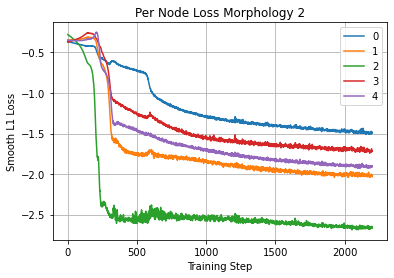


************** Batch 0 in 0.5096986293792725 **************

Training Idx 3 
Train Loss tensor([0.4388, 0.4375, 0.4350, 0.4407, 0.3431]) 
Test Loss tensor([0.4384, 0.4364, 0.4323, 0.4388, 0.3423])


************** Batch 4 in 0.473818302154541 **************

Training Idx 3 
Train Loss tensor([0.4389, 0.4382, 0.4331, 0.4396, 0.3394]) 
Test Loss tensor([0.4368, 0.4354, 0.4308, 0.4388, 0.3406])


************** Batch 8 in 0.4753556251525879 **************

Training Idx 3 
Train Loss tensor([0.4371, 0.4353, 0.4333, 0.4391, 0.3422]) 
Test Loss tensor([0.4359, 0.4340, 0.4301, 0.4385, 0.3402])


************** Batch 12 in 0.47074198722839355 **************

Training Idx 3 
Train Loss tensor([0.4354, 0.4327, 0.4308, 0.4374, 0.3418]) 
Test Loss tensor([0.4346, 0.4326, 0.4287, 0.4372, 0.3397])


************** Batch 16 in 0.4863569736480713 **************

Training Idx 3 
Train Loss tensor([0.4345, 0.4350, 0.4295, 0.4383, 0.3347]) 
Test Loss tensor([0.4331, 0.4314, 0.4270, 0.4371, 0.3384])


**


************** Batch 164 in 0.47069573402404785 **************

Training Idx 3 
Train Loss tensor([0.3819, 0.3797, 0.3819, 0.4192, 0.3179]) 
Test Loss tensor([0.3804, 0.3777, 0.3820, 0.4176, 0.3175])


************** Batch 168 in 0.47260403633117676 **************

Training Idx 3 
Train Loss tensor([0.3808, 0.3779, 0.3817, 0.4150, 0.3193]) 
Test Loss tensor([0.3791, 0.3758, 0.3799, 0.4178, 0.3151])


************** Batch 172 in 0.469954252243042 **************

Training Idx 3 
Train Loss tensor([0.3798, 0.3756, 0.3815, 0.4155, 0.3140]) 
Test Loss tensor([0.3776, 0.3739, 0.3787, 0.4161, 0.3161])


************** Batch 176 in 0.47221922874450684 **************

Training Idx 3 
Train Loss tensor([0.3791, 0.3737, 0.3792, 0.4177, 0.3136]) 
Test Loss tensor([0.3753, 0.3725, 0.3779, 0.4161, 0.3152])


************** Batch 180 in 0.4704263210296631 **************

Training Idx 3 
Train Loss tensor([0.3753, 0.3708, 0.3768, 0.4147, 0.3157]) 
Test Loss tensor([0.3738, 0.3703, 0.3762, 0.4159, 0.3


************** Batch 328 in 0.47438573837280273 **************

Training Idx 3 
Train Loss tensor([0.2968, 0.2918, 0.3111, 0.3932, 0.2843]) 
Test Loss tensor([0.2930, 0.2881, 0.3070, 0.3902, 0.2858])


************** Batch 332 in 0.4716312885284424 **************

Training Idx 3 
Train Loss tensor([0.2933, 0.2881, 0.3108, 0.3885, 0.2853]) 
Test Loss tensor([0.2904, 0.2851, 0.3046, 0.3900, 0.2860])


************** Batch 336 in 0.46985316276550293 **************

Training Idx 3 
Train Loss tensor([0.2901, 0.2859, 0.3049, 0.3880, 0.2819]) 
Test Loss tensor([0.2878, 0.2822, 0.3016, 0.3877, 0.2844])


************** Batch 340 in 0.4735560417175293 **************

Training Idx 3 
Train Loss tensor([0.2861, 0.2814, 0.3019, 0.3838, 0.2822]) 
Test Loss tensor([0.2841, 0.2786, 0.2993, 0.3874, 0.2816])


************** Batch 344 in 0.47424960136413574 **************

Training Idx 3 
Train Loss tensor([0.2832, 0.2799, 0.3010, 0.3951, 0.2805]) 
Test Loss tensor([0.2818, 0.2758, 0.2970, 0.3878, 0.


************** Batch 492 in 0.4724094867706299 **************

Training Idx 3 
Train Loss tensor([0.0724, 0.0583, 0.1245, 0.3871, 0.2717]) 
Test Loss tensor([0.0637, 0.0500, 0.1181, 0.3702, 0.2745])


************** Batch 496 in 0.47247791290283203 **************

Training Idx 3 
Train Loss tensor([0.0611, 0.0514, 0.1205, 0.3690, 0.2804]) 
Test Loss tensor([0.0562, 0.0431, 0.1149, 0.3742, 0.2765])


************** Batch 500 in 0.4706456661224365 **************

Training Idx 3 
Train Loss tensor([0.0538, 0.0466, 0.1161, 0.3774, 0.2729]) 
Test Loss tensor([0.0516, 0.0379, 0.1137, 0.3795, 0.2825])


************** Batch 504 in 0.47054028511047363 **************

Training Idx 3 
Train Loss tensor([0.0509, 0.0398, 0.1092, 0.3842, 0.2915]) 
Test Loss tensor([0.0463, 0.0331, 0.1103, 0.3798, 0.2865])


************** Batch 508 in 0.4723224639892578 **************

Training Idx 3 
Train Loss tensor([0.0505, 0.0315, 0.1210, 0.3874, 0.2862]) 
Test Loss tensor([0.0437, 0.0288, 0.1070, 0.3861, 0.2


************** Batch 656 in 0.4700019359588623 **************

Training Idx 3 
Train Loss tensor([0.0448, 0.0342, 0.1095, 0.3798, 0.2838]) 
Test Loss tensor([0.0452, 0.0326, 0.1072, 0.3820, 0.2854])


************** Batch 660 in 0.4771273136138916 **************

Training Idx 3 
Train Loss tensor([0.0504, 0.0355, 0.1141, 0.3899, 0.2852]) 
Test Loss tensor([0.0450, 0.0318, 0.1088, 0.3862, 0.2855])


************** Batch 664 in 0.4759328365325928 **************

Training Idx 3 
Train Loss tensor([0.0456, 0.0323, 0.1165, 0.3977, 0.2818]) 
Test Loss tensor([0.0454, 0.0318, 0.1093, 0.3854, 0.2868])


************** Batch 668 in 0.47281956672668457 **************

Training Idx 3 
Train Loss tensor([0.0465, 0.0344, 0.1149, 0.4067, 0.2700]) 
Test Loss tensor([0.0452, 0.0318, 0.1095, 0.3877, 0.2839])


************** Batch 672 in 0.47060275077819824 **************

Training Idx 3 
Train Loss tensor([0.0449, 0.0299, 0.1083, 0.3778, 0.2842]) 
Test Loss tensor([0.0434, 0.0321, 0.1085, 0.3848, 0.2


************** Batch 820 in 0.5048315525054932 **************

Training Idx 3 
Train Loss tensor([0.0412, 0.0304, 0.1088, 0.3971, 0.2729]) 
Test Loss tensor([0.0412, 0.0303, 0.1065, 0.3830, 0.2880])


************** Batch 824 in 0.4759833812713623 **************

Training Idx 3 
Train Loss tensor([0.0404, 0.0296, 0.1028, 0.3901, 0.2747]) 
Test Loss tensor([0.0425, 0.0305, 0.1080, 0.3860, 0.2871])


************** Batch 828 in 0.47649240493774414 **************

Training Idx 3 
Train Loss tensor([0.0418, 0.0290, 0.1060, 0.3857, 0.2797]) 
Test Loss tensor([0.0423, 0.0294, 0.1072, 0.3838, 0.2856])


************** Batch 832 in 0.47588419914245605 **************

Training Idx 3 
Train Loss tensor([0.0475, 0.0292, 0.1182, 0.3967, 0.2834]) 
Test Loss tensor([0.0408, 0.0297, 0.1042, 0.3843, 0.2891])


************** Batch 836 in 0.4737739562988281 **************

Training Idx 3 
Train Loss tensor([0.0420, 0.0319, 0.1074, 0.3912, 0.2670]) 
Test Loss tensor([0.0416, 0.0293, 0.1072, 0.3836, 0.2


************** Batch 104 in 0.4631514549255371 **************

Training Idx 3 
Train Loss tensor([0.0356, 0.0286, 0.0980, 0.3773, 0.2684]) 
Test Loss tensor([0.0403, 0.0291, 0.1064, 0.3800, 0.2774])


************** Batch 108 in 0.46649169921875 **************

Training Idx 3 
Train Loss tensor([0.0438, 0.0300, 0.1093, 0.3764, 0.2796]) 
Test Loss tensor([0.0403, 0.0298, 0.1042, 0.3747, 0.2809])


************** Batch 112 in 0.46802186965942383 **************

Training Idx 3 
Train Loss tensor([0.0408, 0.0271, 0.1003, 0.3669, 0.2778]) 
Test Loss tensor([0.0408, 0.0278, 0.1049, 0.3774, 0.2807])


************** Batch 116 in 0.4713258743286133 **************

Training Idx 3 
Train Loss tensor([0.0455, 0.0271, 0.1117, 0.3807, 0.2759]) 
Test Loss tensor([0.0391, 0.0289, 0.1067, 0.3788, 0.2806])


************** Batch 120 in 0.4695265293121338 **************

Training Idx 3 
Train Loss tensor([0.0363, 0.0237, 0.1049, 0.3849, 0.2658]) 
Test Loss tensor([0.0387, 0.0281, 0.1060, 0.3742, 0.2820


************** Batch 268 in 0.4736173152923584 **************

Training Idx 3 
Train Loss tensor([0.0252, 0.0182, 0.0927, 0.3260, 0.2186]) 
Test Loss tensor([0.0288, 0.0205, 0.0940, 0.3150, 0.2302])


************** Batch 272 in 0.468111515045166 **************

Training Idx 3 
Train Loss tensor([0.0270, 0.0203, 0.0981, 0.3046, 0.2218]) 
Test Loss tensor([0.0281, 0.0196, 0.0940, 0.3048, 0.2240])


************** Batch 276 in 0.46949052810668945 **************

Training Idx 3 
Train Loss tensor([0.0284, 0.0189, 0.0907, 0.3023, 0.2208]) 
Test Loss tensor([0.0273, 0.0188, 0.0927, 0.3052, 0.2186])


************** Batch 280 in 0.46802210807800293 **************

Training Idx 3 
Train Loss tensor([0.0267, 0.0205, 0.0955, 0.2999, 0.2158]) 
Test Loss tensor([0.0261, 0.0186, 0.0923, 0.2965, 0.2114])


************** Batch 284 in 0.47199010848999023 **************

Training Idx 3 
Train Loss tensor([0.0288, 0.0165, 0.0910, 0.3002, 0.2059]) 
Test Loss tensor([0.0252, 0.0184, 0.0923, 0.2921, 0.2


************** Batch 432 in 0.4689610004425049 **************

Training Idx 3 
Train Loss tensor([0.0167, 0.0158, 0.0731, 0.1421, 0.1072]) 
Test Loss tensor([0.0151, 0.0133, 0.0666, 0.1387, 0.1053])


************** Batch 436 in 0.4720151424407959 **************

Training Idx 3 
Train Loss tensor([0.0158, 0.0129, 0.0687, 0.1405, 0.1033]) 
Test Loss tensor([0.0150, 0.0143, 0.0666, 0.1373, 0.1044])


************** Batch 440 in 0.47539782524108887 **************

Training Idx 3 
Train Loss tensor([0.0147, 0.0130, 0.0677, 0.1360, 0.1019]) 
Test Loss tensor([0.0144, 0.0135, 0.0678, 0.1339, 0.1013])


************** Batch 444 in 0.4775412082672119 **************

Training Idx 3 
Train Loss tensor([0.0144, 0.0139, 0.0716, 0.1419, 0.1038]) 
Test Loss tensor([0.0145, 0.0133, 0.0673, 0.1330, 0.1004])


************** Batch 448 in 0.4785733222961426 **************

Training Idx 3 
Train Loss tensor([0.0131, 0.0150, 0.0679, 0.1348, 0.0994]) 
Test Loss tensor([0.0144, 0.0132, 0.0660, 0.1307, 0.09


************** Batch 596 in 0.47241878509521484 **************

Training Idx 3 
Train Loss tensor([0.0106, 0.0175, 0.0584, 0.0322, 0.0525]) 
Test Loss tensor([0.0108, 0.0134, 0.0626, 0.0311, 0.0519])


************** Batch 600 in 0.47109007835388184 **************

Training Idx 3 
Train Loss tensor([0.0110, 0.0162, 0.0583, 0.0319, 0.0528]) 
Test Loss tensor([0.0112, 0.0145, 0.0606, 0.0308, 0.0526])


************** Batch 604 in 0.475632905960083 **************

Training Idx 3 
Train Loss tensor([0.0127, 0.0133, 0.0658, 0.0299, 0.0496]) 
Test Loss tensor([0.0110, 0.0143, 0.0599, 0.0301, 0.0522])


************** Batch 608 in 0.47339534759521484 **************

Training Idx 3 
Train Loss tensor([0.0112, 0.0166, 0.0603, 0.0295, 0.0533]) 
Test Loss tensor([0.0110, 0.0144, 0.0606, 0.0292, 0.0537])


************** Batch 612 in 0.4723362922668457 **************

Training Idx 3 
Train Loss tensor([0.0132, 0.0188, 0.0654, 0.0312, 0.0532]) 
Test Loss tensor([0.0113, 0.0147, 0.0610, 0.0291, 0.0


************** Batch 760 in 0.46939945220947266 **************

Training Idx 3 
Train Loss tensor([0.0093, 0.0116, 0.0567, 0.0278, 0.0452]) 
Test Loss tensor([0.0096, 0.0127, 0.0535, 0.0275, 0.0476])


************** Batch 764 in 0.47106432914733887 **************

Training Idx 3 
Train Loss tensor([0.0093, 0.0121, 0.0550, 0.0291, 0.0489]) 
Test Loss tensor([0.0095, 0.0126, 0.0534, 0.0262, 0.0481])


************** Batch 768 in 0.4688243865966797 **************

Training Idx 3 
Train Loss tensor([0.0115, 0.0133, 0.0545, 0.0277, 0.0474]) 
Test Loss tensor([0.0098, 0.0122, 0.0524, 0.0274, 0.0478])


************** Batch 772 in 0.4704890251159668 **************

Training Idx 3 
Train Loss tensor([0.0109, 0.0148, 0.0530, 0.0254, 0.0484]) 
Test Loss tensor([0.0100, 0.0128, 0.0534, 0.0274, 0.0472])


************** Batch 776 in 0.47129273414611816 **************

Training Idx 3 
Train Loss tensor([0.0082, 0.0130, 0.0566, 0.0275, 0.0493]) 
Test Loss tensor([0.0096, 0.0119, 0.0523, 0.0275, 0.


************** Batch 44 in 0.4716928005218506 **************

Training Idx 3 
Train Loss tensor([0.0058, 0.0095, 0.0511, 0.0227, 0.0457]) 
Test Loss tensor([0.0072, 0.0116, 0.0501, 0.0233, 0.0469])


************** Batch 48 in 0.47220849990844727 **************

Training Idx 3 
Train Loss tensor([0.0077, 0.0107, 0.0570, 0.0245, 0.0486]) 
Test Loss tensor([0.0068, 0.0106, 0.0477, 0.0230, 0.0462])


************** Batch 52 in 0.47149062156677246 **************

Training Idx 3 
Train Loss tensor([0.0081, 0.0081, 0.0474, 0.0255, 0.0477]) 
Test Loss tensor([0.0066, 0.0107, 0.0528, 0.0237, 0.0469])


************** Batch 56 in 0.46984100341796875 **************

Training Idx 3 
Train Loss tensor([0.0062, 0.0130, 0.0467, 0.0240, 0.0484]) 
Test Loss tensor([0.0067, 0.0108, 0.0513, 0.0231, 0.0458])


************** Batch 60 in 0.47228431701660156 **************

Training Idx 3 
Train Loss tensor([0.0059, 0.0102, 0.0494, 0.0228, 0.0472]) 
Test Loss tensor([0.0068, 0.0109, 0.0492, 0.0226, 0.0467


************** Batch 208 in 0.47066521644592285 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0110, 0.0466, 0.0204, 0.0435]) 
Test Loss tensor([0.0062, 0.0106, 0.0463, 0.0222, 0.0444])


************** Batch 212 in 0.470597505569458 **************

Training Idx 3 
Train Loss tensor([0.0053, 0.0110, 0.0476, 0.0229, 0.0435]) 
Test Loss tensor([0.0061, 0.0097, 0.0470, 0.0220, 0.0441])


************** Batch 216 in 0.4716958999633789 **************

Training Idx 3 
Train Loss tensor([0.0065, 0.0087, 0.0462, 0.0266, 0.0447]) 
Test Loss tensor([0.0061, 0.0100, 0.0471, 0.0218, 0.0437])


************** Batch 220 in 0.469179630279541 **************

Training Idx 3 
Train Loss tensor([0.0064, 0.0121, 0.0448, 0.0246, 0.0433]) 
Test Loss tensor([0.0055, 0.0103, 0.0458, 0.0229, 0.0439])


************** Batch 224 in 0.4820983409881592 **************

Training Idx 3 
Train Loss tensor([0.0065, 0.0132, 0.0476, 0.0197, 0.0455]) 
Test Loss tensor([0.0057, 0.0104, 0.0459, 0.0224, 0.0449


************** Batch 372 in 0.4766826629638672 **************

Training Idx 3 
Train Loss tensor([0.0058, 0.0103, 0.0421, 0.0244, 0.0429]) 
Test Loss tensor([0.0054, 0.0090, 0.0436, 0.0220, 0.0422])


************** Batch 376 in 0.4736521244049072 **************

Training Idx 3 
Train Loss tensor([0.0062, 0.0086, 0.0431, 0.0203, 0.0405]) 
Test Loss tensor([0.0059, 0.0096, 0.0427, 0.0218, 0.0426])


************** Batch 380 in 0.4728407859802246 **************

Training Idx 3 
Train Loss tensor([0.0069, 0.0105, 0.0464, 0.0230, 0.0432]) 
Test Loss tensor([0.0059, 0.0092, 0.0443, 0.0219, 0.0422])


************** Batch 384 in 0.47231101989746094 **************

Training Idx 3 
Train Loss tensor([0.0061, 0.0101, 0.0390, 0.0237, 0.0429]) 
Test Loss tensor([0.0059, 0.0091, 0.0438, 0.0223, 0.0427])


************** Batch 388 in 0.4754769802093506 **************

Training Idx 3 
Train Loss tensor([0.0058, 0.0091, 0.0425, 0.0220, 0.0412]) 
Test Loss tensor([0.0054, 0.0091, 0.0428, 0.0214, 0.04


************** Batch 536 in 0.47263073921203613 **************

Training Idx 3 
Train Loss tensor([0.0063, 0.0082, 0.0394, 0.0200, 0.0388]) 
Test Loss tensor([0.0055, 0.0076, 0.0397, 0.0203, 0.0412])


************** Batch 540 in 0.4714810848236084 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0057, 0.0359, 0.0206, 0.0411]) 
Test Loss tensor([0.0052, 0.0082, 0.0413, 0.0213, 0.0410])


************** Batch 544 in 0.47126054763793945 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0091, 0.0340, 0.0209, 0.0416]) 
Test Loss tensor([0.0054, 0.0086, 0.0407, 0.0213, 0.0411])


************** Batch 548 in 0.4689040184020996 **************

Training Idx 3 
Train Loss tensor([0.0057, 0.0055, 0.0355, 0.0214, 0.0416]) 
Test Loss tensor([0.0051, 0.0081, 0.0408, 0.0208, 0.0405])


************** Batch 552 in 0.4720592498779297 **************

Training Idx 3 
Train Loss tensor([0.0070, 0.0072, 0.0386, 0.0189, 0.0417]) 
Test Loss tensor([0.0053, 0.0091, 0.0393, 0.0209, 0.0


************** Batch 700 in 0.47098207473754883 **************

Training Idx 3 
Train Loss tensor([0.0053, 0.0079, 0.0357, 0.0207, 0.0402]) 
Test Loss tensor([0.0049, 0.0077, 0.0390, 0.0199, 0.0399])


************** Batch 704 in 0.4795217514038086 **************

Training Idx 3 
Train Loss tensor([0.0065, 0.0090, 0.0332, 0.0214, 0.0413]) 
Test Loss tensor([0.0052, 0.0075, 0.0378, 0.0203, 0.0390])


************** Batch 708 in 0.4735424518585205 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0077, 0.0392, 0.0211, 0.0393]) 
Test Loss tensor([0.0048, 0.0076, 0.0376, 0.0208, 0.0390])


************** Batch 712 in 0.47603726387023926 **************

Training Idx 3 
Train Loss tensor([0.0061, 0.0080, 0.0346, 0.0204, 0.0405]) 
Test Loss tensor([0.0047, 0.0076, 0.0395, 0.0209, 0.0392])


************** Batch 716 in 0.4772200584411621 **************

Training Idx 3 
Train Loss tensor([0.0057, 0.0085, 0.0400, 0.0216, 0.0380]) 
Test Loss tensor([0.0049, 0.0080, 0.0382, 0.0210, 0.0


************** Batch 864 in 0.47242116928100586 **************

Training Idx 3 
Train Loss tensor([0.0039, 0.0070, 0.0401, 0.0253, 0.0397]) 
Test Loss tensor([0.0048, 0.0069, 0.0371, 0.0208, 0.0386])


************** Batch 868 in 0.4678955078125 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0070, 0.0317, 0.0195, 0.0378]) 
Test Loss tensor([0.0046, 0.0067, 0.0366, 0.0210, 0.0376])


************** Batch 872 in 0.47206759452819824 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0064, 0.0348, 0.0209, 0.0392]) 
Test Loss tensor([0.0050, 0.0069, 0.0361, 0.0212, 0.0380])


************** Batch 876 in 0.4521796703338623 **************

Training Idx 3 
Train Loss tensor([0.0025, 0.0063, 0.0255, 0.0169, 0.0307]) 
Test Loss tensor([0.0046, 0.0074, 0.0368, 0.0212, 0.0380])


************** Batch 0 in 0.507819652557373 **************

Training Idx 3 
Train Loss tensor([0.0044, 0.0068, 0.0354, 0.0218, 0.0397]) 
Test Loss tensor([0.0047, 0.0069, 0.0355, 0.0202, 0.0381])



************** Batch 148 in 0.4707636833190918 **************

Training Idx 3 
Train Loss tensor([0.0053, 0.0065, 0.0323, 0.0198, 0.0373]) 
Test Loss tensor([0.0046, 0.0065, 0.0366, 0.0199, 0.0385])


************** Batch 152 in 0.4744272232055664 **************

Training Idx 3 
Train Loss tensor([0.0054, 0.0067, 0.0365, 0.0196, 0.0388]) 
Test Loss tensor([0.0044, 0.0065, 0.0353, 0.0192, 0.0379])


************** Batch 156 in 0.4708845615386963 **************

Training Idx 3 
Train Loss tensor([0.0057, 0.0052, 0.0377, 0.0201, 0.0396]) 
Test Loss tensor([0.0045, 0.0061, 0.0357, 0.0195, 0.0383])


************** Batch 160 in 0.4709022045135498 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0072, 0.0340, 0.0198, 0.0392]) 
Test Loss tensor([0.0044, 0.0065, 0.0351, 0.0200, 0.0379])


************** Batch 164 in 0.4696390628814697 **************

Training Idx 3 
Train Loss tensor([0.0052, 0.0047, 0.0318, 0.0205, 0.0362]) 
Test Loss tensor([0.0048, 0.0062, 0.0344, 0.0199, 0.037


************** Batch 312 in 0.4731252193450928 **************

Training Idx 3 
Train Loss tensor([0.0039, 0.0054, 0.0355, 0.0206, 0.0378]) 
Test Loss tensor([0.0046, 0.0053, 0.0345, 0.0181, 0.0367])


************** Batch 316 in 0.4724395275115967 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0044, 0.0356, 0.0185, 0.0358]) 
Test Loss tensor([0.0051, 0.0057, 0.0322, 0.0188, 0.0366])


************** Batch 320 in 0.4738779067993164 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0058, 0.0333, 0.0201, 0.0392]) 
Test Loss tensor([0.0043, 0.0054, 0.0326, 0.0194, 0.0358])


************** Batch 324 in 0.47278904914855957 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0059, 0.0309, 0.0200, 0.0382]) 
Test Loss tensor([0.0044, 0.0058, 0.0338, 0.0203, 0.0359])


************** Batch 328 in 0.4748537540435791 **************

Training Idx 3 
Train Loss tensor([0.0044, 0.0068, 0.0354, 0.0186, 0.0353]) 
Test Loss tensor([0.0048, 0.0056, 0.0319, 0.0201, 0.03


************** Batch 476 in 0.4714937210083008 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0038, 0.0336, 0.0185, 0.0347]) 
Test Loss tensor([0.0043, 0.0053, 0.0305, 0.0184, 0.0361])


************** Batch 480 in 0.4703795909881592 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0048, 0.0304, 0.0142, 0.0358]) 
Test Loss tensor([0.0044, 0.0050, 0.0302, 0.0181, 0.0355])


************** Batch 484 in 0.4707190990447998 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0063, 0.0307, 0.0196, 0.0362]) 
Test Loss tensor([0.0044, 0.0051, 0.0297, 0.0188, 0.0355])


************** Batch 488 in 0.4705500602722168 **************

Training Idx 3 
Train Loss tensor([0.0055, 0.0047, 0.0324, 0.0192, 0.0343]) 
Test Loss tensor([0.0043, 0.0053, 0.0315, 0.0185, 0.0358])


************** Batch 492 in 0.47118449211120605 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0058, 0.0276, 0.0203, 0.0357]) 
Test Loss tensor([0.0045, 0.0048, 0.0301, 0.0182, 0.03


************** Batch 640 in 0.47194480895996094 **************

Training Idx 3 
Train Loss tensor([0.0046, 0.0039, 0.0280, 0.0175, 0.0373]) 
Test Loss tensor([0.0050, 0.0043, 0.0290, 0.0168, 0.0351])


************** Batch 644 in 0.469348669052124 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0044, 0.0249, 0.0150, 0.0336]) 
Test Loss tensor([0.0047, 0.0044, 0.0281, 0.0174, 0.0347])


************** Batch 648 in 0.47538113594055176 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0056, 0.0277, 0.0182, 0.0349]) 
Test Loss tensor([0.0047, 0.0045, 0.0285, 0.0175, 0.0352])


************** Batch 652 in 0.46907615661621094 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0051, 0.0301, 0.0201, 0.0348]) 
Test Loss tensor([0.0045, 0.0046, 0.0282, 0.0167, 0.0350])


************** Batch 656 in 0.4728546142578125 **************

Training Idx 3 
Train Loss tensor([0.0033, 0.0056, 0.0258, 0.0183, 0.0385]) 
Test Loss tensor([0.0046, 0.0046, 0.0285, 0.0167, 0.0


************** Batch 804 in 0.4719510078430176 **************

Training Idx 3 
Train Loss tensor([0.0039, 0.0039, 0.0245, 0.0161, 0.0347]) 
Test Loss tensor([0.0043, 0.0044, 0.0250, 0.0177, 0.0341])


************** Batch 808 in 0.4709596633911133 **************

Training Idx 3 
Train Loss tensor([0.0033, 0.0040, 0.0243, 0.0168, 0.0311]) 
Test Loss tensor([0.0044, 0.0049, 0.0258, 0.0179, 0.0336])


************** Batch 812 in 0.47263336181640625 **************

Training Idx 3 
Train Loss tensor([0.0052, 0.0043, 0.0251, 0.0188, 0.0323]) 
Test Loss tensor([0.0042, 0.0047, 0.0239, 0.0176, 0.0331])


************** Batch 816 in 0.4682743549346924 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0051, 0.0274, 0.0170, 0.0337]) 
Test Loss tensor([0.0045, 0.0048, 0.0249, 0.0168, 0.0343])


************** Batch 820 in 0.47000694274902344 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0049, 0.0230, 0.0140, 0.0329]) 
Test Loss tensor([0.0045, 0.0044, 0.0257, 0.0174, 0.0


************** Batch 88 in 0.47083258628845215 **************

Training Idx 3 
Train Loss tensor([0.0058, 0.0042, 0.0257, 0.0181, 0.0337]) 
Test Loss tensor([0.0044, 0.0042, 0.0238, 0.0169, 0.0327])


************** Batch 92 in 0.46910953521728516 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0040, 0.0207, 0.0176, 0.0335]) 
Test Loss tensor([0.0040, 0.0046, 0.0235, 0.0165, 0.0325])


************** Batch 96 in 0.4712810516357422 **************

Training Idx 3 
Train Loss tensor([0.0026, 0.0042, 0.0228, 0.0158, 0.0325]) 
Test Loss tensor([0.0047, 0.0046, 0.0225, 0.0165, 0.0328])


************** Batch 100 in 0.47382378578186035 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0043, 0.0228, 0.0159, 0.0307]) 
Test Loss tensor([0.0043, 0.0045, 0.0243, 0.0173, 0.0336])


************** Batch 104 in 0.47112011909484863 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0039, 0.0257, 0.0169, 0.0354]) 
Test Loss tensor([0.0044, 0.0045, 0.0233, 0.0165, 0.03


************** Batch 252 in 0.48741745948791504 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0043, 0.0192, 0.0180, 0.0322]) 
Test Loss tensor([0.0046, 0.0044, 0.0209, 0.0161, 0.0315])


************** Batch 256 in 0.48060011863708496 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0049, 0.0220, 0.0155, 0.0313]) 
Test Loss tensor([0.0044, 0.0045, 0.0209, 0.0165, 0.0314])


************** Batch 260 in 0.6416149139404297 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0046, 0.0204, 0.0178, 0.0339]) 
Test Loss tensor([0.0043, 0.0045, 0.0217, 0.0170, 0.0316])


************** Batch 264 in 0.6301281452178955 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0040, 0.0235, 0.0170, 0.0312]) 
Test Loss tensor([0.0044, 0.0046, 0.0225, 0.0172, 0.0319])


************** Batch 268 in 0.5450925827026367 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0042, 0.0214, 0.0164, 0.0315]) 
Test Loss tensor([0.0047, 0.0040, 0.0221, 0.0166, 0.0


************** Batch 416 in 0.6019251346588135 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0044, 0.0209, 0.0179, 0.0305]) 
Test Loss tensor([0.0046, 0.0042, 0.0211, 0.0166, 0.0299])


************** Batch 420 in 0.5597288608551025 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0046, 0.0199, 0.0156, 0.0299]) 
Test Loss tensor([0.0046, 0.0042, 0.0215, 0.0161, 0.0302])


************** Batch 424 in 0.5886111259460449 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0039, 0.0194, 0.0172, 0.0296]) 
Test Loss tensor([0.0044, 0.0041, 0.0211, 0.0162, 0.0305])


************** Batch 428 in 0.5689735412597656 **************

Training Idx 3 
Train Loss tensor([0.0044, 0.0041, 0.0182, 0.0174, 0.0306]) 
Test Loss tensor([0.0045, 0.0041, 0.0213, 0.0158, 0.0306])


************** Batch 432 in 0.58835768699646 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0038, 0.0185, 0.0160, 0.0283]) 
Test Loss tensor([0.0044, 0.0040, 0.0204, 0.0164, 0.0308]


************** Batch 580 in 0.5700838565826416 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0037, 0.0196, 0.0156, 0.0290]) 
Test Loss tensor([0.0044, 0.0041, 0.0198, 0.0161, 0.0292])


************** Batch 584 in 0.5005843639373779 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0046, 0.0192, 0.0150, 0.0288]) 
Test Loss tensor([0.0045, 0.0040, 0.0196, 0.0162, 0.0292])


************** Batch 588 in 0.5072245597839355 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0037, 0.0196, 0.0160, 0.0290]) 
Test Loss tensor([0.0039, 0.0042, 0.0199, 0.0169, 0.0289])


************** Batch 592 in 0.5424740314483643 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0042, 0.0201, 0.0190, 0.0280]) 
Test Loss tensor([0.0044, 0.0043, 0.0205, 0.0160, 0.0295])


************** Batch 596 in 0.49741530418395996 **************

Training Idx 3 
Train Loss tensor([0.0046, 0.0039, 0.0205, 0.0165, 0.0295]) 
Test Loss tensor([0.0046, 0.0040, 0.0199, 0.0160, 0.02


************** Batch 744 in 0.4916980266571045 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0047, 0.0183, 0.0174, 0.0284]) 
Test Loss tensor([0.0045, 0.0043, 0.0188, 0.0164, 0.0281])


************** Batch 748 in 0.6900339126586914 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0035, 0.0184, 0.0164, 0.0263]) 
Test Loss tensor([0.0047, 0.0039, 0.0182, 0.0152, 0.0283])


************** Batch 752 in 0.5785584449768066 **************

Training Idx 3 
Train Loss tensor([0.0053, 0.0043, 0.0211, 0.0166, 0.0283]) 
Test Loss tensor([0.0044, 0.0040, 0.0184, 0.0164, 0.0282])


************** Batch 756 in 0.6894509792327881 **************

Training Idx 3 
Train Loss tensor([0.0050, 0.0034, 0.0171, 0.0142, 0.0282]) 
Test Loss tensor([0.0043, 0.0041, 0.0192, 0.0161, 0.0283])


************** Batch 760 in 0.5590255260467529 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0038, 0.0183, 0.0149, 0.0284]) 
Test Loss tensor([0.0043, 0.0042, 0.0181, 0.0159, 0.028


************** Batch 28 in 0.4709961414337158 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0030, 0.0172, 0.0155, 0.0274]) 
Test Loss tensor([0.0045, 0.0040, 0.0178, 0.0161, 0.0273])


************** Batch 32 in 0.46978092193603516 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0037, 0.0174, 0.0175, 0.0279]) 
Test Loss tensor([0.0043, 0.0040, 0.0192, 0.0158, 0.0268])


************** Batch 36 in 0.4715454578399658 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0034, 0.0178, 0.0143, 0.0278]) 
Test Loss tensor([0.0044, 0.0041, 0.0182, 0.0158, 0.0276])


************** Batch 40 in 0.4688565731048584 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0045, 0.0187, 0.0159, 0.0269]) 
Test Loss tensor([0.0044, 0.0040, 0.0190, 0.0157, 0.0270])


************** Batch 44 in 0.47067809104919434 **************

Training Idx 3 
Train Loss tensor([0.0052, 0.0036, 0.0172, 0.0174, 0.0281]) 
Test Loss tensor([0.0044, 0.0040, 0.0191, 0.0156, 0.0270])


************** Batch 192 in 0.5395452976226807 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0048, 0.0174, 0.0142, 0.0268]) 
Test Loss tensor([0.0042, 0.0042, 0.0178, 0.0152, 0.0262])


************** Batch 196 in 0.5336377620697021 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0039, 0.0181, 0.0145, 0.0277]) 
Test Loss tensor([0.0046, 0.0041, 0.0183, 0.0151, 0.0262])


************** Batch 200 in 0.5455405712127686 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0040, 0.0202, 0.0163, 0.0268]) 
Test Loss tensor([0.0044, 0.0039, 0.0188, 0.0160, 0.0270])


************** Batch 204 in 0.5193431377410889 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0042, 0.0181, 0.0141, 0.0252]) 
Test Loss tensor([0.0042, 0.0039, 0.0180, 0.0156, 0.0267])


************** Batch 208 in 0.5026147365570068 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0037, 0.0172, 0.0202, 0.0248]) 
Test Loss tensor([0.0042, 0.0041, 0.0177, 0.0157, 0.026


************** Batch 356 in 0.5814571380615234 **************

Training Idx 3 
Train Loss tensor([0.0057, 0.0040, 0.0189, 0.0157, 0.0264]) 
Test Loss tensor([0.0039, 0.0040, 0.0173, 0.0155, 0.0260])


************** Batch 360 in 0.5453076362609863 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0035, 0.0177, 0.0145, 0.0272]) 
Test Loss tensor([0.0043, 0.0038, 0.0169, 0.0157, 0.0264])


************** Batch 364 in 0.5433821678161621 **************

Training Idx 3 
Train Loss tensor([0.0052, 0.0038, 0.0148, 0.0139, 0.0261]) 
Test Loss tensor([0.0045, 0.0041, 0.0172, 0.0151, 0.0257])


************** Batch 368 in 0.49172449111938477 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0043, 0.0156, 0.0143, 0.0254]) 
Test Loss tensor([0.0044, 0.0039, 0.0172, 0.0149, 0.0259])


************** Batch 372 in 0.49768662452697754 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0048, 0.0179, 0.0129, 0.0261]) 
Test Loss tensor([0.0043, 0.0039, 0.0169, 0.0152, 0.0


************** Batch 520 in 0.5308506488800049 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0043, 0.0148, 0.0157, 0.0242]) 
Test Loss tensor([0.0043, 0.0040, 0.0163, 0.0153, 0.0252])


************** Batch 524 in 0.5544338226318359 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0041, 0.0153, 0.0157, 0.0240]) 
Test Loss tensor([0.0041, 0.0040, 0.0161, 0.0155, 0.0253])


************** Batch 528 in 0.5779533386230469 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0043, 0.0145, 0.0152, 0.0240]) 
Test Loss tensor([0.0041, 0.0039, 0.0163, 0.0157, 0.0252])


************** Batch 532 in 0.5045278072357178 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0038, 0.0128, 0.0150, 0.0249]) 
Test Loss tensor([0.0044, 0.0039, 0.0168, 0.0149, 0.0246])


************** Batch 536 in 0.4965226650238037 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0039, 0.0160, 0.0137, 0.0246]) 
Test Loss tensor([0.0041, 0.0039, 0.0161, 0.0154, 0.024


************** Batch 684 in 0.6058745384216309 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0038, 0.0182, 0.0131, 0.0245]) 
Test Loss tensor([0.0040, 0.0040, 0.0160, 0.0151, 0.0242])


************** Batch 688 in 0.5606086254119873 **************

Training Idx 3 
Train Loss tensor([0.0051, 0.0039, 0.0140, 0.0173, 0.0237]) 
Test Loss tensor([0.0041, 0.0039, 0.0154, 0.0144, 0.0245])


************** Batch 692 in 0.5368657112121582 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0046, 0.0145, 0.0183, 0.0243]) 
Test Loss tensor([0.0039, 0.0038, 0.0159, 0.0151, 0.0239])


************** Batch 696 in 0.5456554889678955 **************

Training Idx 3 
Train Loss tensor([0.0033, 0.0037, 0.0194, 0.0169, 0.0229]) 
Test Loss tensor([0.0041, 0.0041, 0.0160, 0.0151, 0.0241])


************** Batch 700 in 0.5815436840057373 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0040, 0.0166, 0.0165, 0.0257]) 
Test Loss tensor([0.0042, 0.0040, 0.0154, 0.0150, 0.024


************** Batch 848 in 0.5521321296691895 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0038, 0.0153, 0.0180, 0.0229]) 
Test Loss tensor([0.0040, 0.0040, 0.0153, 0.0150, 0.0240])


************** Batch 852 in 0.5276668071746826 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0045, 0.0147, 0.0159, 0.0237]) 
Test Loss tensor([0.0040, 0.0040, 0.0150, 0.0152, 0.0234])


************** Batch 856 in 0.5895285606384277 **************

Training Idx 3 
Train Loss tensor([0.0046, 0.0037, 0.0158, 0.0158, 0.0240]) 
Test Loss tensor([0.0043, 0.0040, 0.0152, 0.0149, 0.0235])


************** Batch 860 in 0.5522148609161377 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0040, 0.0149, 0.0172, 0.0233]) 
Test Loss tensor([0.0040, 0.0039, 0.0150, 0.0150, 0.0238])


************** Batch 864 in 0.5816996097564697 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0038, 0.0136, 0.0149, 0.0227]) 
Test Loss tensor([0.0045, 0.0038, 0.0154, 0.0146, 0.023


************** Batch 132 in 0.6470053195953369 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0040, 0.0165, 0.0143, 0.0250]) 
Test Loss tensor([0.0042, 0.0039, 0.0149, 0.0149, 0.0231])


************** Batch 136 in 0.5717477798461914 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0034, 0.0124, 0.0136, 0.0227]) 
Test Loss tensor([0.0040, 0.0040, 0.0146, 0.0154, 0.0229])


************** Batch 140 in 0.587226390838623 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0040, 0.0143, 0.0140, 0.0220]) 
Test Loss tensor([0.0040, 0.0040, 0.0152, 0.0152, 0.0233])


************** Batch 144 in 0.5743732452392578 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0039, 0.0147, 0.0126, 0.0218]) 
Test Loss tensor([0.0042, 0.0040, 0.0156, 0.0149, 0.0232])


************** Batch 148 in 0.6078376770019531 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0047, 0.0155, 0.0136, 0.0237]) 
Test Loss tensor([0.0039, 0.0041, 0.0150, 0.0145, 0.0228


************** Batch 296 in 0.5438940525054932 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0037, 0.0141, 0.0159, 0.0216]) 
Test Loss tensor([0.0040, 0.0037, 0.0151, 0.0146, 0.0228])


************** Batch 300 in 0.5327517986297607 **************

Training Idx 3 
Train Loss tensor([0.0055, 0.0035, 0.0159, 0.0145, 0.0223]) 
Test Loss tensor([0.0042, 0.0038, 0.0153, 0.0144, 0.0227])


************** Batch 304 in 0.5420305728912354 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0037, 0.0140, 0.0148, 0.0229]) 
Test Loss tensor([0.0041, 0.0040, 0.0153, 0.0146, 0.0223])


************** Batch 308 in 0.5298974514007568 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0039, 0.0158, 0.0172, 0.0239]) 
Test Loss tensor([0.0042, 0.0040, 0.0154, 0.0145, 0.0224])


************** Batch 312 in 0.5111980438232422 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0043, 0.0140, 0.0149, 0.0220]) 
Test Loss tensor([0.0040, 0.0040, 0.0147, 0.0145, 0.022


************** Batch 460 in 0.48783445358276367 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0036, 0.0116, 0.0168, 0.0218]) 
Test Loss tensor([0.0043, 0.0040, 0.0142, 0.0149, 0.0217])


************** Batch 464 in 0.47577667236328125 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0035, 0.0123, 0.0131, 0.0216]) 
Test Loss tensor([0.0043, 0.0038, 0.0146, 0.0141, 0.0218])


************** Batch 468 in 0.47542500495910645 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0038, 0.0141, 0.0151, 0.0215]) 
Test Loss tensor([0.0040, 0.0039, 0.0150, 0.0144, 0.0220])


************** Batch 472 in 0.4744846820831299 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0035, 0.0122, 0.0121, 0.0225]) 
Test Loss tensor([0.0043, 0.0041, 0.0149, 0.0149, 0.0217])


************** Batch 476 in 0.475482702255249 **************

Training Idx 3 
Train Loss tensor([0.0035, 0.0033, 0.0127, 0.0142, 0.0222]) 
Test Loss tensor([0.0040, 0.0039, 0.0141, 0.0149, 0.0


************** Batch 624 in 0.4971950054168701 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0037, 0.0153, 0.0144, 0.0212]) 
Test Loss tensor([0.0042, 0.0039, 0.0138, 0.0144, 0.0216])


************** Batch 628 in 0.47847795486450195 **************

Training Idx 3 
Train Loss tensor([0.0046, 0.0035, 0.0140, 0.0139, 0.0215]) 
Test Loss tensor([0.0039, 0.0039, 0.0137, 0.0145, 0.0214])


************** Batch 632 in 0.4786818027496338 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0033, 0.0124, 0.0129, 0.0220]) 
Test Loss tensor([0.0042, 0.0037, 0.0142, 0.0143, 0.0214])


************** Batch 636 in 0.4769260883331299 **************

Training Idx 3 
Train Loss tensor([0.0052, 0.0039, 0.0141, 0.0146, 0.0208]) 
Test Loss tensor([0.0040, 0.0039, 0.0133, 0.0145, 0.0215])


************** Batch 640 in 0.48016858100891113 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0038, 0.0150, 0.0154, 0.0213]) 
Test Loss tensor([0.0040, 0.0038, 0.0134, 0.0151, 0.0


************** Batch 788 in 0.5341935157775879 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0039, 0.0135, 0.0139, 0.0193]) 
Test Loss tensor([0.0040, 0.0038, 0.0135, 0.0138, 0.0207])


************** Batch 792 in 0.480440616607666 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0039, 0.0127, 0.0130, 0.0205]) 
Test Loss tensor([0.0041, 0.0039, 0.0141, 0.0138, 0.0209])


************** Batch 796 in 0.473543643951416 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0029, 0.0133, 0.0145, 0.0207]) 
Test Loss tensor([0.0045, 0.0039, 0.0131, 0.0150, 0.0208])


************** Batch 800 in 0.4709041118621826 **************

Training Idx 3 
Train Loss tensor([0.0049, 0.0045, 0.0133, 0.0148, 0.0193]) 
Test Loss tensor([0.0038, 0.0038, 0.0138, 0.0137, 0.0207])


************** Batch 804 in 0.5046930313110352 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0037, 0.0140, 0.0127, 0.0202]) 
Test Loss tensor([0.0041, 0.0038, 0.0136, 0.0140, 0.0211]


************** Batch 72 in 0.5393874645233154 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0034, 0.0151, 0.0135, 0.0195]) 
Test Loss tensor([0.0039, 0.0037, 0.0129, 0.0139, 0.0206])


************** Batch 76 in 0.4869384765625 **************

Training Idx 3 
Train Loss tensor([0.0035, 0.0038, 0.0121, 0.0135, 0.0207]) 
Test Loss tensor([0.0040, 0.0037, 0.0148, 0.0138, 0.0210])


************** Batch 80 in 0.5236721038818359 **************

Training Idx 3 
Train Loss tensor([0.0033, 0.0034, 0.0148, 0.0137, 0.0199]) 
Test Loss tensor([0.0039, 0.0036, 0.0141, 0.0139, 0.0207])


************** Batch 84 in 0.6543467044830322 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0032, 0.0124, 0.0150, 0.0206]) 
Test Loss tensor([0.0040, 0.0035, 0.0135, 0.0138, 0.0205])


************** Batch 88 in 0.5211935043334961 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0034, 0.0121, 0.0144, 0.0203]) 
Test Loss tensor([0.0040, 0.0035, 0.0145, 0.0140, 0.0204])


**


************** Batch 236 in 0.7574491500854492 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0034, 0.0120, 0.0122, 0.0200]) 
Test Loss tensor([0.0041, 0.0037, 0.0126, 0.0139, 0.0205])


************** Batch 240 in 0.7772767543792725 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0038, 0.0135, 0.0136, 0.0201]) 
Test Loss tensor([0.0042, 0.0037, 0.0129, 0.0130, 0.0199])


************** Batch 244 in 0.7155873775482178 **************

Training Idx 3 
Train Loss tensor([0.0030, 0.0033, 0.0138, 0.0138, 0.0210]) 
Test Loss tensor([0.0037, 0.0038, 0.0128, 0.0135, 0.0201])


************** Batch 248 in 0.7171499729156494 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0037, 0.0136, 0.0138, 0.0199]) 
Test Loss tensor([0.0038, 0.0036, 0.0125, 0.0136, 0.0205])


************** Batch 252 in 0.6184396743774414 **************

Training Idx 3 
Train Loss tensor([0.0047, 0.0034, 0.0136, 0.0130, 0.0210]) 
Test Loss tensor([0.0037, 0.0037, 0.0129, 0.0138, 0.020


************** Batch 400 in 0.5545039176940918 **************

Training Idx 3 
Train Loss tensor([0.0039, 0.0040, 0.0126, 0.0135, 0.0201]) 
Test Loss tensor([0.0038, 0.0037, 0.0137, 0.0138, 0.0207])


************** Batch 404 in 0.5033972263336182 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0037, 0.0143, 0.0163, 0.0212]) 
Test Loss tensor([0.0039, 0.0035, 0.0124, 0.0132, 0.0205])


************** Batch 408 in 0.5915451049804688 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0030, 0.0117, 0.0128, 0.0209]) 
Test Loss tensor([0.0038, 0.0037, 0.0122, 0.0136, 0.0199])


************** Batch 412 in 0.5907573699951172 **************

Training Idx 3 
Train Loss tensor([0.0044, 0.0036, 0.0131, 0.0123, 0.0207]) 
Test Loss tensor([0.0039, 0.0036, 0.0127, 0.0139, 0.0204])


************** Batch 416 in 0.5089192390441895 **************

Training Idx 3 
Train Loss tensor([0.0031, 0.0035, 0.0151, 0.0137, 0.0204]) 
Test Loss tensor([0.0039, 0.0034, 0.0128, 0.0136, 0.019


************** Batch 564 in 0.4889638423919678 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0037, 0.0126, 0.0137, 0.0199]) 
Test Loss tensor([0.0039, 0.0036, 0.0125, 0.0132, 0.0199])


************** Batch 568 in 0.483828067779541 **************

Training Idx 3 
Train Loss tensor([0.0045, 0.0034, 0.0139, 0.0116, 0.0205]) 
Test Loss tensor([0.0039, 0.0035, 0.0126, 0.0130, 0.0199])


************** Batch 572 in 0.48053598403930664 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0041, 0.0128, 0.0132, 0.0203]) 
Test Loss tensor([0.0039, 0.0035, 0.0127, 0.0133, 0.0196])


************** Batch 576 in 0.48929715156555176 **************

Training Idx 3 
Train Loss tensor([0.0044, 0.0035, 0.0124, 0.0146, 0.0192]) 
Test Loss tensor([0.0037, 0.0035, 0.0122, 0.0130, 0.0199])


************** Batch 580 in 0.4780092239379883 **************

Training Idx 3 
Train Loss tensor([0.0039, 0.0032, 0.0158, 0.0119, 0.0189]) 
Test Loss tensor([0.0037, 0.0036, 0.0118, 0.0134, 0.02


************** Batch 728 in 0.48903822898864746 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0034, 0.0127, 0.0131, 0.0194]) 
Test Loss tensor([0.0037, 0.0034, 0.0122, 0.0132, 0.0197])


************** Batch 732 in 0.4880032539367676 **************

Training Idx 3 
Train Loss tensor([0.0029, 0.0031, 0.0121, 0.0138, 0.0198]) 
Test Loss tensor([0.0038, 0.0035, 0.0120, 0.0129, 0.0200])


************** Batch 736 in 0.48917245864868164 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0034, 0.0150, 0.0132, 0.0208]) 
Test Loss tensor([0.0036, 0.0035, 0.0128, 0.0129, 0.0194])


************** Batch 740 in 0.48796868324279785 **************

Training Idx 3 
Train Loss tensor([0.0048, 0.0035, 0.0127, 0.0127, 0.0207]) 
Test Loss tensor([0.0037, 0.0036, 0.0119, 0.0133, 0.0197])


************** Batch 744 in 0.4912436008453369 **************

Training Idx 3 
Train Loss tensor([0.0029, 0.0029, 0.0141, 0.0133, 0.0188]) 
Test Loss tensor([0.0039, 0.0034, 0.0127, 0.0136, 0.


************** Batch 12 in 0.5609784126281738 **************

Training Idx 3 
Train Loss tensor([0.0030, 0.0035, 0.0129, 0.0133, 0.0194]) 
Test Loss tensor([0.0036, 0.0035, 0.0124, 0.0129, 0.0193])


************** Batch 16 in 0.5883915424346924 **************

Training Idx 3 
Train Loss tensor([0.0039, 0.0033, 0.0127, 0.0126, 0.0191]) 
Test Loss tensor([0.0036, 0.0035, 0.0118, 0.0123, 0.0192])


************** Batch 20 in 0.6540215015411377 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0035, 0.0121, 0.0143, 0.0200]) 
Test Loss tensor([0.0039, 0.0035, 0.0119, 0.0130, 0.0190])


************** Batch 24 in 0.5296459197998047 **************

Training Idx 3 
Train Loss tensor([0.0029, 0.0034, 0.0123, 0.0124, 0.0189]) 
Test Loss tensor([0.0038, 0.0034, 0.0111, 0.0129, 0.0197])


************** Batch 28 in 0.5243203639984131 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0030, 0.0120, 0.0111, 0.0183]) 
Test Loss tensor([0.0037, 0.0035, 0.0116, 0.0131, 0.0192])




************** Batch 176 in 0.534949541091919 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0032, 0.0119, 0.0137, 0.0185]) 
Test Loss tensor([0.0034, 0.0033, 0.0122, 0.0129, 0.0195])


************** Batch 180 in 0.49011850357055664 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0032, 0.0129, 0.0141, 0.0191]) 
Test Loss tensor([0.0038, 0.0032, 0.0123, 0.0126, 0.0195])


************** Batch 184 in 0.48372507095336914 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0031, 0.0098, 0.0118, 0.0187]) 
Test Loss tensor([0.0039, 0.0035, 0.0123, 0.0128, 0.0198])


************** Batch 188 in 0.4905283451080322 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0035, 0.0109, 0.0124, 0.0199]) 
Test Loss tensor([0.0035, 0.0034, 0.0112, 0.0126, 0.0194])


************** Batch 192 in 0.5502688884735107 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0034, 0.0117, 0.0136, 0.0192]) 
Test Loss tensor([0.0039, 0.0033, 0.0118, 0.0125, 0.01


************** Batch 340 in 0.5461652278900146 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0029, 0.0123, 0.0150, 0.0191]) 
Test Loss tensor([0.0036, 0.0032, 0.0115, 0.0129, 0.0195])


************** Batch 344 in 0.5886991024017334 **************

Training Idx 3 
Train Loss tensor([0.0046, 0.0040, 0.0128, 0.0115, 0.0201]) 
Test Loss tensor([0.0035, 0.0032, 0.0115, 0.0125, 0.0189])


************** Batch 348 in 0.5718355178833008 **************

Training Idx 3 
Train Loss tensor([0.0035, 0.0035, 0.0117, 0.0133, 0.0194]) 
Test Loss tensor([0.0035, 0.0035, 0.0120, 0.0132, 0.0191])


************** Batch 352 in 0.5505471229553223 **************

Training Idx 3 
Train Loss tensor([0.0030, 0.0029, 0.0128, 0.0131, 0.0191]) 
Test Loss tensor([0.0038, 0.0032, 0.0113, 0.0125, 0.0190])


************** Batch 356 in 0.573857307434082 **************

Training Idx 3 
Train Loss tensor([0.0027, 0.0035, 0.0106, 0.0129, 0.0181]) 
Test Loss tensor([0.0035, 0.0033, 0.0112, 0.0122, 0.0192


************** Batch 504 in 0.5750637054443359 **************

Training Idx 3 
Train Loss tensor([0.0033, 0.0039, 0.0100, 0.0137, 0.0188]) 
Test Loss tensor([0.0038, 0.0034, 0.0113, 0.0123, 0.0188])


************** Batch 508 in 0.5392544269561768 **************

Training Idx 3 
Train Loss tensor([0.0035, 0.0034, 0.0114, 0.0112, 0.0188]) 
Test Loss tensor([0.0036, 0.0034, 0.0114, 0.0126, 0.0189])


************** Batch 512 in 0.5567550659179688 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0029, 0.0127, 0.0144, 0.0197]) 
Test Loss tensor([0.0036, 0.0035, 0.0112, 0.0123, 0.0187])


************** Batch 516 in 0.5502331256866455 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0032, 0.0121, 0.0120, 0.0181]) 
Test Loss tensor([0.0035, 0.0033, 0.0122, 0.0120, 0.0190])


************** Batch 520 in 0.5651187896728516 **************

Training Idx 3 
Train Loss tensor([0.0037, 0.0033, 0.0120, 0.0122, 0.0176]) 
Test Loss tensor([0.0039, 0.0032, 0.0113, 0.0118, 0.018


************** Batch 668 in 0.6553623676300049 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0031, 0.0104, 0.0108, 0.0190]) 
Test Loss tensor([0.0035, 0.0032, 0.0115, 0.0123, 0.0187])


************** Batch 672 in 0.5135703086853027 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0031, 0.0133, 0.0129, 0.0186]) 
Test Loss tensor([0.0035, 0.0033, 0.0110, 0.0120, 0.0187])


************** Batch 676 in 0.5031125545501709 **************

Training Idx 3 
Train Loss tensor([0.0042, 0.0034, 0.0109, 0.0109, 0.0189]) 
Test Loss tensor([0.0037, 0.0033, 0.0115, 0.0126, 0.0187])


************** Batch 680 in 0.6094462871551514 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0033, 0.0117, 0.0144, 0.0188]) 
Test Loss tensor([0.0037, 0.0034, 0.0112, 0.0121, 0.0184])


************** Batch 684 in 0.6045184135437012 **************

Training Idx 3 
Train Loss tensor([0.0030, 0.0033, 0.0119, 0.0109, 0.0190]) 
Test Loss tensor([0.0036, 0.0032, 0.0118, 0.0118, 0.018


************** Batch 832 in 0.7129983901977539 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0031, 0.0104, 0.0134, 0.0185]) 
Test Loss tensor([0.0036, 0.0033, 0.0118, 0.0120, 0.0185])


************** Batch 836 in 0.7540607452392578 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0034, 0.0110, 0.0115, 0.0188]) 
Test Loss tensor([0.0037, 0.0034, 0.0115, 0.0116, 0.0183])


************** Batch 840 in 0.591787576675415 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0029, 0.0105, 0.0126, 0.0176]) 
Test Loss tensor([0.0037, 0.0033, 0.0112, 0.0119, 0.0184])


************** Batch 844 in 0.6533198356628418 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0032, 0.0116, 0.0109, 0.0176]) 
Test Loss tensor([0.0034, 0.0031, 0.0112, 0.0115, 0.0185])


************** Batch 848 in 0.7384274005889893 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0031, 0.0096, 0.0126, 0.0175]) 
Test Loss tensor([0.0035, 0.0033, 0.0114, 0.0122, 0.0188


************** Batch 116 in 0.5350205898284912 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0030, 0.0104, 0.0113, 0.0184]) 
Test Loss tensor([0.0035, 0.0033, 0.0111, 0.0121, 0.0184])


************** Batch 120 in 0.5370252132415771 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0035, 0.0115, 0.0116, 0.0185]) 
Test Loss tensor([0.0036, 0.0032, 0.0107, 0.0117, 0.0180])


************** Batch 124 in 0.6746015548706055 **************

Training Idx 3 
Train Loss tensor([0.0033, 0.0031, 0.0084, 0.0108, 0.0191]) 
Test Loss tensor([0.0037, 0.0033, 0.0109, 0.0117, 0.0182])


************** Batch 128 in 0.5509803295135498 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0031, 0.0104, 0.0112, 0.0179]) 
Test Loss tensor([0.0035, 0.0035, 0.0105, 0.0116, 0.0181])


************** Batch 132 in 0.4991269111633301 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0031, 0.0083, 0.0120, 0.0171]) 
Test Loss tensor([0.0036, 0.0032, 0.0108, 0.0115, 0.018


************** Batch 280 in 0.4885838031768799 **************

Training Idx 3 
Train Loss tensor([0.0052, 0.0029, 0.0120, 0.0120, 0.0180]) 
Test Loss tensor([0.0037, 0.0033, 0.0111, 0.0115, 0.0180])


************** Batch 284 in 0.49478602409362793 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0030, 0.0091, 0.0104, 0.0194]) 
Test Loss tensor([0.0037, 0.0033, 0.0120, 0.0121, 0.0182])


************** Batch 288 in 0.4836606979370117 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0028, 0.0102, 0.0116, 0.0178]) 
Test Loss tensor([0.0037, 0.0033, 0.0110, 0.0118, 0.0181])


************** Batch 292 in 0.48403191566467285 **************

Training Idx 3 
Train Loss tensor([0.0031, 0.0028, 0.0102, 0.0116, 0.0182]) 
Test Loss tensor([0.0037, 0.0033, 0.0116, 0.0117, 0.0181])


************** Batch 296 in 0.518115758895874 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0036, 0.0093, 0.0119, 0.0170]) 
Test Loss tensor([0.0037, 0.0034, 0.0117, 0.0115, 0.01


************** Batch 444 in 0.5214109420776367 **************

Training Idx 3 
Train Loss tensor([0.0030, 0.0037, 0.0112, 0.0122, 0.0190]) 
Test Loss tensor([0.0039, 0.0032, 0.0106, 0.0115, 0.0179])


************** Batch 448 in 0.5117883682250977 **************

Training Idx 3 
Train Loss tensor([0.0031, 0.0030, 0.0117, 0.0121, 0.0184]) 
Test Loss tensor([0.0036, 0.0030, 0.0106, 0.0113, 0.0177])


************** Batch 452 in 0.5158202648162842 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0039, 0.0119, 0.0136, 0.0171]) 
Test Loss tensor([0.0037, 0.0033, 0.0105, 0.0115, 0.0185])


************** Batch 456 in 0.5352482795715332 **************

Training Idx 3 
Train Loss tensor([0.0034, 0.0031, 0.0110, 0.0119, 0.0181]) 
Test Loss tensor([0.0036, 0.0032, 0.0105, 0.0120, 0.0181])


************** Batch 460 in 0.5067629814147949 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0033, 0.0097, 0.0094, 0.0177]) 
Test Loss tensor([0.0034, 0.0032, 0.0110, 0.0112, 0.018


************** Batch 608 in 0.49559760093688965 **************

Training Idx 3 
Train Loss tensor([0.0040, 0.0029, 0.0095, 0.0120, 0.0166]) 
Test Loss tensor([0.0036, 0.0032, 0.0109, 0.0110, 0.0176])


************** Batch 612 in 0.4897425174713135 **************

Training Idx 3 
Train Loss tensor([0.0030, 0.0034, 0.0107, 0.0129, 0.0182]) 
Test Loss tensor([0.0032, 0.0031, 0.0106, 0.0111, 0.0180])


************** Batch 616 in 0.48851704597473145 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0030, 0.0120, 0.0124, 0.0184]) 
Test Loss tensor([0.0035, 0.0032, 0.0105, 0.0111, 0.0178])


************** Batch 620 in 0.49078893661499023 **************

Training Idx 3 
Train Loss tensor([0.0035, 0.0027, 0.0098, 0.0113, 0.0180]) 
Test Loss tensor([0.0036, 0.0030, 0.0110, 0.0112, 0.0178])


************** Batch 624 in 0.4914212226867676 **************

Training Idx 3 
Train Loss tensor([0.0041, 0.0033, 0.0117, 0.0109, 0.0168]) 
Test Loss tensor([0.0034, 0.0032, 0.0109, 0.0114, 0.


************** Batch 772 in 0.5073356628417969 **************

Training Idx 3 
Train Loss tensor([0.0038, 0.0034, 0.0105, 0.0109, 0.0178]) 
Test Loss tensor([0.0035, 0.0030, 0.0103, 0.0111, 0.0178])


************** Batch 776 in 0.5072667598724365 **************

Training Idx 3 
Train Loss tensor([0.0043, 0.0030, 0.0100, 0.0089, 0.0166]) 
Test Loss tensor([0.0035, 0.0031, 0.0105, 0.0116, 0.0176])


************** Batch 780 in 0.5095195770263672 **************

Training Idx 3 
Train Loss tensor([0.0032, 0.0027, 0.0111, 0.0107, 0.0185]) 
Test Loss tensor([0.0033, 0.0031, 0.0108, 0.0105, 0.0178])


************** Batch 784 in 0.5075263977050781 **************

Training Idx 3 
Train Loss tensor([0.0035, 0.0032, 0.0098, 0.0141, 0.0181]) 
Test Loss tensor([0.0034, 0.0032, 0.0104, 0.0107, 0.0175])


************** Batch 788 in 0.507340669631958 **************

Training Idx 3 
Train Loss tensor([0.0036, 0.0029, 0.0083, 0.0109, 0.0178]) 
Test Loss tensor([0.0034, 0.0032, 0.0109, 0.0109, 0.0178

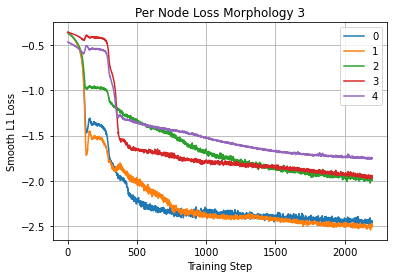


************** Batch 0 in 0.6238353252410889 **************

Training Idx 4 
Train Loss tensor([0.3452, 0.5904, 0.5116, 0.3925, 0.3496, 0.4567, 0.3454]) 
Test Loss tensor([0.3441, 0.5921, 0.5129, 0.3935, 0.3510, 0.4568, 0.3448])


************** Batch 4 in 0.5911900997161865 **************

Training Idx 4 
Train Loss tensor([0.3442, 0.5921, 0.5146, 0.3922, 0.3513, 0.4573, 0.3446]) 
Test Loss tensor([0.3435, 0.5943, 0.5139, 0.3928, 0.3491, 0.4576, 0.3441])


************** Batch 8 in 0.6008996963500977 **************

Training Idx 4 
Train Loss tensor([0.3463, 0.5945, 0.5167, 0.3913, 0.3526, 0.4563, 0.3439]) 
Test Loss tensor([0.3416, 0.5958, 0.5144, 0.3934, 0.3505, 0.4574, 0.3418])


************** Batch 12 in 0.5994997024536133 **************

Training Idx 4 
Train Loss tensor([0.3433, 0.5958, 0.5137, 0.3898, 0.3512, 0.4559, 0.3433]) 
Test Loss tensor([0.3413, 0.5971, 0.5158, 0.3918, 0.3512, 0.4578, 0.3406])


************** Batch 16 in 0.5970945358276367 **************

Training Idx


************** Batch 144 in 0.5900444984436035 **************

Training Idx 4 
Train Loss tensor([0.3181, 0.6335, 0.5403, 0.3839, 0.3461, 0.4580, 0.3103]) 
Test Loss tensor([0.3173, 0.6351, 0.5401, 0.3820, 0.3496, 0.4600, 0.3095])


************** Batch 148 in 0.5901501178741455 **************

Training Idx 4 
Train Loss tensor([0.3151, 0.6355, 0.5385, 0.3841, 0.3512, 0.4545, 0.3098]) 
Test Loss tensor([0.3159, 0.6362, 0.5399, 0.3827, 0.3486, 0.4596, 0.3093])


************** Batch 152 in 0.5947244167327881 **************

Training Idx 4 
Train Loss tensor([0.3148, 0.6355, 0.5436, 0.3768, 0.3465, 0.4619, 0.3084]) 
Test Loss tensor([0.3159, 0.6358, 0.5396, 0.3834, 0.3489, 0.4594, 0.3086])


************** Batch 156 in 0.5933501720428467 **************

Training Idx 4 
Train Loss tensor([0.3138, 0.6365, 0.5371, 0.3828, 0.3513, 0.4586, 0.3081]) 
Test Loss tensor([0.3154, 0.6364, 0.5393, 0.3843, 0.3483, 0.4587, 0.3088])


************** Batch 160 in 0.5999965667724609 **************

Trai


************** Batch 288 in 0.7890439033508301 **************

Training Idx 4 
Train Loss tensor([0.3160, 0.6316, 0.5381, 0.3838, 0.3500, 0.4560, 0.3066]) 
Test Loss tensor([0.3162, 0.6316, 0.5368, 0.3831, 0.3474, 0.4588, 0.3064])


************** Batch 292 in 0.8519494533538818 **************

Training Idx 4 
Train Loss tensor([0.3150, 0.6309, 0.5362, 0.3792, 0.3428, 0.4619, 0.3058]) 
Test Loss tensor([0.3164, 0.6322, 0.5378, 0.3823, 0.3480, 0.4583, 0.3064])


************** Batch 296 in 0.7695870399475098 **************

Training Idx 4 
Train Loss tensor([0.3201, 0.6327, 0.5378, 0.3776, 0.3449, 0.4583, 0.3068]) 
Test Loss tensor([0.3167, 0.6317, 0.5380, 0.3819, 0.3482, 0.4589, 0.3058])


************** Batch 300 in 0.7862210273742676 **************

Training Idx 4 
Train Loss tensor([0.3175, 0.6304, 0.5430, 0.3821, 0.3517, 0.4572, 0.3068]) 
Test Loss tensor([0.3162, 0.6315, 0.5370, 0.3838, 0.3490, 0.4582, 0.3056])


************** Batch 304 in 0.7644107341766357 **************

Trai


************** Batch 432 in 0.8250224590301514 **************

Training Idx 4 
Train Loss tensor([0.3116, 0.5953, 0.5192, 0.3707, 0.3498, 0.4568, 0.2731]) 
Test Loss tensor([0.3096, 0.5939, 0.5128, 0.3722, 0.3498, 0.4579, 0.2694])


************** Batch 436 in 0.8248677253723145 **************

Training Idx 4 
Train Loss tensor([0.3102, 0.5946, 0.5125, 0.3763, 0.3531, 0.4562, 0.2679]) 
Test Loss tensor([0.3088, 0.5906, 0.5101, 0.3735, 0.3502, 0.4562, 0.2671])


************** Batch 440 in 0.7302165031433105 **************

Training Idx 4 
Train Loss tensor([0.3088, 0.5919, 0.5136, 0.3680, 0.3512, 0.4576, 0.2667]) 
Test Loss tensor([0.3076, 0.5887, 0.5099, 0.3721, 0.3511, 0.4575, 0.2644])


************** Batch 444 in 0.7690331935882568 **************

Training Idx 4 
Train Loss tensor([0.3076, 0.5889, 0.5090, 0.3720, 0.3495, 0.4589, 0.2650]) 
Test Loss tensor([0.3047, 0.5865, 0.5089, 0.3704, 0.3505, 0.4583, 0.2616])


************** Batch 448 in 0.758699893951416 **************

Train


************** Batch 576 in 0.7337548732757568 **************

Training Idx 4 
Train Loss tensor([0.1715, 0.4665, 0.4157, 0.3493, 0.2765, 0.3626, 0.1017]) 
Test Loss tensor([0.1735, 0.4615, 0.4115, 0.3517, 0.2753, 0.3522, 0.0952])


************** Batch 580 in 0.7494680881500244 **************

Training Idx 4 
Train Loss tensor([0.1741, 0.4617, 0.4130, 0.3496, 0.2792, 0.3542, 0.0965]) 
Test Loss tensor([0.1663, 0.4569, 0.4062, 0.3531, 0.2679, 0.3440, 0.0890])


************** Batch 584 in 0.7648763656616211 **************

Training Idx 4 
Train Loss tensor([0.1651, 0.4563, 0.4072, 0.3484, 0.2681, 0.3444, 0.0897]) 
Test Loss tensor([0.1620, 0.4518, 0.4025, 0.3551, 0.2631, 0.3324, 0.0818])


************** Batch 588 in 0.7530112266540527 **************

Training Idx 4 
Train Loss tensor([0.1663, 0.4525, 0.4005, 0.3621, 0.2649, 0.3306, 0.0819]) 
Test Loss tensor([0.1566, 0.4469, 0.3965, 0.3557, 0.2585, 0.3246, 0.0757])


************** Batch 592 in 0.7389090061187744 **************

Trai


************** Batch 720 in 0.7661991119384766 **************

Training Idx 4 
Train Loss tensor([0.1039, 0.1921, 0.1890, 0.3885, 0.1524, 0.1006, 0.0098]) 
Test Loss tensor([0.1010, 0.1789, 0.1782, 0.4014, 0.1483, 0.0929, 0.0066])


************** Batch 724 in 0.8157079219818115 **************

Training Idx 4 
Train Loss tensor([0.1126, 0.1786, 0.1799, 0.4095, 0.1461, 0.0930, 0.0073]) 
Test Loss tensor([0.1018, 0.1656, 0.1664, 0.4006, 0.1475, 0.0863, 0.0079])


************** Batch 728 in 0.7472171783447266 **************

Training Idx 4 
Train Loss tensor([0.1074, 0.1650, 0.1683, 0.3960, 0.1494, 0.0858, 0.0074]) 
Test Loss tensor([0.1033, 0.1516, 0.1559, 0.4007, 0.1472, 0.0791, 0.0071])


************** Batch 732 in 0.7778277397155762 **************

Training Idx 4 
Train Loss tensor([0.0990, 0.1529, 0.1573, 0.3985, 0.1437, 0.0823, 0.0088]) 
Test Loss tensor([0.1029, 0.1368, 0.1455, 0.3958, 0.1472, 0.0722, 0.0074])


************** Batch 736 in 0.7318003177642822 **************

Trai


************** Batch 864 in 0.8169026374816895 **************

Training Idx 4 
Train Loss tensor([0.1156, 0.0064, 0.0351, 0.0221, 0.2011, 0.0165, 0.0058]) 
Test Loss tensor([0.1044, 0.0043, 0.0361, 0.0232, 0.1921, 0.0174, 0.0057])


************** Batch 868 in 0.7766633033752441 **************

Training Idx 4 
Train Loss tensor([0.0973, 0.0062, 0.0324, 0.0216, 0.1898, 0.0212, 0.0053]) 
Test Loss tensor([0.1037, 0.0041, 0.0364, 0.0230, 0.1902, 0.0162, 0.0052])


************** Batch 872 in 0.8532545566558838 **************

Training Idx 4 
Train Loss tensor([0.1018, 0.0055, 0.0350, 0.0234, 0.1912, 0.0144, 0.0051]) 
Test Loss tensor([0.1020, 0.0039, 0.0340, 0.0230, 0.1845, 0.0157, 0.0051])


************** Batch 876 in 0.7201273441314697 **************

Training Idx 4 
Train Loss tensor([0.0747, 0.0029, 0.0263, 0.0201, 0.1415, 0.0092, 0.0036]) 
Test Loss tensor([0.1032, 0.0041, 0.0349, 0.0229, 0.1898, 0.0153, 0.0044])


************** Batch 0 in 0.7701621055603027 **************

Traini


************** Batch 128 in 0.7834975719451904 **************

Training Idx 4 
Train Loss tensor([0.0951, 0.0061, 0.0335, 0.0224, 0.1702, 0.0119, 0.0050]) 
Test Loss tensor([0.0966, 0.0061, 0.0317, 0.0224, 0.1644, 0.0125, 0.0047])


************** Batch 132 in 0.7553608417510986 **************

Training Idx 4 
Train Loss tensor([0.0934, 0.0061, 0.0367, 0.0227, 0.1706, 0.0138, 0.0055]) 
Test Loss tensor([0.0978, 0.0058, 0.0332, 0.0218, 0.1654, 0.0122, 0.0049])


************** Batch 136 in 0.7624809741973877 **************

Training Idx 4 
Train Loss tensor([0.0951, 0.0062, 0.0295, 0.0194, 0.1641, 0.0112, 0.0044]) 
Test Loss tensor([0.0960, 0.0059, 0.0329, 0.0214, 0.1646, 0.0126, 0.0052])


************** Batch 140 in 0.7546594142913818 **************

Training Idx 4 
Train Loss tensor([0.1009, 0.0053, 0.0324, 0.0220, 0.1767, 0.0120, 0.0049]) 
Test Loss tensor([0.0948, 0.0060, 0.0323, 0.0221, 0.1610, 0.0126, 0.0050])


************** Batch 144 in 0.7527234554290771 **************

Trai


************** Batch 272 in 0.7464311122894287 **************

Training Idx 4 
Train Loss tensor([0.0953, 0.0067, 0.0292, 0.0209, 0.1299, 0.0129, 0.0050]) 
Test Loss tensor([0.0912, 0.0046, 0.0316, 0.0215, 0.1359, 0.0120, 0.0047])


************** Batch 276 in 0.7410681247711182 **************

Training Idx 4 
Train Loss tensor([0.0864, 0.0046, 0.0281, 0.0194, 0.1329, 0.0128, 0.0045]) 
Test Loss tensor([0.0882, 0.0049, 0.0307, 0.0218, 0.1325, 0.0115, 0.0043])


************** Batch 280 in 0.751061201095581 **************

Training Idx 4 
Train Loss tensor([0.0920, 0.0047, 0.0311, 0.0199, 0.1361, 0.0121, 0.0043]) 
Test Loss tensor([0.0911, 0.0051, 0.0303, 0.0220, 0.1297, 0.0117, 0.0041])


************** Batch 284 in 0.7447199821472168 **************

Training Idx 4 
Train Loss tensor([0.0925, 0.0044, 0.0275, 0.0231, 0.1291, 0.0123, 0.0043]) 
Test Loss tensor([0.0916, 0.0051, 0.0311, 0.0230, 0.1278, 0.0119, 0.0044])


************** Batch 288 in 0.741363525390625 **************

Traini


************** Batch 416 in 0.7627465724945068 **************

Training Idx 4 
Train Loss tensor([0.0879, 0.0045, 0.0312, 0.0234, 0.1006, 0.0104, 0.0054]) 
Test Loss tensor([0.0886, 0.0034, 0.0303, 0.0193, 0.0977, 0.0105, 0.0041])


************** Batch 420 in 0.7719371318817139 **************

Training Idx 4 
Train Loss tensor([0.0879, 0.0052, 0.0314, 0.0157, 0.0954, 0.0111, 0.0035]) 
Test Loss tensor([0.0900, 0.0035, 0.0308, 0.0190, 0.0970, 0.0112, 0.0043])


************** Batch 424 in 0.7767667770385742 **************

Training Idx 4 
Train Loss tensor([0.0870, 0.0039, 0.0311, 0.0194, 0.0980, 0.0100, 0.0048]) 
Test Loss tensor([0.0886, 0.0037, 0.0307, 0.0189, 0.0971, 0.0113, 0.0043])


************** Batch 428 in 0.7646198272705078 **************

Training Idx 4 
Train Loss tensor([0.0876, 0.0029, 0.0342, 0.0175, 0.0986, 0.0104, 0.0052]) 
Test Loss tensor([0.0887, 0.0041, 0.0317, 0.0198, 0.0958, 0.0101, 0.0040])


************** Batch 432 in 0.7870118618011475 **************

Trai


************** Batch 560 in 0.7681460380554199 **************

Training Idx 4 
Train Loss tensor([0.0868, 0.0039, 0.0293, 0.0176, 0.0878, 0.0075, 0.0047]) 
Test Loss tensor([0.0840, 0.0037, 0.0298, 0.0174, 0.0834, 0.0091, 0.0042])


************** Batch 564 in 0.7491304874420166 **************

Training Idx 4 
Train Loss tensor([0.0816, 0.0034, 0.0260, 0.0163, 0.0818, 0.0096, 0.0037]) 
Test Loss tensor([0.0832, 0.0034, 0.0297, 0.0178, 0.0849, 0.0086, 0.0044])


************** Batch 568 in 0.7714545726776123 **************

Training Idx 4 
Train Loss tensor([0.0817, 0.0032, 0.0282, 0.0180, 0.0881, 0.0095, 0.0040]) 
Test Loss tensor([0.0819, 0.0037, 0.0296, 0.0175, 0.0836, 0.0087, 0.0042])


************** Batch 572 in 0.7675385475158691 **************

Training Idx 4 
Train Loss tensor([0.0798, 0.0043, 0.0287, 0.0190, 0.0863, 0.0078, 0.0035]) 
Test Loss tensor([0.0825, 0.0036, 0.0296, 0.0178, 0.0836, 0.0092, 0.0042])


************** Batch 576 in 0.7427914142608643 **************

Trai


************** Batch 704 in 0.7398889064788818 **************

Training Idx 4 
Train Loss tensor([0.0668, 0.0044, 0.0306, 0.0189, 0.0725, 0.0080, 0.0039]) 
Test Loss tensor([0.0715, 0.0039, 0.0294, 0.0180, 0.0714, 0.0083, 0.0039])


************** Batch 708 in 0.8102798461914062 **************

Training Idx 4 
Train Loss tensor([0.0762, 0.0040, 0.0292, 0.0166, 0.0678, 0.0082, 0.0035]) 
Test Loss tensor([0.0734, 0.0038, 0.0285, 0.0181, 0.0733, 0.0088, 0.0038])


************** Batch 712 in 0.765855073928833 **************

Training Idx 4 
Train Loss tensor([0.0721, 0.0029, 0.0278, 0.0172, 0.0698, 0.0097, 0.0039]) 
Test Loss tensor([0.0705, 0.0036, 0.0284, 0.0180, 0.0710, 0.0088, 0.0039])


************** Batch 716 in 0.7575933933258057 **************

Training Idx 4 
Train Loss tensor([0.0733, 0.0051, 0.0276, 0.0194, 0.0756, 0.0085, 0.0037]) 
Test Loss tensor([0.0718, 0.0034, 0.0288, 0.0174, 0.0721, 0.0088, 0.0038])


************** Batch 720 in 0.7825725078582764 **************

Train


************** Batch 848 in 0.7451536655426025 **************

Training Idx 4 
Train Loss tensor([0.0597, 0.0035, 0.0280, 0.0199, 0.0651, 0.0077, 0.0034]) 
Test Loss tensor([0.0638, 0.0035, 0.0280, 0.0177, 0.0622, 0.0086, 0.0034])


************** Batch 852 in 0.7520251274108887 **************

Training Idx 4 
Train Loss tensor([0.0616, 0.0045, 0.0282, 0.0158, 0.0634, 0.0084, 0.0043]) 
Test Loss tensor([0.0665, 0.0036, 0.0271, 0.0168, 0.0634, 0.0086, 0.0035])


************** Batch 856 in 0.7797832489013672 **************

Training Idx 4 
Train Loss tensor([0.0611, 0.0040, 0.0250, 0.0187, 0.0636, 0.0078, 0.0026]) 
Test Loss tensor([0.0636, 0.0034, 0.0273, 0.0173, 0.0631, 0.0084, 0.0035])


************** Batch 860 in 0.7499420642852783 **************

Training Idx 4 
Train Loss tensor([0.0602, 0.0027, 0.0252, 0.0170, 0.0615, 0.0071, 0.0040]) 
Test Loss tensor([0.0636, 0.0036, 0.0260, 0.0163, 0.0615, 0.0089, 0.0035])


************** Batch 864 in 0.7391269207000732 **************

Trai


************** Batch 112 in 0.8136763572692871 **************

Training Idx 4 
Train Loss tensor([0.0567, 0.0029, 0.0209, 0.0178, 0.0538, 0.0084, 0.0029]) 
Test Loss tensor([0.0558, 0.0034, 0.0251, 0.0171, 0.0559, 0.0076, 0.0029])


************** Batch 116 in 0.770672082901001 **************

Training Idx 4 
Train Loss tensor([0.0533, 0.0035, 0.0268, 0.0160, 0.0533, 0.0093, 0.0039]) 
Test Loss tensor([0.0552, 0.0035, 0.0254, 0.0164, 0.0549, 0.0085, 0.0032])


************** Batch 120 in 0.8406984806060791 **************

Training Idx 4 
Train Loss tensor([0.0549, 0.0042, 0.0249, 0.0158, 0.0569, 0.0076, 0.0027]) 
Test Loss tensor([0.0553, 0.0034, 0.0263, 0.0167, 0.0563, 0.0085, 0.0034])


************** Batch 124 in 0.8341741561889648 **************

Training Idx 4 
Train Loss tensor([0.0545, 0.0030, 0.0238, 0.0184, 0.0570, 0.0091, 0.0040]) 
Test Loss tensor([0.0560, 0.0034, 0.0251, 0.0167, 0.0548, 0.0081, 0.0032])


************** Batch 128 in 0.863304853439331 **************

Traini


************** Batch 256 in 0.7650527954101562 **************

Training Idx 4 
Train Loss tensor([0.0626, 0.0044, 0.0298, 0.0164, 0.0486, 0.0087, 0.0030]) 
Test Loss tensor([0.0508, 0.0037, 0.0237, 0.0163, 0.0498, 0.0078, 0.0033])


************** Batch 260 in 0.9679255485534668 **************

Training Idx 4 
Train Loss tensor([0.0542, 0.0029, 0.0222, 0.0159, 0.0492, 0.0072, 0.0028]) 
Test Loss tensor([0.0529, 0.0033, 0.0239, 0.0158, 0.0493, 0.0077, 0.0033])


************** Batch 264 in 0.8528926372528076 **************

Training Idx 4 
Train Loss tensor([0.0501, 0.0031, 0.0253, 0.0155, 0.0506, 0.0095, 0.0035]) 
Test Loss tensor([0.0529, 0.0035, 0.0241, 0.0157, 0.0498, 0.0079, 0.0032])


************** Batch 268 in 0.8294098377227783 **************

Training Idx 4 
Train Loss tensor([0.0456, 0.0046, 0.0216, 0.0152, 0.0493, 0.0089, 0.0034]) 
Test Loss tensor([0.0520, 0.0035, 0.0241, 0.0156, 0.0489, 0.0080, 0.0036])


************** Batch 272 in 0.7458925247192383 **************

Trai


************** Batch 400 in 0.5852365493774414 **************

Training Idx 4 
Train Loss tensor([0.0480, 0.0030, 0.0234, 0.0143, 0.0419, 0.0084, 0.0040]) 
Test Loss tensor([0.0495, 0.0035, 0.0234, 0.0154, 0.0456, 0.0079, 0.0033])


************** Batch 404 in 0.5776469707489014 **************

Training Idx 4 
Train Loss tensor([0.0471, 0.0046, 0.0232, 0.0149, 0.0444, 0.0093, 0.0048]) 
Test Loss tensor([0.0483, 0.0031, 0.0225, 0.0159, 0.0449, 0.0075, 0.0033])


************** Batch 408 in 0.5829572677612305 **************

Training Idx 4 
Train Loss tensor([0.0470, 0.0028, 0.0233, 0.0140, 0.0457, 0.0080, 0.0033]) 
Test Loss tensor([0.0497, 0.0031, 0.0235, 0.0155, 0.0457, 0.0076, 0.0033])


************** Batch 412 in 0.6008727550506592 **************

Training Idx 4 
Train Loss tensor([0.0466, 0.0032, 0.0228, 0.0145, 0.0418, 0.0085, 0.0041]) 
Test Loss tensor([0.0482, 0.0036, 0.0218, 0.0151, 0.0449, 0.0076, 0.0031])


************** Batch 416 in 0.5724289417266846 **************

Trai


************** Batch 544 in 0.6432445049285889 **************

Training Idx 4 
Train Loss tensor([0.0461, 0.0035, 0.0233, 0.0157, 0.0395, 0.0061, 0.0033]) 
Test Loss tensor([0.0448, 0.0033, 0.0225, 0.0151, 0.0421, 0.0072, 0.0032])


************** Batch 548 in 0.6125695705413818 **************

Training Idx 4 
Train Loss tensor([0.0438, 0.0030, 0.0244, 0.0155, 0.0401, 0.0070, 0.0037]) 
Test Loss tensor([0.0468, 0.0031, 0.0212, 0.0149, 0.0422, 0.0077, 0.0032])


************** Batch 552 in 0.6312627792358398 **************

Training Idx 4 
Train Loss tensor([0.0475, 0.0039, 0.0193, 0.0136, 0.0424, 0.0071, 0.0046]) 
Test Loss tensor([0.0454, 0.0031, 0.0210, 0.0154, 0.0421, 0.0080, 0.0037])


************** Batch 556 in 0.6781628131866455 **************

Training Idx 4 
Train Loss tensor([0.0446, 0.0034, 0.0256, 0.0164, 0.0386, 0.0076, 0.0030]) 
Test Loss tensor([0.0443, 0.0034, 0.0222, 0.0151, 0.0413, 0.0082, 0.0031])


************** Batch 560 in 0.6653234958648682 **************

Trai


************** Batch 688 in 0.8201107978820801 **************

Training Idx 4 
Train Loss tensor([0.0449, 0.0025, 0.0242, 0.0169, 0.0381, 0.0092, 0.0046]) 
Test Loss tensor([0.0433, 0.0032, 0.0203, 0.0146, 0.0389, 0.0071, 0.0034])


************** Batch 692 in 0.7859323024749756 **************

Training Idx 4 
Train Loss tensor([0.0414, 0.0022, 0.0186, 0.0132, 0.0405, 0.0070, 0.0031]) 
Test Loss tensor([0.0436, 0.0030, 0.0209, 0.0142, 0.0407, 0.0073, 0.0036])


************** Batch 696 in 0.7671267986297607 **************

Training Idx 4 
Train Loss tensor([0.0479, 0.0034, 0.0224, 0.0142, 0.0396, 0.0071, 0.0037]) 
Test Loss tensor([0.0419, 0.0028, 0.0210, 0.0152, 0.0389, 0.0071, 0.0031])


************** Batch 700 in 0.7919013500213623 **************

Training Idx 4 
Train Loss tensor([0.0441, 0.0036, 0.0209, 0.0149, 0.0430, 0.0066, 0.0038]) 
Test Loss tensor([0.0418, 0.0030, 0.0214, 0.0149, 0.0393, 0.0069, 0.0030])


************** Batch 704 in 0.7952289581298828 **************

Trai


************** Batch 832 in 0.7508947849273682 **************

Training Idx 4 
Train Loss tensor([0.0435, 0.0037, 0.0217, 0.0139, 0.0393, 0.0078, 0.0040]) 
Test Loss tensor([0.0412, 0.0028, 0.0197, 0.0143, 0.0363, 0.0071, 0.0034])


************** Batch 836 in 0.8655486106872559 **************

Training Idx 4 
Train Loss tensor([0.0394, 0.0039, 0.0187, 0.0152, 0.0373, 0.0066, 0.0034]) 
Test Loss tensor([0.0420, 0.0030, 0.0203, 0.0149, 0.0371, 0.0074, 0.0036])


************** Batch 840 in 0.7738862037658691 **************

Training Idx 4 
Train Loss tensor([0.0503, 0.0033, 0.0198, 0.0129, 0.0396, 0.0079, 0.0034]) 
Test Loss tensor([0.0409, 0.0030, 0.0199, 0.0144, 0.0379, 0.0072, 0.0037])


************** Batch 844 in 0.6572186946868896 **************

Training Idx 4 
Train Loss tensor([0.0443, 0.0025, 0.0218, 0.0142, 0.0380, 0.0082, 0.0027]) 
Test Loss tensor([0.0392, 0.0035, 0.0200, 0.0143, 0.0368, 0.0067, 0.0032])


************** Batch 848 in 0.849679708480835 **************

Train


************** Batch 96 in 0.6990859508514404 **************

Training Idx 4 
Train Loss tensor([0.0465, 0.0030, 0.0189, 0.0143, 0.0372, 0.0067, 0.0033]) 
Test Loss tensor([0.0385, 0.0031, 0.0186, 0.0146, 0.0363, 0.0066, 0.0031])


************** Batch 100 in 0.8022572994232178 **************

Training Idx 4 
Train Loss tensor([0.0434, 0.0032, 0.0238, 0.0146, 0.0384, 0.0075, 0.0040]) 
Test Loss tensor([0.0394, 0.0034, 0.0200, 0.0145, 0.0381, 0.0074, 0.0034])


************** Batch 104 in 0.8390598297119141 **************

Training Idx 4 
Train Loss tensor([0.0430, 0.0028, 0.0194, 0.0134, 0.0375, 0.0064, 0.0026]) 
Test Loss tensor([0.0384, 0.0030, 0.0202, 0.0144, 0.0361, 0.0063, 0.0033])


************** Batch 108 in 0.7718334197998047 **************

Training Idx 4 
Train Loss tensor([0.0376, 0.0023, 0.0182, 0.0148, 0.0362, 0.0072, 0.0032]) 
Test Loss tensor([0.0397, 0.0031, 0.0194, 0.0142, 0.0366, 0.0067, 0.0035])


************** Batch 112 in 0.7921638488769531 **************

Train


************** Batch 240 in 0.7969875335693359 **************

Training Idx 4 
Train Loss tensor([0.0377, 0.0028, 0.0187, 0.0142, 0.0345, 0.0069, 0.0033]) 
Test Loss tensor([0.0392, 0.0033, 0.0187, 0.0142, 0.0341, 0.0062, 0.0035])


************** Batch 244 in 0.8427238464355469 **************

Training Idx 4 
Train Loss tensor([0.0369, 0.0029, 0.0173, 0.0141, 0.0330, 0.0058, 0.0037]) 
Test Loss tensor([0.0377, 0.0029, 0.0194, 0.0143, 0.0348, 0.0062, 0.0034])


************** Batch 248 in 0.7762846946716309 **************

Training Idx 4 
Train Loss tensor([0.0417, 0.0037, 0.0186, 0.0142, 0.0345, 0.0069, 0.0034]) 
Test Loss tensor([0.0376, 0.0032, 0.0186, 0.0144, 0.0354, 0.0061, 0.0031])


************** Batch 252 in 0.7654087543487549 **************

Training Idx 4 
Train Loss tensor([0.0440, 0.0040, 0.0175, 0.0144, 0.0340, 0.0056, 0.0031]) 
Test Loss tensor([0.0393, 0.0032, 0.0192, 0.0143, 0.0332, 0.0062, 0.0034])


************** Batch 256 in 0.7507240772247314 **************

Trai


************** Batch 384 in 0.6002187728881836 **************

Training Idx 4 
Train Loss tensor([0.0348, 0.0029, 0.0185, 0.0142, 0.0313, 0.0067, 0.0034]) 
Test Loss tensor([0.0368, 0.0029, 0.0184, 0.0137, 0.0337, 0.0060, 0.0034])


************** Batch 388 in 0.5698699951171875 **************

Training Idx 4 
Train Loss tensor([0.0378, 0.0031, 0.0209, 0.0150, 0.0355, 0.0066, 0.0027]) 
Test Loss tensor([0.0378, 0.0033, 0.0186, 0.0140, 0.0339, 0.0065, 0.0036])


************** Batch 392 in 0.5663573741912842 **************

Training Idx 4 
Train Loss tensor([0.0370, 0.0029, 0.0195, 0.0137, 0.0361, 0.0070, 0.0049]) 
Test Loss tensor([0.0374, 0.0032, 0.0182, 0.0138, 0.0330, 0.0065, 0.0036])


************** Batch 396 in 0.5693674087524414 **************

Training Idx 4 
Train Loss tensor([0.0356, 0.0024, 0.0161, 0.0132, 0.0326, 0.0065, 0.0035]) 
Test Loss tensor([0.0376, 0.0028, 0.0177, 0.0137, 0.0330, 0.0064, 0.0033])


************** Batch 400 in 0.5691924095153809 **************

Trai


************** Batch 528 in 0.6575558185577393 **************

Training Idx 4 
Train Loss tensor([0.0368, 0.0028, 0.0207, 0.0145, 0.0319, 0.0054, 0.0034]) 
Test Loss tensor([0.0363, 0.0033, 0.0183, 0.0138, 0.0321, 0.0062, 0.0033])


************** Batch 532 in 0.6109461784362793 **************

Training Idx 4 
Train Loss tensor([0.0376, 0.0036, 0.0187, 0.0130, 0.0320, 0.0070, 0.0027]) 
Test Loss tensor([0.0353, 0.0029, 0.0179, 0.0138, 0.0323, 0.0064, 0.0038])


************** Batch 536 in 0.6036653518676758 **************

Training Idx 4 
Train Loss tensor([0.0359, 0.0031, 0.0159, 0.0131, 0.0336, 0.0047, 0.0043]) 
Test Loss tensor([0.0358, 0.0029, 0.0174, 0.0138, 0.0321, 0.0061, 0.0037])


************** Batch 540 in 0.6012389659881592 **************

Training Idx 4 
Train Loss tensor([0.0371, 0.0030, 0.0191, 0.0121, 0.0297, 0.0063, 0.0040]) 
Test Loss tensor([0.0365, 0.0030, 0.0187, 0.0141, 0.0334, 0.0061, 0.0034])


************** Batch 544 in 0.6135680675506592 **************

Trai


************** Batch 672 in 0.5811862945556641 **************

Training Idx 4 
Train Loss tensor([0.0348, 0.0027, 0.0177, 0.0123, 0.0385, 0.0067, 0.0026]) 
Test Loss tensor([0.0351, 0.0032, 0.0180, 0.0136, 0.0322, 0.0065, 0.0034])


************** Batch 676 in 0.5686047077178955 **************

Training Idx 4 
Train Loss tensor([0.0361, 0.0027, 0.0204, 0.0149, 0.0318, 0.0069, 0.0035]) 
Test Loss tensor([0.0350, 0.0029, 0.0176, 0.0138, 0.0309, 0.0063, 0.0038])


************** Batch 680 in 0.5727369785308838 **************

Training Idx 4 
Train Loss tensor([0.0335, 0.0028, 0.0165, 0.0147, 0.0336, 0.0054, 0.0039]) 
Test Loss tensor([0.0359, 0.0030, 0.0176, 0.0138, 0.0315, 0.0061, 0.0034])


************** Batch 684 in 0.5745038986206055 **************

Training Idx 4 
Train Loss tensor([0.0375, 0.0021, 0.0183, 0.0134, 0.0301, 0.0067, 0.0029]) 
Test Loss tensor([0.0350, 0.0027, 0.0171, 0.0139, 0.0322, 0.0060, 0.0035])


************** Batch 688 in 0.5716831684112549 **************

Trai


************** Batch 816 in 0.5748133659362793 **************

Training Idx 4 
Train Loss tensor([0.0325, 0.0022, 0.0170, 0.0135, 0.0316, 0.0056, 0.0046]) 
Test Loss tensor([0.0344, 0.0029, 0.0180, 0.0137, 0.0303, 0.0058, 0.0033])


************** Batch 820 in 0.5734789371490479 **************

Training Idx 4 
Train Loss tensor([0.0315, 0.0018, 0.0161, 0.0133, 0.0287, 0.0058, 0.0035]) 
Test Loss tensor([0.0346, 0.0029, 0.0177, 0.0135, 0.0299, 0.0057, 0.0035])


************** Batch 824 in 0.5707578659057617 **************

Training Idx 4 
Train Loss tensor([0.0297, 0.0023, 0.0178, 0.0120, 0.0347, 0.0041, 0.0038]) 
Test Loss tensor([0.0344, 0.0029, 0.0169, 0.0134, 0.0310, 0.0057, 0.0034])


************** Batch 828 in 0.5727663040161133 **************

Training Idx 4 
Train Loss tensor([0.0343, 0.0030, 0.0164, 0.0131, 0.0279, 0.0064, 0.0035]) 
Test Loss tensor([0.0346, 0.0030, 0.0176, 0.0134, 0.0293, 0.0057, 0.0034])


************** Batch 832 in 0.576256513595581 **************

Train


************** Batch 80 in 0.5689654350280762 **************

Training Idx 4 
Train Loss tensor([0.0340, 0.0034, 0.0178, 0.0118, 0.0294, 0.0042, 0.0037]) 
Test Loss tensor([0.0328, 0.0032, 0.0174, 0.0134, 0.0301, 0.0059, 0.0034])


************** Batch 84 in 0.5737411975860596 **************

Training Idx 4 
Train Loss tensor([0.0336, 0.0028, 0.0166, 0.0126, 0.0268, 0.0050, 0.0029]) 
Test Loss tensor([0.0339, 0.0030, 0.0170, 0.0137, 0.0308, 0.0060, 0.0035])


************** Batch 88 in 0.57094407081604 **************

Training Idx 4 
Train Loss tensor([0.0344, 0.0024, 0.0170, 0.0129, 0.0283, 0.0057, 0.0032]) 
Test Loss tensor([0.0338, 0.0027, 0.0177, 0.0134, 0.0306, 0.0057, 0.0036])


************** Batch 92 in 0.5684897899627686 **************

Training Idx 4 
Train Loss tensor([0.0306, 0.0027, 0.0166, 0.0133, 0.0303, 0.0056, 0.0029]) 
Test Loss tensor([0.0355, 0.0029, 0.0168, 0.0134, 0.0296, 0.0058, 0.0037])


************** Batch 96 in 0.5668613910675049 **************

Training Id


************** Batch 224 in 0.5738065242767334 **************

Training Idx 4 
Train Loss tensor([0.0325, 0.0019, 0.0135, 0.0129, 0.0311, 0.0050, 0.0031]) 
Test Loss tensor([0.0329, 0.0029, 0.0174, 0.0135, 0.0287, 0.0058, 0.0035])


************** Batch 228 in 0.5772173404693604 **************

Training Idx 4 
Train Loss tensor([0.0292, 0.0033, 0.0168, 0.0126, 0.0293, 0.0050, 0.0024]) 
Test Loss tensor([0.0333, 0.0027, 0.0169, 0.0130, 0.0299, 0.0061, 0.0035])


************** Batch 232 in 0.5752649307250977 **************

Training Idx 4 
Train Loss tensor([0.0322, 0.0032, 0.0196, 0.0143, 0.0291, 0.0056, 0.0036]) 
Test Loss tensor([0.0326, 0.0032, 0.0175, 0.0130, 0.0301, 0.0060, 0.0033])


************** Batch 236 in 0.5849654674530029 **************

Training Idx 4 
Train Loss tensor([0.0323, 0.0029, 0.0175, 0.0134, 0.0296, 0.0045, 0.0032]) 
Test Loss tensor([0.0320, 0.0029, 0.0165, 0.0134, 0.0296, 0.0055, 0.0035])


************** Batch 240 in 0.5717315673828125 **************

Trai


************** Batch 368 in 0.5885429382324219 **************

Training Idx 4 
Train Loss tensor([0.0313, 0.0030, 0.0185, 0.0152, 0.0275, 0.0044, 0.0028]) 
Test Loss tensor([0.0324, 0.0031, 0.0163, 0.0131, 0.0290, 0.0057, 0.0033])


************** Batch 372 in 0.573962926864624 **************

Training Idx 4 
Train Loss tensor([0.0321, 0.0031, 0.0160, 0.0126, 0.0291, 0.0059, 0.0038]) 
Test Loss tensor([0.0321, 0.0030, 0.0163, 0.0133, 0.0279, 0.0056, 0.0035])


************** Batch 376 in 0.5730407238006592 **************

Training Idx 4 
Train Loss tensor([0.0338, 0.0032, 0.0179, 0.0120, 0.0274, 0.0053, 0.0039]) 
Test Loss tensor([0.0320, 0.0029, 0.0165, 0.0131, 0.0282, 0.0056, 0.0034])


************** Batch 380 in 0.5712499618530273 **************

Training Idx 4 
Train Loss tensor([0.0359, 0.0033, 0.0174, 0.0125, 0.0297, 0.0051, 0.0038]) 
Test Loss tensor([0.0336, 0.0029, 0.0164, 0.0128, 0.0280, 0.0056, 0.0032])


************** Batch 384 in 0.5710160732269287 **************

Train


************** Batch 512 in 0.5711109638214111 **************

Training Idx 4 
Train Loss tensor([0.0323, 0.0029, 0.0169, 0.0129, 0.0272, 0.0055, 0.0035]) 
Test Loss tensor([0.0312, 0.0031, 0.0162, 0.0131, 0.0281, 0.0058, 0.0036])


************** Batch 516 in 0.571678876876831 **************

Training Idx 4 
Train Loss tensor([0.0305, 0.0032, 0.0163, 0.0129, 0.0264, 0.0045, 0.0034]) 
Test Loss tensor([0.0308, 0.0030, 0.0164, 0.0131, 0.0282, 0.0057, 0.0035])


************** Batch 520 in 0.5696539878845215 **************

Training Idx 4 
Train Loss tensor([0.0316, 0.0025, 0.0176, 0.0119, 0.0283, 0.0050, 0.0029]) 
Test Loss tensor([0.0312, 0.0026, 0.0169, 0.0133, 0.0270, 0.0055, 0.0032])


************** Batch 524 in 0.5693769454956055 **************

Training Idx 4 
Train Loss tensor([0.0286, 0.0030, 0.0182, 0.0135, 0.0279, 0.0050, 0.0030]) 
Test Loss tensor([0.0325, 0.0028, 0.0166, 0.0132, 0.0275, 0.0059, 0.0035])


************** Batch 528 in 0.5706911087036133 **************

Train


************** Batch 656 in 0.5746610164642334 **************

Training Idx 4 
Train Loss tensor([0.0295, 0.0032, 0.0154, 0.0112, 0.0285, 0.0057, 0.0027]) 
Test Loss tensor([0.0306, 0.0026, 0.0164, 0.0132, 0.0273, 0.0053, 0.0034])


************** Batch 660 in 0.571209192276001 **************

Training Idx 4 
Train Loss tensor([0.0303, 0.0027, 0.0173, 0.0128, 0.0288, 0.0050, 0.0035]) 
Test Loss tensor([0.0315, 0.0025, 0.0164, 0.0129, 0.0264, 0.0054, 0.0034])


************** Batch 664 in 0.5731546878814697 **************

Training Idx 4 
Train Loss tensor([0.0289, 0.0020, 0.0163, 0.0130, 0.0305, 0.0062, 0.0038]) 
Test Loss tensor([0.0312, 0.0028, 0.0161, 0.0131, 0.0276, 0.0054, 0.0032])


************** Batch 668 in 0.5681490898132324 **************

Training Idx 4 
Train Loss tensor([0.0385, 0.0039, 0.0165, 0.0140, 0.0300, 0.0048, 0.0036]) 
Test Loss tensor([0.0331, 0.0027, 0.0157, 0.0128, 0.0265, 0.0057, 0.0038])


************** Batch 672 in 0.5700793266296387 **************

Train


************** Batch 800 in 0.5757479667663574 **************

Training Idx 4 
Train Loss tensor([0.0328, 0.0023, 0.0168, 0.0132, 0.0287, 0.0050, 0.0034]) 
Test Loss tensor([0.0308, 0.0029, 0.0162, 0.0130, 0.0275, 0.0054, 0.0036])


************** Batch 804 in 0.5752513408660889 **************

Training Idx 4 
Train Loss tensor([0.0316, 0.0027, 0.0187, 0.0126, 0.0262, 0.0046, 0.0042]) 
Test Loss tensor([0.0314, 0.0029, 0.0161, 0.0127, 0.0261, 0.0054, 0.0037])


************** Batch 808 in 0.5763516426086426 **************

Training Idx 4 
Train Loss tensor([0.0304, 0.0026, 0.0161, 0.0130, 0.0269, 0.0043, 0.0029]) 
Test Loss tensor([0.0308, 0.0026, 0.0156, 0.0131, 0.0267, 0.0054, 0.0034])


************** Batch 812 in 0.5769476890563965 **************

Training Idx 4 
Train Loss tensor([0.0333, 0.0034, 0.0160, 0.0135, 0.0293, 0.0063, 0.0035]) 
Test Loss tensor([0.0310, 0.0029, 0.0160, 0.0130, 0.0266, 0.0052, 0.0035])


************** Batch 816 in 0.5746676921844482 **************

Trai


************** Batch 64 in 0.5720658302307129 **************

Training Idx 4 
Train Loss tensor([0.0316, 0.0022, 0.0171, 0.0133, 0.0255, 0.0053, 0.0033]) 
Test Loss tensor([0.0301, 0.0027, 0.0162, 0.0128, 0.0260, 0.0053, 0.0036])


************** Batch 68 in 0.5750293731689453 **************

Training Idx 4 
Train Loss tensor([0.0325, 0.0022, 0.0155, 0.0123, 0.0252, 0.0051, 0.0055]) 
Test Loss tensor([0.0306, 0.0027, 0.0164, 0.0129, 0.0265, 0.0049, 0.0032])


************** Batch 72 in 0.5714335441589355 **************

Training Idx 4 
Train Loss tensor([0.0333, 0.0025, 0.0173, 0.0137, 0.0269, 0.0054, 0.0029]) 
Test Loss tensor([0.0308, 0.0030, 0.0162, 0.0126, 0.0266, 0.0054, 0.0036])


************** Batch 76 in 0.5744953155517578 **************

Training Idx 4 
Train Loss tensor([0.0302, 0.0024, 0.0156, 0.0119, 0.0243, 0.0064, 0.0030]) 
Test Loss tensor([0.0307, 0.0028, 0.0159, 0.0128, 0.0278, 0.0052, 0.0035])


************** Batch 80 in 0.5747694969177246 **************

Training 


************** Batch 208 in 0.5749015808105469 **************

Training Idx 4 
Train Loss tensor([0.0254, 0.0024, 0.0146, 0.0123, 0.0260, 0.0055, 0.0032]) 
Test Loss tensor([0.0301, 0.0025, 0.0163, 0.0127, 0.0259, 0.0051, 0.0036])


************** Batch 212 in 0.5707440376281738 **************

Training Idx 4 
Train Loss tensor([0.0323, 0.0025, 0.0192, 0.0134, 0.0251, 0.0052, 0.0025]) 
Test Loss tensor([0.0302, 0.0027, 0.0164, 0.0126, 0.0256, 0.0047, 0.0033])


************** Batch 216 in 0.5690467357635498 **************

Training Idx 4 
Train Loss tensor([0.0272, 0.0027, 0.0164, 0.0132, 0.0279, 0.0047, 0.0030]) 
Test Loss tensor([0.0292, 0.0026, 0.0159, 0.0131, 0.0260, 0.0050, 0.0033])


************** Batch 220 in 0.5689339637756348 **************

Training Idx 4 
Train Loss tensor([0.0297, 0.0027, 0.0163, 0.0126, 0.0238, 0.0041, 0.0036]) 
Test Loss tensor([0.0302, 0.0026, 0.0159, 0.0126, 0.0260, 0.0054, 0.0035])


************** Batch 224 in 0.569263219833374 **************

Train


************** Batch 352 in 0.581524133682251 **************

Training Idx 4 
Train Loss tensor([0.0312, 0.0040, 0.0166, 0.0136, 0.0234, 0.0052, 0.0027]) 
Test Loss tensor([0.0303, 0.0027, 0.0155, 0.0127, 0.0265, 0.0050, 0.0036])


************** Batch 356 in 0.581028938293457 **************

Training Idx 4 
Train Loss tensor([0.0295, 0.0027, 0.0168, 0.0123, 0.0244, 0.0047, 0.0031]) 
Test Loss tensor([0.0293, 0.0026, 0.0158, 0.0129, 0.0243, 0.0052, 0.0034])


************** Batch 360 in 0.5817196369171143 **************

Training Idx 4 
Train Loss tensor([0.0319, 0.0034, 0.0181, 0.0119, 0.0244, 0.0040, 0.0038]) 
Test Loss tensor([0.0291, 0.0029, 0.0159, 0.0126, 0.0253, 0.0051, 0.0033])


************** Batch 364 in 0.5798735618591309 **************

Training Idx 4 
Train Loss tensor([0.0329, 0.0025, 0.0166, 0.0126, 0.0254, 0.0056, 0.0029]) 
Test Loss tensor([0.0299, 0.0026, 0.0153, 0.0123, 0.0261, 0.0050, 0.0034])


************** Batch 368 in 0.5828309059143066 **************

Traini


************** Batch 496 in 0.579200029373169 **************

Training Idx 4 
Train Loss tensor([0.0310, 0.0024, 0.0144, 0.0128, 0.0252, 0.0044, 0.0032]) 
Test Loss tensor([0.0294, 0.0026, 0.0158, 0.0126, 0.0251, 0.0048, 0.0036])


************** Batch 500 in 0.5859041213989258 **************

Training Idx 4 
Train Loss tensor([0.0299, 0.0025, 0.0150, 0.0133, 0.0252, 0.0043, 0.0030]) 
Test Loss tensor([0.0297, 0.0027, 0.0158, 0.0121, 0.0249, 0.0046, 0.0033])


************** Batch 504 in 0.5850117206573486 **************

Training Idx 4 
Train Loss tensor([0.0271, 0.0023, 0.0175, 0.0118, 0.0236, 0.0050, 0.0040]) 
Test Loss tensor([0.0298, 0.0026, 0.0145, 0.0124, 0.0251, 0.0050, 0.0036])


************** Batch 508 in 0.5802710056304932 **************

Training Idx 4 
Train Loss tensor([0.0289, 0.0018, 0.0164, 0.0114, 0.0255, 0.0046, 0.0034]) 
Test Loss tensor([0.0292, 0.0028, 0.0158, 0.0125, 0.0244, 0.0047, 0.0034])


************** Batch 512 in 0.5812523365020752 **************

Train


************** Batch 640 in 0.5910837650299072 **************

Training Idx 4 
Train Loss tensor([0.0337, 0.0025, 0.0146, 0.0128, 0.0288, 0.0046, 0.0031]) 
Test Loss tensor([0.0293, 0.0027, 0.0149, 0.0127, 0.0245, 0.0049, 0.0034])


************** Batch 644 in 0.587512731552124 **************

Training Idx 4 
Train Loss tensor([0.0262, 0.0021, 0.0156, 0.0120, 0.0221, 0.0044, 0.0029]) 
Test Loss tensor([0.0293, 0.0028, 0.0153, 0.0128, 0.0248, 0.0048, 0.0036])


************** Batch 648 in 0.5866563320159912 **************

Training Idx 4 
Train Loss tensor([0.0289, 0.0026, 0.0165, 0.0119, 0.0267, 0.0039, 0.0029]) 
Test Loss tensor([0.0294, 0.0027, 0.0153, 0.0123, 0.0239, 0.0050, 0.0035])


************** Batch 652 in 0.5851435661315918 **************

Training Idx 4 
Train Loss tensor([0.0295, 0.0022, 0.0137, 0.0123, 0.0253, 0.0061, 0.0034]) 
Test Loss tensor([0.0291, 0.0029, 0.0148, 0.0124, 0.0237, 0.0049, 0.0031])


************** Batch 656 in 0.5969226360321045 **************

Train


************** Batch 784 in 0.5840833187103271 **************

Training Idx 4 
Train Loss tensor([0.0275, 0.0022, 0.0175, 0.0141, 0.0248, 0.0041, 0.0032]) 
Test Loss tensor([0.0287, 0.0026, 0.0149, 0.0120, 0.0240, 0.0049, 0.0035])


************** Batch 788 in 0.580474853515625 **************

Training Idx 4 
Train Loss tensor([0.0272, 0.0028, 0.0148, 0.0117, 0.0254, 0.0042, 0.0032]) 
Test Loss tensor([0.0286, 0.0026, 0.0158, 0.0123, 0.0241, 0.0048, 0.0033])


************** Batch 792 in 0.5829033851623535 **************

Training Idx 4 
Train Loss tensor([0.0335, 0.0020, 0.0137, 0.0115, 0.0243, 0.0052, 0.0036]) 
Test Loss tensor([0.0286, 0.0026, 0.0152, 0.0120, 0.0247, 0.0045, 0.0032])


************** Batch 796 in 0.5815548896789551 **************

Training Idx 4 
Train Loss tensor([0.0311, 0.0027, 0.0172, 0.0108, 0.0218, 0.0047, 0.0031]) 
Test Loss tensor([0.0292, 0.0026, 0.0154, 0.0123, 0.0248, 0.0048, 0.0032])


************** Batch 800 in 0.6111388206481934 **************

Train


************** Batch 48 in 0.5836832523345947 **************

Training Idx 4 
Train Loss tensor([0.0258, 0.0019, 0.0155, 0.0133, 0.0259, 0.0044, 0.0025]) 
Test Loss tensor([0.0275, 0.0028, 0.0150, 0.0121, 0.0239, 0.0049, 0.0033])


************** Batch 52 in 0.6066112518310547 **************

Training Idx 4 
Train Loss tensor([0.0304, 0.0025, 0.0160, 0.0122, 0.0218, 0.0057, 0.0036]) 
Test Loss tensor([0.0294, 0.0026, 0.0155, 0.0123, 0.0250, 0.0049, 0.0035])


************** Batch 56 in 0.5857789516448975 **************

Training Idx 4 
Train Loss tensor([0.0275, 0.0026, 0.0158, 0.0123, 0.0255, 0.0049, 0.0028]) 
Test Loss tensor([0.0283, 0.0025, 0.0155, 0.0124, 0.0243, 0.0046, 0.0034])


************** Batch 60 in 0.5876038074493408 **************

Training Idx 4 
Train Loss tensor([0.0281, 0.0018, 0.0122, 0.0116, 0.0242, 0.0047, 0.0042]) 
Test Loss tensor([0.0281, 0.0027, 0.0152, 0.0122, 0.0241, 0.0044, 0.0032])


************** Batch 64 in 0.5853559970855713 **************

Training 


************** Batch 192 in 0.5927293300628662 **************

Training Idx 4 
Train Loss tensor([0.0254, 0.0026, 0.0149, 0.0132, 0.0218, 0.0037, 0.0032]) 
Test Loss tensor([0.0274, 0.0028, 0.0154, 0.0122, 0.0236, 0.0047, 0.0033])


************** Batch 196 in 0.5973153114318848 **************

Training Idx 4 
Train Loss tensor([0.0272, 0.0028, 0.0150, 0.0122, 0.0243, 0.0060, 0.0049]) 
Test Loss tensor([0.0291, 0.0027, 0.0153, 0.0125, 0.0234, 0.0050, 0.0032])


************** Batch 200 in 0.5943715572357178 **************

Training Idx 4 
Train Loss tensor([0.0266, 0.0023, 0.0164, 0.0136, 0.0285, 0.0056, 0.0035]) 
Test Loss tensor([0.0280, 0.0026, 0.0155, 0.0125, 0.0230, 0.0046, 0.0035])


************** Batch 204 in 0.5914211273193359 **************

Training Idx 4 
Train Loss tensor([0.0265, 0.0028, 0.0141, 0.0133, 0.0211, 0.0054, 0.0038]) 
Test Loss tensor([0.0276, 0.0025, 0.0152, 0.0125, 0.0238, 0.0047, 0.0036])


************** Batch 208 in 0.5933740139007568 **************

Trai


************** Batch 336 in 0.7470095157623291 **************

Training Idx 4 
Train Loss tensor([0.0274, 0.0020, 0.0154, 0.0127, 0.0219, 0.0035, 0.0030]) 
Test Loss tensor([0.0276, 0.0023, 0.0144, 0.0122, 0.0237, 0.0048, 0.0035])


************** Batch 340 in 0.6477489471435547 **************

Training Idx 4 
Train Loss tensor([0.0299, 0.0023, 0.0131, 0.0132, 0.0208, 0.0049, 0.0041]) 
Test Loss tensor([0.0283, 0.0027, 0.0152, 0.0125, 0.0238, 0.0047, 0.0033])


************** Batch 344 in 0.6755192279815674 **************

Training Idx 4 
Train Loss tensor([0.0266, 0.0025, 0.0157, 0.0127, 0.0217, 0.0053, 0.0030]) 
Test Loss tensor([0.0273, 0.0025, 0.0149, 0.0122, 0.0234, 0.0044, 0.0031])


************** Batch 348 in 0.6624877452850342 **************

Training Idx 4 
Train Loss tensor([0.0268, 0.0025, 0.0162, 0.0123, 0.0209, 0.0043, 0.0026]) 
Test Loss tensor([0.0276, 0.0026, 0.0146, 0.0121, 0.0236, 0.0045, 0.0034])


************** Batch 352 in 0.647479772567749 **************

Train


************** Batch 480 in 0.627805233001709 **************

Training Idx 4 
Train Loss tensor([0.0292, 0.0021, 0.0134, 0.0116, 0.0240, 0.0044, 0.0025]) 
Test Loss tensor([0.0281, 0.0027, 0.0148, 0.0122, 0.0227, 0.0048, 0.0036])


************** Batch 484 in 0.631309986114502 **************

Training Idx 4 
Train Loss tensor([0.0285, 0.0020, 0.0149, 0.0123, 0.0245, 0.0066, 0.0045]) 
Test Loss tensor([0.0267, 0.0026, 0.0146, 0.0120, 0.0235, 0.0043, 0.0034])


************** Batch 488 in 0.734576940536499 **************

Training Idx 4 
Train Loss tensor([0.0261, 0.0030, 0.0161, 0.0120, 0.0214, 0.0040, 0.0035]) 
Test Loss tensor([0.0262, 0.0024, 0.0145, 0.0122, 0.0228, 0.0047, 0.0035])


************** Batch 492 in 0.6862678527832031 **************

Training Idx 4 
Train Loss tensor([0.0283, 0.0026, 0.0160, 0.0130, 0.0246, 0.0054, 0.0036]) 
Test Loss tensor([0.0265, 0.0025, 0.0150, 0.0123, 0.0241, 0.0048, 0.0035])


************** Batch 496 in 0.7674834728240967 **************

Trainin


************** Batch 624 in 0.6287481784820557 **************

Training Idx 4 
Train Loss tensor([0.0282, 0.0024, 0.0149, 0.0129, 0.0265, 0.0046, 0.0034]) 
Test Loss tensor([0.0277, 0.0027, 0.0147, 0.0123, 0.0229, 0.0049, 0.0034])


************** Batch 628 in 0.6576998233795166 **************

Training Idx 4 
Train Loss tensor([0.0278, 0.0019, 0.0140, 0.0126, 0.0251, 0.0041, 0.0031]) 
Test Loss tensor([0.0277, 0.0023, 0.0144, 0.0119, 0.0232, 0.0045, 0.0034])


************** Batch 632 in 0.6208810806274414 **************

Training Idx 4 
Train Loss tensor([0.0287, 0.0028, 0.0151, 0.0124, 0.0253, 0.0040, 0.0032]) 
Test Loss tensor([0.0267, 0.0027, 0.0144, 0.0125, 0.0236, 0.0046, 0.0036])


************** Batch 636 in 0.6285419464111328 **************

Training Idx 4 
Train Loss tensor([0.0252, 0.0030, 0.0134, 0.0114, 0.0237, 0.0045, 0.0033]) 
Test Loss tensor([0.0280, 0.0026, 0.0144, 0.0127, 0.0248, 0.0046, 0.0036])


************** Batch 640 in 0.6663544178009033 **************

Trai


************** Batch 768 in 0.7798364162445068 **************

Training Idx 4 
Train Loss tensor([0.0305, 0.0022, 0.0171, 0.0121, 0.0228, 0.0055, 0.0035]) 
Test Loss tensor([0.0277, 0.0026, 0.0146, 0.0120, 0.0225, 0.0047, 0.0034])


************** Batch 772 in 0.6422762870788574 **************

Training Idx 4 
Train Loss tensor([0.0298, 0.0023, 0.0171, 0.0138, 0.0242, 0.0046, 0.0035]) 
Test Loss tensor([0.0270, 0.0024, 0.0146, 0.0121, 0.0225, 0.0047, 0.0033])


************** Batch 776 in 0.721874475479126 **************

Training Idx 4 
Train Loss tensor([0.0275, 0.0023, 0.0162, 0.0121, 0.0237, 0.0041, 0.0036]) 
Test Loss tensor([0.0264, 0.0024, 0.0145, 0.0120, 0.0235, 0.0045, 0.0035])


************** Batch 780 in 0.8225095272064209 **************

Training Idx 4 
Train Loss tensor([0.0261, 0.0017, 0.0151, 0.0123, 0.0237, 0.0040, 0.0039]) 
Test Loss tensor([0.0259, 0.0026, 0.0149, 0.0126, 0.0221, 0.0047, 0.0035])


************** Batch 784 in 0.6280550956726074 **************

Train


************** Batch 32 in 0.6018209457397461 **************

Training Idx 4 
Train Loss tensor([0.0286, 0.0028, 0.0128, 0.0117, 0.0227, 0.0060, 0.0038]) 
Test Loss tensor([0.0260, 0.0026, 0.0143, 0.0117, 0.0217, 0.0047, 0.0033])


************** Batch 36 in 0.5910804271697998 **************

Training Idx 4 
Train Loss tensor([0.0300, 0.0025, 0.0163, 0.0130, 0.0227, 0.0054, 0.0031]) 
Test Loss tensor([0.0270, 0.0025, 0.0140, 0.0125, 0.0239, 0.0047, 0.0034])


************** Batch 40 in 0.5899825096130371 **************

Training Idx 4 
Train Loss tensor([0.0279, 0.0023, 0.0145, 0.0127, 0.0247, 0.0048, 0.0033]) 
Test Loss tensor([0.0270, 0.0025, 0.0144, 0.0119, 0.0220, 0.0045, 0.0033])


************** Batch 44 in 0.5839240550994873 **************

Training Idx 4 
Train Loss tensor([0.0262, 0.0021, 0.0161, 0.0129, 0.0230, 0.0051, 0.0038]) 
Test Loss tensor([0.0270, 0.0027, 0.0146, 0.0124, 0.0245, 0.0047, 0.0033])


************** Batch 48 in 0.5853631496429443 **************

Training 


************** Batch 176 in 0.6014220714569092 **************

Training Idx 4 
Train Loss tensor([0.0260, 0.0024, 0.0146, 0.0125, 0.0190, 0.0039, 0.0031]) 
Test Loss tensor([0.0270, 0.0026, 0.0147, 0.0121, 0.0224, 0.0043, 0.0034])


************** Batch 180 in 0.5978567600250244 **************

Training Idx 4 
Train Loss tensor([0.0241, 0.0024, 0.0143, 0.0121, 0.0235, 0.0053, 0.0027]) 
Test Loss tensor([0.0272, 0.0024, 0.0146, 0.0120, 0.0227, 0.0046, 0.0036])


************** Batch 184 in 0.6007027626037598 **************

Training Idx 4 
Train Loss tensor([0.0266, 0.0022, 0.0133, 0.0122, 0.0243, 0.0052, 0.0043]) 
Test Loss tensor([0.0258, 0.0026, 0.0141, 0.0122, 0.0225, 0.0048, 0.0034])


************** Batch 188 in 0.6352028846740723 **************

Training Idx 4 
Train Loss tensor([0.0303, 0.0019, 0.0154, 0.0129, 0.0252, 0.0056, 0.0046]) 
Test Loss tensor([0.0260, 0.0029, 0.0147, 0.0120, 0.0217, 0.0046, 0.0032])


************** Batch 192 in 0.6159493923187256 **************

Trai


************** Batch 320 in 0.6376044750213623 **************

Training Idx 4 
Train Loss tensor([0.0233, 0.0022, 0.0122, 0.0120, 0.0206, 0.0059, 0.0026]) 
Test Loss tensor([0.0259, 0.0025, 0.0143, 0.0119, 0.0214, 0.0047, 0.0036])


************** Batch 324 in 0.5926229953765869 **************

Training Idx 4 
Train Loss tensor([0.0267, 0.0025, 0.0150, 0.0131, 0.0212, 0.0032, 0.0031]) 
Test Loss tensor([0.0252, 0.0025, 0.0147, 0.0124, 0.0213, 0.0045, 0.0034])


************** Batch 328 in 0.6492760181427002 **************

Training Idx 4 
Train Loss tensor([0.0270, 0.0028, 0.0134, 0.0120, 0.0225, 0.0042, 0.0033]) 
Test Loss tensor([0.0259, 0.0026, 0.0140, 0.0117, 0.0216, 0.0047, 0.0035])


************** Batch 332 in 0.6906435489654541 **************

Training Idx 4 
Train Loss tensor([0.0284, 0.0026, 0.0135, 0.0132, 0.0186, 0.0042, 0.0030]) 
Test Loss tensor([0.0258, 0.0027, 0.0140, 0.0124, 0.0222, 0.0046, 0.0035])


************** Batch 336 in 0.6270401477813721 **************

Trai


************** Batch 464 in 0.8668618202209473 **************

Training Idx 4 
Train Loss tensor([0.0283, 0.0025, 0.0128, 0.0127, 0.0210, 0.0050, 0.0043]) 
Test Loss tensor([0.0249, 0.0023, 0.0138, 0.0118, 0.0219, 0.0048, 0.0033])


************** Batch 468 in 0.9242773056030273 **************

Training Idx 4 
Train Loss tensor([0.0293, 0.0022, 0.0131, 0.0117, 0.0199, 0.0033, 0.0023]) 
Test Loss tensor([0.0261, 0.0026, 0.0140, 0.0119, 0.0226, 0.0046, 0.0033])


************** Batch 472 in 0.7596654891967773 **************

Training Idx 4 
Train Loss tensor([0.0247, 0.0022, 0.0138, 0.0112, 0.0231, 0.0046, 0.0033]) 
Test Loss tensor([0.0258, 0.0024, 0.0141, 0.0122, 0.0223, 0.0048, 0.0032])


************** Batch 476 in 0.6021103858947754 **************

Training Idx 4 
Train Loss tensor([0.0257, 0.0025, 0.0139, 0.0127, 0.0212, 0.0042, 0.0038]) 
Test Loss tensor([0.0254, 0.0025, 0.0144, 0.0119, 0.0213, 0.0041, 0.0033])


************** Batch 480 in 0.6583414077758789 **************

Trai


************** Batch 608 in 0.6611461639404297 **************

Training Idx 4 
Train Loss tensor([0.0247, 0.0024, 0.0129, 0.0129, 0.0211, 0.0040, 0.0021]) 
Test Loss tensor([0.0257, 0.0024, 0.0141, 0.0122, 0.0211, 0.0045, 0.0034])


************** Batch 612 in 0.6999027729034424 **************

Training Idx 4 
Train Loss tensor([0.0250, 0.0024, 0.0152, 0.0131, 0.0196, 0.0045, 0.0032]) 
Test Loss tensor([0.0256, 0.0023, 0.0142, 0.0124, 0.0223, 0.0044, 0.0033])


************** Batch 616 in 0.789820671081543 **************

Training Idx 4 
Train Loss tensor([0.0272, 0.0029, 0.0133, 0.0113, 0.0246, 0.0055, 0.0030]) 
Test Loss tensor([0.0251, 0.0027, 0.0142, 0.0118, 0.0212, 0.0044, 0.0033])


************** Batch 620 in 0.7330942153930664 **************

Training Idx 4 
Train Loss tensor([0.0272, 0.0021, 0.0128, 0.0123, 0.0248, 0.0063, 0.0039]) 
Test Loss tensor([0.0251, 0.0023, 0.0146, 0.0120, 0.0212, 0.0044, 0.0033])


************** Batch 624 in 0.6212165355682373 **************

Train


************** Batch 752 in 0.6526200771331787 **************

Training Idx 4 
Train Loss tensor([0.0264, 0.0019, 0.0132, 0.0122, 0.0219, 0.0043, 0.0034]) 
Test Loss tensor([0.0256, 0.0023, 0.0135, 0.0122, 0.0212, 0.0046, 0.0035])


************** Batch 756 in 0.6383371353149414 **************

Training Idx 4 
Train Loss tensor([0.0252, 0.0022, 0.0141, 0.0125, 0.0229, 0.0038, 0.0035]) 
Test Loss tensor([0.0253, 0.0026, 0.0140, 0.0119, 0.0208, 0.0044, 0.0034])


************** Batch 760 in 0.6287088394165039 **************

Training Idx 4 
Train Loss tensor([0.0249, 0.0031, 0.0137, 0.0120, 0.0195, 0.0039, 0.0024]) 
Test Loss tensor([0.0252, 0.0023, 0.0141, 0.0118, 0.0212, 0.0043, 0.0033])


************** Batch 764 in 0.6266608238220215 **************

Training Idx 4 
Train Loss tensor([0.0280, 0.0027, 0.0151, 0.0138, 0.0194, 0.0047, 0.0043]) 
Test Loss tensor([0.0252, 0.0024, 0.0139, 0.0120, 0.0213, 0.0044, 0.0032])


************** Batch 768 in 0.6094558238983154 **************

Trai


************** Batch 16 in 0.5928239822387695 **************

Training Idx 4 
Train Loss tensor([0.0266, 0.0021, 0.0144, 0.0120, 0.0214, 0.0039, 0.0024]) 
Test Loss tensor([0.0244, 0.0024, 0.0142, 0.0121, 0.0198, 0.0044, 0.0029])


************** Batch 20 in 0.5950024127960205 **************

Training Idx 4 
Train Loss tensor([0.0251, 0.0021, 0.0144, 0.0128, 0.0199, 0.0035, 0.0026]) 
Test Loss tensor([0.0237, 0.0026, 0.0138, 0.0115, 0.0194, 0.0046, 0.0033])


************** Batch 24 in 0.6068432331085205 **************

Training Idx 4 
Train Loss tensor([0.0236, 0.0017, 0.0144, 0.0108, 0.0191, 0.0040, 0.0028]) 
Test Loss tensor([0.0237, 0.0028, 0.0134, 0.0117, 0.0199, 0.0043, 0.0031])


************** Batch 28 in 0.5983870029449463 **************

Training Idx 4 
Train Loss tensor([0.0265, 0.0025, 0.0133, 0.0116, 0.0214, 0.0049, 0.0039]) 
Test Loss tensor([0.0250, 0.0024, 0.0142, 0.0119, 0.0201, 0.0047, 0.0033])


************** Batch 32 in 0.6053376197814941 **************

Training 


************** Batch 160 in 0.6226339340209961 **************

Training Idx 4 
Train Loss tensor([0.0245, 0.0022, 0.0141, 0.0118, 0.0192, 0.0051, 0.0028]) 
Test Loss tensor([0.0244, 0.0026, 0.0142, 0.0122, 0.0212, 0.0044, 0.0031])


************** Batch 164 in 0.6111173629760742 **************

Training Idx 4 
Train Loss tensor([0.0269, 0.0024, 0.0150, 0.0121, 0.0233, 0.0047, 0.0029]) 
Test Loss tensor([0.0240, 0.0024, 0.0135, 0.0116, 0.0202, 0.0043, 0.0034])


************** Batch 168 in 0.6410908699035645 **************

Training Idx 4 
Train Loss tensor([0.0253, 0.0031, 0.0143, 0.0121, 0.0183, 0.0045, 0.0025]) 
Test Loss tensor([0.0250, 0.0026, 0.0139, 0.0118, 0.0214, 0.0042, 0.0033])


************** Batch 172 in 0.647871732711792 **************

Training Idx 4 
Train Loss tensor([0.0251, 0.0024, 0.0135, 0.0135, 0.0232, 0.0044, 0.0026]) 
Test Loss tensor([0.0247, 0.0026, 0.0145, 0.0119, 0.0204, 0.0040, 0.0031])


************** Batch 176 in 0.6958966255187988 **************

Train


************** Batch 304 in 0.6531622409820557 **************

Training Idx 4 
Train Loss tensor([0.0245, 0.0020, 0.0138, 0.0121, 0.0220, 0.0037, 0.0037]) 
Test Loss tensor([0.0245, 0.0025, 0.0135, 0.0122, 0.0201, 0.0042, 0.0031])


************** Batch 308 in 0.6317815780639648 **************

Training Idx 4 
Train Loss tensor([0.0233, 0.0020, 0.0127, 0.0113, 0.0197, 0.0037, 0.0031]) 
Test Loss tensor([0.0247, 0.0023, 0.0133, 0.0118, 0.0202, 0.0046, 0.0032])


************** Batch 312 in 0.6383624076843262 **************

Training Idx 4 
Train Loss tensor([0.0244, 0.0026, 0.0141, 0.0124, 0.0209, 0.0041, 0.0035]) 
Test Loss tensor([0.0247, 0.0025, 0.0140, 0.0123, 0.0194, 0.0046, 0.0031])


************** Batch 316 in 0.6132266521453857 **************

Training Idx 4 
Train Loss tensor([0.0260, 0.0025, 0.0121, 0.0129, 0.0204, 0.0051, 0.0034]) 
Test Loss tensor([0.0237, 0.0025, 0.0135, 0.0118, 0.0204, 0.0043, 0.0034])


************** Batch 320 in 0.6230988502502441 **************

Trai


************** Batch 448 in 0.6340756416320801 **************

Training Idx 4 
Train Loss tensor([0.0259, 0.0027, 0.0123, 0.0106, 0.0187, 0.0032, 0.0034]) 
Test Loss tensor([0.0239, 0.0025, 0.0143, 0.0118, 0.0191, 0.0042, 0.0031])


************** Batch 452 in 0.6105542182922363 **************

Training Idx 4 
Train Loss tensor([0.0232, 0.0023, 0.0131, 0.0127, 0.0211, 0.0042, 0.0032]) 
Test Loss tensor([0.0241, 0.0026, 0.0138, 0.0118, 0.0200, 0.0044, 0.0031])


************** Batch 456 in 0.6183638572692871 **************

Training Idx 4 
Train Loss tensor([0.0228, 0.0020, 0.0154, 0.0122, 0.0195, 0.0034, 0.0031]) 
Test Loss tensor([0.0236, 0.0025, 0.0135, 0.0121, 0.0195, 0.0046, 0.0032])


************** Batch 460 in 0.6258502006530762 **************

Training Idx 4 
Train Loss tensor([0.0270, 0.0031, 0.0140, 0.0108, 0.0219, 0.0047, 0.0031]) 
Test Loss tensor([0.0232, 0.0027, 0.0140, 0.0120, 0.0201, 0.0042, 0.0031])


************** Batch 464 in 0.7019252777099609 **************

Trai


************** Batch 592 in 0.6216862201690674 **************

Training Idx 4 
Train Loss tensor([0.0238, 0.0018, 0.0138, 0.0111, 0.0211, 0.0060, 0.0029]) 
Test Loss tensor([0.0237, 0.0024, 0.0132, 0.0119, 0.0188, 0.0044, 0.0033])


************** Batch 596 in 0.6177694797515869 **************

Training Idx 4 
Train Loss tensor([0.0258, 0.0022, 0.0147, 0.0127, 0.0200, 0.0047, 0.0036]) 
Test Loss tensor([0.0241, 0.0026, 0.0137, 0.0121, 0.0193, 0.0044, 0.0032])


************** Batch 600 in 0.6031057834625244 **************

Training Idx 4 
Train Loss tensor([0.0228, 0.0022, 0.0136, 0.0127, 0.0166, 0.0039, 0.0039]) 
Test Loss tensor([0.0235, 0.0024, 0.0133, 0.0120, 0.0186, 0.0042, 0.0033])


************** Batch 604 in 0.6119921207427979 **************

Training Idx 4 
Train Loss tensor([0.0270, 0.0024, 0.0128, 0.0112, 0.0176, 0.0035, 0.0037]) 
Test Loss tensor([0.0237, 0.0025, 0.0136, 0.0115, 0.0188, 0.0042, 0.0031])


************** Batch 608 in 0.5993902683258057 **************

Trai


************** Batch 736 in 0.6050400733947754 **************

Training Idx 4 
Train Loss tensor([0.0217, 0.0017, 0.0115, 0.0106, 0.0176, 0.0035, 0.0047]) 
Test Loss tensor([0.0232, 0.0025, 0.0135, 0.0118, 0.0185, 0.0042, 0.0032])


************** Batch 740 in 0.5937070846557617 **************

Training Idx 4 
Train Loss tensor([0.0214, 0.0026, 0.0132, 0.0123, 0.0195, 0.0050, 0.0036]) 
Test Loss tensor([0.0235, 0.0025, 0.0135, 0.0120, 0.0198, 0.0045, 0.0029])


************** Batch 744 in 0.6132700443267822 **************

Training Idx 4 
Train Loss tensor([0.0241, 0.0024, 0.0132, 0.0118, 0.0196, 0.0035, 0.0032]) 
Test Loss tensor([0.0230, 0.0023, 0.0131, 0.0116, 0.0184, 0.0042, 0.0035])


************** Batch 748 in 0.6304609775543213 **************

Training Idx 4 
Train Loss tensor([0.0235, 0.0027, 0.0154, 0.0111, 0.0164, 0.0047, 0.0034]) 
Test Loss tensor([0.0240, 0.0025, 0.0138, 0.0116, 0.0187, 0.0043, 0.0033])


************** Batch 752 in 0.6011714935302734 **************

Trai


************** Batch 0 in 0.6701793670654297 **************

Training Idx 4 
Train Loss tensor([0.0231, 0.0025, 0.0138, 0.0124, 0.0175, 0.0040, 0.0038]) 
Test Loss tensor([0.0239, 0.0024, 0.0134, 0.0116, 0.0193, 0.0045, 0.0032])


************** Batch 4 in 0.6151421070098877 **************

Training Idx 4 
Train Loss tensor([0.0246, 0.0021, 0.0133, 0.0121, 0.0206, 0.0038, 0.0036]) 
Test Loss tensor([0.0228, 0.0023, 0.0132, 0.0116, 0.0184, 0.0044, 0.0031])


************** Batch 8 in 0.6320090293884277 **************

Training Idx 4 
Train Loss tensor([0.0230, 0.0023, 0.0127, 0.0111, 0.0178, 0.0036, 0.0037]) 
Test Loss tensor([0.0225, 0.0026, 0.0132, 0.0118, 0.0192, 0.0043, 0.0032])


************** Batch 12 in 0.6259686946868896 **************

Training Idx 4 
Train Loss tensor([0.0226, 0.0029, 0.0146, 0.0126, 0.0180, 0.0037, 0.0035]) 
Test Loss tensor([0.0236, 0.0025, 0.0133, 0.0118, 0.0185, 0.0044, 0.0030])


************** Batch 16 in 0.5997579097747803 **************

Training Idx


************** Batch 144 in 0.7200789451599121 **************

Training Idx 4 
Train Loss tensor([0.0254, 0.0027, 0.0143, 0.0127, 0.0195, 0.0055, 0.0028]) 
Test Loss tensor([0.0240, 0.0027, 0.0136, 0.0122, 0.0188, 0.0046, 0.0031])


************** Batch 148 in 0.6600124835968018 **************

Training Idx 4 
Train Loss tensor([0.0264, 0.0026, 0.0161, 0.0118, 0.0191, 0.0046, 0.0036]) 
Test Loss tensor([0.0231, 0.0027, 0.0131, 0.0118, 0.0199, 0.0044, 0.0030])


************** Batch 152 in 0.6389725208282471 **************

Training Idx 4 
Train Loss tensor([0.0201, 0.0024, 0.0144, 0.0115, 0.0198, 0.0035, 0.0029]) 
Test Loss tensor([0.0240, 0.0024, 0.0133, 0.0121, 0.0185, 0.0045, 0.0033])


************** Batch 156 in 0.6780378818511963 **************

Training Idx 4 
Train Loss tensor([0.0199, 0.0020, 0.0127, 0.0107, 0.0169, 0.0044, 0.0035]) 
Test Loss tensor([0.0236, 0.0025, 0.0131, 0.0120, 0.0191, 0.0042, 0.0033])


************** Batch 160 in 0.6407690048217773 **************

Trai


************** Batch 288 in 0.5824322700500488 **************

Training Idx 4 
Train Loss tensor([0.0280, 0.0022, 0.0131, 0.0127, 0.0179, 0.0050, 0.0027]) 
Test Loss tensor([0.0223, 0.0024, 0.0135, 0.0116, 0.0192, 0.0043, 0.0032])


************** Batch 292 in 0.5808489322662354 **************

Training Idx 4 
Train Loss tensor([0.0201, 0.0018, 0.0136, 0.0117, 0.0189, 0.0047, 0.0036]) 
Test Loss tensor([0.0228, 0.0024, 0.0127, 0.0118, 0.0186, 0.0041, 0.0030])


************** Batch 296 in 0.5833225250244141 **************

Training Idx 4 
Train Loss tensor([0.0261, 0.0031, 0.0131, 0.0131, 0.0182, 0.0037, 0.0032]) 
Test Loss tensor([0.0235, 0.0023, 0.0132, 0.0119, 0.0198, 0.0042, 0.0032])


************** Batch 300 in 0.5816233158111572 **************

Training Idx 4 
Train Loss tensor([0.0240, 0.0029, 0.0137, 0.0118, 0.0203, 0.0032, 0.0035]) 
Test Loss tensor([0.0229, 0.0024, 0.0129, 0.0117, 0.0181, 0.0042, 0.0031])


************** Batch 304 in 0.5872836112976074 **************

Trai


************** Batch 432 in 0.6206610202789307 **************

Training Idx 4 
Train Loss tensor([0.0230, 0.0023, 0.0148, 0.0131, 0.0181, 0.0044, 0.0034]) 
Test Loss tensor([0.0228, 0.0025, 0.0127, 0.0116, 0.0174, 0.0042, 0.0031])


************** Batch 436 in 0.6292262077331543 **************

Training Idx 4 
Train Loss tensor([0.0255, 0.0020, 0.0125, 0.0125, 0.0170, 0.0038, 0.0029]) 
Test Loss tensor([0.0230, 0.0026, 0.0132, 0.0119, 0.0183, 0.0042, 0.0033])


************** Batch 440 in 0.6340756416320801 **************

Training Idx 4 
Train Loss tensor([0.0213, 0.0019, 0.0130, 0.0116, 0.0198, 0.0035, 0.0031]) 
Test Loss tensor([0.0227, 0.0025, 0.0132, 0.0117, 0.0180, 0.0041, 0.0033])


************** Batch 444 in 0.6323986053466797 **************

Training Idx 4 
Train Loss tensor([0.0245, 0.0028, 0.0109, 0.0116, 0.0180, 0.0040, 0.0034]) 
Test Loss tensor([0.0227, 0.0024, 0.0136, 0.0120, 0.0181, 0.0041, 0.0032])


************** Batch 448 in 0.644221305847168 **************

Train


************** Batch 576 in 0.5957775115966797 **************

Training Idx 4 
Train Loss tensor([0.0245, 0.0019, 0.0130, 0.0112, 0.0172, 0.0046, 0.0033]) 
Test Loss tensor([0.0227, 0.0024, 0.0128, 0.0120, 0.0181, 0.0044, 0.0031])


************** Batch 580 in 0.6073315143585205 **************

Training Idx 4 
Train Loss tensor([0.0238, 0.0024, 0.0137, 0.0110, 0.0179, 0.0053, 0.0035]) 
Test Loss tensor([0.0229, 0.0026, 0.0128, 0.0114, 0.0186, 0.0042, 0.0031])


************** Batch 584 in 0.6494970321655273 **************

Training Idx 4 
Train Loss tensor([0.0226, 0.0025, 0.0138, 0.0113, 0.0176, 0.0034, 0.0027]) 
Test Loss tensor([0.0224, 0.0026, 0.0129, 0.0117, 0.0184, 0.0044, 0.0034])


************** Batch 588 in 0.5944309234619141 **************

Training Idx 4 
Train Loss tensor([0.0213, 0.0021, 0.0125, 0.0122, 0.0189, 0.0049, 0.0034]) 
Test Loss tensor([0.0235, 0.0024, 0.0132, 0.0118, 0.0177, 0.0043, 0.0032])


************** Batch 592 in 0.5912888050079346 **************

Trai


************** Batch 720 in 0.5950043201446533 **************

Training Idx 4 
Train Loss tensor([0.0214, 0.0025, 0.0127, 0.0128, 0.0178, 0.0044, 0.0031]) 
Test Loss tensor([0.0222, 0.0027, 0.0132, 0.0116, 0.0178, 0.0041, 0.0030])


************** Batch 724 in 0.5931363105773926 **************

Training Idx 4 
Train Loss tensor([0.0214, 0.0026, 0.0132, 0.0111, 0.0195, 0.0039, 0.0035]) 
Test Loss tensor([0.0232, 0.0023, 0.0133, 0.0118, 0.0202, 0.0042, 0.0032])


************** Batch 728 in 0.5955290794372559 **************

Training Idx 4 
Train Loss tensor([0.0216, 0.0028, 0.0113, 0.0116, 0.0207, 0.0038, 0.0029]) 
Test Loss tensor([0.0228, 0.0023, 0.0135, 0.0120, 0.0172, 0.0042, 0.0031])


************** Batch 732 in 0.596083402633667 **************

Training Idx 4 
Train Loss tensor([0.0237, 0.0023, 0.0144, 0.0117, 0.0184, 0.0049, 0.0037]) 
Test Loss tensor([0.0235, 0.0025, 0.0129, 0.0118, 0.0189, 0.0044, 0.0031])


************** Batch 736 in 0.596184492111206 **************

Traini


************** Batch 864 in 0.6770203113555908 **************

Training Idx 4 
Train Loss tensor([0.0229, 0.0036, 0.0130, 0.0112, 0.0195, 0.0042, 0.0025]) 
Test Loss tensor([0.0225, 0.0026, 0.0132, 0.0118, 0.0178, 0.0044, 0.0033])


************** Batch 868 in 0.6490626335144043 **************

Training Idx 4 
Train Loss tensor([0.0241, 0.0017, 0.0127, 0.0125, 0.0165, 0.0036, 0.0026]) 
Test Loss tensor([0.0221, 0.0023, 0.0131, 0.0119, 0.0188, 0.0041, 0.0033])


************** Batch 872 in 0.7926678657531738 **************

Training Idx 4 
Train Loss tensor([0.0207, 0.0025, 0.0112, 0.0102, 0.0164, 0.0038, 0.0032]) 
Test Loss tensor([0.0218, 0.0026, 0.0130, 0.0117, 0.0176, 0.0041, 0.0031])


************** Batch 876 in 0.6332883834838867 **************

Training Idx 4 
Train Loss tensor([0.0184, 0.0021, 0.0088, 0.0088, 0.0113, 0.0037, 0.0027]) 
Test Loss tensor([0.0227, 0.0026, 0.0128, 0.0118, 0.0187, 0.0041, 0.0032])



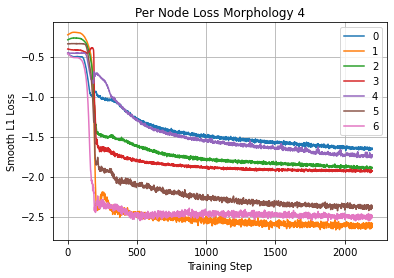


************** Batch 0 in 0.6741514205932617 **************

Training Idx 5 
Train Loss tensor([0.3793, 0.4733, 0.3819, 0.3850, 0.4442, 0.4876, 0.5393]) 
Test Loss tensor([0.3776, 0.4736, 0.3813, 0.3838, 0.4434, 0.4891, 0.5408])


************** Batch 4 in 0.6224839687347412 **************

Training Idx 5 
Train Loss tensor([0.3775, 0.4714, 0.3807, 0.3830, 0.4429, 0.4883, 0.5424]) 
Test Loss tensor([0.3763, 0.4753, 0.3797, 0.3827, 0.4434, 0.4893, 0.5424])


************** Batch 8 in 0.6222541332244873 **************

Training Idx 5 
Train Loss tensor([0.3769, 0.4786, 0.3785, 0.3808, 0.4426, 0.4875, 0.5427]) 
Test Loss tensor([0.3754, 0.4742, 0.3786, 0.3809, 0.4442, 0.4913, 0.5431])


************** Batch 12 in 0.6793527603149414 **************

Training Idx 5 
Train Loss tensor([0.3750, 0.4792, 0.3770, 0.3810, 0.4415, 0.4898, 0.5447]) 
Test Loss tensor([0.3734, 0.4774, 0.3775, 0.3798, 0.4436, 0.4924, 0.5445])


************** Batch 16 in 0.6443796157836914 **************

Training Idx


************** Batch 144 in 0.6778066158294678 **************

Training Idx 5 
Train Loss tensor([0.3589, 0.4843, 0.3650, 0.3697, 0.4479, 0.4969, 0.5583]) 
Test Loss tensor([0.3599, 0.4870, 0.3648, 0.3685, 0.4473, 0.5012, 0.5584])


************** Batch 148 in 0.830371618270874 **************

Training Idx 5 
Train Loss tensor([0.3588, 0.4827, 0.3657, 0.3692, 0.4463, 0.5069, 0.5591]) 
Test Loss tensor([0.3596, 0.4862, 0.3650, 0.3683, 0.4492, 0.5009, 0.5586])


************** Batch 152 in 0.647775411605835 **************

Training Idx 5 
Train Loss tensor([0.3600, 0.4849, 0.3644, 0.3679, 0.4473, 0.5015, 0.5599]) 
Test Loss tensor([0.3594, 0.4862, 0.3647, 0.3681, 0.4473, 0.5023, 0.5585])


************** Batch 156 in 0.6185531616210938 **************

Training Idx 5 
Train Loss tensor([0.3606, 0.4844, 0.3632, 0.3704, 0.4505, 0.5021, 0.5594]) 
Test Loss tensor([0.3595, 0.4870, 0.3644, 0.3687, 0.4487, 0.5014, 0.5585])


************** Batch 160 in 0.6532251834869385 **************

Traini


************** Batch 288 in 0.9305102825164795 **************

Training Idx 5 
Train Loss tensor([0.3529, 0.4858, 0.3663, 0.3696, 0.4490, 0.5017, 0.5567]) 
Test Loss tensor([0.3521, 0.4865, 0.3663, 0.3690, 0.4482, 0.5011, 0.5570])


************** Batch 292 in 0.6539285182952881 **************

Training Idx 5 
Train Loss tensor([0.3509, 0.4872, 0.3657, 0.3701, 0.4472, 0.5004, 0.5572]) 
Test Loss tensor([0.3515, 0.4866, 0.3664, 0.3693, 0.4478, 0.5000, 0.5570])


************** Batch 296 in 0.6378393173217773 **************

Training Idx 5 
Train Loss tensor([0.3520, 0.4854, 0.3659, 0.3695, 0.4498, 0.4995, 0.5569]) 
Test Loss tensor([0.3512, 0.4868, 0.3668, 0.3687, 0.4476, 0.4999, 0.5571])


************** Batch 300 in 0.6657640933990479 **************

Training Idx 5 
Train Loss tensor([0.3508, 0.4865, 0.3661, 0.3692, 0.4480, 0.5010, 0.5569]) 
Test Loss tensor([0.3506, 0.4858, 0.3672, 0.3694, 0.4483, 0.4995, 0.5565])


************** Batch 304 in 0.6363897323608398 **************

Trai


************** Batch 432 in 0.6456224918365479 **************

Training Idx 5 
Train Loss tensor([0.3129, 0.4650, 0.4004, 0.3947, 0.4375, 0.4759, 0.5227]) 
Test Loss tensor([0.3099, 0.4629, 0.4020, 0.3955, 0.4377, 0.4757, 0.5194])


************** Batch 436 in 0.6978840827941895 **************

Training Idx 5 
Train Loss tensor([0.3103, 0.4616, 0.4020, 0.3959, 0.4393, 0.4763, 0.5182]) 
Test Loss tensor([0.3067, 0.4626, 0.4038, 0.3971, 0.4372, 0.4741, 0.5173])


************** Batch 440 in 0.6273097991943359 **************

Training Idx 5 
Train Loss tensor([0.3065, 0.4641, 0.4042, 0.3961, 0.4323, 0.4717, 0.5180]) 
Test Loss tensor([0.3040, 0.4616, 0.4060, 0.3976, 0.4367, 0.4718, 0.5147])


************** Batch 444 in 0.611168622970581 **************

Training Idx 5 
Train Loss tensor([0.3033, 0.4638, 0.4054, 0.3972, 0.4350, 0.4721, 0.5137]) 
Test Loss tensor([0.3003, 0.4615, 0.4080, 0.3988, 0.4349, 0.4710, 0.5130])


************** Batch 448 in 0.6144380569458008 **************

Train


************** Batch 576 in 0.7554893493652344 **************

Training Idx 5 
Train Loss tensor([0.1476, 0.6420, 0.3417, 0.2130, 0.4304, 0.4071, 0.3916]) 
Test Loss tensor([0.1401, 0.6573, 0.3255, 0.2050, 0.4402, 0.4070, 0.3851])


************** Batch 580 in 0.6868698596954346 **************

Training Idx 5 
Train Loss tensor([0.1398, 0.6525, 0.3228, 0.2037, 0.4381, 0.4080, 0.3857]) 
Test Loss tensor([0.1327, 0.6659, 0.3074, 0.1961, 0.4443, 0.4048, 0.3786])


************** Batch 584 in 1.0606448650360107 **************

Training Idx 5 
Train Loss tensor([0.1327, 0.6743, 0.3083, 0.1960, 0.4427, 0.4053, 0.3781]) 
Test Loss tensor([0.1251, 0.6793, 0.2949, 0.1899, 0.4468, 0.3986, 0.3715])


************** Batch 588 in 0.946385383605957 **************

Training Idx 5 
Train Loss tensor([0.1258, 0.6727, 0.2928, 0.1866, 0.4388, 0.3970, 0.3725]) 
Test Loss tensor([0.1179, 0.6908, 0.2837, 0.1820, 0.4490, 0.3913, 0.3642])


************** Batch 592 in 0.710974931716919 **************

Traini


************** Batch 720 in 0.6989903450012207 **************

Training Idx 5 
Train Loss tensor([0.0179, 0.9420, 0.0598, 0.1055, 0.2767, 0.2295, 0.1235]) 
Test Loss tensor([0.0187, 0.9397, 0.0643, 0.1051, 0.2647, 0.2290, 0.1225])


************** Batch 724 in 0.6227478981018066 **************

Training Idx 5 
Train Loss tensor([0.0187, 0.9351, 0.0626, 0.1130, 0.2760, 0.2367, 0.1217]) 
Test Loss tensor([0.0200, 0.9311, 0.0665, 0.1075, 0.2631, 0.2305, 0.1173])


************** Batch 728 in 0.6498730182647705 **************

Training Idx 5 
Train Loss tensor([0.0203, 0.9479, 0.0674, 0.1179, 0.2593, 0.2333, 0.1216]) 
Test Loss tensor([0.0208, 0.9262, 0.0678, 0.1063, 0.2572, 0.2282, 0.1134])


************** Batch 732 in 0.6247484683990479 **************

Training Idx 5 
Train Loss tensor([0.0209, 0.9273, 0.0660, 0.1109, 0.2611, 0.2310, 0.1176]) 
Test Loss tensor([0.0217, 0.9225, 0.0677, 0.1069, 0.2545, 0.2226, 0.1080])


************** Batch 736 in 0.6183450222015381 **************

Trai


************** Batch 864 in 0.679718017578125 **************

Training Idx 5 
Train Loss tensor([0.0303, 0.8830, 0.0875, 0.1056, 0.1738, 0.2134, 0.0666]) 
Test Loss tensor([0.0298, 0.8907, 0.0819, 0.1091, 0.1772, 0.2007, 0.0656])


************** Batch 868 in 0.7013940811157227 **************

Training Idx 5 
Train Loss tensor([0.0297, 0.8829, 0.0789, 0.1106, 0.1821, 0.2132, 0.0622]) 
Test Loss tensor([0.0295, 0.8877, 0.0820, 0.1061, 0.1813, 0.1993, 0.0648])


************** Batch 872 in 0.6934986114501953 **************

Training Idx 5 
Train Loss tensor([0.0295, 0.8913, 0.0877, 0.1030, 0.1821, 0.1986, 0.0691]) 
Test Loss tensor([0.0298, 0.8920, 0.0816, 0.1077, 0.1755, 0.1986, 0.0647])


************** Batch 876 in 0.681490421295166 **************

Training Idx 5 
Train Loss tensor([0.0223, 0.6706, 0.0616, 0.0871, 0.1428, 0.1598, 0.0565]) 
Test Loss tensor([0.0302, 0.8876, 0.0856, 0.1113, 0.1687, 0.2038, 0.0606])


************** Batch 0 in 0.7303938865661621 **************

Training


************** Batch 128 in 0.6220786571502686 **************

Training Idx 5 
Train Loss tensor([0.0293, 0.8860, 0.0799, 0.1015, 0.1670, 0.1727, 0.0521]) 
Test Loss tensor([0.0298, 0.8813, 0.0825, 0.1043, 0.1588, 0.1869, 0.0544])


************** Batch 132 in 0.6604609489440918 **************

Training Idx 5 
Train Loss tensor([0.0298, 0.8820, 0.0830, 0.1137, 0.1578, 0.1955, 0.0530]) 
Test Loss tensor([0.0300, 0.8842, 0.0825, 0.1068, 0.1546, 0.1902, 0.0505])


************** Batch 136 in 0.6452114582061768 **************

Training Idx 5 
Train Loss tensor([0.0299, 0.8748, 0.0820, 0.1110, 0.1526, 0.1877, 0.0467]) 
Test Loss tensor([0.0301, 0.8792, 0.0843, 0.1062, 0.1566, 0.1889, 0.0518])


************** Batch 140 in 0.6332311630249023 **************

Training Idx 5 
Train Loss tensor([0.0302, 0.8786, 0.0811, 0.1105, 0.1540, 0.1870, 0.0507]) 
Test Loss tensor([0.0295, 0.8779, 0.0813, 0.1024, 0.1555, 0.1786, 0.0486])


************** Batch 144 in 0.6345586776733398 **************

Trai


************** Batch 272 in 0.782719612121582 **************

Training Idx 5 
Train Loss tensor([0.0160, 0.2463, 0.0460, 0.2919, 0.1814, 0.0716, 0.0119]) 
Test Loss tensor([0.0145, 0.2152, 0.0454, 0.2844, 0.1770, 0.0804, 0.0202])


************** Batch 276 in 0.6802265644073486 **************

Training Idx 5 
Train Loss tensor([0.0143, 0.2216, 0.0437, 0.2901, 0.1768, 0.0855, 0.0197]) 
Test Loss tensor([0.0133, 0.1660, 0.0431, 0.3064, 0.1786, 0.0824, 0.0219])


************** Batch 280 in 0.760023832321167 **************

Training Idx 5 
Train Loss tensor([0.0133, 0.1511, 0.0459, 0.3033, 0.1767, 0.0813, 0.0225]) 
Test Loss tensor([0.0124, 0.1245, 0.0414, 0.3277, 0.1797, 0.0789, 0.0208])


************** Batch 284 in 0.8016681671142578 **************

Training Idx 5 
Train Loss tensor([0.0120, 0.1197, 0.0386, 0.3274, 0.1670, 0.0691, 0.0199]) 
Test Loss tensor([0.0110, 0.1175, 0.0384, 0.3194, 0.1807, 0.0804, 0.0204])


************** Batch 288 in 0.6738181114196777 **************

Traini


************** Batch 416 in 0.687758207321167 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.1070, 0.0117, 0.1176, 0.1839, 0.0687, 0.0056]) 
Test Loss tensor([0.0018, 0.1017, 0.0114, 0.1127, 0.1834, 0.0617, 0.0052])


************** Batch 420 in 0.639775276184082 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.1052, 0.0134, 0.1146, 0.1901, 0.0614, 0.0040]) 
Test Loss tensor([0.0018, 0.0939, 0.0128, 0.1249, 0.1793, 0.0620, 0.0054])


************** Batch 424 in 0.6222953796386719 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0896, 0.0118, 0.1166, 0.1834, 0.0614, 0.0057]) 
Test Loss tensor([0.0017, 0.0868, 0.0134, 0.1334, 0.1807, 0.0592, 0.0060])


************** Batch 428 in 0.6673645973205566 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0835, 0.0131, 0.1340, 0.1698, 0.0593, 0.0036]) 
Test Loss tensor([0.0017, 0.0896, 0.0134, 0.1234, 0.1775, 0.0622, 0.0053])


************** Batch 432 in 0.6107938289642334 **************

Traini


************** Batch 560 in 0.5958564281463623 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0819, 0.0082, 0.0863, 0.1635, 0.0538, 0.0048]) 
Test Loss tensor([0.0017, 0.0787, 0.0118, 0.0970, 0.1602, 0.0538, 0.0044])


************** Batch 564 in 0.5936985015869141 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0783, 0.0114, 0.0896, 0.1647, 0.0527, 0.0048]) 
Test Loss tensor([0.0017, 0.0815, 0.0118, 0.0954, 0.1579, 0.0526, 0.0046])


************** Batch 568 in 0.5928201675415039 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0816, 0.0108, 0.0963, 0.1672, 0.0534, 0.0056]) 
Test Loss tensor([0.0017, 0.0863, 0.0095, 0.0852, 0.1633, 0.0512, 0.0040])


************** Batch 572 in 0.5929036140441895 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0880, 0.0089, 0.0865, 0.1647, 0.0492, 0.0046]) 
Test Loss tensor([0.0017, 0.0860, 0.0092, 0.0819, 0.1624, 0.0517, 0.0038])


************** Batch 576 in 0.613621711730957 **************

Train


************** Batch 704 in 0.6331462860107422 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0782, 0.0097, 0.0759, 0.1499, 0.0496, 0.0045]) 
Test Loss tensor([0.0017, 0.0749, 0.0101, 0.0760, 0.1422, 0.0486, 0.0037])


************** Batch 708 in 0.6583890914916992 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0751, 0.0120, 0.0820, 0.1406, 0.0519, 0.0031]) 
Test Loss tensor([0.0017, 0.0752, 0.0106, 0.0779, 0.1381, 0.0479, 0.0035])


************** Batch 712 in 0.5983209609985352 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0701, 0.0108, 0.0746, 0.1420, 0.0495, 0.0038]) 
Test Loss tensor([0.0017, 0.0723, 0.0111, 0.0803, 0.1426, 0.0471, 0.0039])


************** Batch 716 in 0.5910673141479492 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0723, 0.0125, 0.0785, 0.1445, 0.0493, 0.0033]) 
Test Loss tensor([0.0017, 0.0715, 0.0109, 0.0790, 0.1398, 0.0471, 0.0037])


************** Batch 720 in 0.5887472629547119 **************

Trai


************** Batch 848 in 0.7124667167663574 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0646, 0.0086, 0.0642, 0.1298, 0.0443, 0.0047]) 
Test Loss tensor([0.0018, 0.0648, 0.0107, 0.0707, 0.1227, 0.0455, 0.0037])


************** Batch 852 in 0.6520090103149414 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0650, 0.0121, 0.0678, 0.1197, 0.0443, 0.0039]) 
Test Loss tensor([0.0018, 0.0637, 0.0127, 0.0718, 0.1203, 0.0460, 0.0042])


************** Batch 856 in 0.7058563232421875 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0706, 0.0086, 0.0686, 0.1172, 0.0436, 0.0039]) 
Test Loss tensor([0.0018, 0.0639, 0.0100, 0.0679, 0.1212, 0.0444, 0.0042])


************** Batch 860 in 0.6791605949401855 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0650, 0.0105, 0.0667, 0.1235, 0.0462, 0.0052]) 
Test Loss tensor([0.0018, 0.0721, 0.0084, 0.0635, 0.1284, 0.0447, 0.0052])


************** Batch 864 in 0.6285557746887207 **************

Trai


************** Batch 112 in 0.6170749664306641 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0545, 0.0103, 0.0629, 0.1101, 0.0466, 0.0043]) 
Test Loss tensor([0.0018, 0.0566, 0.0111, 0.0670, 0.1057, 0.0421, 0.0047])


************** Batch 116 in 0.5881597995758057 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0585, 0.0118, 0.0650, 0.1015, 0.0434, 0.0045]) 
Test Loss tensor([0.0018, 0.0564, 0.0092, 0.0610, 0.1042, 0.0419, 0.0050])


************** Batch 120 in 0.5921981334686279 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0539, 0.0081, 0.0617, 0.1016, 0.0432, 0.0048]) 
Test Loss tensor([0.0018, 0.0575, 0.0098, 0.0608, 0.1048, 0.0422, 0.0053])


************** Batch 124 in 0.5891335010528564 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0582, 0.0088, 0.0665, 0.1126, 0.0434, 0.0057]) 
Test Loss tensor([0.0018, 0.0556, 0.0102, 0.0626, 0.1047, 0.0425, 0.0047])


************** Batch 128 in 0.5871186256408691 **************

Trai


************** Batch 256 in 0.5973448753356934 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0472, 0.0130, 0.0620, 0.0887, 0.0406, 0.0050]) 
Test Loss tensor([0.0019, 0.0474, 0.0092, 0.0580, 0.0907, 0.0413, 0.0046])


************** Batch 260 in 0.615426778793335 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0527, 0.0075, 0.0611, 0.0970, 0.0376, 0.0052]) 
Test Loss tensor([0.0019, 0.0495, 0.0087, 0.0613, 0.0947, 0.0409, 0.0055])


************** Batch 264 in 0.7085614204406738 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0499, 0.0072, 0.0633, 0.0968, 0.0445, 0.0053]) 
Test Loss tensor([0.0019, 0.0486, 0.0089, 0.0588, 0.0926, 0.0405, 0.0050])


************** Batch 268 in 0.6594181060791016 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0467, 0.0095, 0.0647, 0.0965, 0.0398, 0.0064]) 
Test Loss tensor([0.0019, 0.0476, 0.0098, 0.0634, 0.0898, 0.0422, 0.0046])


************** Batch 272 in 0.6223540306091309 **************

Train


************** Batch 400 in 0.6001672744750977 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0423, 0.0076, 0.0637, 0.0857, 0.0436, 0.0033]) 
Test Loss tensor([0.0020, 0.0424, 0.0075, 0.0591, 0.0820, 0.0426, 0.0040])


************** Batch 404 in 0.5975069999694824 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0417, 0.0076, 0.0602, 0.0818, 0.0392, 0.0046]) 
Test Loss tensor([0.0019, 0.0437, 0.0069, 0.0560, 0.0897, 0.0394, 0.0057])


************** Batch 408 in 0.5946922302246094 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0487, 0.0085, 0.0549, 0.0896, 0.0421, 0.0056]) 
Test Loss tensor([0.0019, 0.0419, 0.0073, 0.0555, 0.0832, 0.0397, 0.0049])


************** Batch 412 in 0.6068282127380371 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0440, 0.0060, 0.0549, 0.0861, 0.0391, 0.0048]) 
Test Loss tensor([0.0019, 0.0399, 0.0085, 0.0581, 0.0836, 0.0431, 0.0038])


************** Batch 416 in 0.6260111331939697 **************

Trai


************** Batch 544 in 0.6067776679992676 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0411, 0.0057, 0.0552, 0.0796, 0.0423, 0.0047]) 
Test Loss tensor([0.0020, 0.0393, 0.0066, 0.0560, 0.0765, 0.0402, 0.0040])


************** Batch 548 in 0.6123373508453369 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0375, 0.0057, 0.0503, 0.0794, 0.0421, 0.0039]) 
Test Loss tensor([0.0020, 0.0387, 0.0067, 0.0533, 0.0794, 0.0415, 0.0039])


************** Batch 552 in 0.5985045433044434 **************

Training Idx 5 
Train Loss tensor([0.0021, 0.0363, 0.0062, 0.0605, 0.0794, 0.0391, 0.0046]) 
Test Loss tensor([0.0020, 0.0399, 0.0065, 0.0536, 0.0790, 0.0388, 0.0045])


************** Batch 556 in 0.6027271747589111 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0382, 0.0072, 0.0562, 0.0795, 0.0366, 0.0040]) 
Test Loss tensor([0.0020, 0.0383, 0.0072, 0.0529, 0.0772, 0.0418, 0.0038])


************** Batch 560 in 0.6150434017181396 **************

Trai


************** Batch 688 in 0.635218620300293 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0387, 0.0055, 0.0593, 0.0728, 0.0413, 0.0031]) 
Test Loss tensor([0.0020, 0.0376, 0.0062, 0.0536, 0.0752, 0.0403, 0.0035])


************** Batch 692 in 0.6718475818634033 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0356, 0.0062, 0.0513, 0.0747, 0.0401, 0.0033]) 
Test Loss tensor([0.0020, 0.0384, 0.0052, 0.0522, 0.0782, 0.0377, 0.0044])


************** Batch 696 in 0.6111130714416504 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0410, 0.0048, 0.0507, 0.0818, 0.0337, 0.0050]) 
Test Loss tensor([0.0020, 0.0366, 0.0061, 0.0535, 0.0749, 0.0403, 0.0035])


************** Batch 700 in 0.6831254959106445 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0409, 0.0069, 0.0521, 0.0699, 0.0374, 0.0038]) 
Test Loss tensor([0.0020, 0.0374, 0.0059, 0.0526, 0.0733, 0.0410, 0.0035])


************** Batch 704 in 0.6887416839599609 **************

Train


************** Batch 832 in 0.6389431953430176 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0360, 0.0066, 0.0512, 0.0718, 0.0405, 0.0035]) 
Test Loss tensor([0.0020, 0.0357, 0.0054, 0.0505, 0.0695, 0.0379, 0.0040])


************** Batch 836 in 0.634425163269043 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0361, 0.0047, 0.0523, 0.0689, 0.0364, 0.0033]) 
Test Loss tensor([0.0020, 0.0350, 0.0050, 0.0495, 0.0692, 0.0380, 0.0040])


************** Batch 840 in 0.6148643493652344 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0316, 0.0057, 0.0426, 0.0710, 0.0386, 0.0042]) 
Test Loss tensor([0.0019, 0.0357, 0.0067, 0.0507, 0.0663, 0.0403, 0.0031])


************** Batch 844 in 0.645883321762085 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0319, 0.0073, 0.0462, 0.0749, 0.0411, 0.0040]) 
Test Loss tensor([0.0020, 0.0355, 0.0050, 0.0509, 0.0681, 0.0398, 0.0034])


************** Batch 848 in 0.6142363548278809 **************

Traini


************** Batch 96 in 0.6600127220153809 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0351, 0.0038, 0.0427, 0.0660, 0.0379, 0.0029]) 
Test Loss tensor([0.0020, 0.0339, 0.0048, 0.0501, 0.0648, 0.0386, 0.0034])


************** Batch 100 in 0.634986400604248 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0386, 0.0055, 0.0481, 0.0638, 0.0363, 0.0037]) 
Test Loss tensor([0.0020, 0.0344, 0.0048, 0.0488, 0.0667, 0.0367, 0.0037])


************** Batch 104 in 0.6239771842956543 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0318, 0.0047, 0.0443, 0.0666, 0.0388, 0.0032]) 
Test Loss tensor([0.0019, 0.0328, 0.0048, 0.0480, 0.0672, 0.0377, 0.0035])


************** Batch 108 in 0.6302578449249268 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0375, 0.0048, 0.0514, 0.0644, 0.0378, 0.0042]) 
Test Loss tensor([0.0020, 0.0342, 0.0050, 0.0503, 0.0664, 0.0379, 0.0036])


************** Batch 112 in 0.6443898677825928 **************

Traini


************** Batch 240 in 0.624563455581665 **************

Training Idx 5 
Train Loss tensor([0.0021, 0.0313, 0.0029, 0.0451, 0.0595, 0.0326, 0.0033]) 
Test Loss tensor([0.0019, 0.0339, 0.0050, 0.0471, 0.0623, 0.0391, 0.0032])


************** Batch 244 in 0.641409158706665 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0367, 0.0053, 0.0521, 0.0656, 0.0381, 0.0035]) 
Test Loss tensor([0.0020, 0.0338, 0.0038, 0.0455, 0.0632, 0.0357, 0.0037])


************** Batch 248 in 0.6508424282073975 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0338, 0.0038, 0.0492, 0.0612, 0.0380, 0.0034]) 
Test Loss tensor([0.0020, 0.0338, 0.0040, 0.0465, 0.0652, 0.0367, 0.0038])


************** Batch 252 in 0.6645548343658447 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0357, 0.0047, 0.0472, 0.0680, 0.0382, 0.0032]) 
Test Loss tensor([0.0020, 0.0347, 0.0042, 0.0463, 0.0618, 0.0394, 0.0033])


************** Batch 256 in 0.6684515476226807 **************

Traini


************** Batch 384 in 0.6363465785980225 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0326, 0.0043, 0.0470, 0.0641, 0.0368, 0.0031]) 
Test Loss tensor([0.0020, 0.0333, 0.0043, 0.0438, 0.0610, 0.0379, 0.0032])


************** Batch 388 in 0.7193245887756348 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0303, 0.0042, 0.0410, 0.0561, 0.0328, 0.0027]) 
Test Loss tensor([0.0019, 0.0339, 0.0044, 0.0451, 0.0614, 0.0385, 0.0032])


************** Batch 392 in 0.6996808052062988 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0354, 0.0034, 0.0446, 0.0570, 0.0401, 0.0031]) 
Test Loss tensor([0.0019, 0.0348, 0.0044, 0.0450, 0.0652, 0.0345, 0.0038])


************** Batch 396 in 0.6899232864379883 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0331, 0.0047, 0.0364, 0.0643, 0.0353, 0.0043]) 
Test Loss tensor([0.0019, 0.0332, 0.0040, 0.0431, 0.0599, 0.0366, 0.0032])


************** Batch 400 in 0.6192684173583984 **************

Trai


************** Batch 528 in 0.8167204856872559 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0330, 0.0034, 0.0378, 0.0581, 0.0385, 0.0034]) 
Test Loss tensor([0.0019, 0.0336, 0.0037, 0.0425, 0.0623, 0.0345, 0.0044])


************** Batch 532 in 0.7738282680511475 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0373, 0.0032, 0.0398, 0.0587, 0.0336, 0.0061]) 
Test Loss tensor([0.0019, 0.0343, 0.0043, 0.0424, 0.0597, 0.0374, 0.0031])


************** Batch 536 in 0.7159628868103027 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0341, 0.0039, 0.0403, 0.0564, 0.0360, 0.0026]) 
Test Loss tensor([0.0019, 0.0324, 0.0036, 0.0417, 0.0603, 0.0368, 0.0033])


************** Batch 540 in 0.7043778896331787 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0311, 0.0037, 0.0381, 0.0557, 0.0354, 0.0034]) 
Test Loss tensor([0.0019, 0.0325, 0.0035, 0.0406, 0.0604, 0.0340, 0.0035])


************** Batch 544 in 0.6783430576324463 **************

Trai


************** Batch 672 in 0.6185224056243896 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0332, 0.0036, 0.0412, 0.0584, 0.0394, 0.0024]) 
Test Loss tensor([0.0019, 0.0349, 0.0037, 0.0431, 0.0633, 0.0327, 0.0036])


************** Batch 676 in 0.6282248497009277 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0347, 0.0038, 0.0389, 0.0588, 0.0363, 0.0039]) 
Test Loss tensor([0.0019, 0.0322, 0.0034, 0.0400, 0.0587, 0.0342, 0.0031])


************** Batch 680 in 0.6284527778625488 **************

Training Idx 5 
Train Loss tensor([0.0021, 0.0370, 0.0030, 0.0433, 0.0590, 0.0350, 0.0030]) 
Test Loss tensor([0.0019, 0.0339, 0.0040, 0.0415, 0.0591, 0.0372, 0.0029])


************** Batch 684 in 0.6137683391571045 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0332, 0.0041, 0.0417, 0.0581, 0.0349, 0.0030]) 
Test Loss tensor([0.0019, 0.0318, 0.0040, 0.0403, 0.0564, 0.0350, 0.0030])


************** Batch 688 in 0.6137816905975342 **************

Trai


************** Batch 816 in 0.6336014270782471 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0328, 0.0026, 0.0402, 0.0656, 0.0336, 0.0044]) 
Test Loss tensor([0.0019, 0.0329, 0.0036, 0.0406, 0.0579, 0.0359, 0.0030])


************** Batch 820 in 0.6534614562988281 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0359, 0.0031, 0.0382, 0.0597, 0.0336, 0.0026]) 
Test Loss tensor([0.0019, 0.0328, 0.0039, 0.0424, 0.0612, 0.0371, 0.0029])


************** Batch 824 in 0.6284608840942383 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0366, 0.0036, 0.0390, 0.0553, 0.0364, 0.0027]) 
Test Loss tensor([0.0019, 0.0330, 0.0035, 0.0380, 0.0563, 0.0334, 0.0033])


************** Batch 828 in 0.6046574115753174 **************

Training Idx 5 
Train Loss tensor([0.0020, 0.0307, 0.0031, 0.0368, 0.0509, 0.0339, 0.0034]) 
Test Loss tensor([0.0019, 0.0341, 0.0035, 0.0406, 0.0637, 0.0336, 0.0041])


************** Batch 832 in 0.6046960353851318 **************

Trai


************** Batch 80 in 0.5946660041809082 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0321, 0.0032, 0.0405, 0.0553, 0.0378, 0.0034]) 
Test Loss tensor([0.0019, 0.0310, 0.0033, 0.0370, 0.0569, 0.0335, 0.0033])


************** Batch 84 in 0.5965168476104736 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0294, 0.0034, 0.0403, 0.0595, 0.0320, 0.0037]) 
Test Loss tensor([0.0019, 0.0321, 0.0033, 0.0373, 0.0545, 0.0334, 0.0032])


************** Batch 88 in 0.5974476337432861 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0309, 0.0025, 0.0370, 0.0525, 0.0318, 0.0032]) 
Test Loss tensor([0.0019, 0.0325, 0.0036, 0.0378, 0.0547, 0.0343, 0.0030])


************** Batch 92 in 0.5930871963500977 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0299, 0.0041, 0.0389, 0.0534, 0.0365, 0.0027]) 
Test Loss tensor([0.0019, 0.0309, 0.0035, 0.0369, 0.0544, 0.0339, 0.0031])


************** Batch 96 in 0.5896985530853271 **************

Training 


************** Batch 224 in 0.6283860206604004 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0336, 0.0031, 0.0375, 0.0574, 0.0279, 0.0027]) 
Test Loss tensor([0.0018, 0.0306, 0.0033, 0.0371, 0.0534, 0.0344, 0.0029])


************** Batch 228 in 0.6223015785217285 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0325, 0.0034, 0.0408, 0.0497, 0.0353, 0.0024]) 
Test Loss tensor([0.0018, 0.0311, 0.0033, 0.0379, 0.0525, 0.0341, 0.0031])


************** Batch 232 in 0.6125850677490234 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0321, 0.0035, 0.0412, 0.0526, 0.0309, 0.0029]) 
Test Loss tensor([0.0019, 0.0317, 0.0030, 0.0376, 0.0526, 0.0331, 0.0032])


************** Batch 236 in 0.617286205291748 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0307, 0.0026, 0.0406, 0.0523, 0.0343, 0.0035]) 
Test Loss tensor([0.0018, 0.0312, 0.0033, 0.0360, 0.0542, 0.0337, 0.0033])


************** Batch 240 in 0.61086106300354 **************

Trainin


************** Batch 368 in 0.6486928462982178 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0323, 0.0031, 0.0427, 0.0563, 0.0311, 0.0029]) 
Test Loss tensor([0.0018, 0.0299, 0.0031, 0.0367, 0.0535, 0.0335, 0.0032])


************** Batch 372 in 0.6744379997253418 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0283, 0.0023, 0.0377, 0.0492, 0.0297, 0.0033]) 
Test Loss tensor([0.0018, 0.0301, 0.0032, 0.0361, 0.0528, 0.0327, 0.0031])


************** Batch 376 in 0.6082215309143066 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0327, 0.0035, 0.0362, 0.0540, 0.0359, 0.0029]) 
Test Loss tensor([0.0018, 0.0311, 0.0031, 0.0363, 0.0538, 0.0334, 0.0031])


************** Batch 380 in 0.5956382751464844 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0299, 0.0051, 0.0321, 0.0520, 0.0350, 0.0024]) 
Test Loss tensor([0.0018, 0.0310, 0.0035, 0.0363, 0.0524, 0.0330, 0.0029])


************** Batch 384 in 0.5928685665130615 **************

Trai


************** Batch 512 in 0.6133620738983154 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0296, 0.0027, 0.0354, 0.0554, 0.0372, 0.0024]) 
Test Loss tensor([0.0018, 0.0310, 0.0029, 0.0370, 0.0553, 0.0310, 0.0031])


************** Batch 516 in 0.617194414138794 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0305, 0.0034, 0.0354, 0.0531, 0.0290, 0.0030]) 
Test Loss tensor([0.0018, 0.0315, 0.0029, 0.0372, 0.0546, 0.0322, 0.0032])


************** Batch 520 in 0.6170587539672852 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0314, 0.0030, 0.0338, 0.0527, 0.0309, 0.0036]) 
Test Loss tensor([0.0018, 0.0314, 0.0034, 0.0364, 0.0539, 0.0338, 0.0027])


************** Batch 524 in 0.6201760768890381 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0311, 0.0034, 0.0340, 0.0530, 0.0334, 0.0034]) 
Test Loss tensor([0.0018, 0.0322, 0.0033, 0.0371, 0.0527, 0.0337, 0.0026])


************** Batch 528 in 0.6357653141021729 **************

Train


************** Batch 656 in 0.6254162788391113 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0333, 0.0021, 0.0356, 0.0558, 0.0358, 0.0030]) 
Test Loss tensor([0.0018, 0.0306, 0.0032, 0.0343, 0.0515, 0.0323, 0.0028])


************** Batch 660 in 0.6264324188232422 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0288, 0.0038, 0.0337, 0.0537, 0.0390, 0.0027]) 
Test Loss tensor([0.0018, 0.0304, 0.0030, 0.0361, 0.0514, 0.0322, 0.0028])


************** Batch 664 in 0.6322793960571289 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0316, 0.0043, 0.0349, 0.0443, 0.0281, 0.0026]) 
Test Loss tensor([0.0018, 0.0299, 0.0030, 0.0360, 0.0525, 0.0312, 0.0031])


************** Batch 668 in 0.655850887298584 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0304, 0.0030, 0.0347, 0.0508, 0.0330, 0.0032]) 
Test Loss tensor([0.0018, 0.0309, 0.0032, 0.0342, 0.0508, 0.0318, 0.0031])


************** Batch 672 in 0.65138840675354 **************

Trainin


************** Batch 800 in 0.6992990970611572 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0297, 0.0023, 0.0365, 0.0499, 0.0291, 0.0031]) 
Test Loss tensor([0.0018, 0.0297, 0.0027, 0.0360, 0.0486, 0.0314, 0.0028])


************** Batch 804 in 0.6428356170654297 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0290, 0.0029, 0.0332, 0.0472, 0.0324, 0.0028]) 
Test Loss tensor([0.0018, 0.0301, 0.0031, 0.0349, 0.0502, 0.0310, 0.0027])


************** Batch 808 in 0.6417388916015625 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0301, 0.0024, 0.0343, 0.0451, 0.0314, 0.0035]) 
Test Loss tensor([0.0018, 0.0305, 0.0031, 0.0354, 0.0493, 0.0318, 0.0030])


************** Batch 812 in 0.654355525970459 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0301, 0.0028, 0.0356, 0.0447, 0.0339, 0.0032]) 
Test Loss tensor([0.0018, 0.0293, 0.0030, 0.0343, 0.0516, 0.0322, 0.0028])


************** Batch 816 in 0.6320688724517822 **************

Train


************** Batch 64 in 0.7866828441619873 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0283, 0.0043, 0.0367, 0.0488, 0.0302, 0.0022]) 
Test Loss tensor([0.0018, 0.0301, 0.0028, 0.0348, 0.0499, 0.0313, 0.0029])


************** Batch 68 in 0.713860034942627 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0283, 0.0029, 0.0314, 0.0507, 0.0328, 0.0029]) 
Test Loss tensor([0.0018, 0.0302, 0.0030, 0.0355, 0.0499, 0.0310, 0.0031])


************** Batch 72 in 0.707228422164917 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0305, 0.0035, 0.0358, 0.0500, 0.0285, 0.0033]) 
Test Loss tensor([0.0018, 0.0289, 0.0029, 0.0358, 0.0501, 0.0311, 0.0029])


************** Batch 76 in 0.6754474639892578 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0303, 0.0028, 0.0353, 0.0528, 0.0368, 0.0030]) 
Test Loss tensor([0.0018, 0.0294, 0.0030, 0.0351, 0.0494, 0.0311, 0.0028])


************** Batch 80 in 0.6682095527648926 **************

Training Id


************** Batch 208 in 0.7395975589752197 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0306, 0.0021, 0.0348, 0.0531, 0.0297, 0.0029]) 
Test Loss tensor([0.0018, 0.0297, 0.0028, 0.0347, 0.0510, 0.0301, 0.0029])


************** Batch 212 in 0.7540531158447266 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0327, 0.0023, 0.0361, 0.0503, 0.0268, 0.0033]) 
Test Loss tensor([0.0018, 0.0297, 0.0033, 0.0345, 0.0510, 0.0317, 0.0026])


************** Batch 216 in 0.657602071762085 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0315, 0.0030, 0.0270, 0.0450, 0.0325, 0.0023]) 
Test Loss tensor([0.0018, 0.0304, 0.0030, 0.0363, 0.0514, 0.0324, 0.0028])


************** Batch 220 in 0.6905288696289062 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0336, 0.0025, 0.0311, 0.0515, 0.0323, 0.0024]) 
Test Loss tensor([0.0018, 0.0285, 0.0029, 0.0335, 0.0484, 0.0307, 0.0027])


************** Batch 224 in 0.6963169574737549 **************

Train


************** Batch 352 in 0.6957464218139648 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0279, 0.0027, 0.0353, 0.0489, 0.0307, 0.0028]) 
Test Loss tensor([0.0017, 0.0284, 0.0030, 0.0333, 0.0472, 0.0303, 0.0025])


************** Batch 356 in 0.6794412136077881 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0339, 0.0018, 0.0356, 0.0460, 0.0307, 0.0025]) 
Test Loss tensor([0.0018, 0.0291, 0.0029, 0.0350, 0.0482, 0.0300, 0.0027])


************** Batch 360 in 0.6778368949890137 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0254, 0.0021, 0.0312, 0.0485, 0.0313, 0.0026]) 
Test Loss tensor([0.0018, 0.0291, 0.0029, 0.0341, 0.0494, 0.0295, 0.0029])


************** Batch 364 in 0.685401439666748 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0300, 0.0030, 0.0335, 0.0496, 0.0310, 0.0025]) 
Test Loss tensor([0.0018, 0.0295, 0.0027, 0.0340, 0.0486, 0.0301, 0.0029])


************** Batch 368 in 0.6406922340393066 **************

Train


************** Batch 496 in 0.6446354389190674 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0323, 0.0031, 0.0308, 0.0465, 0.0293, 0.0027]) 
Test Loss tensor([0.0017, 0.0318, 0.0031, 0.0377, 0.0555, 0.0320, 0.0026])


************** Batch 500 in 0.6489930152893066 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0312, 0.0035, 0.0352, 0.0530, 0.0327, 0.0023]) 
Test Loss tensor([0.0018, 0.0291, 0.0027, 0.0331, 0.0476, 0.0295, 0.0026])


************** Batch 504 in 0.6113450527191162 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0279, 0.0030, 0.0317, 0.0417, 0.0364, 0.0027]) 
Test Loss tensor([0.0018, 0.0308, 0.0026, 0.0341, 0.0553, 0.0299, 0.0030])


************** Batch 508 in 0.6944499015808105 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0291, 0.0030, 0.0368, 0.0565, 0.0334, 0.0034]) 
Test Loss tensor([0.0018, 0.0292, 0.0026, 0.0340, 0.0474, 0.0290, 0.0028])


************** Batch 512 in 0.6040706634521484 **************

Trai


************** Batch 640 in 0.6001427173614502 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0294, 0.0030, 0.0358, 0.0462, 0.0348, 0.0030]) 
Test Loss tensor([0.0018, 0.0284, 0.0026, 0.0333, 0.0470, 0.0306, 0.0028])


************** Batch 644 in 0.595343828201294 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0293, 0.0031, 0.0327, 0.0446, 0.0320, 0.0029]) 
Test Loss tensor([0.0018, 0.0284, 0.0026, 0.0338, 0.0467, 0.0295, 0.0028])


************** Batch 648 in 0.6017611026763916 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0284, 0.0027, 0.0296, 0.0457, 0.0272, 0.0032]) 
Test Loss tensor([0.0018, 0.0290, 0.0025, 0.0327, 0.0473, 0.0304, 0.0027])


************** Batch 652 in 0.5934476852416992 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0287, 0.0022, 0.0305, 0.0469, 0.0335, 0.0028]) 
Test Loss tensor([0.0018, 0.0284, 0.0027, 0.0334, 0.0468, 0.0308, 0.0027])


************** Batch 656 in 0.6588644981384277 **************

Train


************** Batch 784 in 0.6873385906219482 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0292, 0.0026, 0.0307, 0.0510, 0.0303, 0.0027]) 
Test Loss tensor([0.0018, 0.0282, 0.0027, 0.0335, 0.0456, 0.0293, 0.0029])


************** Batch 788 in 0.7326157093048096 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0268, 0.0028, 0.0353, 0.0431, 0.0320, 0.0030]) 
Test Loss tensor([0.0018, 0.0281, 0.0029, 0.0326, 0.0471, 0.0291, 0.0028])


************** Batch 792 in 0.8472881317138672 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0280, 0.0024, 0.0335, 0.0486, 0.0285, 0.0028]) 
Test Loss tensor([0.0018, 0.0288, 0.0027, 0.0326, 0.0454, 0.0280, 0.0027])


************** Batch 796 in 0.7740249633789062 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0308, 0.0027, 0.0278, 0.0486, 0.0338, 0.0027]) 
Test Loss tensor([0.0017, 0.0284, 0.0027, 0.0327, 0.0464, 0.0292, 0.0027])


************** Batch 800 in 0.7075541019439697 **************

Trai


************** Batch 48 in 0.6432638168334961 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0287, 0.0027, 0.0327, 0.0487, 0.0317, 0.0025]) 
Test Loss tensor([0.0018, 0.0292, 0.0025, 0.0324, 0.0502, 0.0294, 0.0031])


************** Batch 52 in 0.677361011505127 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0273, 0.0020, 0.0305, 0.0513, 0.0324, 0.0030]) 
Test Loss tensor([0.0018, 0.0287, 0.0026, 0.0325, 0.0463, 0.0290, 0.0028])


************** Batch 56 in 0.7056562900543213 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0297, 0.0024, 0.0269, 0.0437, 0.0251, 0.0028]) 
Test Loss tensor([0.0018, 0.0296, 0.0028, 0.0341, 0.0466, 0.0298, 0.0026])


************** Batch 60 in 0.687086820602417 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0300, 0.0026, 0.0308, 0.0452, 0.0284, 0.0028]) 
Test Loss tensor([0.0018, 0.0287, 0.0025, 0.0344, 0.0456, 0.0285, 0.0028])


************** Batch 64 in 0.605818510055542 **************

Training Idx


************** Batch 192 in 0.6942946910858154 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0302, 0.0025, 0.0304, 0.0422, 0.0278, 0.0026]) 
Test Loss tensor([0.0018, 0.0287, 0.0029, 0.0328, 0.0442, 0.0285, 0.0030])


************** Batch 196 in 0.7425572872161865 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0282, 0.0025, 0.0306, 0.0432, 0.0309, 0.0027]) 
Test Loss tensor([0.0018, 0.0287, 0.0027, 0.0319, 0.0447, 0.0288, 0.0028])


************** Batch 200 in 0.791184663772583 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0278, 0.0024, 0.0362, 0.0456, 0.0308, 0.0032]) 
Test Loss tensor([0.0017, 0.0277, 0.0027, 0.0323, 0.0459, 0.0296, 0.0027])


************** Batch 204 in 0.7792577743530273 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0324, 0.0027, 0.0324, 0.0458, 0.0290, 0.0028]) 
Test Loss tensor([0.0018, 0.0283, 0.0026, 0.0323, 0.0458, 0.0295, 0.0027])


************** Batch 208 in 1.0283324718475342 **************

Train


************** Batch 336 in 0.6187014579772949 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0260, 0.0027, 0.0316, 0.0466, 0.0288, 0.0029]) 
Test Loss tensor([0.0018, 0.0287, 0.0028, 0.0324, 0.0458, 0.0278, 0.0028])


************** Batch 340 in 0.6945638656616211 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0279, 0.0026, 0.0292, 0.0450, 0.0270, 0.0027]) 
Test Loss tensor([0.0018, 0.0280, 0.0027, 0.0307, 0.0445, 0.0277, 0.0028])


************** Batch 344 in 0.6968460083007812 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0281, 0.0029, 0.0328, 0.0426, 0.0258, 0.0031]) 
Test Loss tensor([0.0018, 0.0285, 0.0028, 0.0317, 0.0456, 0.0291, 0.0027])


************** Batch 348 in 0.6343216896057129 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0266, 0.0029, 0.0302, 0.0420, 0.0310, 0.0030]) 
Test Loss tensor([0.0018, 0.0284, 0.0025, 0.0317, 0.0437, 0.0279, 0.0027])


************** Batch 352 in 0.6398413181304932 **************

Trai


************** Batch 480 in 0.6037368774414062 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0271, 0.0025, 0.0310, 0.0452, 0.0281, 0.0022]) 
Test Loss tensor([0.0018, 0.0280, 0.0027, 0.0310, 0.0438, 0.0284, 0.0026])


************** Batch 484 in 0.5936505794525146 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0324, 0.0024, 0.0243, 0.0428, 0.0266, 0.0028]) 
Test Loss tensor([0.0018, 0.0285, 0.0027, 0.0317, 0.0436, 0.0279, 0.0028])


************** Batch 488 in 0.5953752994537354 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0289, 0.0029, 0.0251, 0.0478, 0.0293, 0.0023]) 
Test Loss tensor([0.0017, 0.0288, 0.0025, 0.0321, 0.0453, 0.0277, 0.0027])


************** Batch 492 in 0.5991189479827881 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0271, 0.0031, 0.0320, 0.0452, 0.0276, 0.0031]) 
Test Loss tensor([0.0018, 0.0288, 0.0025, 0.0310, 0.0451, 0.0292, 0.0026])


************** Batch 496 in 0.5972192287445068 **************

Trai


************** Batch 624 in 0.6934211254119873 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0285, 0.0021, 0.0312, 0.0443, 0.0289, 0.0029]) 
Test Loss tensor([0.0018, 0.0282, 0.0026, 0.0300, 0.0455, 0.0283, 0.0027])


************** Batch 628 in 0.6403021812438965 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0294, 0.0021, 0.0325, 0.0440, 0.0262, 0.0033]) 
Test Loss tensor([0.0017, 0.0277, 0.0027, 0.0325, 0.0446, 0.0272, 0.0025])


************** Batch 632 in 0.6181225776672363 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0287, 0.0026, 0.0335, 0.0433, 0.0283, 0.0025]) 
Test Loss tensor([0.0018, 0.0278, 0.0028, 0.0343, 0.0429, 0.0290, 0.0025])


************** Batch 636 in 0.5994341373443604 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0273, 0.0024, 0.0384, 0.0426, 0.0293, 0.0029]) 
Test Loss tensor([0.0018, 0.0280, 0.0026, 0.0321, 0.0456, 0.0280, 0.0028])


************** Batch 640 in 0.5909316539764404 **************

Trai


************** Batch 768 in 0.5927009582519531 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0292, 0.0030, 0.0355, 0.0416, 0.0297, 0.0025]) 
Test Loss tensor([0.0017, 0.0279, 0.0026, 0.0300, 0.0421, 0.0280, 0.0027])


************** Batch 772 in 0.5927140712738037 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0306, 0.0027, 0.0286, 0.0436, 0.0303, 0.0029]) 
Test Loss tensor([0.0017, 0.0276, 0.0027, 0.0311, 0.0430, 0.0276, 0.0026])


************** Batch 776 in 0.5932934284210205 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0269, 0.0028, 0.0310, 0.0443, 0.0284, 0.0024]) 
Test Loss tensor([0.0017, 0.0277, 0.0025, 0.0304, 0.0439, 0.0279, 0.0026])


************** Batch 780 in 0.6314897537231445 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0280, 0.0027, 0.0317, 0.0433, 0.0273, 0.0026]) 
Test Loss tensor([0.0018, 0.0273, 0.0025, 0.0324, 0.0449, 0.0281, 0.0028])


************** Batch 784 in 0.5927705764770508 **************

Trai


************** Batch 32 in 0.6049444675445557 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0279, 0.0024, 0.0263, 0.0446, 0.0285, 0.0025]) 
Test Loss tensor([0.0018, 0.0272, 0.0025, 0.0316, 0.0423, 0.0272, 0.0027])


************** Batch 36 in 0.5964384078979492 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0278, 0.0032, 0.0333, 0.0393, 0.0252, 0.0030]) 
Test Loss tensor([0.0018, 0.0281, 0.0029, 0.0307, 0.0431, 0.0275, 0.0027])


************** Batch 40 in 0.5943381786346436 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0279, 0.0020, 0.0295, 0.0472, 0.0275, 0.0026]) 
Test Loss tensor([0.0018, 0.0282, 0.0025, 0.0308, 0.0439, 0.0274, 0.0026])


************** Batch 44 in 0.5987331867218018 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0290, 0.0027, 0.0305, 0.0419, 0.0261, 0.0027]) 
Test Loss tensor([0.0018, 0.0278, 0.0026, 0.0303, 0.0438, 0.0273, 0.0027])


************** Batch 48 in 0.6118643283843994 **************

Training 


************** Batch 176 in 0.609135627746582 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0268, 0.0025, 0.0340, 0.0439, 0.0307, 0.0028]) 
Test Loss tensor([0.0018, 0.0283, 0.0026, 0.0320, 0.0441, 0.0277, 0.0027])


************** Batch 180 in 0.6014769077301025 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0281, 0.0029, 0.0323, 0.0410, 0.0265, 0.0026]) 
Test Loss tensor([0.0018, 0.0271, 0.0026, 0.0309, 0.0434, 0.0266, 0.0026])


************** Batch 184 in 0.6034929752349854 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0277, 0.0023, 0.0292, 0.0448, 0.0256, 0.0028]) 
Test Loss tensor([0.0018, 0.0267, 0.0026, 0.0308, 0.0435, 0.0255, 0.0026])


************** Batch 188 in 0.5981910228729248 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0274, 0.0021, 0.0275, 0.0476, 0.0300, 0.0028]) 
Test Loss tensor([0.0017, 0.0271, 0.0023, 0.0315, 0.0435, 0.0265, 0.0027])


************** Batch 192 in 0.6604573726654053 **************

Train


************** Batch 320 in 0.591865062713623 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0273, 0.0020, 0.0337, 0.0403, 0.0259, 0.0024]) 
Test Loss tensor([0.0017, 0.0275, 0.0025, 0.0277, 0.0437, 0.0283, 0.0024])


************** Batch 324 in 0.6112754344940186 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0274, 0.0034, 0.0337, 0.0460, 0.0311, 0.0023]) 
Test Loss tensor([0.0018, 0.0283, 0.0025, 0.0308, 0.0420, 0.0272, 0.0027])


************** Batch 328 in 0.6190223693847656 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0231, 0.0027, 0.0239, 0.0434, 0.0272, 0.0029]) 
Test Loss tensor([0.0018, 0.0283, 0.0026, 0.0301, 0.0430, 0.0258, 0.0028])


************** Batch 332 in 0.6016688346862793 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0262, 0.0022, 0.0288, 0.0405, 0.0255, 0.0031]) 
Test Loss tensor([0.0017, 0.0270, 0.0025, 0.0310, 0.0427, 0.0268, 0.0026])


************** Batch 336 in 0.6000738143920898 **************

Train


************** Batch 464 in 0.5949127674102783 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0274, 0.0022, 0.0313, 0.0412, 0.0272, 0.0027]) 
Test Loss tensor([0.0018, 0.0275, 0.0025, 0.0309, 0.0419, 0.0271, 0.0025])


************** Batch 468 in 0.5946595668792725 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0275, 0.0021, 0.0346, 0.0388, 0.0249, 0.0027]) 
Test Loss tensor([0.0018, 0.0269, 0.0024, 0.0303, 0.0417, 0.0262, 0.0026])


************** Batch 472 in 0.5964336395263672 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0256, 0.0021, 0.0275, 0.0398, 0.0232, 0.0025]) 
Test Loss tensor([0.0017, 0.0274, 0.0028, 0.0302, 0.0407, 0.0267, 0.0026])


************** Batch 476 in 0.6025762557983398 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0261, 0.0033, 0.0313, 0.0432, 0.0278, 0.0025]) 
Test Loss tensor([0.0017, 0.0274, 0.0025, 0.0307, 0.0428, 0.0261, 0.0025])


************** Batch 480 in 0.5954513549804688 **************

Trai


************** Batch 608 in 0.5975818634033203 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0286, 0.0022, 0.0370, 0.0397, 0.0272, 0.0026]) 
Test Loss tensor([0.0018, 0.0266, 0.0025, 0.0309, 0.0423, 0.0270, 0.0026])


************** Batch 612 in 0.5986731052398682 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0277, 0.0021, 0.0312, 0.0454, 0.0236, 0.0027]) 
Test Loss tensor([0.0018, 0.0272, 0.0026, 0.0310, 0.0427, 0.0255, 0.0028])


************** Batch 616 in 0.5927755832672119 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0289, 0.0024, 0.0305, 0.0420, 0.0254, 0.0026]) 
Test Loss tensor([0.0017, 0.0274, 0.0025, 0.0309, 0.0419, 0.0266, 0.0028])


************** Batch 620 in 0.5929162502288818 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0253, 0.0022, 0.0299, 0.0433, 0.0295, 0.0029]) 
Test Loss tensor([0.0018, 0.0273, 0.0026, 0.0299, 0.0426, 0.0258, 0.0026])


************** Batch 624 in 0.593987226486206 **************

Train


************** Batch 752 in 0.5987682342529297 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0289, 0.0023, 0.0274, 0.0418, 0.0259, 0.0028]) 
Test Loss tensor([0.0017, 0.0276, 0.0026, 0.0294, 0.0426, 0.0266, 0.0026])


************** Batch 756 in 0.6405689716339111 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0292, 0.0022, 0.0273, 0.0409, 0.0281, 0.0029]) 
Test Loss tensor([0.0017, 0.0280, 0.0023, 0.0304, 0.0408, 0.0262, 0.0026])


************** Batch 760 in 0.5955102443695068 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0279, 0.0028, 0.0313, 0.0398, 0.0275, 0.0024]) 
Test Loss tensor([0.0017, 0.0265, 0.0025, 0.0300, 0.0427, 0.0257, 0.0028])


************** Batch 764 in 0.5957324504852295 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0254, 0.0023, 0.0293, 0.0397, 0.0255, 0.0024]) 
Test Loss tensor([0.0018, 0.0263, 0.0024, 0.0296, 0.0415, 0.0253, 0.0026])


************** Batch 768 in 0.6033973693847656 **************

Trai


************** Batch 16 in 0.6131167411804199 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0269, 0.0020, 0.0288, 0.0378, 0.0232, 0.0026]) 
Test Loss tensor([0.0018, 0.0273, 0.0025, 0.0300, 0.0424, 0.0272, 0.0026])


************** Batch 20 in 0.6257154941558838 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0268, 0.0022, 0.0272, 0.0422, 0.0254, 0.0030]) 
Test Loss tensor([0.0017, 0.0272, 0.0024, 0.0294, 0.0417, 0.0267, 0.0026])


************** Batch 24 in 0.6221096515655518 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0252, 0.0026, 0.0283, 0.0394, 0.0270, 0.0026]) 
Test Loss tensor([0.0017, 0.0276, 0.0024, 0.0286, 0.0430, 0.0260, 0.0028])


************** Batch 28 in 0.6205332279205322 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0283, 0.0020, 0.0280, 0.0447, 0.0224, 0.0026]) 
Test Loss tensor([0.0017, 0.0268, 0.0024, 0.0302, 0.0427, 0.0254, 0.0027])


************** Batch 32 in 0.6274123191833496 **************

Training 


************** Batch 160 in 0.6363756656646729 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0263, 0.0023, 0.0262, 0.0426, 0.0251, 0.0027]) 
Test Loss tensor([0.0018, 0.0278, 0.0024, 0.0303, 0.0410, 0.0253, 0.0026])


************** Batch 164 in 0.6157701015472412 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0277, 0.0022, 0.0279, 0.0391, 0.0256, 0.0027]) 
Test Loss tensor([0.0018, 0.0273, 0.0026, 0.0297, 0.0394, 0.0256, 0.0027])


************** Batch 168 in 0.6141393184661865 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0269, 0.0028, 0.0250, 0.0419, 0.0269, 0.0024]) 
Test Loss tensor([0.0018, 0.0269, 0.0024, 0.0287, 0.0409, 0.0254, 0.0025])


************** Batch 172 in 0.6161854267120361 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0276, 0.0026, 0.0327, 0.0390, 0.0293, 0.0028]) 
Test Loss tensor([0.0018, 0.0271, 0.0024, 0.0280, 0.0396, 0.0261, 0.0026])


************** Batch 176 in 0.6142880916595459 **************

Trai


************** Batch 304 in 0.6162965297698975 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0280, 0.0026, 0.0301, 0.0411, 0.0259, 0.0027]) 
Test Loss tensor([0.0018, 0.0274, 0.0025, 0.0282, 0.0398, 0.0247, 0.0026])


************** Batch 308 in 0.6155931949615479 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0280, 0.0021, 0.0320, 0.0368, 0.0240, 0.0026]) 
Test Loss tensor([0.0017, 0.0267, 0.0025, 0.0294, 0.0404, 0.0258, 0.0026])


************** Batch 312 in 0.6131105422973633 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0257, 0.0033, 0.0270, 0.0424, 0.0264, 0.0025]) 
Test Loss tensor([0.0018, 0.0275, 0.0025, 0.0291, 0.0414, 0.0255, 0.0028])


************** Batch 316 in 0.6188197135925293 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0255, 0.0020, 0.0316, 0.0398, 0.0276, 0.0030]) 
Test Loss tensor([0.0018, 0.0267, 0.0024, 0.0289, 0.0409, 0.0250, 0.0027])


************** Batch 320 in 0.6131210327148438 **************

Trai


************** Batch 448 in 0.6616783142089844 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0296, 0.0024, 0.0251, 0.0445, 0.0250, 0.0025]) 
Test Loss tensor([0.0017, 0.0266, 0.0025, 0.0285, 0.0402, 0.0248, 0.0025])


************** Batch 452 in 0.6133029460906982 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0265, 0.0022, 0.0281, 0.0411, 0.0253, 0.0025]) 
Test Loss tensor([0.0018, 0.0263, 0.0024, 0.0279, 0.0410, 0.0258, 0.0026])


************** Batch 456 in 0.617692232131958 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0277, 0.0027, 0.0337, 0.0381, 0.0281, 0.0028]) 
Test Loss tensor([0.0018, 0.0264, 0.0025, 0.0286, 0.0404, 0.0253, 0.0027])


************** Batch 460 in 0.6112751960754395 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0267, 0.0020, 0.0291, 0.0389, 0.0287, 0.0023]) 
Test Loss tensor([0.0017, 0.0268, 0.0025, 0.0291, 0.0401, 0.0246, 0.0027])


************** Batch 464 in 0.6175978183746338 **************

Train


************** Batch 592 in 0.6080124378204346 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0244, 0.0033, 0.0273, 0.0420, 0.0260, 0.0027]) 
Test Loss tensor([0.0018, 0.0261, 0.0024, 0.0294, 0.0387, 0.0250, 0.0026])


************** Batch 596 in 0.6110179424285889 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0286, 0.0024, 0.0292, 0.0396, 0.0259, 0.0022]) 
Test Loss tensor([0.0018, 0.0282, 0.0023, 0.0293, 0.0434, 0.0260, 0.0029])


************** Batch 600 in 0.6090281009674072 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0275, 0.0028, 0.0334, 0.0418, 0.0234, 0.0030]) 
Test Loss tensor([0.0018, 0.0271, 0.0025, 0.0291, 0.0384, 0.0260, 0.0025])


************** Batch 604 in 0.6052641868591309 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0255, 0.0022, 0.0258, 0.0395, 0.0255, 0.0025]) 
Test Loss tensor([0.0018, 0.0259, 0.0027, 0.0283, 0.0400, 0.0258, 0.0026])


************** Batch 608 in 0.608971357345581 **************

Train


************** Batch 736 in 0.6134579181671143 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0261, 0.0030, 0.0251, 0.0384, 0.0240, 0.0025]) 
Test Loss tensor([0.0017, 0.0273, 0.0026, 0.0293, 0.0411, 0.0245, 0.0028])


************** Batch 740 in 0.6092476844787598 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0290, 0.0027, 0.0257, 0.0415, 0.0239, 0.0027]) 
Test Loss tensor([0.0017, 0.0267, 0.0025, 0.0291, 0.0387, 0.0248, 0.0025])


************** Batch 744 in 0.619828462600708 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0276, 0.0023, 0.0298, 0.0381, 0.0251, 0.0028]) 
Test Loss tensor([0.0017, 0.0274, 0.0024, 0.0300, 0.0411, 0.0246, 0.0024])


************** Batch 748 in 0.6073510646820068 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0267, 0.0021, 0.0292, 0.0432, 0.0286, 0.0028]) 
Test Loss tensor([0.0017, 0.0261, 0.0024, 0.0282, 0.0395, 0.0247, 0.0026])


************** Batch 752 in 0.6030600070953369 **************

Train


************** Batch 0 in 0.6977407932281494 **************

Training Idx 5 
Train Loss tensor([0.0019, 0.0289, 0.0022, 0.0287, 0.0372, 0.0222, 0.0028]) 
Test Loss tensor([0.0017, 0.0268, 0.0024, 0.0299, 0.0403, 0.0260, 0.0024])


************** Batch 4 in 0.6821742057800293 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0267, 0.0023, 0.0280, 0.0393, 0.0268, 0.0024]) 
Test Loss tensor([0.0017, 0.0275, 0.0023, 0.0287, 0.0388, 0.0246, 0.0026])


************** Batch 8 in 0.6377489566802979 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0269, 0.0020, 0.0244, 0.0397, 0.0238, 0.0027]) 
Test Loss tensor([0.0018, 0.0272, 0.0025, 0.0283, 0.0410, 0.0247, 0.0027])


************** Batch 12 in 0.6136608123779297 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0268, 0.0025, 0.0265, 0.0365, 0.0243, 0.0029]) 
Test Loss tensor([0.0018, 0.0264, 0.0024, 0.0275, 0.0394, 0.0242, 0.0027])


************** Batch 16 in 0.6269862651824951 **************

Training Idx


************** Batch 144 in 0.6395449638366699 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0238, 0.0020, 0.0289, 0.0400, 0.0235, 0.0023]) 
Test Loss tensor([0.0017, 0.0266, 0.0023, 0.0293, 0.0389, 0.0240, 0.0028])


************** Batch 148 in 0.6571993827819824 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0263, 0.0030, 0.0298, 0.0410, 0.0224, 0.0027]) 
Test Loss tensor([0.0018, 0.0253, 0.0024, 0.0274, 0.0388, 0.0247, 0.0027])


************** Batch 152 in 0.6603188514709473 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0282, 0.0019, 0.0284, 0.0371, 0.0226, 0.0027]) 
Test Loss tensor([0.0017, 0.0269, 0.0024, 0.0281, 0.0381, 0.0259, 0.0025])


************** Batch 156 in 0.6686975955963135 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0259, 0.0025, 0.0258, 0.0397, 0.0270, 0.0030]) 
Test Loss tensor([0.0017, 0.0264, 0.0024, 0.0283, 0.0392, 0.0243, 0.0026])


************** Batch 160 in 0.7199509143829346 **************

Trai


************** Batch 288 in 0.7397477626800537 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0272, 0.0023, 0.0246, 0.0434, 0.0267, 0.0027]) 
Test Loss tensor([0.0018, 0.0262, 0.0024, 0.0282, 0.0383, 0.0253, 0.0026])


************** Batch 292 in 0.7283151149749756 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0254, 0.0019, 0.0267, 0.0415, 0.0294, 0.0027]) 
Test Loss tensor([0.0018, 0.0276, 0.0024, 0.0286, 0.0393, 0.0244, 0.0028])


************** Batch 296 in 0.7657556533813477 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0277, 0.0039, 0.0266, 0.0398, 0.0242, 0.0024]) 
Test Loss tensor([0.0018, 0.0265, 0.0024, 0.0283, 0.0386, 0.0240, 0.0025])


************** Batch 300 in 0.7657349109649658 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0289, 0.0022, 0.0268, 0.0410, 0.0243, 0.0027]) 
Test Loss tensor([0.0017, 0.0263, 0.0024, 0.0281, 0.0392, 0.0245, 0.0025])


************** Batch 304 in 0.8931400775909424 **************

Trai


************** Batch 432 in 0.6220269203186035 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0259, 0.0021, 0.0264, 0.0358, 0.0239, 0.0022]) 
Test Loss tensor([0.0018, 0.0258, 0.0026, 0.0285, 0.0395, 0.0235, 0.0027])


************** Batch 436 in 1.0629427433013916 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0265, 0.0021, 0.0294, 0.0398, 0.0234, 0.0025]) 
Test Loss tensor([0.0017, 0.0262, 0.0024, 0.0269, 0.0381, 0.0236, 0.0026])


************** Batch 440 in 0.6602132320404053 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0255, 0.0026, 0.0303, 0.0341, 0.0244, 0.0028]) 
Test Loss tensor([0.0017, 0.0262, 0.0024, 0.0281, 0.0381, 0.0241, 0.0025])


************** Batch 444 in 0.5790581703186035 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0256, 0.0025, 0.0268, 0.0412, 0.0258, 0.0023]) 
Test Loss tensor([0.0017, 0.0265, 0.0024, 0.0294, 0.0389, 0.0245, 0.0026])


************** Batch 448 in 0.5797340869903564 **************

Trai


************** Batch 576 in 0.7039721012115479 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0226, 0.0020, 0.0238, 0.0353, 0.0231, 0.0024]) 
Test Loss tensor([0.0017, 0.0262, 0.0024, 0.0268, 0.0385, 0.0247, 0.0026])


************** Batch 580 in 0.6693530082702637 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0285, 0.0024, 0.0296, 0.0383, 0.0269, 0.0032]) 
Test Loss tensor([0.0017, 0.0255, 0.0024, 0.0273, 0.0394, 0.0243, 0.0027])


************** Batch 584 in 0.6874420642852783 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0257, 0.0028, 0.0293, 0.0367, 0.0253, 0.0031]) 
Test Loss tensor([0.0017, 0.0267, 0.0024, 0.0272, 0.0373, 0.0250, 0.0027])


************** Batch 588 in 0.6883573532104492 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0257, 0.0026, 0.0236, 0.0366, 0.0231, 0.0028]) 
Test Loss tensor([0.0017, 0.0253, 0.0025, 0.0270, 0.0378, 0.0242, 0.0026])


************** Batch 592 in 0.8015239238739014 **************

Trai


************** Batch 720 in 0.6178164482116699 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0256, 0.0023, 0.0357, 0.0402, 0.0253, 0.0023]) 
Test Loss tensor([0.0017, 0.0262, 0.0023, 0.0278, 0.0378, 0.0234, 0.0025])


************** Batch 724 in 0.5927903652191162 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0293, 0.0023, 0.0258, 0.0377, 0.0243, 0.0025]) 
Test Loss tensor([0.0017, 0.0251, 0.0025, 0.0273, 0.0383, 0.0235, 0.0026])


************** Batch 728 in 0.60819411277771 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0275, 0.0025, 0.0238, 0.0372, 0.0223, 0.0027]) 
Test Loss tensor([0.0017, 0.0255, 0.0023, 0.0276, 0.0390, 0.0231, 0.0026])


************** Batch 732 in 0.6017529964447021 **************

Training Idx 5 
Train Loss tensor([0.0016, 0.0247, 0.0023, 0.0267, 0.0390, 0.0235, 0.0024]) 
Test Loss tensor([0.0017, 0.0252, 0.0023, 0.0285, 0.0386, 0.0230, 0.0026])


************** Batch 736 in 0.6097006797790527 **************

Traini


************** Batch 864 in 0.6014962196350098 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0270, 0.0025, 0.0225, 0.0364, 0.0257, 0.0030]) 
Test Loss tensor([0.0017, 0.0260, 0.0026, 0.0265, 0.0372, 0.0243, 0.0025])


************** Batch 868 in 0.5851922035217285 **************

Training Idx 5 
Train Loss tensor([0.0017, 0.0274, 0.0021, 0.0300, 0.0411, 0.0301, 0.0024]) 
Test Loss tensor([0.0017, 0.0262, 0.0025, 0.0273, 0.0374, 0.0236, 0.0026])


************** Batch 872 in 0.593879222869873 **************

Training Idx 5 
Train Loss tensor([0.0018, 0.0254, 0.0020, 0.0264, 0.0401, 0.0236, 0.0028]) 
Test Loss tensor([0.0017, 0.0267, 0.0024, 0.0289, 0.0378, 0.0236, 0.0028])


************** Batch 876 in 0.6102869510650635 **************

Training Idx 5 
Train Loss tensor([0.0012, 0.0206, 0.0015, 0.0160, 0.0273, 0.0171, 0.0017]) 
Test Loss tensor([0.0017, 0.0257, 0.0024, 0.0275, 0.0373, 0.0245, 0.0025])



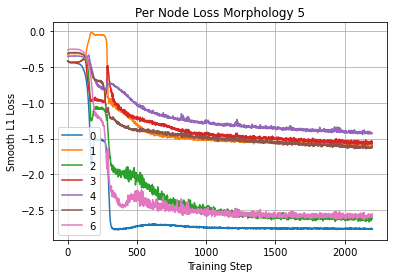


************** Batch 0 in 0.7472286224365234 **************

Training Idx 6 
Train Loss tensor([0.4840, 0.4755, 0.4355, 0.4382, 0.4382, 0.4860, 0.3931, 0.4875]) 
Test Loss tensor([0.4834, 0.4757, 0.4380, 0.4404, 0.4400, 0.4863, 0.3925, 0.4860])


************** Batch 4 in 0.8184876441955566 **************

Training Idx 6 
Train Loss tensor([0.4836, 0.4730, 0.4379, 0.4404, 0.4387, 0.4866, 0.3925, 0.4853]) 
Test Loss tensor([0.4818, 0.4740, 0.4390, 0.4414, 0.4410, 0.4847, 0.3914, 0.4844])


************** Batch 8 in 0.7043814659118652 **************

Training Idx 6 
Train Loss tensor([0.4822, 0.4773, 0.4375, 0.4418, 0.4409, 0.4850, 0.3920, 0.4843]) 
Test Loss tensor([0.4804, 0.4726, 0.4404, 0.4435, 0.4430, 0.4830, 0.3915, 0.4829])


************** Batch 12 in 0.7536087036132812 **************

Training Idx 6 
Train Loss tensor([0.4807, 0.4725, 0.4401, 0.4434, 0.4420, 0.4816, 0.3897, 0.4843]) 
Test Loss tensor([0.4797, 0.4716, 0.4415, 0.4439, 0.4440, 0.4812, 0.3912, 0.4813])


**********


************** Batch 136 in 0.7691977024078369 **************

Training Idx 6 
Train Loss tensor([0.4367, 0.4347, 0.4860, 0.4855, 0.4880, 0.4355, 0.3912, 0.4362]) 
Test Loss tensor([0.4344, 0.4324, 0.4873, 0.4859, 0.4906, 0.4352, 0.3896, 0.4350])


************** Batch 140 in 0.7736284732818604 **************

Training Idx 6 
Train Loss tensor([0.4337, 0.4328, 0.4874, 0.4855, 0.4915, 0.4348, 0.3875, 0.4346]) 
Test Loss tensor([0.4327, 0.4318, 0.4892, 0.4874, 0.4922, 0.4339, 0.3893, 0.4334])


************** Batch 144 in 0.8052802085876465 **************

Training Idx 6 
Train Loss tensor([0.4328, 0.4318, 0.4886, 0.4889, 0.4907, 0.4341, 0.3877, 0.4337]) 
Test Loss tensor([0.4320, 0.4302, 0.4896, 0.4885, 0.4941, 0.4325, 0.3897, 0.4322])


************** Batch 148 in 0.7635929584503174 **************

Training Idx 6 
Train Loss tensor([0.4309, 0.4296, 0.4897, 0.4892, 0.4935, 0.4323, 0.3884, 0.4324]) 
Test Loss tensor([0.4306, 0.4285, 0.4914, 0.4900, 0.4953, 0.4308, 0.3886, 0.4308])


***


************** Batch 268 in 0.7427000999450684 **************

Training Idx 6 
Train Loss tensor([0.3963, 0.3977, 0.5264, 0.5252, 0.5325, 0.3947, 0.3937, 0.3944]) 
Test Loss tensor([0.3948, 0.3979, 0.5307, 0.5261, 0.5356, 0.3934, 0.3871, 0.3928])


************** Batch 272 in 0.7798924446105957 **************

Training Idx 6 
Train Loss tensor([0.3940, 0.3985, 0.5300, 0.5260, 0.5337, 0.3924, 0.3888, 0.3937]) 
Test Loss tensor([0.3930, 0.3961, 0.5322, 0.5279, 0.5374, 0.3916, 0.3881, 0.3918])


************** Batch 276 in 0.8030047416687012 **************

Training Idx 6 
Train Loss tensor([0.3926, 0.3970, 0.5325, 0.5298, 0.5362, 0.3916, 0.3895, 0.3915]) 
Test Loss tensor([0.3919, 0.3955, 0.5337, 0.5289, 0.5388, 0.3909, 0.3879, 0.3905])


************** Batch 280 in 0.8076670169830322 **************

Training Idx 6 
Train Loss tensor([0.3908, 0.3944, 0.5358, 0.5310, 0.5384, 0.3907, 0.3873, 0.3916]) 
Test Loss tensor([0.3911, 0.3947, 0.5351, 0.5305, 0.5401, 0.3892, 0.3870, 0.3889])


***


************** Batch 400 in 0.7728068828582764 **************

Training Idx 6 
Train Loss tensor([0.3498, 0.3591, 0.5799, 0.5724, 0.5845, 0.3475, 0.3865, 0.3481]) 
Test Loss tensor([0.3487, 0.3592, 0.5821, 0.5744, 0.5887, 0.3473, 0.3905, 0.3475])


************** Batch 404 in 0.7628269195556641 **************

Training Idx 6 
Train Loss tensor([0.3482, 0.3585, 0.5821, 0.5720, 0.5888, 0.3473, 0.3875, 0.3473]) 
Test Loss tensor([0.3467, 0.3577, 0.5854, 0.5758, 0.5911, 0.3457, 0.3890, 0.3461])


************** Batch 408 in 0.7630918025970459 **************

Training Idx 6 
Train Loss tensor([0.3464, 0.3583, 0.5857, 0.5748, 0.5891, 0.3460, 0.3892, 0.3461]) 
Test Loss tensor([0.3456, 0.3577, 0.5865, 0.5765, 0.5929, 0.3442, 0.3890, 0.3444])


************** Batch 412 in 0.8397791385650635 **************

Training Idx 6 
Train Loss tensor([0.3465, 0.3577, 0.5858, 0.5759, 0.5926, 0.3434, 0.3937, 0.3441]) 
Test Loss tensor([0.3439, 0.3551, 0.5883, 0.5786, 0.5952, 0.3425, 0.3901, 0.3429])


***


************** Batch 532 in 0.6077890396118164 **************

Training Idx 6 
Train Loss tensor([0.2815, 0.3134, 0.6484, 0.6288, 0.6565, 0.2935, 0.3930, 0.2990]) 
Test Loss tensor([0.2798, 0.3142, 0.6489, 0.6298, 0.6577, 0.2930, 0.3929, 0.2983])


************** Batch 536 in 0.6355316638946533 **************

Training Idx 6 
Train Loss tensor([0.2815, 0.3162, 0.6437, 0.6281, 0.6573, 0.2934, 0.3932, 0.2995]) 
Test Loss tensor([0.2774, 0.3130, 0.6499, 0.6303, 0.6591, 0.2916, 0.3932, 0.2974])


************** Batch 540 in 0.6271288394927979 **************

Training Idx 6 
Train Loss tensor([0.2762, 0.3105, 0.6517, 0.6341, 0.6579, 0.2918, 0.3951, 0.2979]) 
Test Loss tensor([0.2752, 0.3111, 0.6515, 0.6322, 0.6609, 0.2906, 0.3922, 0.2966])


************** Batch 544 in 0.6674511432647705 **************

Training Idx 6 
Train Loss tensor([0.2749, 0.3142, 0.6527, 0.6292, 0.6600, 0.2896, 0.3987, 0.2957]) 
Test Loss tensor([0.2729, 0.3106, 0.6531, 0.6322, 0.6624, 0.2897, 0.3940, 0.2960])


***


************** Batch 664 in 0.6213855743408203 **************

Training Idx 6 
Train Loss tensor([0.1576, 0.3011, 0.6601, 0.6245, 0.6634, 0.2682, 0.3873, 0.2871]) 
Test Loss tensor([0.1512, 0.3043, 0.6600, 0.6230, 0.6605, 0.2640, 0.3878, 0.2845])


************** Batch 668 in 0.6389715671539307 **************

Training Idx 6 
Train Loss tensor([0.1514, 0.3056, 0.6613, 0.6233, 0.6602, 0.2640, 0.3809, 0.2842]) 
Test Loss tensor([0.1424, 0.3057, 0.6595, 0.6221, 0.6562, 0.2605, 0.3871, 0.2821])


************** Batch 672 in 0.6204924583435059 **************

Training Idx 6 
Train Loss tensor([0.1452, 0.3044, 0.6594, 0.6224, 0.6553, 0.2600, 0.3843, 0.2814]) 
Test Loss tensor([0.1338, 0.3066, 0.6585, 0.6219, 0.6510, 0.2561, 0.3852, 0.2788])


************** Batch 676 in 0.6294035911560059 **************

Training Idx 6 
Train Loss tensor([0.1363, 0.3074, 0.6563, 0.6242, 0.6497, 0.2566, 0.3846, 0.2789]) 
Test Loss tensor([0.1253, 0.3086, 0.6569, 0.6210, 0.6441, 0.2510, 0.3843, 0.2747])


***


************** Batch 796 in 0.6273455619812012 **************

Training Idx 6 
Train Loss tensor([0.0414, 0.0435, 0.4655, 0.4811, 0.4461, 0.0053, 0.1940, 0.0029]) 
Test Loss tensor([0.0335, 0.0425, 0.4622, 0.4705, 0.4399, 0.0050, 0.1922, 0.0024])


************** Batch 800 in 0.6142129898071289 **************

Training Idx 6 
Train Loss tensor([0.0313, 0.0435, 0.4633, 0.4724, 0.4395, 0.0054, 0.1928, 0.0026]) 
Test Loss tensor([0.0316, 0.0404, 0.4560, 0.4624, 0.4356, 0.0054, 0.1877, 0.0025])


************** Batch 804 in 0.6145026683807373 **************

Training Idx 6 
Train Loss tensor([0.0308, 0.0398, 0.4533, 0.4626, 0.4347, 0.0053, 0.1872, 0.0029]) 
Test Loss tensor([0.0331, 0.0411, 0.4493, 0.4517, 0.4310, 0.0056, 0.1864, 0.0026])


************** Batch 808 in 0.6168110370635986 **************

Training Idx 6 
Train Loss tensor([0.0369, 0.0443, 0.4490, 0.4479, 0.4306, 0.0054, 0.1895, 0.0023]) 
Test Loss tensor([0.0326, 0.0404, 0.4417, 0.4436, 0.4273, 0.0059, 0.1844, 0.0026])


***


************** Batch 48 in 0.7196381092071533 **************

Training Idx 6 
Train Loss tensor([0.0309, 0.0353, 0.3180, 0.3397, 0.2985, 0.0051, 0.1291, 0.0026]) 
Test Loss tensor([0.0324, 0.0319, 0.3132, 0.3356, 0.2932, 0.0050, 0.1286, 0.0027])


************** Batch 52 in 0.7834353446960449 **************

Training Idx 6 
Train Loss tensor([0.0365, 0.0314, 0.3097, 0.3347, 0.2915, 0.0051, 0.1334, 0.0026]) 
Test Loss tensor([0.0331, 0.0313, 0.3076, 0.3328, 0.2863, 0.0048, 0.1275, 0.0026])


************** Batch 56 in 0.8758144378662109 **************

Training Idx 6 
Train Loss tensor([0.0396, 0.0327, 0.3066, 0.3318, 0.2864, 0.0057, 0.1247, 0.0027]) 
Test Loss tensor([0.0319, 0.0311, 0.3026, 0.3297, 0.2798, 0.0050, 0.1224, 0.0026])


************** Batch 60 in 0.833305835723877 **************

Training Idx 6 
Train Loss tensor([0.0312, 0.0282, 0.3015, 0.3307, 0.2801, 0.0057, 0.1237, 0.0028]) 
Test Loss tensor([0.0338, 0.0307, 0.2979, 0.3267, 0.2727, 0.0049, 0.1219, 0.0027])


********


************** Batch 180 in 0.6688201427459717 **************

Training Idx 6 
Train Loss tensor([0.0344, 0.0163, 0.0494, 0.1891, 0.0219, 0.0056, 0.0375, 0.0028]) 
Test Loss tensor([0.0327, 0.0172, 0.0439, 0.1806, 0.0170, 0.0064, 0.0375, 0.0026])


************** Batch 184 in 0.8184061050415039 **************

Training Idx 6 
Train Loss tensor([0.0314, 0.0181, 0.0456, 0.1807, 0.0176, 0.0069, 0.0359, 0.0026]) 
Test Loss tensor([0.0348, 0.0173, 0.0385, 0.1721, 0.0142, 0.0065, 0.0367, 0.0026])


************** Batch 188 in 0.7257890701293945 **************

Training Idx 6 
Train Loss tensor([0.0367, 0.0185, 0.0383, 0.1738, 0.0148, 0.0057, 0.0353, 0.0024]) 
Test Loss tensor([0.0328, 0.0165, 0.0343, 0.1629, 0.0125, 0.0070, 0.0362, 0.0027])


************** Batch 192 in 0.6203980445861816 **************

Training Idx 6 
Train Loss tensor([0.0379, 0.0150, 0.0348, 0.1642, 0.0118, 0.0069, 0.0350, 0.0024]) 
Test Loss tensor([0.0344, 0.0172, 0.0304, 0.1545, 0.0105, 0.0069, 0.0376, 0.0026])


***


************** Batch 312 in 0.6197528839111328 **************

Training Idx 6 
Train Loss tensor([0.0196, 0.0151, 0.0092, 0.0061, 0.0057, 0.0065, 0.0456, 0.0024]) 
Test Loss tensor([0.0208, 0.0169, 0.0084, 0.0060, 0.0056, 0.0093, 0.0426, 0.0026])


************** Batch 316 in 0.6343014240264893 **************

Training Idx 6 
Train Loss tensor([0.0239, 0.0193, 0.0102, 0.0056, 0.0080, 0.0121, 0.0411, 0.0028]) 
Test Loss tensor([0.0216, 0.0171, 0.0090, 0.0064, 0.0058, 0.0091, 0.0432, 0.0026])


************** Batch 320 in 0.6229081153869629 **************

Training Idx 6 
Train Loss tensor([0.0201, 0.0186, 0.0077, 0.0056, 0.0048, 0.0125, 0.0418, 0.0024]) 
Test Loss tensor([0.0199, 0.0171, 0.0088, 0.0058, 0.0053, 0.0096, 0.0422, 0.0026])


************** Batch 324 in 0.6232242584228516 **************

Training Idx 6 
Train Loss tensor([0.0153, 0.0146, 0.0075, 0.0053, 0.0056, 0.0095, 0.0406, 0.0025]) 
Test Loss tensor([0.0205, 0.0175, 0.0089, 0.0057, 0.0054, 0.0099, 0.0422, 0.0026])


***


************** Batch 444 in 0.6214790344238281 **************

Training Idx 6 
Train Loss tensor([0.0192, 0.0163, 0.0078, 0.0050, 0.0071, 0.0064, 0.0382, 0.0029]) 
Test Loss tensor([0.0183, 0.0162, 0.0078, 0.0049, 0.0051, 0.0071, 0.0400, 0.0026])


************** Batch 448 in 0.6315231323242188 **************

Training Idx 6 
Train Loss tensor([0.0166, 0.0172, 0.0089, 0.0041, 0.0046, 0.0060, 0.0405, 0.0028]) 
Test Loss tensor([0.0186, 0.0164, 0.0077, 0.0049, 0.0051, 0.0071, 0.0406, 0.0026])


************** Batch 452 in 0.640937328338623 **************

Training Idx 6 
Train Loss tensor([0.0158, 0.0172, 0.0098, 0.0056, 0.0056, 0.0091, 0.0404, 0.0024]) 
Test Loss tensor([0.0182, 0.0163, 0.0078, 0.0045, 0.0050, 0.0074, 0.0397, 0.0026])


************** Batch 456 in 0.6837761402130127 **************

Training Idx 6 
Train Loss tensor([0.0198, 0.0153, 0.0054, 0.0048, 0.0065, 0.0070, 0.0388, 0.0026]) 
Test Loss tensor([0.0191, 0.0162, 0.0074, 0.0050, 0.0056, 0.0068, 0.0391, 0.0026])


****


************** Batch 576 in 0.6440072059631348 **************

Training Idx 6 
Train Loss tensor([0.0121, 0.0154, 0.0073, 0.0051, 0.0062, 0.0068, 0.0270, 0.0027]) 
Test Loss tensor([0.0155, 0.0137, 0.0062, 0.0055, 0.0054, 0.0070, 0.0271, 0.0029])


************** Batch 580 in 0.6521337032318115 **************

Training Idx 6 
Train Loss tensor([0.0133, 0.0146, 0.0084, 0.0050, 0.0081, 0.0064, 0.0266, 0.0029]) 
Test Loss tensor([0.0153, 0.0153, 0.0066, 0.0059, 0.0059, 0.0073, 0.0284, 0.0030])


************** Batch 584 in 0.7008585929870605 **************

Training Idx 6 
Train Loss tensor([0.0169, 0.0187, 0.0065, 0.0059, 0.0062, 0.0077, 0.0262, 0.0032]) 
Test Loss tensor([0.0142, 0.0140, 0.0062, 0.0058, 0.0063, 0.0071, 0.0286, 0.0030])


************** Batch 588 in 0.7423639297485352 **************

Training Idx 6 
Train Loss tensor([0.0155, 0.0131, 0.0066, 0.0058, 0.0065, 0.0072, 0.0267, 0.0031]) 
Test Loss tensor([0.0145, 0.0141, 0.0064, 0.0057, 0.0052, 0.0075, 0.0270, 0.0029])


***


************** Batch 708 in 0.6145100593566895 **************

Training Idx 6 
Train Loss tensor([0.0159, 0.0131, 0.0059, 0.0039, 0.0068, 0.0052, 0.0237, 0.0025]) 
Test Loss tensor([0.0157, 0.0133, 0.0067, 0.0050, 0.0060, 0.0053, 0.0241, 0.0024])


************** Batch 712 in 0.6188747882843018 **************

Training Idx 6 
Train Loss tensor([0.0173, 0.0123, 0.0062, 0.0048, 0.0057, 0.0052, 0.0237, 0.0024]) 
Test Loss tensor([0.0161, 0.0136, 0.0063, 0.0051, 0.0052, 0.0060, 0.0239, 0.0025])


************** Batch 716 in 0.6183784008026123 **************

Training Idx 6 
Train Loss tensor([0.0166, 0.0154, 0.0056, 0.0044, 0.0059, 0.0062, 0.0256, 0.0026]) 
Test Loss tensor([0.0155, 0.0131, 0.0062, 0.0052, 0.0053, 0.0061, 0.0241, 0.0025])


************** Batch 720 in 0.6211400032043457 **************

Training Idx 6 
Train Loss tensor([0.0155, 0.0139, 0.0051, 0.0052, 0.0066, 0.0066, 0.0241, 0.0024]) 
Test Loss tensor([0.0149, 0.0131, 0.0064, 0.0053, 0.0049, 0.0057, 0.0237, 0.0024])


***


************** Batch 840 in 0.6729850769042969 **************

Training Idx 6 
Train Loss tensor([0.0162, 0.0132, 0.0061, 0.0048, 0.0047, 0.0059, 0.0254, 0.0023]) 
Test Loss tensor([0.0155, 0.0124, 0.0066, 0.0046, 0.0054, 0.0046, 0.0226, 0.0023])


************** Batch 844 in 0.6973280906677246 **************

Training Idx 6 
Train Loss tensor([0.0136, 0.0125, 0.0049, 0.0036, 0.0028, 0.0040, 0.0247, 0.0022]) 
Test Loss tensor([0.0157, 0.0133, 0.0063, 0.0050, 0.0056, 0.0050, 0.0221, 0.0023])


************** Batch 848 in 0.8671059608459473 **************

Training Idx 6 
Train Loss tensor([0.0137, 0.0115, 0.0058, 0.0044, 0.0045, 0.0039, 0.0227, 0.0023]) 
Test Loss tensor([0.0154, 0.0132, 0.0064, 0.0046, 0.0058, 0.0049, 0.0216, 0.0023])


************** Batch 852 in 0.8111348152160645 **************

Training Idx 6 
Train Loss tensor([0.0133, 0.0117, 0.0066, 0.0060, 0.0058, 0.0042, 0.0231, 0.0023]) 
Test Loss tensor([0.0151, 0.0131, 0.0060, 0.0046, 0.0053, 0.0049, 0.0217, 0.0023])


***


************** Batch 96 in 0.7511820793151855 **************

Training Idx 6 
Train Loss tensor([0.0162, 0.0122, 0.0043, 0.0041, 0.0051, 0.0044, 0.0210, 0.0022]) 
Test Loss tensor([0.0146, 0.0123, 0.0058, 0.0045, 0.0054, 0.0048, 0.0207, 0.0022])


************** Batch 100 in 0.7084476947784424 **************

Training Idx 6 
Train Loss tensor([0.0121, 0.0129, 0.0055, 0.0047, 0.0040, 0.0046, 0.0181, 0.0022]) 
Test Loss tensor([0.0145, 0.0120, 0.0056, 0.0043, 0.0051, 0.0047, 0.0208, 0.0022])


************** Batch 104 in 0.6606624126434326 **************

Training Idx 6 
Train Loss tensor([0.0150, 0.0133, 0.0060, 0.0048, 0.0070, 0.0054, 0.0202, 0.0021]) 
Test Loss tensor([0.0143, 0.0119, 0.0057, 0.0043, 0.0055, 0.0044, 0.0205, 0.0023])


************** Batch 108 in 0.6458189487457275 **************

Training Idx 6 
Train Loss tensor([0.0139, 0.0120, 0.0050, 0.0041, 0.0068, 0.0053, 0.0192, 0.0023]) 
Test Loss tensor([0.0156, 0.0119, 0.0058, 0.0047, 0.0053, 0.0044, 0.0205, 0.0023])


****


************** Batch 228 in 0.6659982204437256 **************

Training Idx 6 
Train Loss tensor([0.0152, 0.0122, 0.0063, 0.0037, 0.0066, 0.0047, 0.0186, 0.0021]) 
Test Loss tensor([0.0153, 0.0116, 0.0056, 0.0045, 0.0052, 0.0045, 0.0207, 0.0022])


************** Batch 232 in 0.757554292678833 **************

Training Idx 6 
Train Loss tensor([0.0157, 0.0113, 0.0056, 0.0045, 0.0071, 0.0037, 0.0190, 0.0022]) 
Test Loss tensor([0.0151, 0.0124, 0.0059, 0.0044, 0.0058, 0.0044, 0.0202, 0.0022])


************** Batch 236 in 0.8003201484680176 **************

Training Idx 6 
Train Loss tensor([0.0141, 0.0134, 0.0065, 0.0045, 0.0060, 0.0042, 0.0179, 0.0022]) 
Test Loss tensor([0.0149, 0.0120, 0.0050, 0.0039, 0.0055, 0.0041, 0.0199, 0.0022])


************** Batch 240 in 0.6523489952087402 **************

Training Idx 6 
Train Loss tensor([0.0122, 0.0110, 0.0069, 0.0047, 0.0054, 0.0043, 0.0222, 0.0022]) 
Test Loss tensor([0.0144, 0.0119, 0.0054, 0.0041, 0.0058, 0.0042, 0.0195, 0.0022])


****


************** Batch 360 in 0.7088408470153809 **************

Training Idx 6 
Train Loss tensor([0.0160, 0.0101, 0.0064, 0.0039, 0.0066, 0.0050, 0.0189, 0.0022]) 
Test Loss tensor([0.0136, 0.0118, 0.0049, 0.0041, 0.0055, 0.0042, 0.0187, 0.0021])


************** Batch 364 in 0.7263960838317871 **************

Training Idx 6 
Train Loss tensor([0.0137, 0.0116, 0.0048, 0.0034, 0.0034, 0.0037, 0.0184, 0.0021]) 
Test Loss tensor([0.0142, 0.0116, 0.0052, 0.0041, 0.0052, 0.0042, 0.0194, 0.0021])


************** Batch 368 in 0.7199997901916504 **************

Training Idx 6 
Train Loss tensor([0.0132, 0.0131, 0.0056, 0.0043, 0.0053, 0.0049, 0.0179, 0.0023]) 
Test Loss tensor([0.0148, 0.0117, 0.0055, 0.0043, 0.0058, 0.0039, 0.0191, 0.0021])


************** Batch 372 in 0.6828725337982178 **************

Training Idx 6 
Train Loss tensor([0.0117, 0.0095, 0.0053, 0.0033, 0.0050, 0.0038, 0.0174, 0.0024]) 
Test Loss tensor([0.0147, 0.0119, 0.0052, 0.0040, 0.0054, 0.0039, 0.0189, 0.0021])


***


************** Batch 492 in 0.7094521522521973 **************

Training Idx 6 
Train Loss tensor([0.0119, 0.0115, 0.0040, 0.0039, 0.0062, 0.0034, 0.0184, 0.0021]) 
Test Loss tensor([0.0138, 0.0109, 0.0051, 0.0039, 0.0048, 0.0040, 0.0191, 0.0022])


************** Batch 496 in 0.6684091091156006 **************

Training Idx 6 
Train Loss tensor([0.0118, 0.0097, 0.0050, 0.0029, 0.0054, 0.0035, 0.0188, 0.0022]) 
Test Loss tensor([0.0135, 0.0116, 0.0048, 0.0036, 0.0052, 0.0044, 0.0182, 0.0021])


************** Batch 500 in 0.6916224956512451 **************

Training Idx 6 
Train Loss tensor([0.0130, 0.0119, 0.0042, 0.0034, 0.0064, 0.0042, 0.0191, 0.0022]) 
Test Loss tensor([0.0135, 0.0113, 0.0048, 0.0038, 0.0055, 0.0039, 0.0186, 0.0021])


************** Batch 504 in 0.6524925231933594 **************

Training Idx 6 
Train Loss tensor([0.0147, 0.0121, 0.0046, 0.0038, 0.0043, 0.0032, 0.0182, 0.0021]) 
Test Loss tensor([0.0140, 0.0113, 0.0049, 0.0039, 0.0049, 0.0039, 0.0180, 0.0021])


***


************** Batch 624 in 0.6718113422393799 **************

Training Idx 6 
Train Loss tensor([0.0146, 0.0108, 0.0059, 0.0032, 0.0071, 0.0038, 0.0185, 0.0020]) 
Test Loss tensor([0.0135, 0.0108, 0.0049, 0.0038, 0.0054, 0.0036, 0.0183, 0.0021])


************** Batch 628 in 0.664348840713501 **************

Training Idx 6 
Train Loss tensor([0.0119, 0.0119, 0.0039, 0.0038, 0.0063, 0.0035, 0.0192, 0.0022]) 
Test Loss tensor([0.0137, 0.0109, 0.0046, 0.0037, 0.0060, 0.0035, 0.0182, 0.0021])


************** Batch 632 in 0.6626358032226562 **************

Training Idx 6 
Train Loss tensor([0.0152, 0.0131, 0.0048, 0.0029, 0.0059, 0.0036, 0.0190, 0.0022]) 
Test Loss tensor([0.0135, 0.0108, 0.0051, 0.0038, 0.0048, 0.0037, 0.0181, 0.0021])


************** Batch 636 in 0.671527624130249 **************

Training Idx 6 
Train Loss tensor([0.0104, 0.0100, 0.0039, 0.0033, 0.0055, 0.0040, 0.0206, 0.0020]) 
Test Loss tensor([0.0134, 0.0107, 0.0049, 0.0035, 0.0051, 0.0036, 0.0185, 0.0021])


*****


************** Batch 756 in 0.7142331600189209 **************

Training Idx 6 
Train Loss tensor([0.0144, 0.0102, 0.0040, 0.0033, 0.0052, 0.0033, 0.0186, 0.0020]) 
Test Loss tensor([0.0134, 0.0107, 0.0048, 0.0037, 0.0051, 0.0034, 0.0182, 0.0021])


************** Batch 760 in 0.6552095413208008 **************

Training Idx 6 
Train Loss tensor([0.0147, 0.0113, 0.0047, 0.0041, 0.0066, 0.0032, 0.0175, 0.0022]) 
Test Loss tensor([0.0136, 0.0105, 0.0048, 0.0038, 0.0052, 0.0035, 0.0186, 0.0021])


************** Batch 764 in 0.6524217128753662 **************

Training Idx 6 
Train Loss tensor([0.0134, 0.0095, 0.0051, 0.0026, 0.0042, 0.0038, 0.0178, 0.0020]) 
Test Loss tensor([0.0133, 0.0108, 0.0048, 0.0038, 0.0050, 0.0035, 0.0175, 0.0021])


************** Batch 768 in 0.6795346736907959 **************

Training Idx 6 
Train Loss tensor([0.0139, 0.0135, 0.0044, 0.0032, 0.0061, 0.0032, 0.0189, 0.0020]) 
Test Loss tensor([0.0134, 0.0113, 0.0046, 0.0036, 0.0047, 0.0036, 0.0179, 0.0021])


***


************** Batch 8 in 0.6810195446014404 **************

Training Idx 6 
Train Loss tensor([0.0129, 0.0101, 0.0047, 0.0030, 0.0050, 0.0027, 0.0175, 0.0020]) 
Test Loss tensor([0.0134, 0.0113, 0.0044, 0.0036, 0.0048, 0.0033, 0.0179, 0.0020])


************** Batch 12 in 0.6931633949279785 **************

Training Idx 6 
Train Loss tensor([0.0136, 0.0113, 0.0041, 0.0031, 0.0058, 0.0029, 0.0184, 0.0020]) 
Test Loss tensor([0.0129, 0.0108, 0.0047, 0.0034, 0.0052, 0.0034, 0.0177, 0.0020])


************** Batch 16 in 0.6835088729858398 **************

Training Idx 6 
Train Loss tensor([0.0150, 0.0111, 0.0047, 0.0035, 0.0066, 0.0034, 0.0183, 0.0020]) 
Test Loss tensor([0.0128, 0.0109, 0.0044, 0.0036, 0.0051, 0.0033, 0.0176, 0.0020])


************** Batch 20 in 0.7222437858581543 **************

Training Idx 6 
Train Loss tensor([0.0136, 0.0104, 0.0047, 0.0039, 0.0063, 0.0028, 0.0193, 0.0020]) 
Test Loss tensor([0.0129, 0.0115, 0.0045, 0.0035, 0.0048, 0.0034, 0.0180, 0.0020])


********


************** Batch 144 in 0.644406795501709 **************

Training Idx 6 
Train Loss tensor([0.0139, 0.0100, 0.0043, 0.0046, 0.0062, 0.0032, 0.0158, 0.0020]) 
Test Loss tensor([0.0129, 0.0105, 0.0045, 0.0034, 0.0050, 0.0033, 0.0171, 0.0020])


************** Batch 148 in 0.6401963233947754 **************

Training Idx 6 
Train Loss tensor([0.0112, 0.0088, 0.0052, 0.0035, 0.0051, 0.0036, 0.0164, 0.0021]) 
Test Loss tensor([0.0121, 0.0107, 0.0046, 0.0034, 0.0048, 0.0034, 0.0168, 0.0020])


************** Batch 152 in 0.6360697746276855 **************

Training Idx 6 
Train Loss tensor([0.0135, 0.0106, 0.0056, 0.0032, 0.0054, 0.0027, 0.0181, 0.0020]) 
Test Loss tensor([0.0135, 0.0102, 0.0045, 0.0035, 0.0057, 0.0035, 0.0170, 0.0020])


************** Batch 156 in 0.6607778072357178 **************

Training Idx 6 
Train Loss tensor([0.0119, 0.0105, 0.0047, 0.0028, 0.0045, 0.0036, 0.0158, 0.0020]) 
Test Loss tensor([0.0122, 0.0106, 0.0045, 0.0037, 0.0054, 0.0033, 0.0176, 0.0020])


****


************** Batch 276 in 0.6744122505187988 **************

Training Idx 6 
Train Loss tensor([0.0130, 0.0099, 0.0042, 0.0039, 0.0062, 0.0031, 0.0155, 0.0020]) 
Test Loss tensor([0.0124, 0.0103, 0.0046, 0.0034, 0.0051, 0.0033, 0.0172, 0.0020])


************** Batch 280 in 0.6554956436157227 **************

Training Idx 6 
Train Loss tensor([0.0129, 0.0106, 0.0050, 0.0030, 0.0037, 0.0028, 0.0162, 0.0019]) 
Test Loss tensor([0.0128, 0.0103, 0.0045, 0.0034, 0.0053, 0.0030, 0.0174, 0.0020])


************** Batch 284 in 0.6713016033172607 **************

Training Idx 6 
Train Loss tensor([0.0118, 0.0108, 0.0036, 0.0032, 0.0052, 0.0027, 0.0172, 0.0021]) 
Test Loss tensor([0.0122, 0.0102, 0.0046, 0.0033, 0.0052, 0.0031, 0.0176, 0.0020])


************** Batch 288 in 0.660463809967041 **************

Training Idx 6 
Train Loss tensor([0.0122, 0.0097, 0.0041, 0.0034, 0.0069, 0.0029, 0.0167, 0.0020]) 
Test Loss tensor([0.0126, 0.0108, 0.0044, 0.0035, 0.0049, 0.0030, 0.0174, 0.0020])


****


************** Batch 408 in 0.6248791217803955 **************

Training Idx 6 
Train Loss tensor([0.0120, 0.0102, 0.0037, 0.0028, 0.0055, 0.0030, 0.0168, 0.0019]) 
Test Loss tensor([0.0117, 0.0105, 0.0044, 0.0034, 0.0049, 0.0032, 0.0168, 0.0020])


************** Batch 412 in 0.6255574226379395 **************

Training Idx 6 
Train Loss tensor([0.0148, 0.0079, 0.0036, 0.0028, 0.0038, 0.0031, 0.0149, 0.0019]) 
Test Loss tensor([0.0116, 0.0101, 0.0044, 0.0033, 0.0052, 0.0032, 0.0162, 0.0020])


************** Batch 416 in 0.7146201133728027 **************

Training Idx 6 
Train Loss tensor([0.0135, 0.0097, 0.0064, 0.0034, 0.0063, 0.0032, 0.0166, 0.0021]) 
Test Loss tensor([0.0124, 0.0104, 0.0043, 0.0035, 0.0050, 0.0034, 0.0167, 0.0020])


************** Batch 420 in 0.7841775417327881 **************

Training Idx 6 
Train Loss tensor([0.0116, 0.0107, 0.0048, 0.0034, 0.0056, 0.0031, 0.0180, 0.0019]) 
Test Loss tensor([0.0126, 0.0108, 0.0043, 0.0033, 0.0045, 0.0033, 0.0167, 0.0020])


***


************** Batch 540 in 0.7208759784698486 **************

Training Idx 6 
Train Loss tensor([0.0117, 0.0098, 0.0044, 0.0048, 0.0075, 0.0029, 0.0159, 0.0020]) 
Test Loss tensor([0.0122, 0.0102, 0.0045, 0.0032, 0.0049, 0.0032, 0.0159, 0.0019])


************** Batch 544 in 0.7990591526031494 **************

Training Idx 6 
Train Loss tensor([0.0140, 0.0082, 0.0037, 0.0040, 0.0047, 0.0030, 0.0162, 0.0021]) 
Test Loss tensor([0.0118, 0.0102, 0.0044, 0.0032, 0.0052, 0.0031, 0.0161, 0.0019])


************** Batch 548 in 0.6961579322814941 **************

Training Idx 6 
Train Loss tensor([0.0140, 0.0097, 0.0047, 0.0032, 0.0061, 0.0035, 0.0169, 0.0019]) 
Test Loss tensor([0.0127, 0.0099, 0.0045, 0.0033, 0.0046, 0.0030, 0.0163, 0.0019])


************** Batch 552 in 0.6449782848358154 **************

Training Idx 6 
Train Loss tensor([0.0107, 0.0107, 0.0039, 0.0035, 0.0041, 0.0037, 0.0156, 0.0020]) 
Test Loss tensor([0.0114, 0.0097, 0.0045, 0.0031, 0.0052, 0.0031, 0.0161, 0.0019])


***


************** Batch 672 in 0.765214204788208 **************

Training Idx 6 
Train Loss tensor([0.0124, 0.0109, 0.0034, 0.0031, 0.0061, 0.0029, 0.0164, 0.0019]) 
Test Loss tensor([0.0115, 0.0096, 0.0043, 0.0032, 0.0046, 0.0031, 0.0155, 0.0020])


************** Batch 676 in 0.7690212726593018 **************

Training Idx 6 
Train Loss tensor([0.0132, 0.0097, 0.0041, 0.0032, 0.0049, 0.0034, 0.0152, 0.0020]) 
Test Loss tensor([0.0123, 0.0095, 0.0041, 0.0033, 0.0047, 0.0032, 0.0158, 0.0020])


************** Batch 680 in 0.7024762630462646 **************

Training Idx 6 
Train Loss tensor([0.0118, 0.0101, 0.0037, 0.0038, 0.0050, 0.0029, 0.0158, 0.0020]) 
Test Loss tensor([0.0115, 0.0100, 0.0042, 0.0031, 0.0047, 0.0030, 0.0163, 0.0020])


************** Batch 684 in 0.6889448165893555 **************

Training Idx 6 
Train Loss tensor([0.0096, 0.0093, 0.0034, 0.0031, 0.0055, 0.0030, 0.0165, 0.0018]) 
Test Loss tensor([0.0120, 0.0095, 0.0040, 0.0032, 0.0054, 0.0030, 0.0160, 0.0019])


****


************** Batch 804 in 0.7226464748382568 **************

Training Idx 6 
Train Loss tensor([0.0105, 0.0095, 0.0034, 0.0037, 0.0053, 0.0027, 0.0149, 0.0019]) 
Test Loss tensor([0.0119, 0.0098, 0.0041, 0.0034, 0.0051, 0.0029, 0.0155, 0.0020])


************** Batch 808 in 0.8107037544250488 **************

Training Idx 6 
Train Loss tensor([0.0099, 0.0097, 0.0040, 0.0029, 0.0027, 0.0030, 0.0150, 0.0019]) 
Test Loss tensor([0.0117, 0.0095, 0.0043, 0.0033, 0.0052, 0.0031, 0.0155, 0.0019])


************** Batch 812 in 0.7084012031555176 **************

Training Idx 6 
Train Loss tensor([0.0113, 0.0099, 0.0040, 0.0030, 0.0050, 0.0028, 0.0162, 0.0017]) 
Test Loss tensor([0.0117, 0.0096, 0.0043, 0.0033, 0.0046, 0.0032, 0.0156, 0.0020])


************** Batch 816 in 0.6271812915802002 **************

Training Idx 6 
Train Loss tensor([0.0113, 0.0104, 0.0050, 0.0029, 0.0040, 0.0034, 0.0156, 0.0018]) 
Test Loss tensor([0.0113, 0.0097, 0.0044, 0.0031, 0.0049, 0.0030, 0.0155, 0.0020])


***


************** Batch 56 in 0.6825113296508789 **************

Training Idx 6 
Train Loss tensor([0.0123, 0.0070, 0.0044, 0.0042, 0.0044, 0.0032, 0.0139, 0.0020]) 
Test Loss tensor([0.0110, 0.0101, 0.0042, 0.0031, 0.0041, 0.0029, 0.0158, 0.0020])


************** Batch 60 in 0.700631856918335 **************

Training Idx 6 
Train Loss tensor([0.0106, 0.0082, 0.0049, 0.0041, 0.0051, 0.0032, 0.0154, 0.0020]) 
Test Loss tensor([0.0106, 0.0089, 0.0042, 0.0032, 0.0043, 0.0028, 0.0157, 0.0019])


************** Batch 64 in 0.6803197860717773 **************

Training Idx 6 
Train Loss tensor([0.0107, 0.0107, 0.0053, 0.0033, 0.0045, 0.0036, 0.0159, 0.0019]) 
Test Loss tensor([0.0106, 0.0099, 0.0043, 0.0031, 0.0048, 0.0028, 0.0154, 0.0019])


************** Batch 68 in 0.6621232032775879 **************

Training Idx 6 
Train Loss tensor([0.0110, 0.0077, 0.0040, 0.0029, 0.0061, 0.0027, 0.0161, 0.0019]) 
Test Loss tensor([0.0103, 0.0097, 0.0044, 0.0032, 0.0047, 0.0028, 0.0154, 0.0019])


********


************** Batch 188 in 0.8519203662872314 **************

Training Idx 6 
Train Loss tensor([0.0111, 0.0099, 0.0043, 0.0034, 0.0036, 0.0034, 0.0158, 0.0018]) 
Test Loss tensor([0.0105, 0.0098, 0.0041, 0.0031, 0.0046, 0.0030, 0.0147, 0.0019])


************** Batch 192 in 0.68727707862854 **************

Training Idx 6 
Train Loss tensor([0.0113, 0.0088, 0.0049, 0.0031, 0.0070, 0.0028, 0.0156, 0.0020]) 
Test Loss tensor([0.0099, 0.0100, 0.0043, 0.0033, 0.0046, 0.0028, 0.0152, 0.0019])


************** Batch 196 in 0.6516823768615723 **************

Training Idx 6 
Train Loss tensor([0.0113, 0.0103, 0.0040, 0.0036, 0.0056, 0.0034, 0.0158, 0.0018]) 
Test Loss tensor([0.0116, 0.0097, 0.0043, 0.0032, 0.0049, 0.0028, 0.0151, 0.0019])


************** Batch 200 in 0.7121872901916504 **************

Training Idx 6 
Train Loss tensor([0.0105, 0.0072, 0.0038, 0.0030, 0.0052, 0.0025, 0.0151, 0.0019]) 
Test Loss tensor([0.0104, 0.0090, 0.0044, 0.0030, 0.0046, 0.0028, 0.0153, 0.0019])


*****


************** Batch 320 in 0.8189442157745361 **************

Training Idx 6 
Train Loss tensor([0.0130, 0.0081, 0.0044, 0.0039, 0.0055, 0.0027, 0.0138, 0.0018]) 
Test Loss tensor([0.0103, 0.0093, 0.0043, 0.0033, 0.0045, 0.0030, 0.0144, 0.0019])


************** Batch 324 in 0.753648042678833 **************

Training Idx 6 
Train Loss tensor([0.0100, 0.0089, 0.0037, 0.0029, 0.0041, 0.0025, 0.0158, 0.0017]) 
Test Loss tensor([0.0102, 0.0094, 0.0043, 0.0035, 0.0051, 0.0030, 0.0143, 0.0019])


************** Batch 328 in 0.696270227432251 **************

Training Idx 6 
Train Loss tensor([0.0090, 0.0081, 0.0039, 0.0031, 0.0047, 0.0032, 0.0143, 0.0019]) 
Test Loss tensor([0.0101, 0.0091, 0.0043, 0.0030, 0.0044, 0.0028, 0.0147, 0.0019])


************** Batch 332 in 0.6799182891845703 **************

Training Idx 6 
Train Loss tensor([0.0099, 0.0107, 0.0042, 0.0029, 0.0047, 0.0025, 0.0156, 0.0018]) 
Test Loss tensor([0.0102, 0.0093, 0.0042, 0.0031, 0.0044, 0.0027, 0.0146, 0.0019])


*****


************** Batch 452 in 0.6400091648101807 **************

Training Idx 6 
Train Loss tensor([0.0111, 0.0088, 0.0032, 0.0040, 0.0045, 0.0028, 0.0140, 0.0019]) 
Test Loss tensor([0.0096, 0.0093, 0.0043, 0.0030, 0.0044, 0.0028, 0.0143, 0.0019])


************** Batch 456 in 0.7207145690917969 **************

Training Idx 6 
Train Loss tensor([0.0090, 0.0079, 0.0034, 0.0026, 0.0055, 0.0030, 0.0133, 0.0019]) 
Test Loss tensor([0.0098, 0.0094, 0.0042, 0.0031, 0.0040, 0.0029, 0.0139, 0.0019])


************** Batch 460 in 0.7266788482666016 **************

Training Idx 6 
Train Loss tensor([0.0089, 0.0081, 0.0043, 0.0025, 0.0035, 0.0029, 0.0157, 0.0018]) 
Test Loss tensor([0.0099, 0.0093, 0.0044, 0.0032, 0.0047, 0.0027, 0.0146, 0.0019])


************** Batch 464 in 0.6779463291168213 **************

Training Idx 6 
Train Loss tensor([0.0110, 0.0094, 0.0042, 0.0031, 0.0057, 0.0024, 0.0144, 0.0018]) 
Test Loss tensor([0.0092, 0.0093, 0.0043, 0.0030, 0.0048, 0.0029, 0.0142, 0.0019])


***


************** Batch 584 in 0.618119478225708 **************

Training Idx 6 
Train Loss tensor([0.0086, 0.0078, 0.0050, 0.0030, 0.0051, 0.0034, 0.0141, 0.0019]) 
Test Loss tensor([0.0101, 0.0091, 0.0041, 0.0032, 0.0041, 0.0029, 0.0139, 0.0019])


************** Batch 588 in 0.6138627529144287 **************

Training Idx 6 
Train Loss tensor([0.0088, 0.0089, 0.0051, 0.0027, 0.0041, 0.0027, 0.0120, 0.0019]) 
Test Loss tensor([0.0090, 0.0091, 0.0040, 0.0031, 0.0040, 0.0028, 0.0140, 0.0019])


************** Batch 592 in 0.6190676689147949 **************

Training Idx 6 
Train Loss tensor([0.0089, 0.0086, 0.0037, 0.0026, 0.0045, 0.0029, 0.0134, 0.0020]) 
Test Loss tensor([0.0094, 0.0090, 0.0041, 0.0030, 0.0046, 0.0028, 0.0138, 0.0019])


************** Batch 596 in 0.6218836307525635 **************

Training Idx 6 
Train Loss tensor([0.0077, 0.0093, 0.0041, 0.0023, 0.0036, 0.0027, 0.0143, 0.0019]) 
Test Loss tensor([0.0089, 0.0089, 0.0039, 0.0031, 0.0041, 0.0029, 0.0139, 0.0019])


****


************** Batch 716 in 0.6200826168060303 **************

Training Idx 6 
Train Loss tensor([0.0090, 0.0079, 0.0043, 0.0031, 0.0054, 0.0024, 0.0139, 0.0020]) 
Test Loss tensor([0.0089, 0.0088, 0.0042, 0.0030, 0.0042, 0.0027, 0.0137, 0.0019])


************** Batch 720 in 0.6206181049346924 **************

Training Idx 6 
Train Loss tensor([0.0106, 0.0082, 0.0041, 0.0030, 0.0048, 0.0023, 0.0136, 0.0018]) 
Test Loss tensor([0.0086, 0.0090, 0.0042, 0.0032, 0.0041, 0.0027, 0.0137, 0.0019])


************** Batch 724 in 0.6095762252807617 **************

Training Idx 6 
Train Loss tensor([0.0082, 0.0087, 0.0041, 0.0035, 0.0063, 0.0025, 0.0145, 0.0018]) 
Test Loss tensor([0.0090, 0.0086, 0.0040, 0.0030, 0.0042, 0.0028, 0.0136, 0.0019])


************** Batch 728 in 0.612091064453125 **************

Training Idx 6 
Train Loss tensor([0.0103, 0.0082, 0.0042, 0.0023, 0.0045, 0.0023, 0.0132, 0.0019]) 
Test Loss tensor([0.0093, 0.0087, 0.0041, 0.0034, 0.0041, 0.0029, 0.0139, 0.0019])


****


************** Batch 848 in 0.6168467998504639 **************

Training Idx 6 
Train Loss tensor([0.0112, 0.0078, 0.0036, 0.0028, 0.0044, 0.0022, 0.0124, 0.0019]) 
Test Loss tensor([0.0081, 0.0091, 0.0041, 0.0031, 0.0045, 0.0027, 0.0136, 0.0019])


************** Batch 852 in 0.6405305862426758 **************

Training Idx 6 
Train Loss tensor([0.0081, 0.0071, 0.0046, 0.0030, 0.0035, 0.0022, 0.0134, 0.0019]) 
Test Loss tensor([0.0092, 0.0081, 0.0041, 0.0031, 0.0044, 0.0025, 0.0135, 0.0019])


************** Batch 856 in 0.6187949180603027 **************

Training Idx 6 
Train Loss tensor([0.0128, 0.0075, 0.0032, 0.0028, 0.0062, 0.0028, 0.0143, 0.0018]) 
Test Loss tensor([0.0084, 0.0087, 0.0040, 0.0029, 0.0042, 0.0027, 0.0131, 0.0019])


************** Batch 860 in 0.6355078220367432 **************

Training Idx 6 
Train Loss tensor([0.0100, 0.0095, 0.0036, 0.0030, 0.0035, 0.0023, 0.0123, 0.0019]) 
Test Loss tensor([0.0081, 0.0082, 0.0039, 0.0030, 0.0043, 0.0026, 0.0130, 0.0019])


***


************** Batch 104 in 0.6956427097320557 **************

Training Idx 6 
Train Loss tensor([0.0082, 0.0079, 0.0033, 0.0029, 0.0042, 0.0024, 0.0143, 0.0018]) 
Test Loss tensor([0.0089, 0.0081, 0.0041, 0.0030, 0.0049, 0.0026, 0.0129, 0.0019])


************** Batch 108 in 0.6181044578552246 **************

Training Idx 6 
Train Loss tensor([0.0100, 0.0065, 0.0045, 0.0028, 0.0049, 0.0020, 0.0133, 0.0018]) 
Test Loss tensor([0.0083, 0.0086, 0.0039, 0.0028, 0.0038, 0.0027, 0.0128, 0.0019])


************** Batch 112 in 0.6345789432525635 **************

Training Idx 6 
Train Loss tensor([0.0090, 0.0056, 0.0035, 0.0029, 0.0046, 0.0032, 0.0126, 0.0020]) 
Test Loss tensor([0.0085, 0.0082, 0.0042, 0.0030, 0.0047, 0.0026, 0.0132, 0.0019])


************** Batch 116 in 0.6735174655914307 **************

Training Idx 6 
Train Loss tensor([0.0088, 0.0073, 0.0036, 0.0026, 0.0056, 0.0027, 0.0121, 0.0019]) 
Test Loss tensor([0.0086, 0.0084, 0.0042, 0.0030, 0.0041, 0.0027, 0.0129, 0.0019])


***


************** Batch 236 in 0.6802682876586914 **************

Training Idx 6 
Train Loss tensor([0.0101, 0.0093, 0.0043, 0.0029, 0.0048, 0.0021, 0.0125, 0.0018]) 
Test Loss tensor([0.0081, 0.0081, 0.0038, 0.0028, 0.0039, 0.0027, 0.0126, 0.0019])


************** Batch 240 in 0.6562473773956299 **************

Training Idx 6 
Train Loss tensor([0.0096, 0.0074, 0.0040, 0.0023, 0.0039, 0.0032, 0.0129, 0.0019]) 
Test Loss tensor([0.0088, 0.0087, 0.0038, 0.0029, 0.0042, 0.0027, 0.0129, 0.0019])


************** Batch 244 in 0.6515331268310547 **************

Training Idx 6 
Train Loss tensor([0.0089, 0.0085, 0.0040, 0.0033, 0.0029, 0.0034, 0.0123, 0.0019]) 
Test Loss tensor([0.0082, 0.0087, 0.0039, 0.0030, 0.0047, 0.0027, 0.0129, 0.0019])


************** Batch 248 in 0.7715508937835693 **************

Training Idx 6 
Train Loss tensor([0.0072, 0.0071, 0.0043, 0.0029, 0.0052, 0.0028, 0.0128, 0.0018]) 
Test Loss tensor([0.0080, 0.0086, 0.0040, 0.0030, 0.0042, 0.0026, 0.0128, 0.0019])


***


************** Batch 368 in 0.710437536239624 **************

Training Idx 6 
Train Loss tensor([0.0101, 0.0097, 0.0040, 0.0031, 0.0048, 0.0025, 0.0122, 0.0018]) 
Test Loss tensor([0.0079, 0.0088, 0.0039, 0.0028, 0.0042, 0.0028, 0.0123, 0.0019])


************** Batch 372 in 0.7312572002410889 **************

Training Idx 6 
Train Loss tensor([0.0071, 0.0070, 0.0039, 0.0029, 0.0048, 0.0024, 0.0122, 0.0018]) 
Test Loss tensor([0.0085, 0.0086, 0.0044, 0.0028, 0.0044, 0.0025, 0.0129, 0.0019])


************** Batch 376 in 0.6486151218414307 **************

Training Idx 6 
Train Loss tensor([0.0087, 0.0083, 0.0051, 0.0028, 0.0047, 0.0025, 0.0124, 0.0019]) 
Test Loss tensor([0.0089, 0.0086, 0.0040, 0.0029, 0.0042, 0.0025, 0.0125, 0.0018])


************** Batch 380 in 0.6882579326629639 **************

Training Idx 6 
Train Loss tensor([0.0087, 0.0081, 0.0049, 0.0029, 0.0049, 0.0024, 0.0117, 0.0018]) 
Test Loss tensor([0.0082, 0.0084, 0.0041, 0.0027, 0.0049, 0.0026, 0.0126, 0.0018])


****


************** Batch 500 in 0.6263623237609863 **************

Training Idx 6 
Train Loss tensor([0.0096, 0.0078, 0.0039, 0.0028, 0.0055, 0.0024, 0.0117, 0.0018]) 
Test Loss tensor([0.0089, 0.0083, 0.0039, 0.0031, 0.0044, 0.0025, 0.0126, 0.0019])


************** Batch 504 in 0.642627477645874 **************

Training Idx 6 
Train Loss tensor([0.0070, 0.0090, 0.0050, 0.0036, 0.0058, 0.0022, 0.0124, 0.0019]) 
Test Loss tensor([0.0080, 0.0083, 0.0041, 0.0030, 0.0041, 0.0025, 0.0122, 0.0018])


************** Batch 508 in 0.7397828102111816 **************

Training Idx 6 
Train Loss tensor([0.0076, 0.0069, 0.0039, 0.0027, 0.0037, 0.0025, 0.0112, 0.0019]) 
Test Loss tensor([0.0083, 0.0088, 0.0039, 0.0029, 0.0039, 0.0026, 0.0127, 0.0019])


************** Batch 512 in 0.7227902412414551 **************

Training Idx 6 
Train Loss tensor([0.0060, 0.0102, 0.0038, 0.0030, 0.0052, 0.0024, 0.0120, 0.0018]) 
Test Loss tensor([0.0080, 0.0082, 0.0038, 0.0030, 0.0046, 0.0026, 0.0121, 0.0019])


****

KeyboardInterrupt: 

In [16]:
trainLosses = {}
testLosses = {}
validLosses = {}
trainingIdxs = []
validationIdxs = []

inputNetworkGradients = []
messageNetworkGradients = []
updateNetworkGradients = []
outputNetworkGradients = []


for morphIdx in range(7):
    trainLosses[morphIdx] = []
    testLosses[morphIdx] = []
    validLosses[morphIdx] = []

for index in [1, 2, 3, 4, 5, 6]:
    
    inputNetwork = Network(inputSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
    messageNetwork = Network(stateSize + 1, messageSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)
    updateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
    outputNetwork = Network(stateSize, outputSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)

    gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations).to(device)

    optimizer = optim.Adam(itertools.chain(inputNetwork.parameters(), messageNetwork.parameters(), updateNetwork.parameters(), outputNetwork.parameters())
                           , lr, weight_decay=1e-5)
    
    trainingIdxs = [index]
    
    for epoch in range(10):

        for morphIdx in trainingIdxs:
            permutation = np.random.permutation(X_train[morphIdx].shape[0])
            X_train[morphIdx] = X_train[morphIdx][permutation]
            Y_train[morphIdx] = Y_train[morphIdx][permutation]

        stepLoss = None
        graphs = []
        numAggregatedBatches = 0

        for batch in range(0, numTrainingBatches, numBatchesPerTrainingStep):

            inputNetwork.train()
            messageNetwork.train()
            updateNetwork.train()
            outputNetwork.train()

            t0 = time.time()

            for morphIdx in trainingIdxs:
                numNodes = (X_train[morphIdx].shape[1] // 2 - 5) // 2
                trainLosses[morphIdx].append(torch.zeros(numNodes))

            for batchOffset in range(numBatchesPerTrainingStep):

                if batch + batchOffset >= numTrainingBatches:
                    break

                for morphIdx in trainingIdxs:
                    graphs.append(env[morphIdx].get_graph()._get_dgl_graph())
                    x = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                    y = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)

                    y_hat = gnn.forward(graphs[-1], x)

                    loss_tmp = criterion(y, y_hat).mean(dim=0)

                    trainLosses[morphIdx][-1] += loss_tmp.cpu().detach() / numBatchesPerTrainingStep

                    if stepLoss is None:
                        stepLoss = loss_tmp.mean()

                    else:
                        stepLoss += loss_tmp.mean()

            optimizer.zero_grad()
            stepLoss.backward()


            s = 0
            for parameter in inputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            inputNetworkGradients.append(s.item())

            s = 0
            for parameter in messageNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            messageNetworkGradients.append(s.item())

            s = 0        
            for parameter in updateNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            updateNetworkGradients.append(s.item())

            s = 0        
            for parameter in outputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            outputNetworkGradients.append(s.item())

            optimizer.step()

            stepLoss = None
            graphs = []

            inputNetwork.eval()
            messageNetwork.eval()
            updateNetwork.eval()
            outputNetwork.eval()

            numBatchesForExectution = 50
            for morphIdx in trainingIdxs:
                numNodes = (X_train[morphIdx].shape[1] // 2 - 5) // 2
                testLosses[morphIdx].append(torch.zeros(numNodes))
                for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):
                    g = env[morphIdx].get_graph()._get_dgl_graph()
                    x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y_hat = gnn.forward(g, x)
                    loss = criterion(y, y_hat).mean(dim=0)
                    testLosses[morphIdx][-1] += loss.cpu().detach()
                testLosses[morphIdx][-1] /= numBatchesForExectution

            for morphIdx in validationIdxs:
                numNodes = (X_train[morphIdx].shape[1] // 2 - 5) // 2
                validLosses[morphIdx].append(torch.zeros(numNodes))
                for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):

                    g = env[morphIdx].get_graph()._get_dgl_graph()
                    x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                    y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)

                    y_hat = gnn.forward(g, x)
                    loss = criterion(y, y_hat).mean(dim=0)

                    validLosses[morphIdx][-1] += loss.cpu().detach()
                validLosses[morphIdx][-1] /= numBatchesForExectution

            print('\n************** Batch {} in {} **************\n'.format(batch, time.time() - t0))
            for morphIdx in trainingIdxs:
                print('Training Idx {} \nTrain Loss {} \nTest Loss {}\n'.format(morphIdx, trainLosses[morphIdx][-1], testLosses[morphIdx][-1]))
            for morphIdx in validationIdxs:
                print('Valid Idx {} | Loss {}'.format(morphIdx, validLosses[morphIdx][-1]))
                
    lossArr = torch.stack(testLosses[index]).T
    fig, ax = plt.subplots(1, sharex=True)
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), torch.log10(lossArr[i]))
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Training Step')
    plt.grid()
    plt.ylabel('Smooth L1 Loss')
    plt.title('Per Node Loss Morphology {}'.format(index))
    plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()

#             if batch % 20 ==0:
#                 print('Gradients: Input {} | Message {} | Update {} | Output {}'.format(
#                     inputNetworkGradients[-1], messageNetworkGradients[-1], updateNetworkGradients[-1], outputNetworkGradients[-1]))

In [12]:
trainLosses = {}
testLosses = {}
validLosses = {}
trainingIdxs = [0]
validationIdxs = []

inputNetworkGradients = []
messageNetworkGradients = []
updateNetworkGradients = []
outputNetworkGradients = []


for morphIdx in range(7):
    trainLosses[morphIdx] = []
    testLosses[morphIdx] = []
    validLosses[morphIdx] = []

for epoch in range(1):
    
    
    for morphIdx in trainingIdxs:
        permutation = np.random.permutation(X_train[morphIdx].shape[0])
        X_train[morphIdx] = X_train[morphIdx][permutation]
        Y_train[morphIdx] = Y_train[morphIdx][permutation]
        
    stepLoss = None
    graphs = []
    numAggregatedBatches = 0

    for batch in range(0, numTrainingBatches, numBatchesPerTrainingStep):
        
        inputNetwork.train()
        messageNetwork.train()
        updateNetwork.train()
        outputNetwork.train()
        
        t0 = time.time()
        
        for morphIdx in trainingIdxs:
            numNodes = (X_train[morphIdx].shape[1] // 2 - 5) // 2
            trainLosses[morphIdx].append(torch.zeros(numNodes))

        for batchOffset in range(numBatchesPerTrainingStep):
            
            if batch + batchOffset >= numTrainingBatches:
                break
                
            for morphIdx in trainingIdxs:
                graphs.append(env[morphIdx].get_graph()._get_dgl_graph())
                x = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                y = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)

                y_hat = gnn.forward(graphs[-1], x)

                loss_tmp = criterion(y, y_hat).mean(dim=0)

                trainLosses[morphIdx][-1] += loss_tmp.cpu().detach() / numBatchesPerTrainingStep

                if stepLoss is None:
                    stepLoss = loss_tmp.mean()

                else:
                    stepLoss += loss_tmp.mean()
        
        optimizer.zero_grad()
        stepLoss.backward()
        
        
        s = 0
        for parameter in inputNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        inputNetworkGradients.append(s.item())

        s = 0
        for parameter in messageNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        messageNetworkGradients.append(s.item())

        s = 0        
        for parameter in updateNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        updateNetworkGradients.append(s.item())

        s = 0        
        for parameter in outputNetwork.parameters():
            s += torch.abs(parameter.grad).mean()
        outputNetworkGradients.append(s.item())

        optimizer.step()
        
        stepLoss = None
        graphs = []
        
        inputNetwork.eval()
        messageNetwork.eval()
        updateNetwork.eval()
        outputNetwork.eval()

        numBatchesForExectution = 50
        for morphIdx in trainingIdxs:
            numNodes = (X_train[morphIdx].shape[1] // 2 - 5) // 2
            testLosses[morphIdx].append(torch.zeros(numNodes))
            for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):
                g = env[morphIdx].get_graph()._get_dgl_graph()
                x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y_hat = gnn.forward(g, x)
                loss = criterion(y, y_hat).mean(dim=0)
                testLosses[morphIdx][-1] += loss.cpu().detach()
            testLosses[morphIdx][-1] /= numBatchesForExectution
        
        for morphIdx in validationIdxs:
            numNodes = (X_train[morphIdx].shape[1] // 2 - 5) // 2
            validLosses[morphIdx].append(torch.zeros(numNodes))
            for batch_ in np.random.choice(np.arange(numTestingBatches-1), numBatchesForExectution):

                g = env[morphIdx].get_graph()._get_dgl_graph()
                x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)

                y_hat = gnn.forward(g, x)
                loss = criterion(y, y_hat).mean(dim=0)

                validLosses[morphIdx][-1] += loss.cpu().detach()
            validLosses[morphIdx][-1] /= numBatchesForExectution

        print('\n************** Batch {} in {} **************\n'.format(batch, time.time() - t0))
        for morphIdx in trainingIdxs:
            print('Training Idx {} \nTrain Loss {} \nTest Loss {}\n'.format(morphIdx, trainLosses[morphIdx][-1], testLosses[morphIdx][-1]))
        for morphIdx in validationIdxs:
            print('Valid Idx {} | Loss {}'.format(morphIdx, validLosses[morphIdx][-1]))
            
        if batch % 20 ==0:
            print('Gradients: Input {} | Message {} | Update {} | Output {}'.format(
                inputNetworkGradients[-1], messageNetworkGradients[-1], updateNetworkGradients[-1], outputNetworkGradients[-1]))    
#         if batch % 100 == 99:
#             lr_scheduler.step()


************** Batch 0 in 0.5357680320739746 **************

Training Idx 0 
Train Loss tensor([0.0168, 0.0028, 0.0044, 0.0249, 0.0152, 0.0075]) 
Test Loss tensor([0.0138, 0.0028, 0.0051, 0.0222, 0.0151, 0.0088])

Gradients: Input 0.09093064069747925 | Message 0.0723920464515686 | Update 0.10797195136547089 | Output 0.013019801117479801

************** Batch 4 in 0.5407388210296631 **************

Training Idx 0 
Train Loss tensor([0.0134, 0.0035, 0.0052, 0.0223, 0.0142, 0.0085]) 
Test Loss tensor([0.0137, 0.0029, 0.0051, 0.0226, 0.0153, 0.0089])


************** Batch 8 in 0.5462749004364014 **************

Training Idx 0 
Train Loss tensor([0.0139, 0.0026, 0.0041, 0.0205, 0.0149, 0.0069]) 
Test Loss tensor([0.0138, 0.0029, 0.0052, 0.0219, 0.0154, 0.0087])


************** Batch 12 in 0.583775520324707 **************

Training Idx 0 
Train Loss tensor([0.0149, 0.0027, 0.0049, 0.0236, 0.0147, 0.0079]) 
Test Loss tensor([0.0134, 0.0031, 0.0052, 0.0223, 0.0157, 0.0087])


**************

KeyboardInterrupt: 

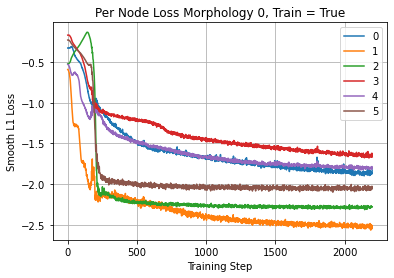

In [11]:
morphIdx = 0
lossArr = torch.stack(testLosses[morphIdx]).T
fig, ax = plt.subplots(1, sharex=True)
for i in range(lossArr.shape[0]):
    ax.plot(range(lossArr.shape[1]), torch.log10(lossArr[i]))
plt.legend(range(lossArr.shape[0]))
plt.xlabel('Training Step')
plt.grid()
plt.ylabel('Smooth L1 Loss')
plt.title('Per Node Loss Morphology {}, Train = {}'.format(morphIdx, morphIdx in trainingIdxs))
plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
plt.show()

In [9]:
# Cell for producing Per Node Loss for each Morphology

for morphIdx in range(7):
    if morphIdx in trainigIdxs:
        lossArr = torch.stack(testLosses[morphIdx]).T
    else:
        lossArr = torch.stack(validLosses[morphIdx]).T
    
    fig, ax = plt.subplots(1, sharex=True)
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), lossArr[i])
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Training Step')
    plt.grid()
    plt.ylabel('Smooth L1 Loss')
    plt.title('Per Node Loss Morphology {}, Train = {}'.format(morphIdx, morphIdx in trainingIdxs))
    plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()
    

NameError: name 'trainigIdxs' is not defined

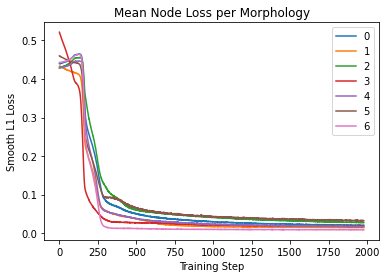

In [37]:
fig, ax = plt.subplots(1, sharex=True)
for morphIdx in trainingIdxs:
    lossArr = torch.stack(testLosses[morphIdx]).mean(dim=1)
    ax.plot(range(lossArr.shape[0]), lossArr)
for morphIdx in validationIdxs:
    lossArr = torch.stack(validLosses[morphIdx]).mean(dim=1)
    ax.plot(range(lossArr.shape[0]), lossArr)

plt.xlabel('Training Step')
plt.ylabel('Smooth L1 Loss')
plt.title('Mean Node Loss per Morphology')
plt.legend(trainingIdxs + validationIdxs)
plt.savefig('mean-node-losses.jpg')
plt.show()

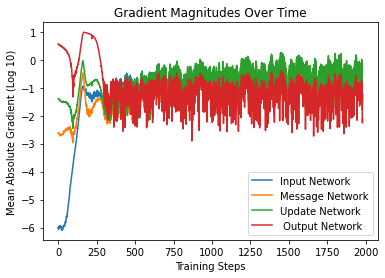

In [36]:
fig, ax = plt.subplots(1, sharex=True)
ax.plot(range(len(inputNetworkGradients)), np.log10(inputNetworkGradients))
ax.plot(range(len(messageNetworkGradients)), np.log10(messageNetworkGradients))
ax.plot(range(len(updateNetworkGradients)), np.log10(updateNetworkGradients))
ax.plot(range(len(outputNetworkGradients)), np.log10(outputNetworkGradients))
plt.xlabel('Training Steps')
plt.ylabel('Mean Absolute Gradient (Log 10)')
plt.title('Gradient Magnitudes Over Time')
plt.legend(['Input Network', 'Message Network', 'Update Network', ' Output Network'])
plt.savefig('gradients.jpg')
plt.show()

In [ ]:
prefix = '../models/mix/'

testLossesArr = np.array(testLosses)
trainLossesArr = np.array(trainLosses)
validLossesArr = np.array(validLosses)
learningRatesArr = np.array(learningRates)

np.save(prefix + 'testLosses', testLossesArr)
np.save(prefix + 'trainLosses', trainLossesArr)
np.save(prefix + 'validLosses', validLossesArr)
np.save(prefix + 'learningRates', learningRatesArr)

# torch.save(inputNetwork, prefix + 'inputNetwork.pt')
# torch.save(outputNetwork, prefix + 'outputNetwork.pt')
# torch.save(messageNetwork, prefix + 'messageNetwork.pt')
# torch.save(updateNetwork, prefix + 'updateNetwork.pt')

fig, ax = plt.subplots(1, sharex=True)
ax.plot(range(len(testLossesArr)), testLossesArr)
ax.plot(range(len(trainLossesArr)), trainLossesArr, 'b')
ax.plot(range(len(validLossesArr)), validLossesArr)
ax.set(ylabel='Smooth L1 Loss')
# ax[1].plot(range(len(learningRates)), learningRatesArr)
# ax[1].set(ylabel='Learning Rate')
ax.legend(["Testing", "Training", "Valid"])
plt.xlabel('Batch')
plt.savefig(prefix + 'valid-0.jpg')
plt.show()

In [ ]:
prefix = '../models/mix/'

inputNetwork = torch.load(prefix + 'inputNetwork.pt')
messageNetwork = torch.load(prefix + 'messageNetwork.pt')
updateNetwork = torch.load(prefix + 'updateNetwork.pt')
outputNetwork = torch.load(prefix + 'outputNetwork.pt')

gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations=3).to(device)

testLoss = 0
for morphIdx in [0]:
    
    for batch in range(numTestingBatches):

        g = env[morphIdx].get_graph()._get_dgl_graph()
        x = X_test[morphIdx][batch * batch_size:(batch+1)*batch_size].to(device)
        y = Y_test[morphIdx][batch * batch_size:(batch+1)*batch_size].to(device)

        y_hat = gnn.forward(g, x)
        loss = criterion(y, y_hat)
        testLoss += loss.item()
        
print(testLoss / X_test[morphIdx].shape[0])